In [1]:
%matplotlib inline

In [2]:
import gym
import tensorflow as tf
import numpy as np
from tqdm import tqdm, trange
import random

In [3]:
# Constants
TIMESTEPS = 30000
REPLAY_BUFFER_SIZE = 100000
LEARNING_START = 10000
BATCH_SIZE = 256
DISCOUNT_FACTOR = 0.9
LEARNING_RATE = 0.001
ACTOR_NETWORK_LAYERS = [128, 64]
Q_NETWORK_LAYERS = [128, 64]

In [4]:
from displayframesasgif import display_frames_as_gif
from replaybuffer import ReplayBuffer, PrioritizedReplayBuffer
from ddpg import DDPG
from neuralnetwork import NeuralNetwork
from movingaverage import MovingAverage

In [5]:
env = gym.make('Pendulum-v0')

[2017-02-24 18:04:55,704] Making new env: Pendulum-v0


In [6]:
observation = env.reset()
frames = []
reward_avg = MovingAverage(100)

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

In [7]:
session = tf.InteractiveSession()

In [8]:
actor_network = NeuralNetwork("Actor", session, [state_dim], ACTOR_NETWORK_LAYERS, action_dim, tf.nn.relu)
q_network = NeuralNetwork("Q", session, [state_dim, action_dim], Q_NETWORK_LAYERS, 1, tf.nn.relu)

agent = DDPG(actor_network, q_network, discount_factor=DISCOUNT_FACTOR, batch_size=BATCH_SIZE,
             replay_buffer_size=REPLAY_BUFFER_SIZE, learning_rate=LEARNING_RATE)

session.run(tf.global_variables_initializer())

In [9]:
progress_bar = tqdm(total=TIMESTEPS)
state = np.array(env.reset())

for t in range(TIMESTEPS):   
    action = None
    
    exploration_probability = ((TIMESTEPS - t) / float(TIMESTEPS)) ** 3
    
    if random.uniform(0, 1) < exploration_probability:
        action = env.action_space.sample()
    else:
        action = agent.action([state])[0]
    
    observation, reward, done, info = env.step(action)
    next_state = np.reshape(observation, (state_dim,))
    agent.store_transition(state, action, reward, next_state, done)
    state = next_state
    
    reward_avg.add_value(reward)
        
    if t >= LEARNING_START:
        agent.train()
        if t % 60 == 0:
            frames.append(env.render(mode = 'rgb_array'))
        
    progress_bar.set_description('[{}] reward: {:.2f}, reward 100-step MA: {:.2f}, action: {}' \
        .format(t, reward, reward_avg.get_average(), str(action)))
    progress_bar.update()
    
    if done:
        break
        
progress_bar.close()

[29999] reward: -0.01, reward 100-step MA: -0.00, action: [ 1.69047356]: 100%|██████████| 30000/30000 [02:11<00:00, 228.26it/s] 73/30000 [00:00<01:41, 293.85it/s]



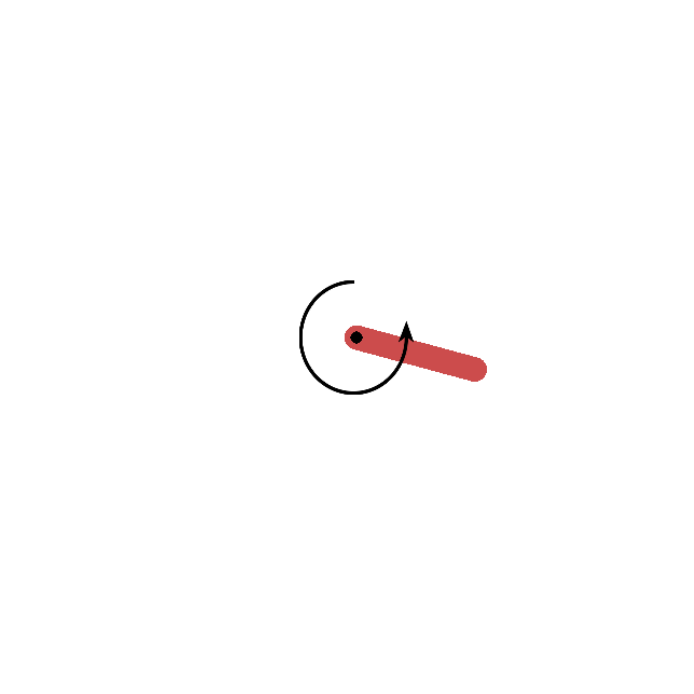
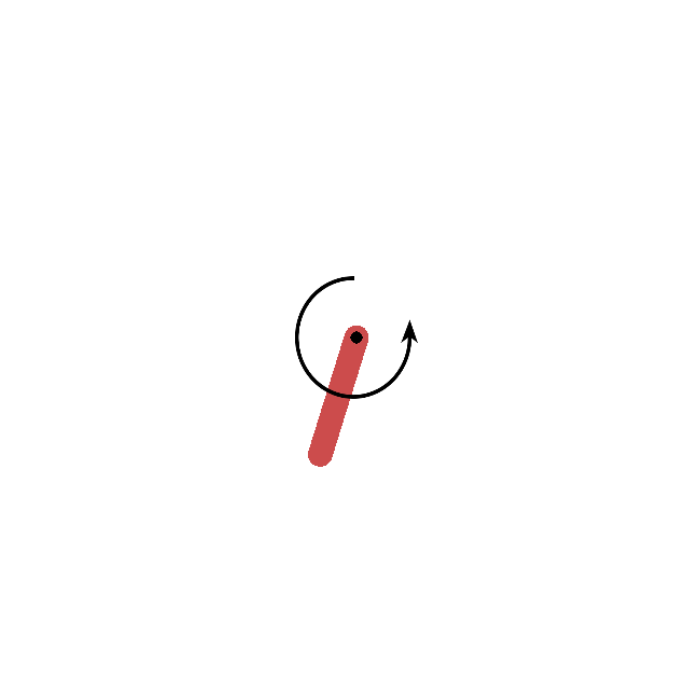
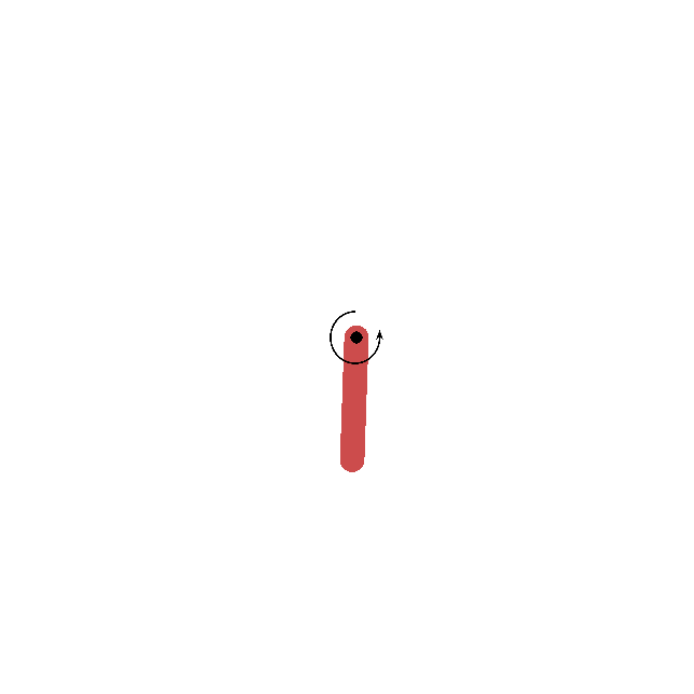
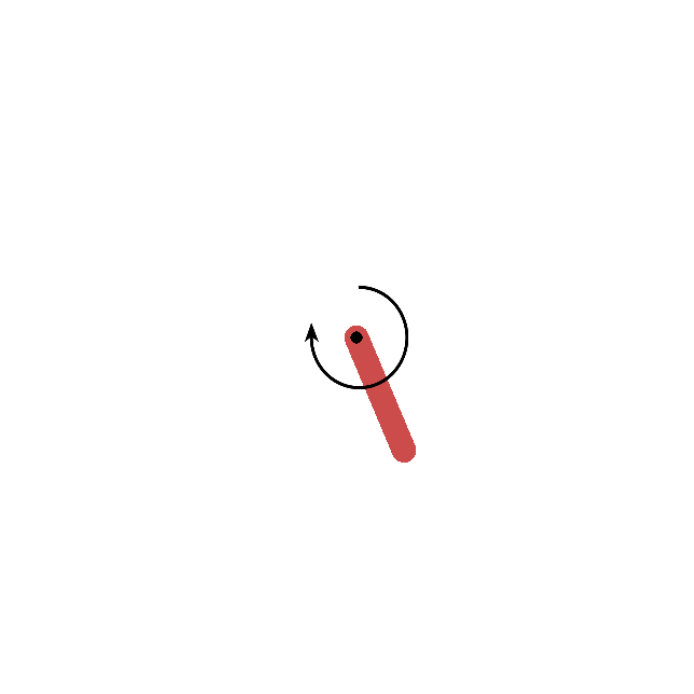
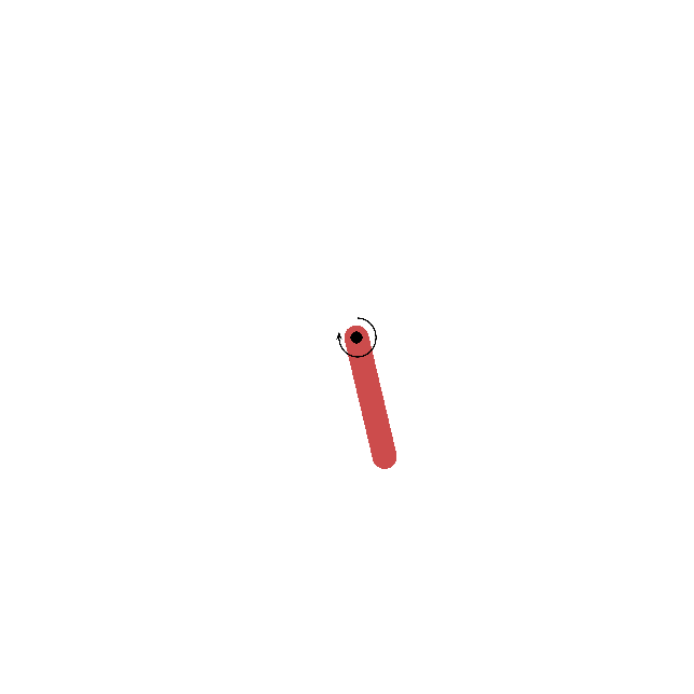
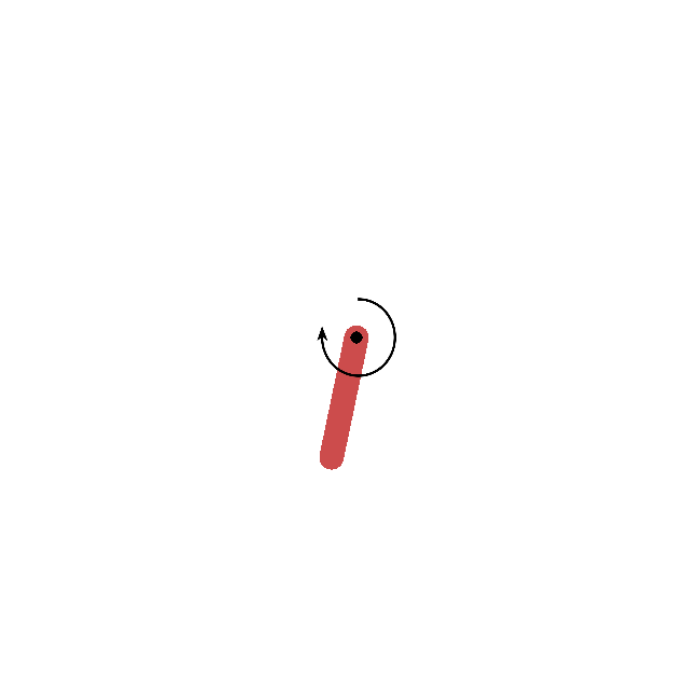
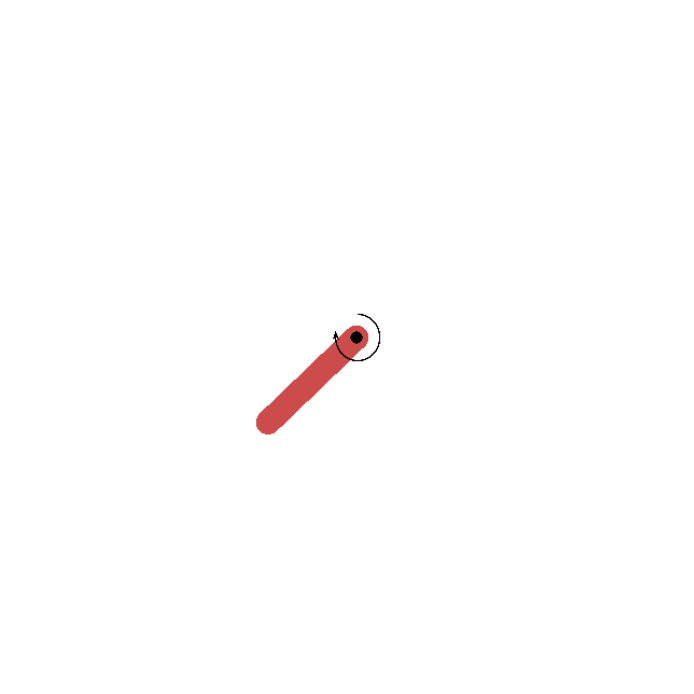
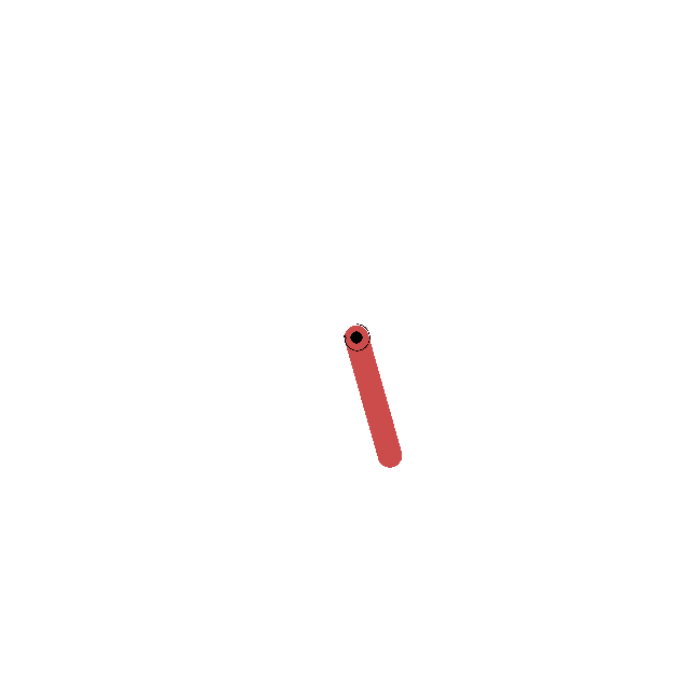
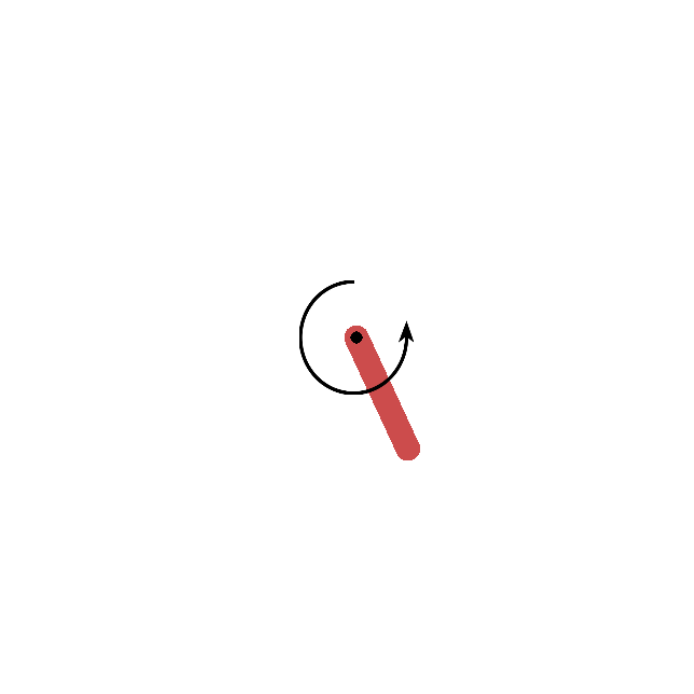
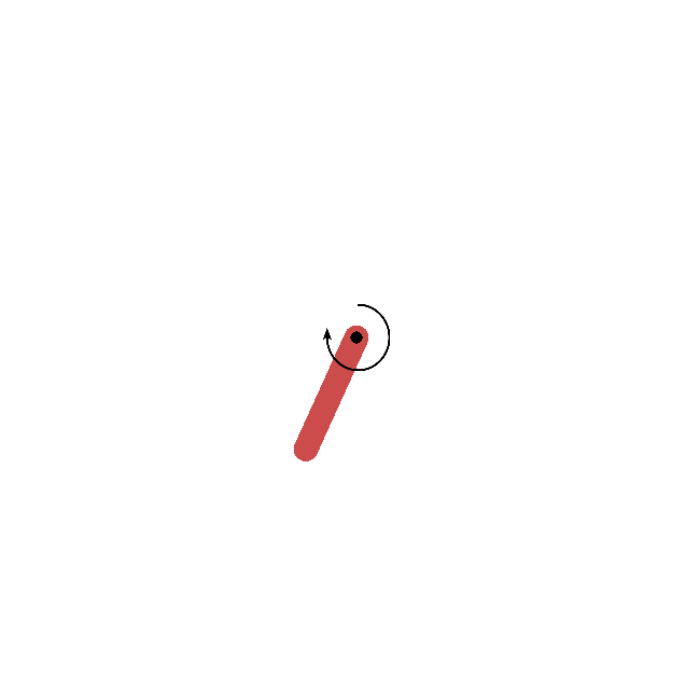
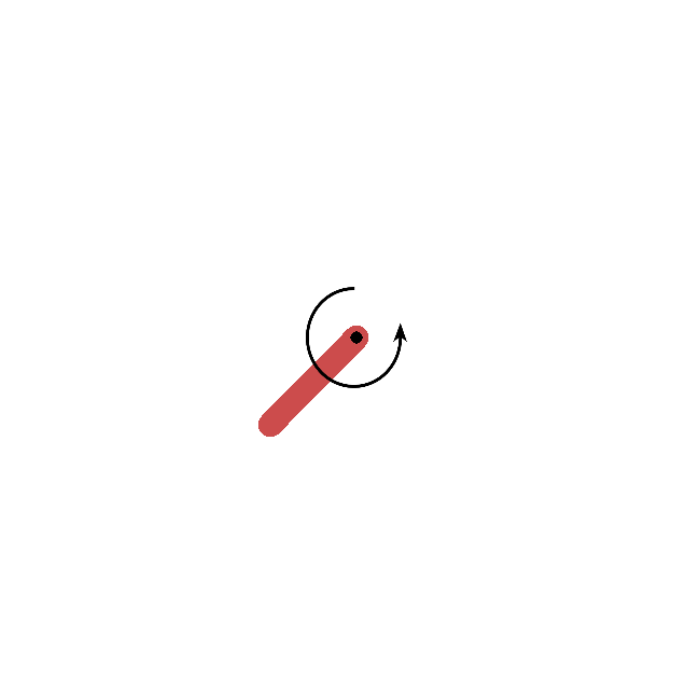
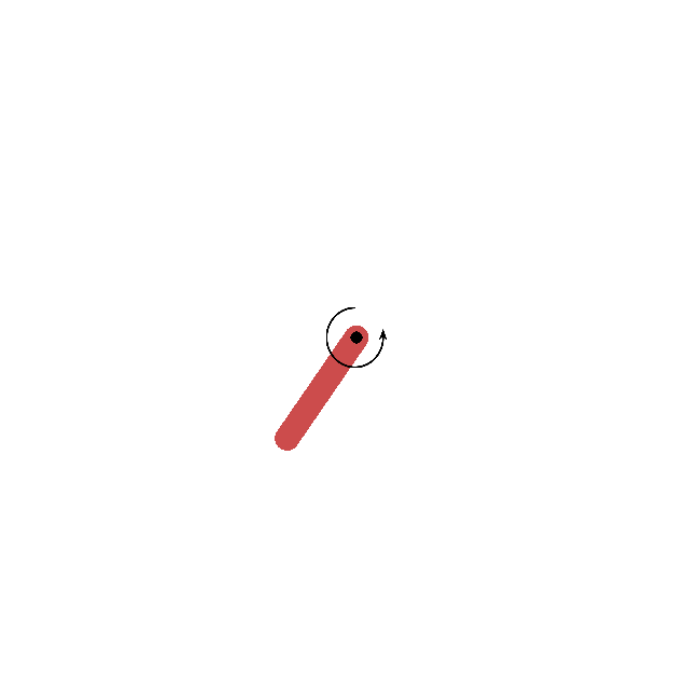
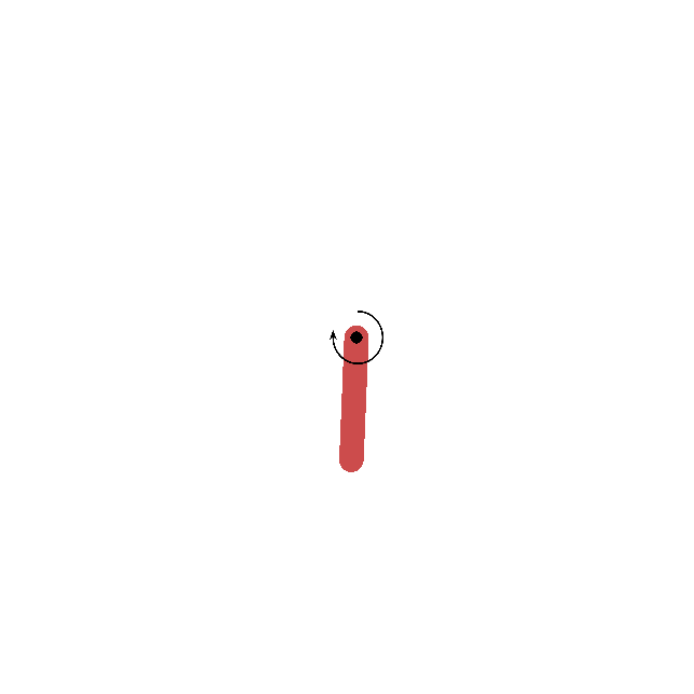
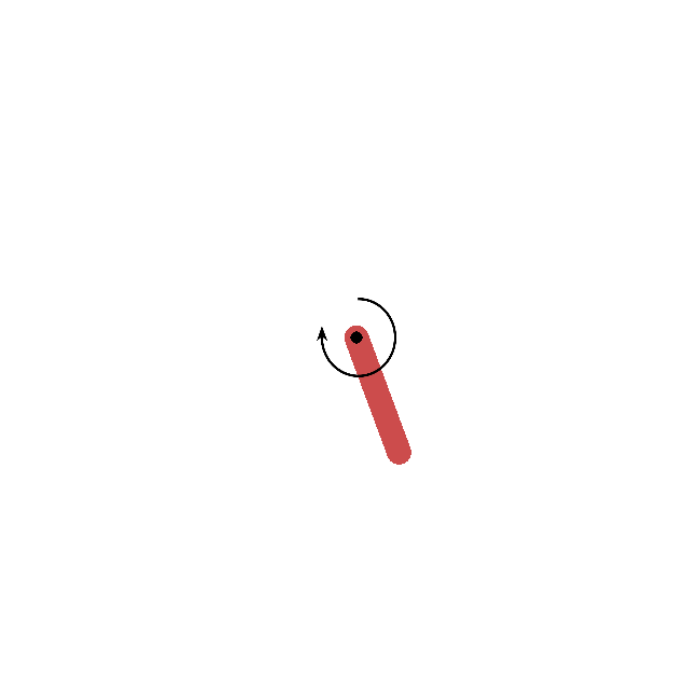
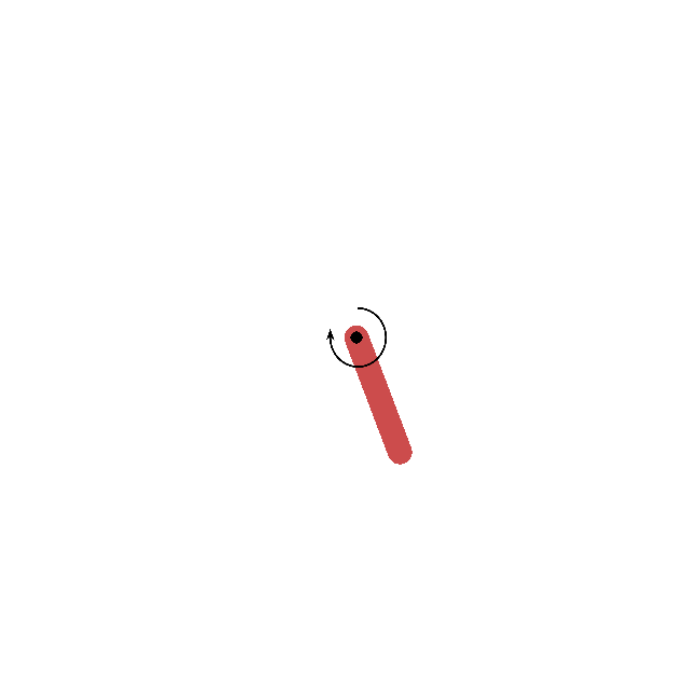
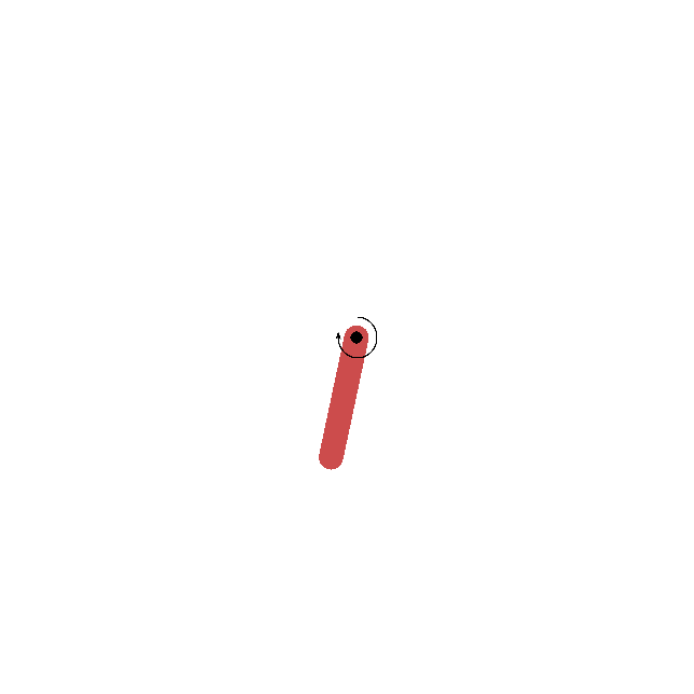
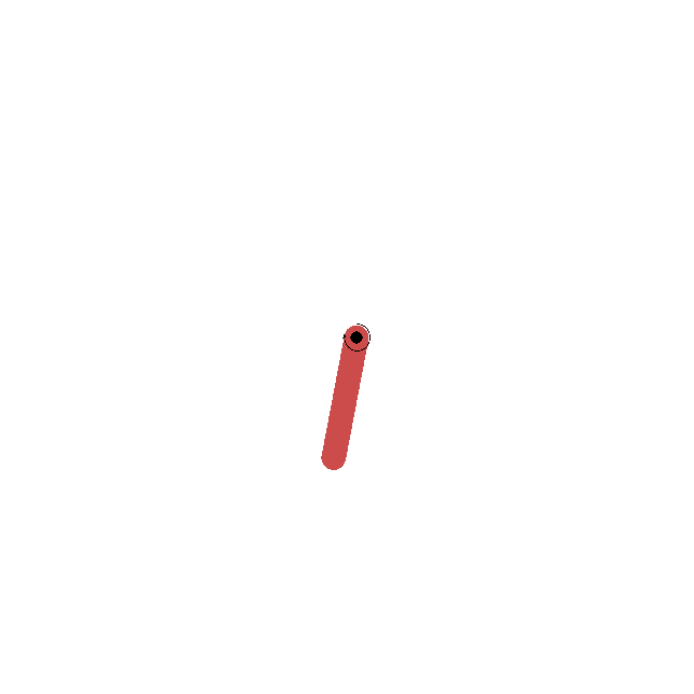
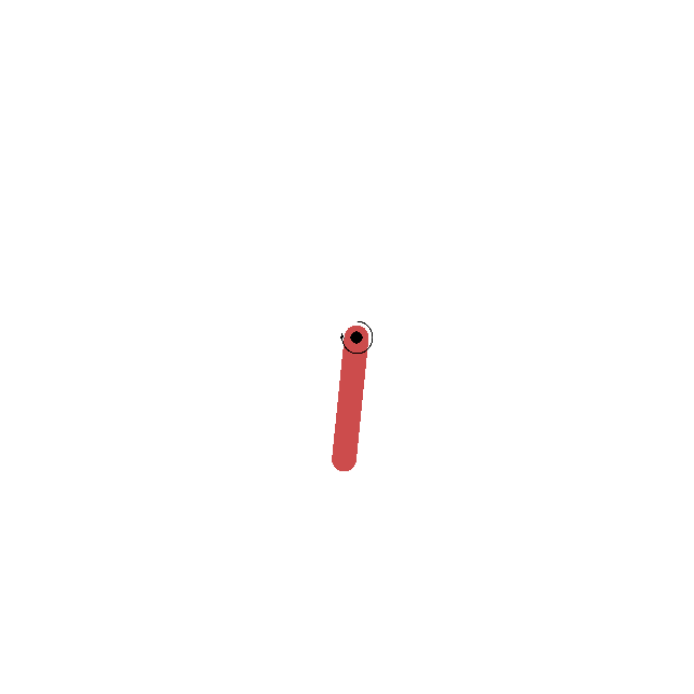
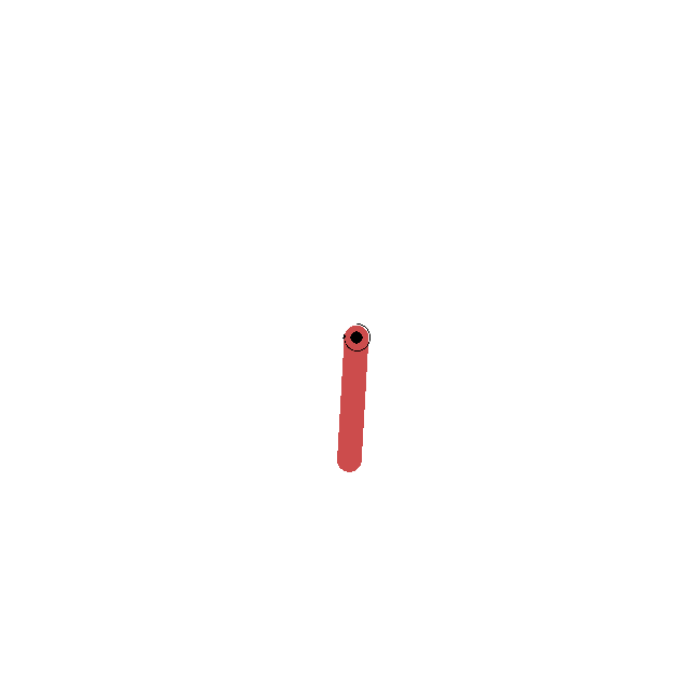
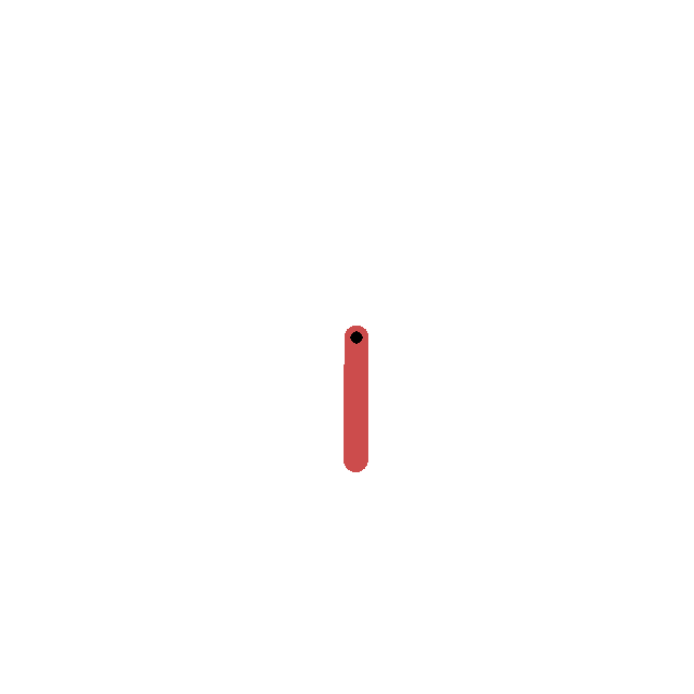
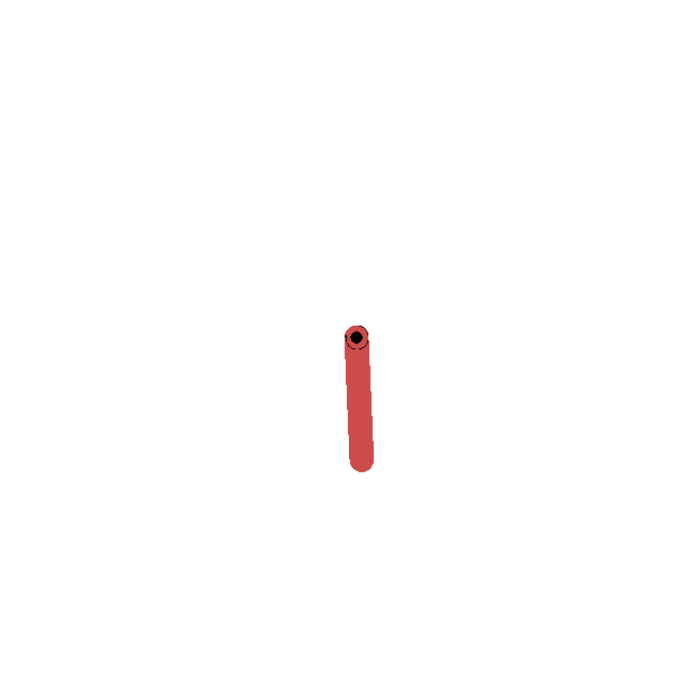
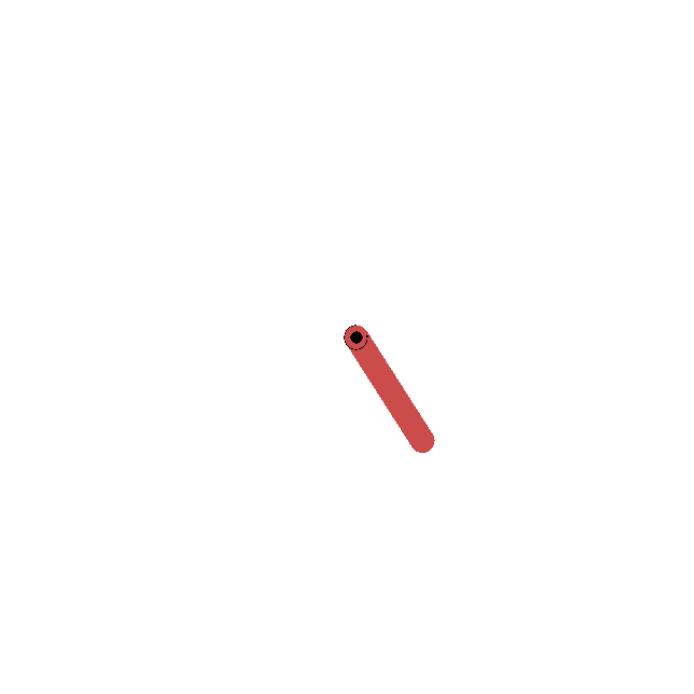
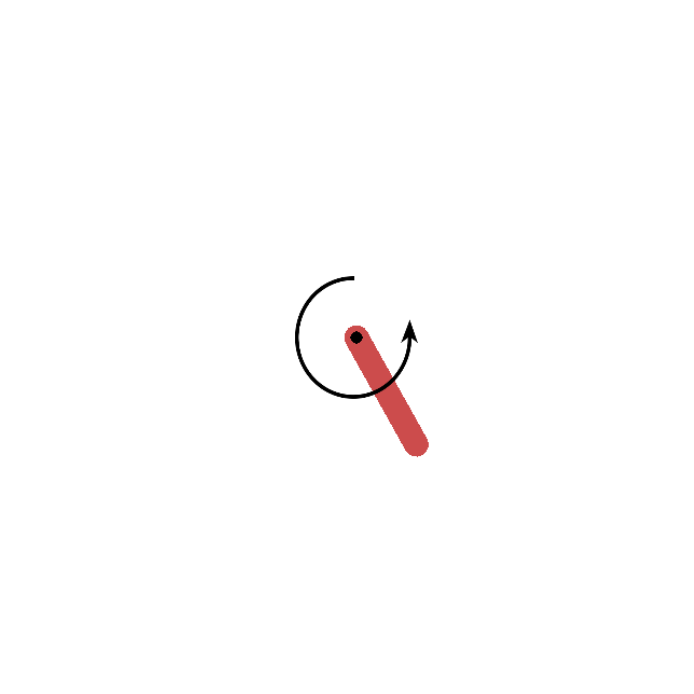
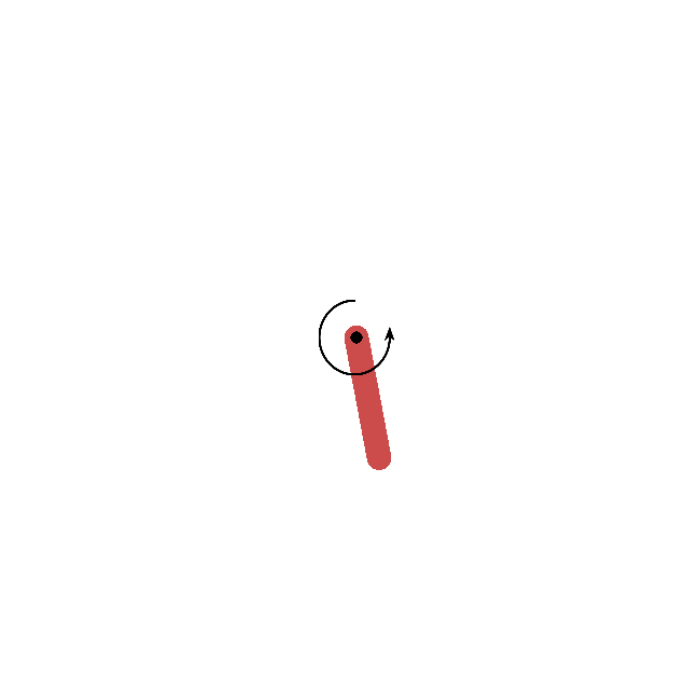
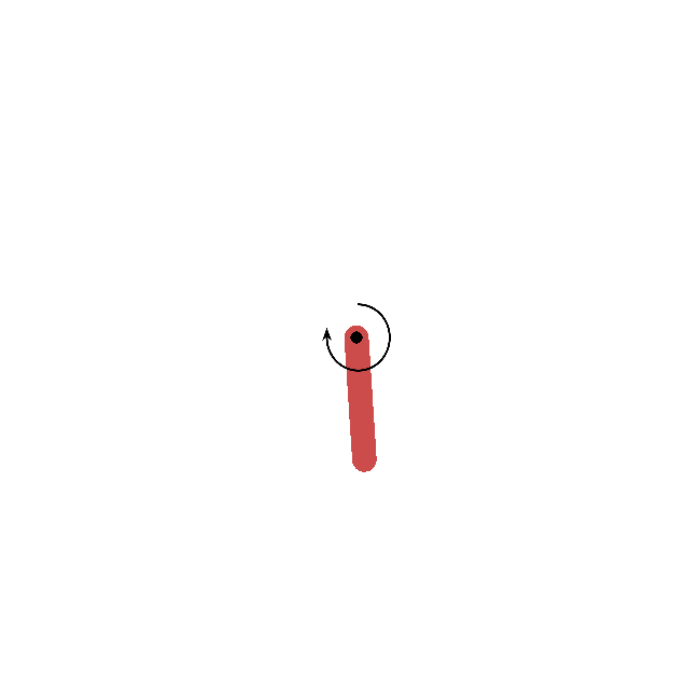
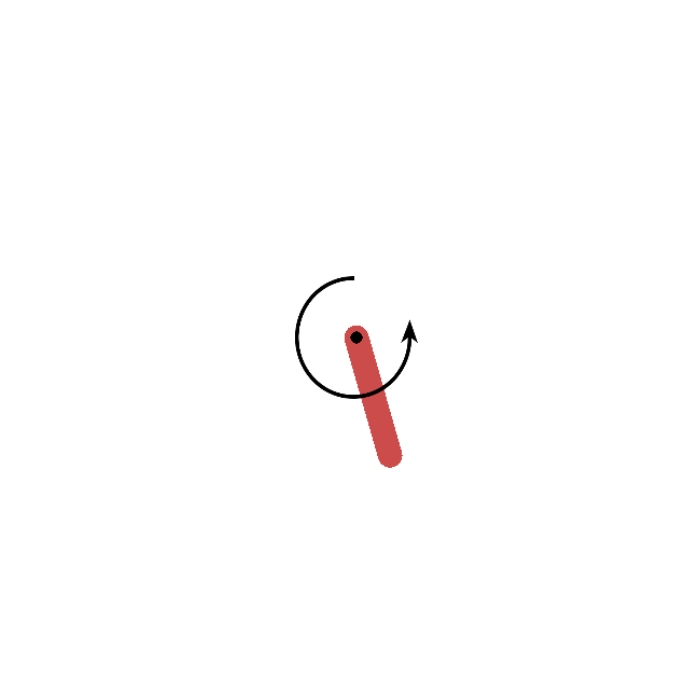
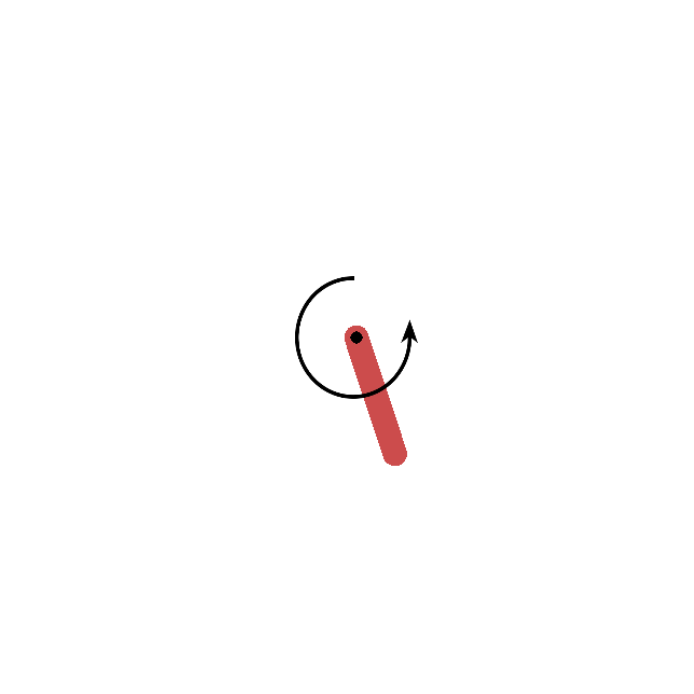
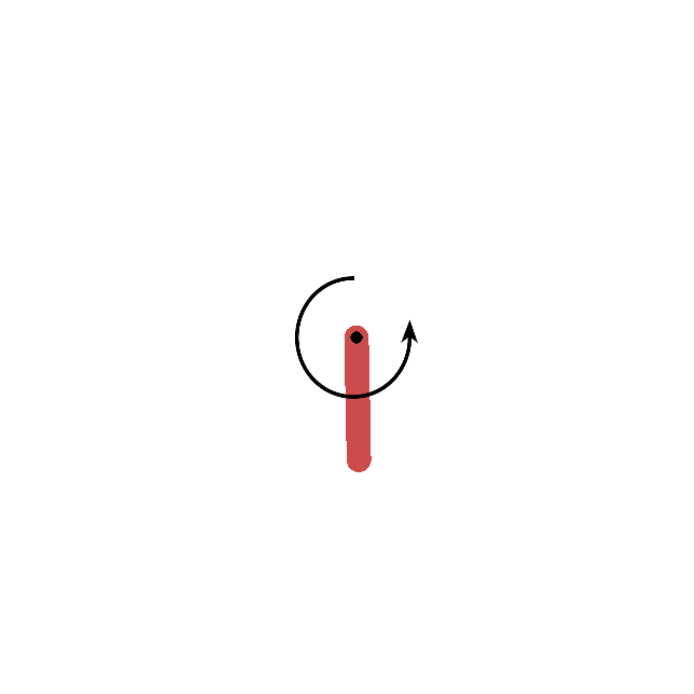
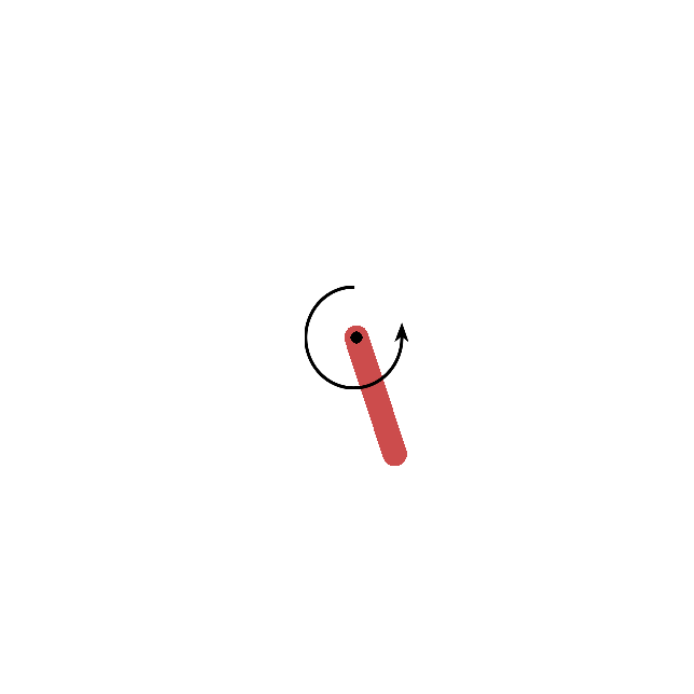
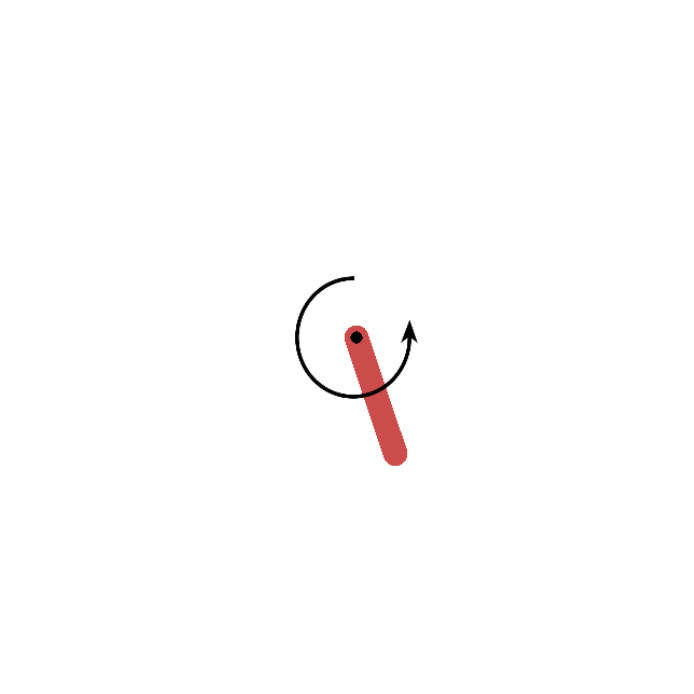
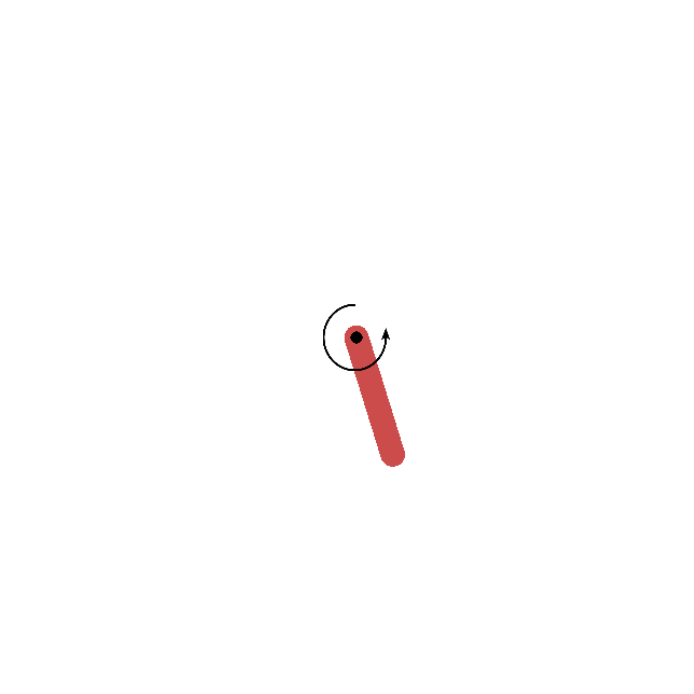
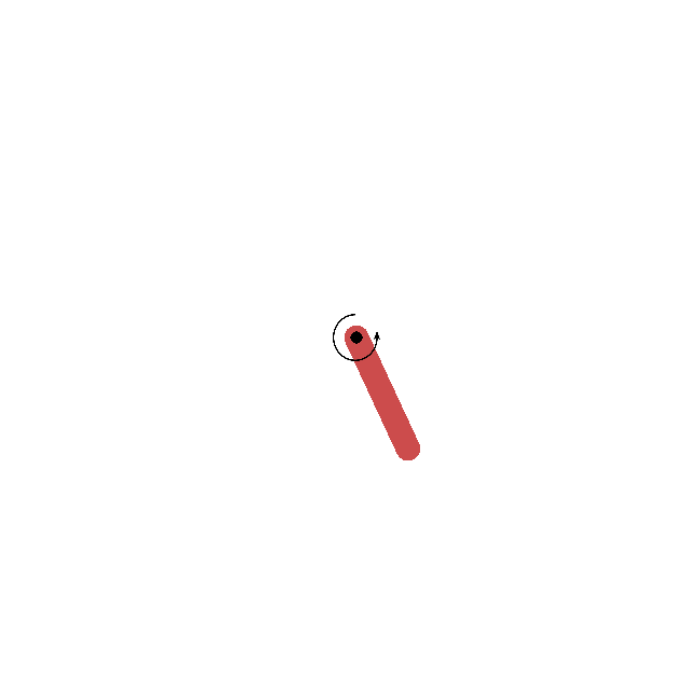
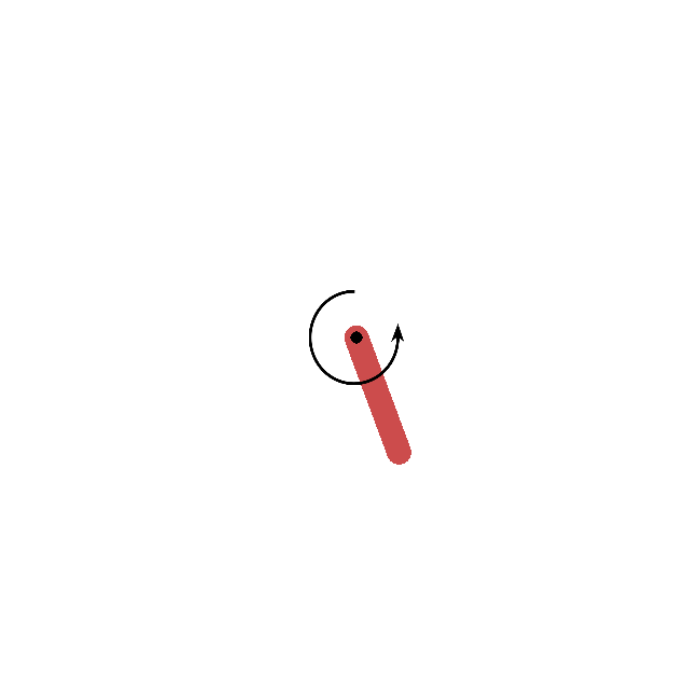
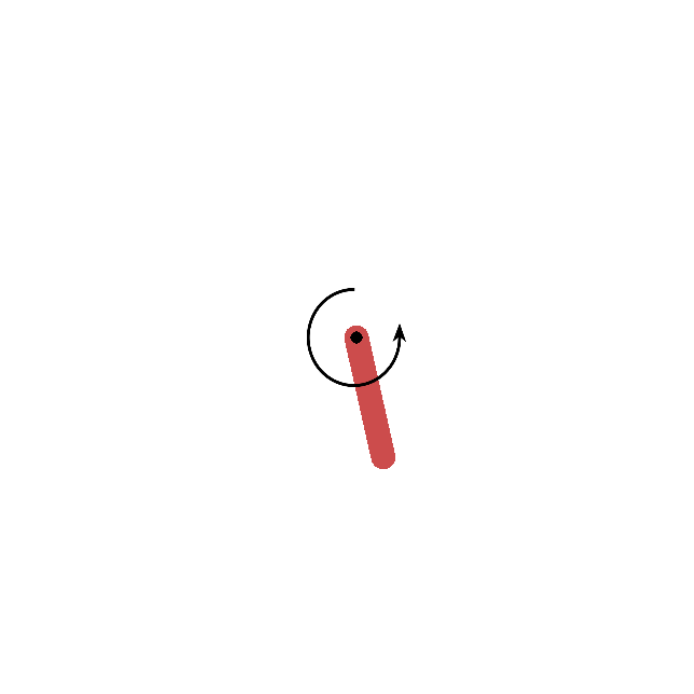
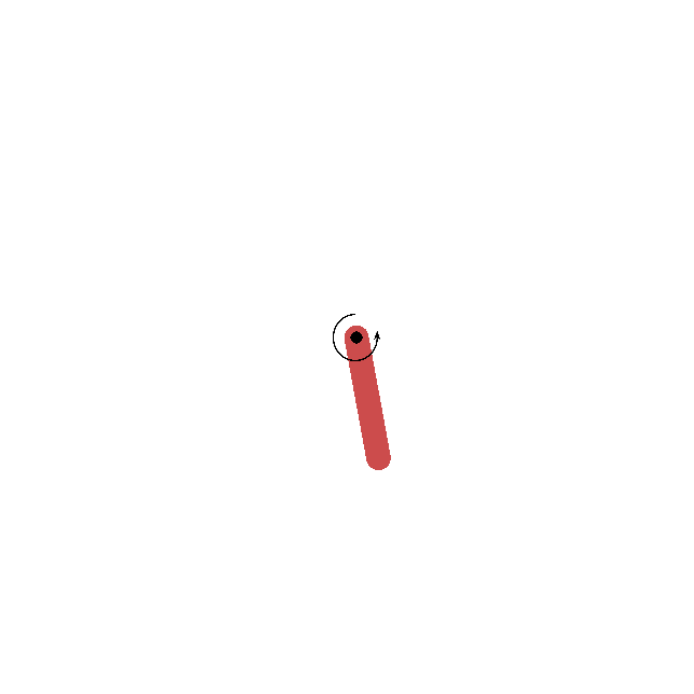
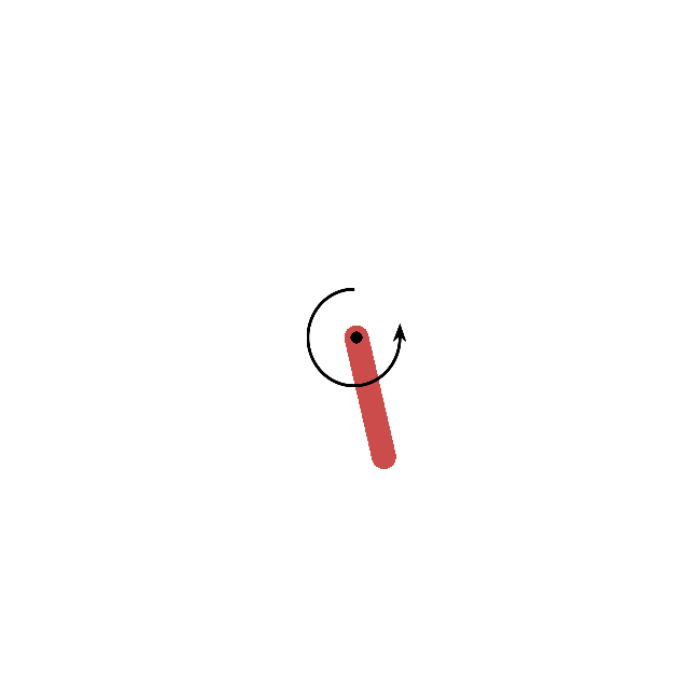
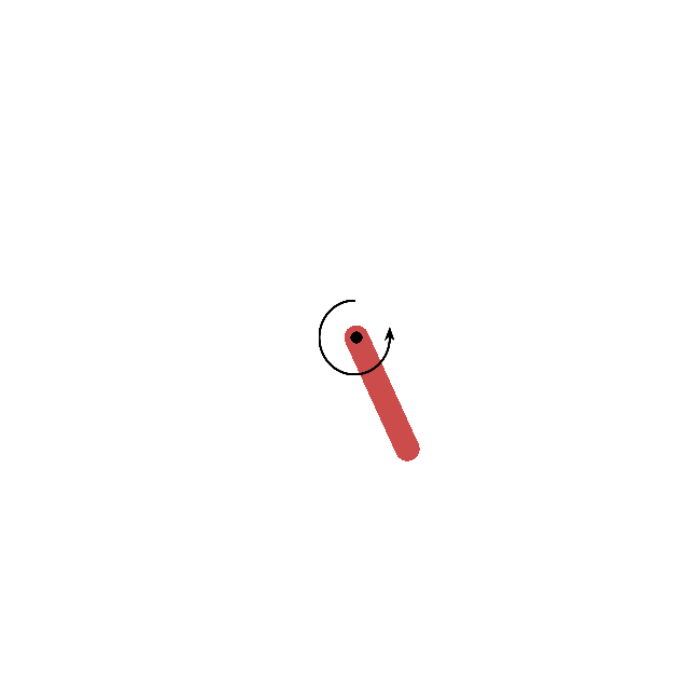
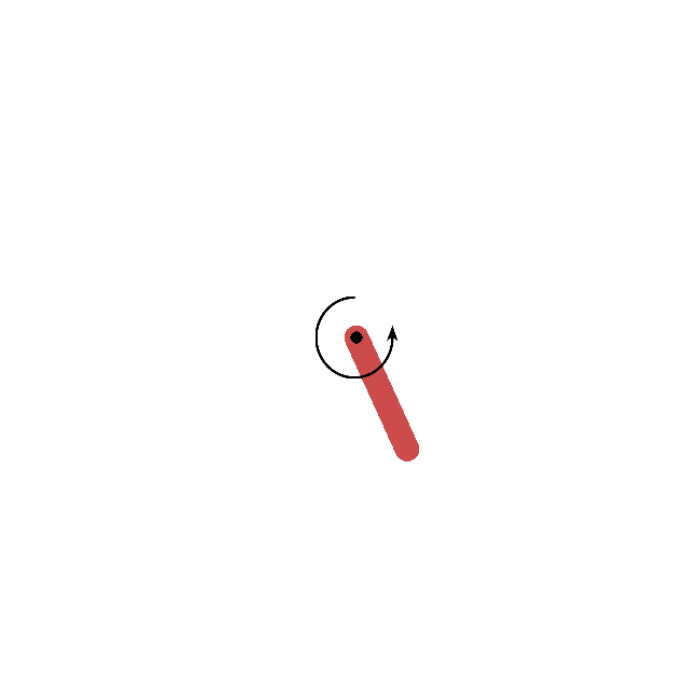
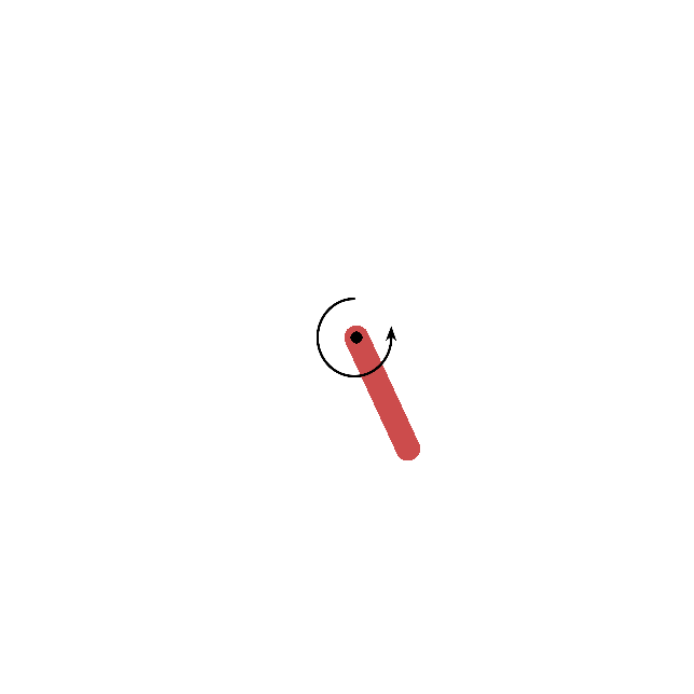
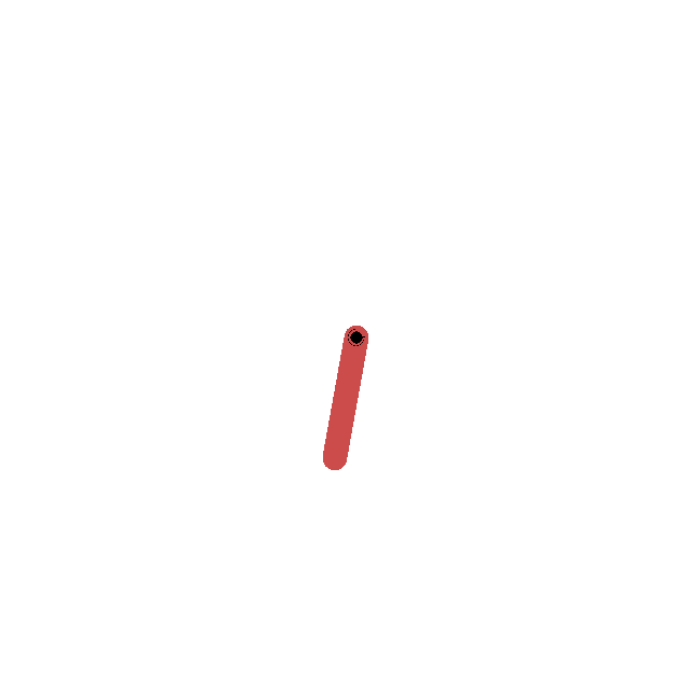
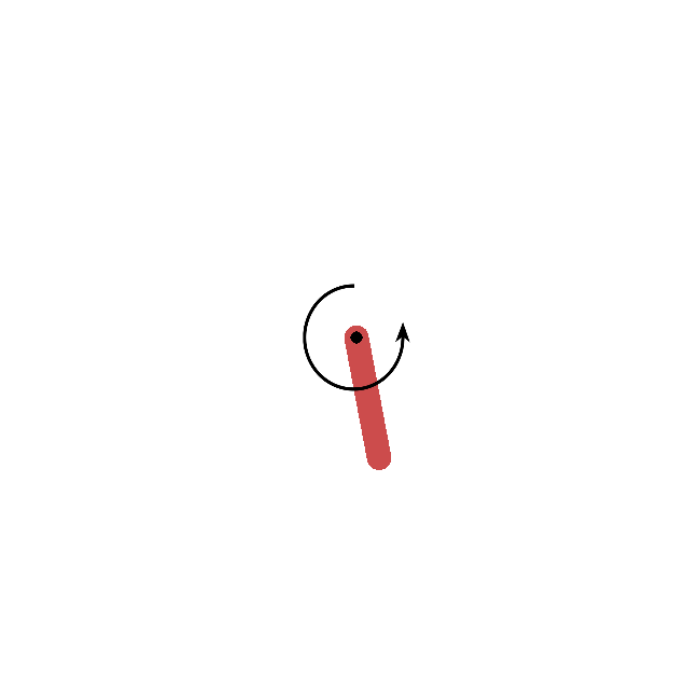
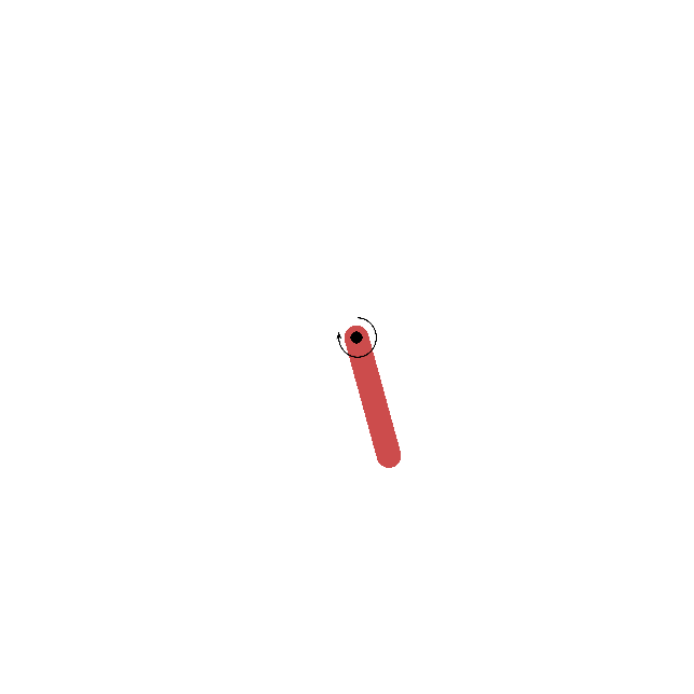
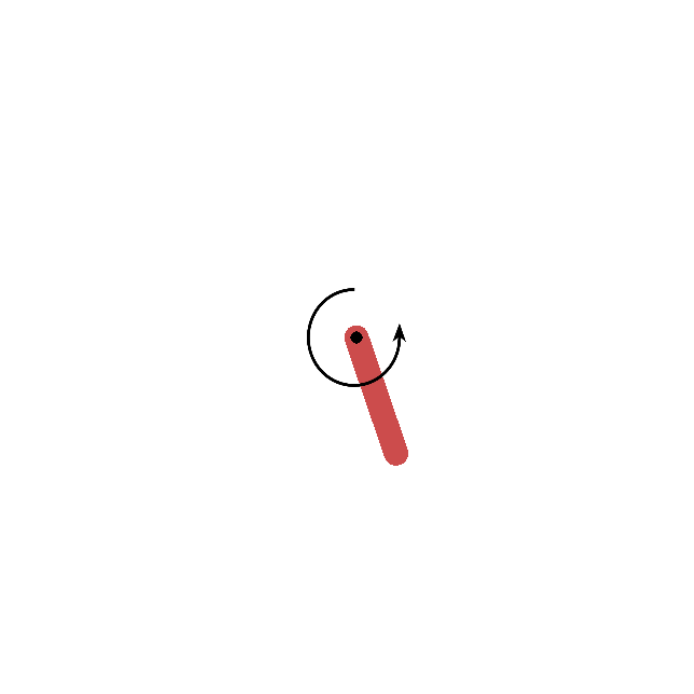
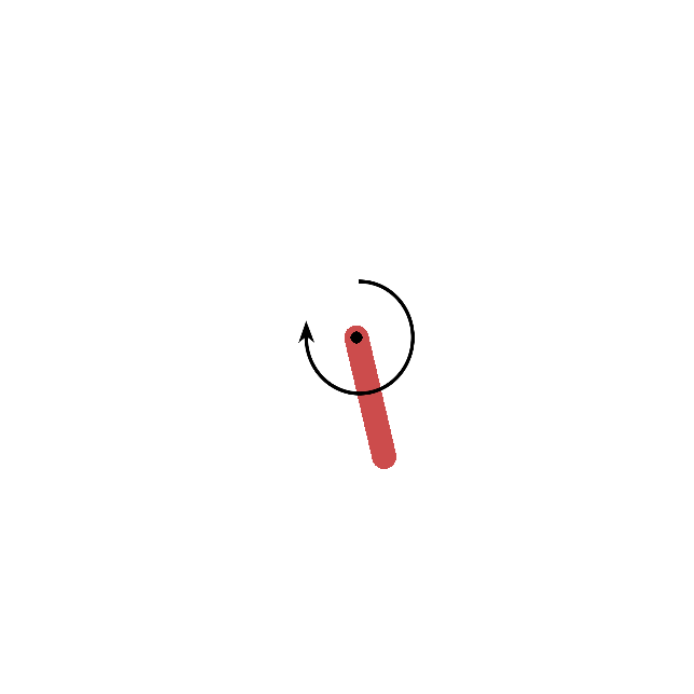
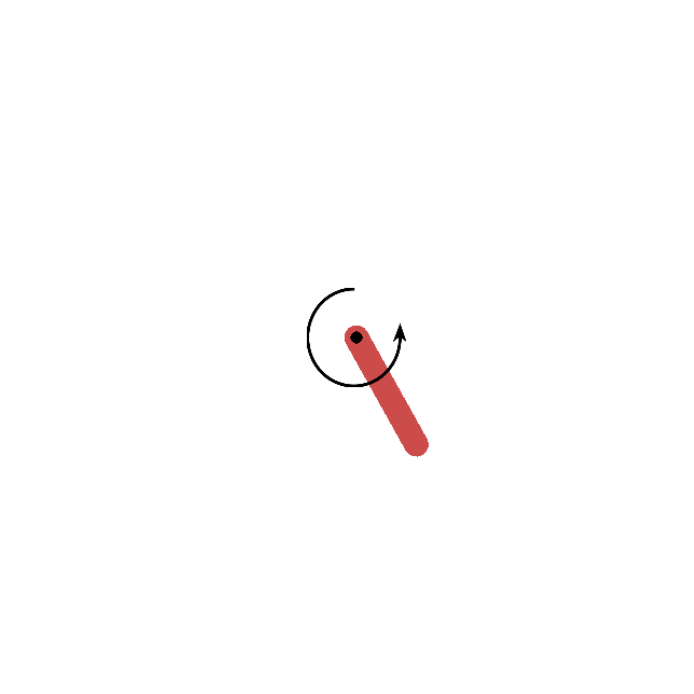
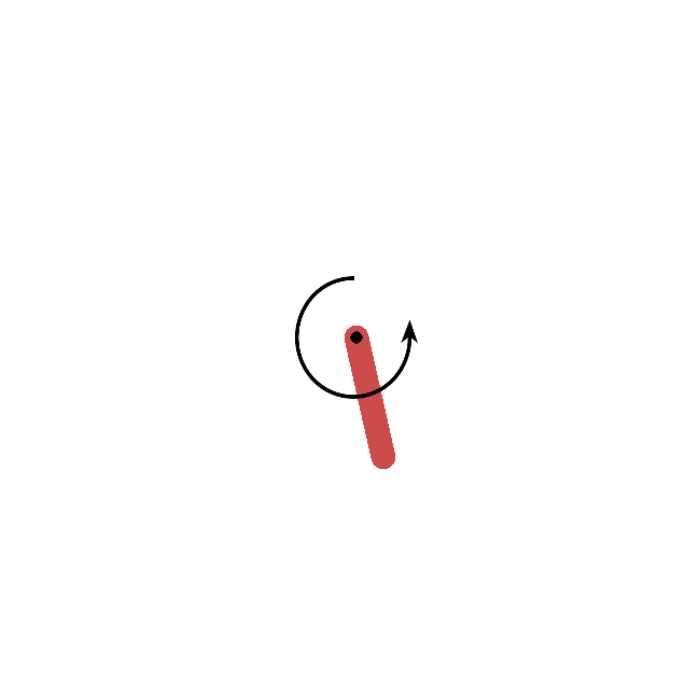
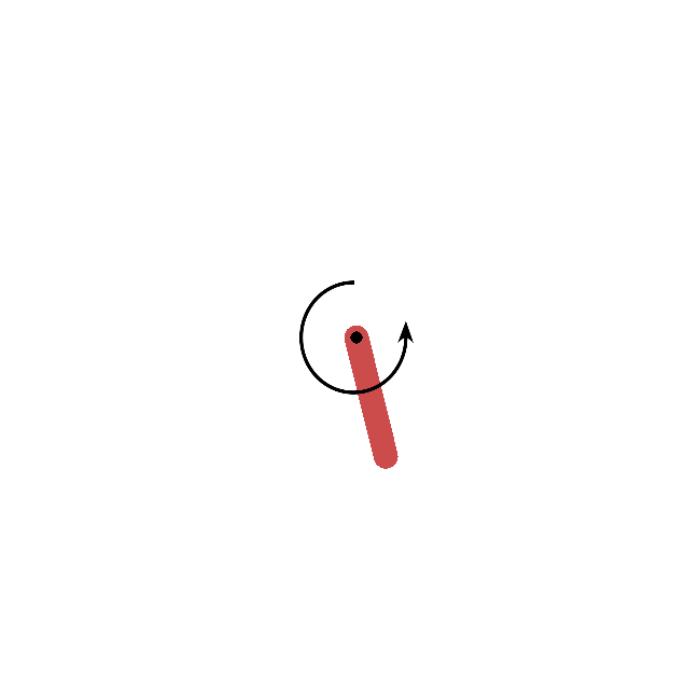
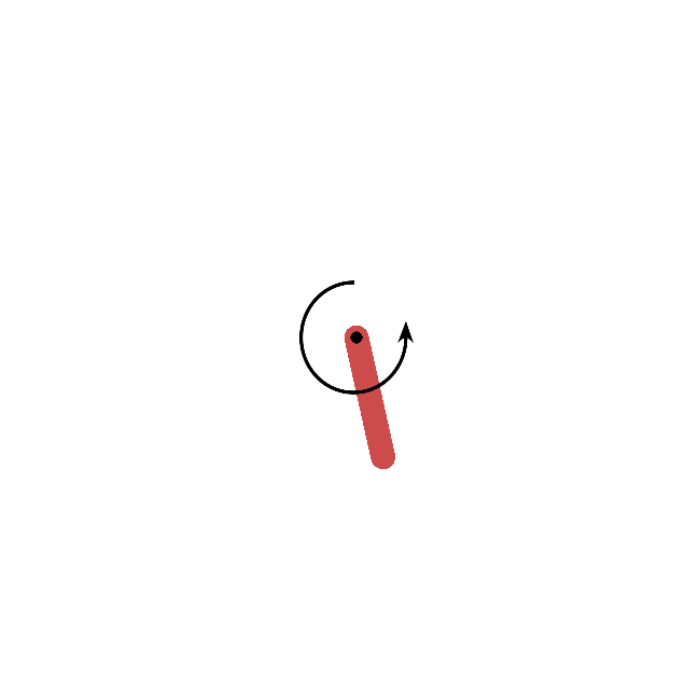
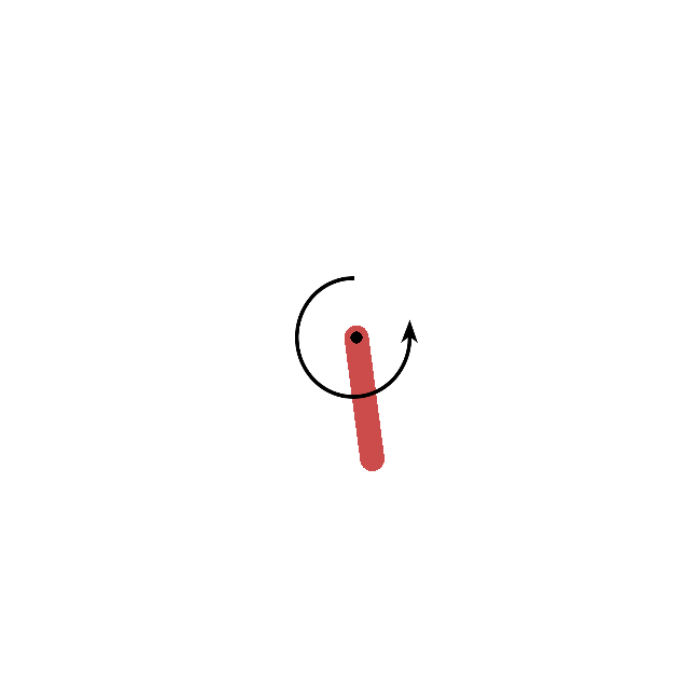
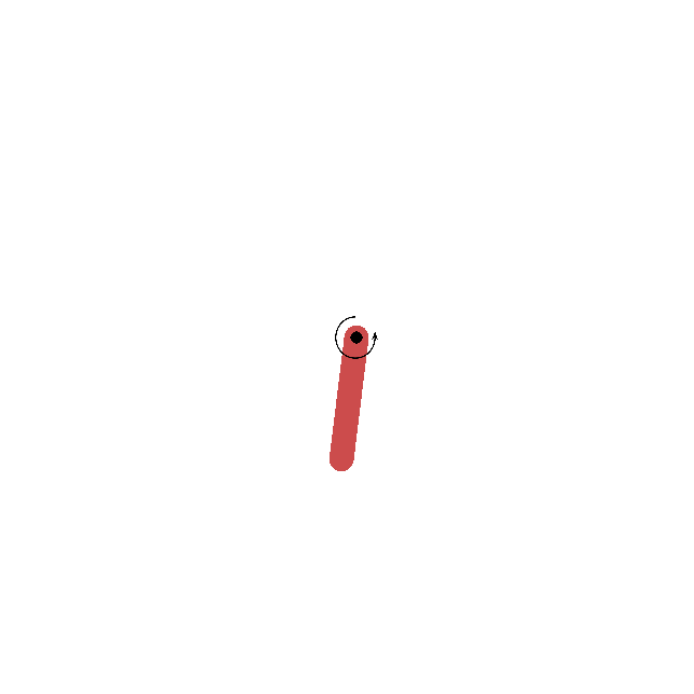
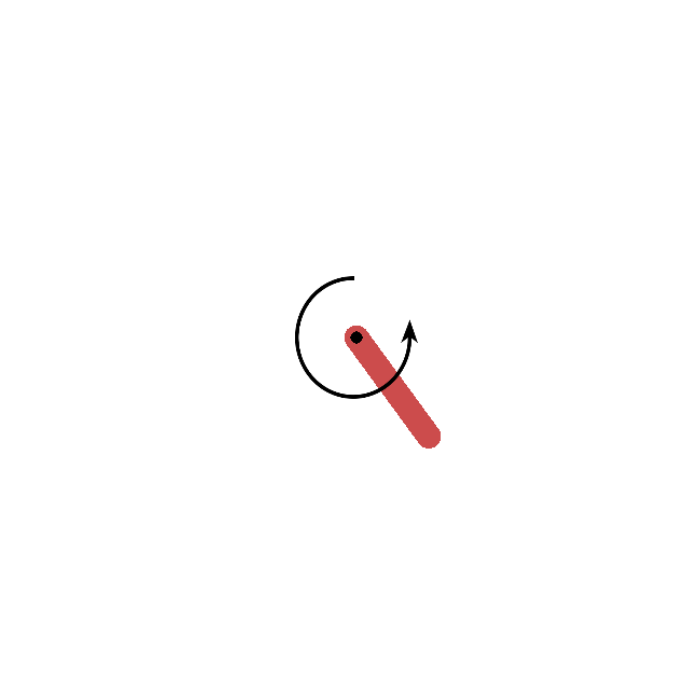
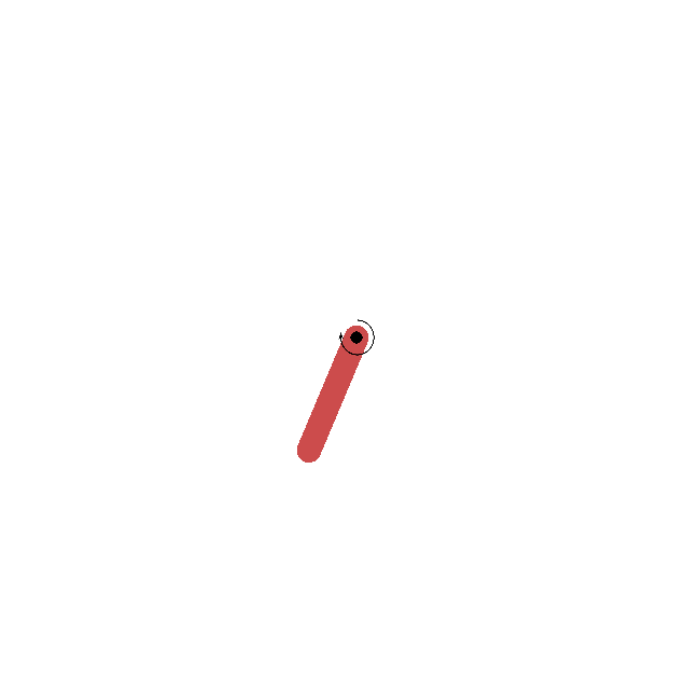
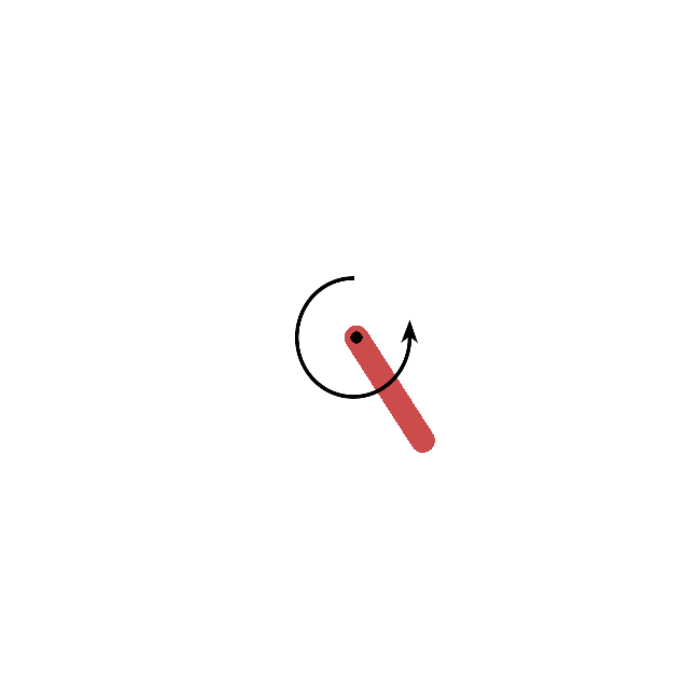
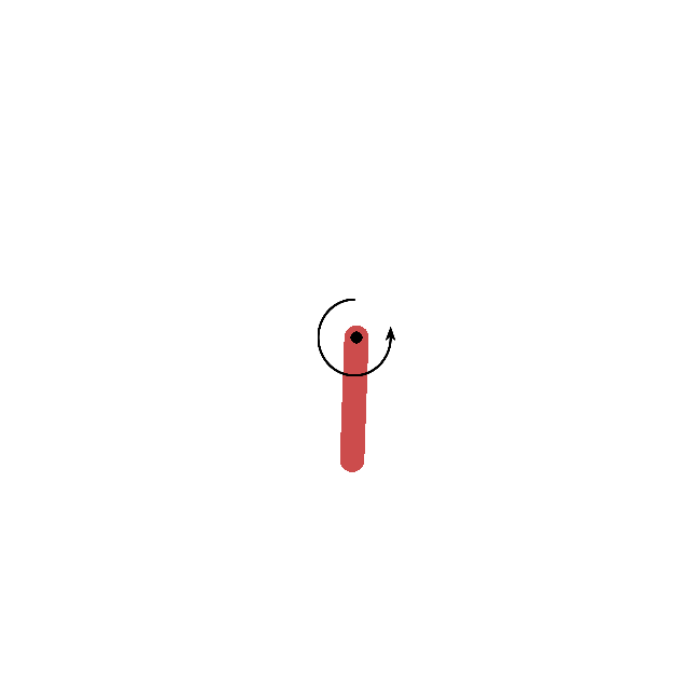
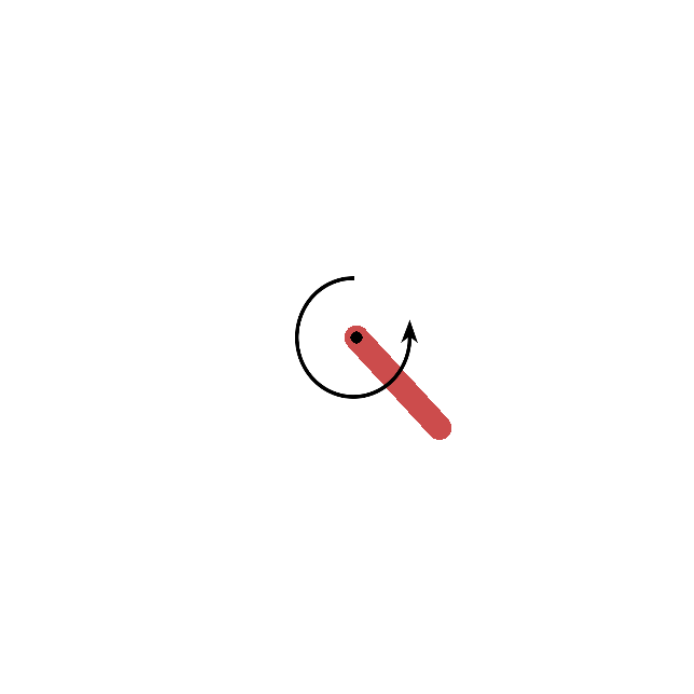
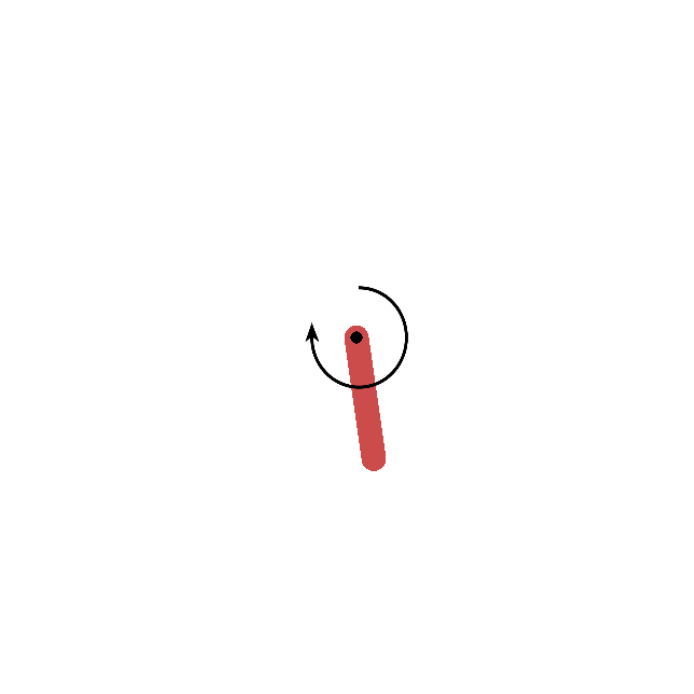
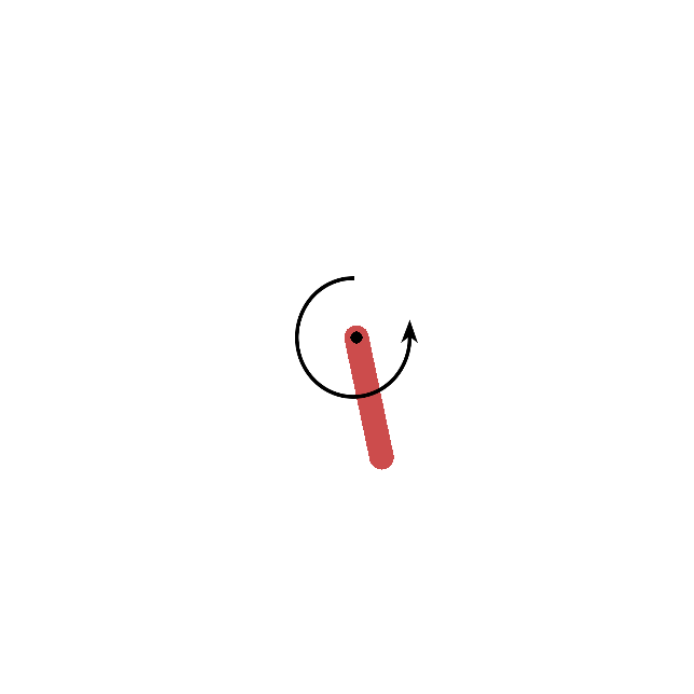
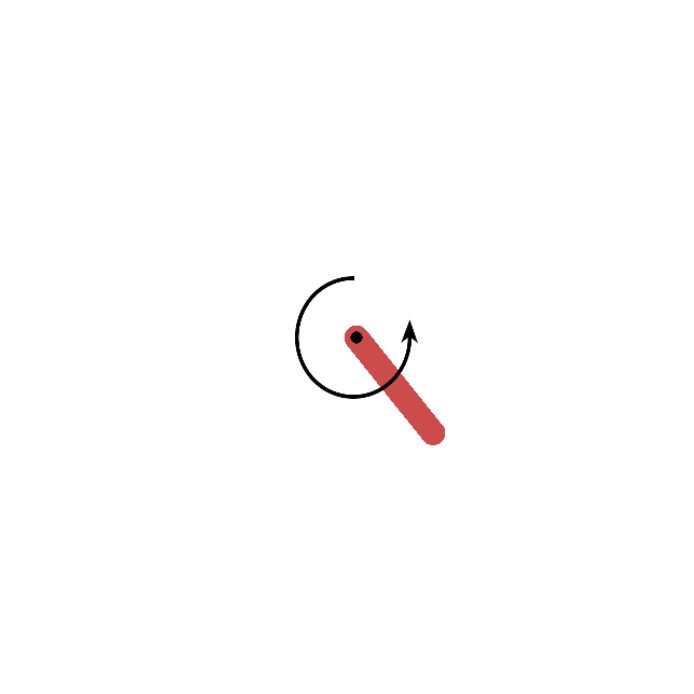
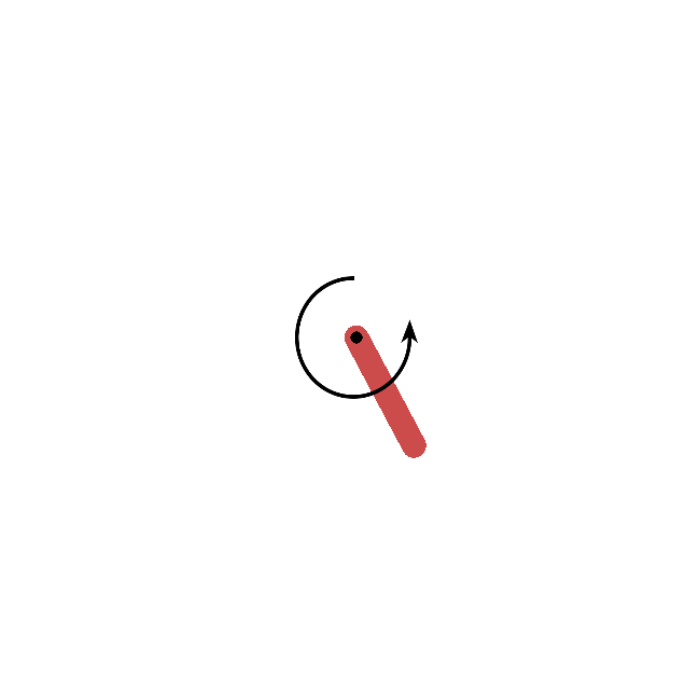
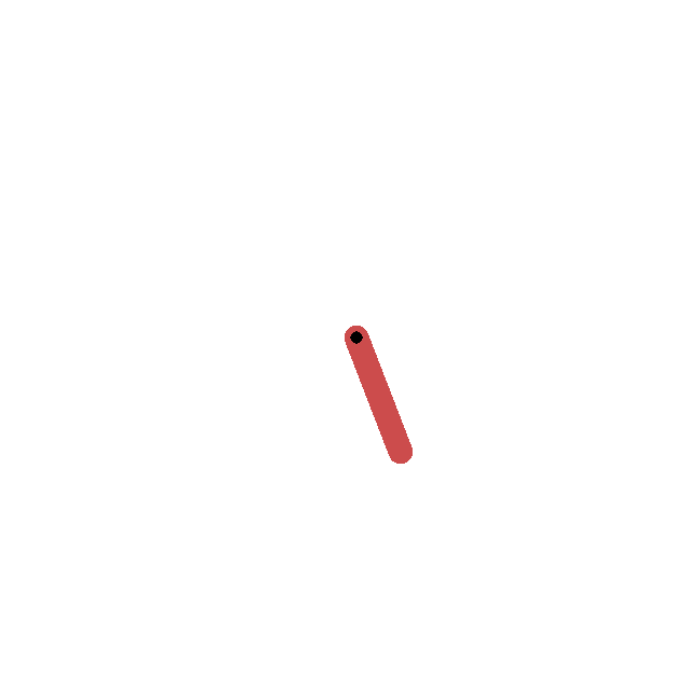
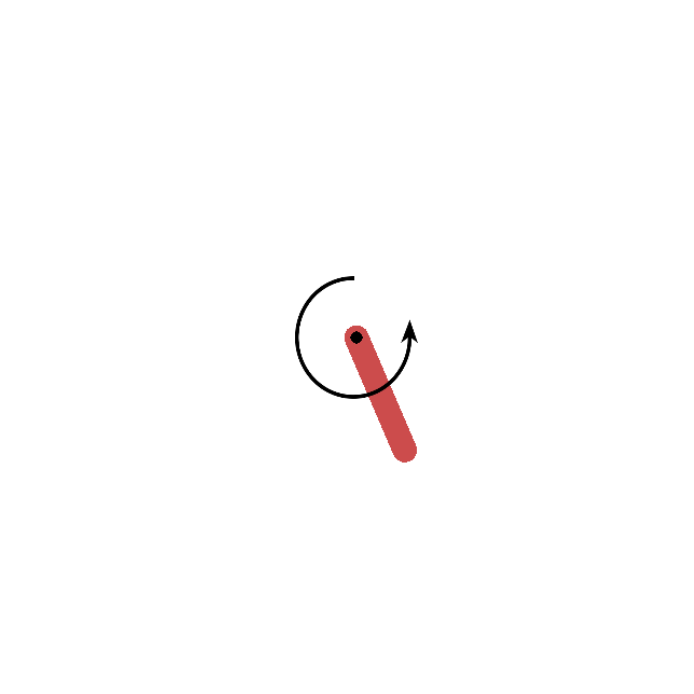
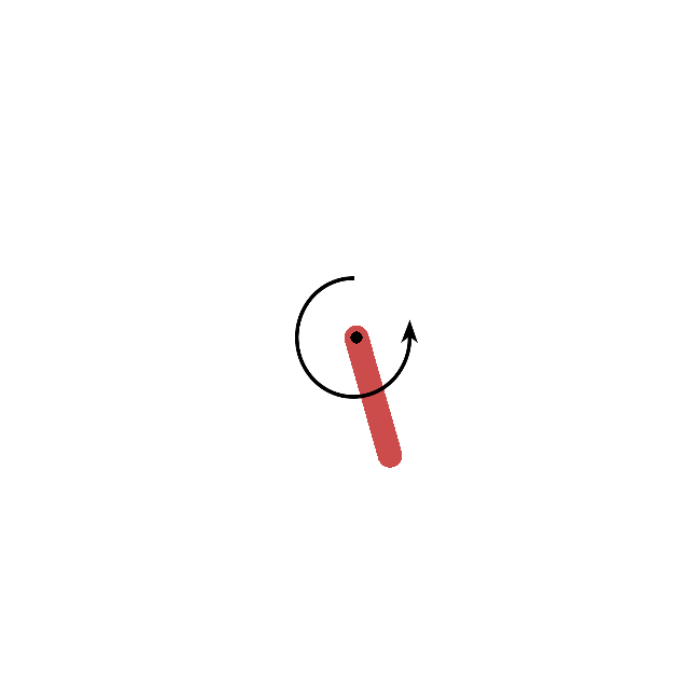
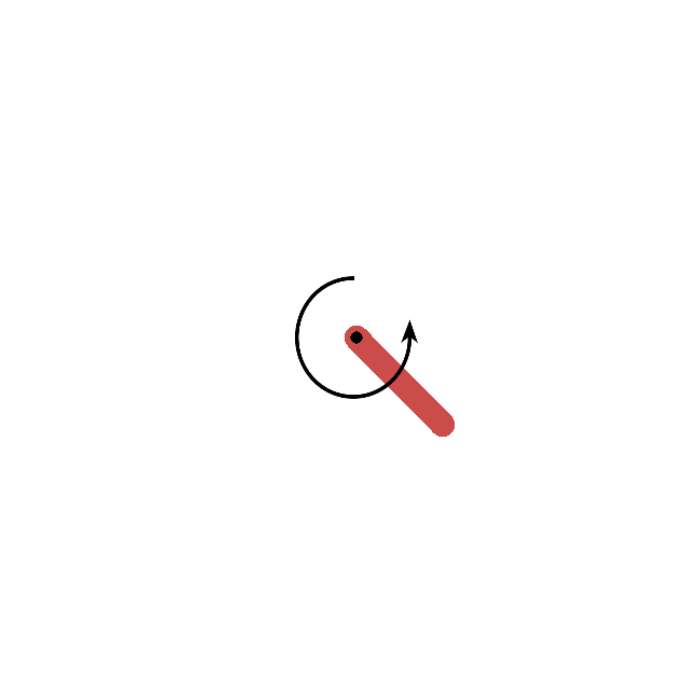
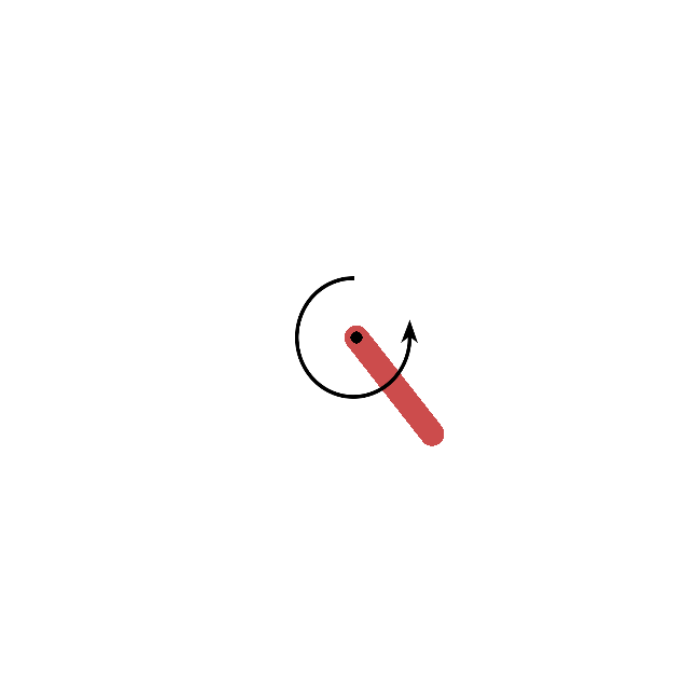
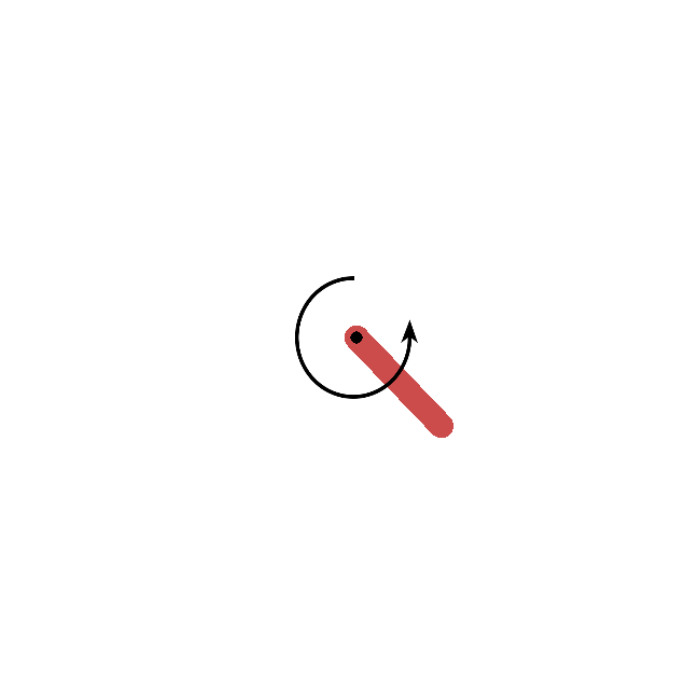
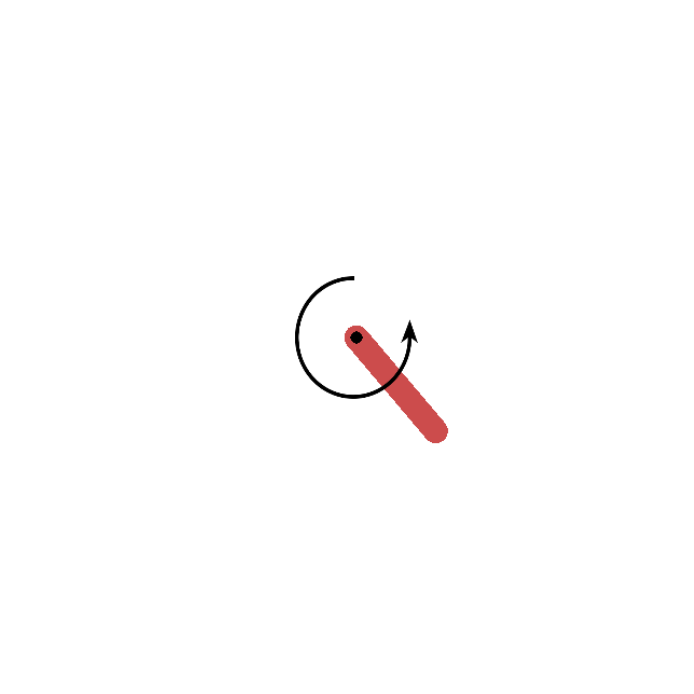
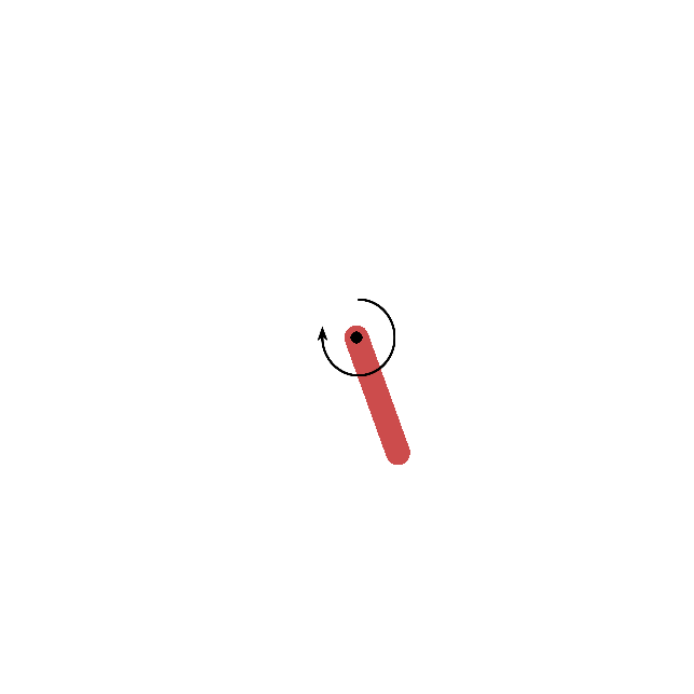
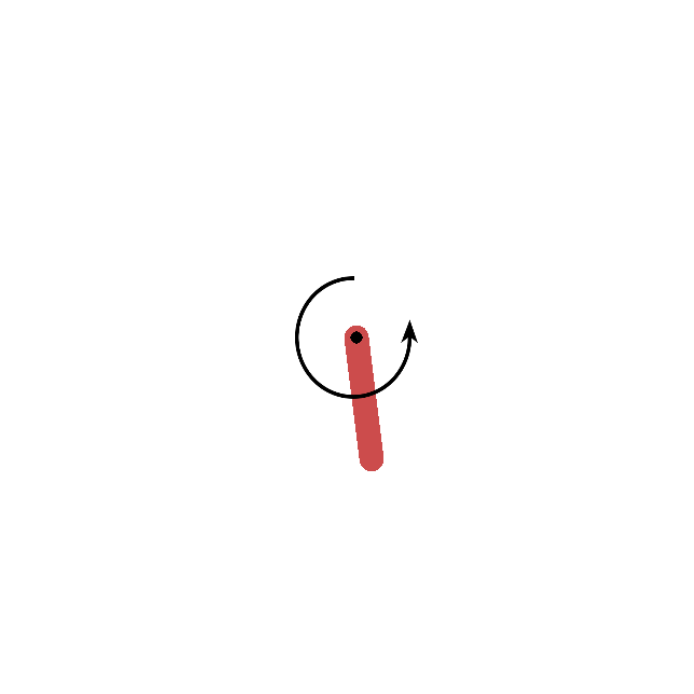
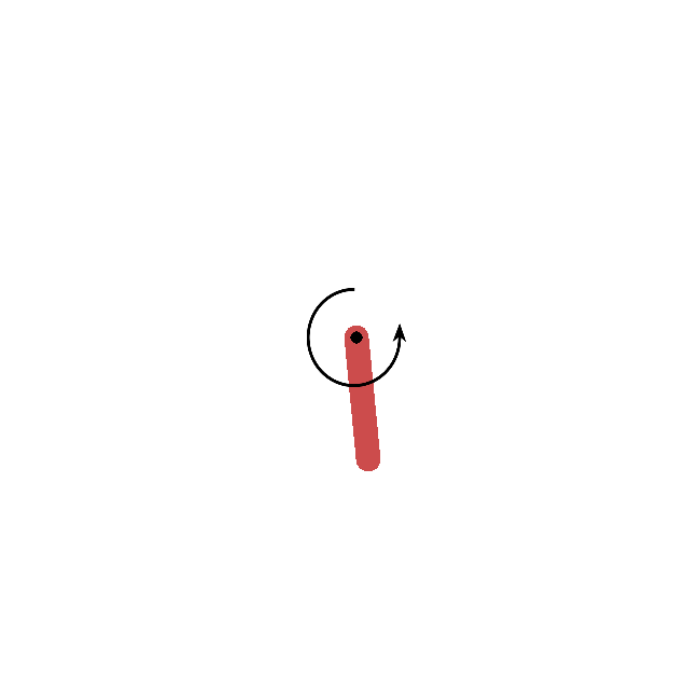
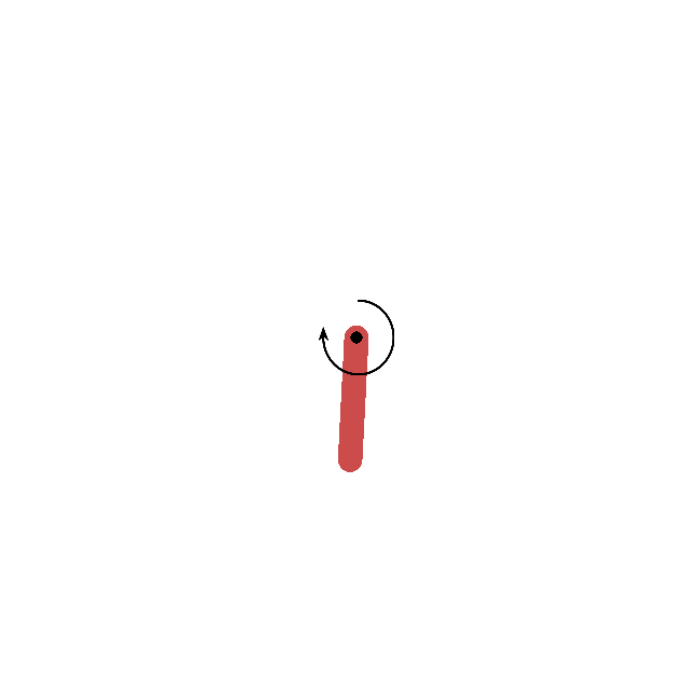
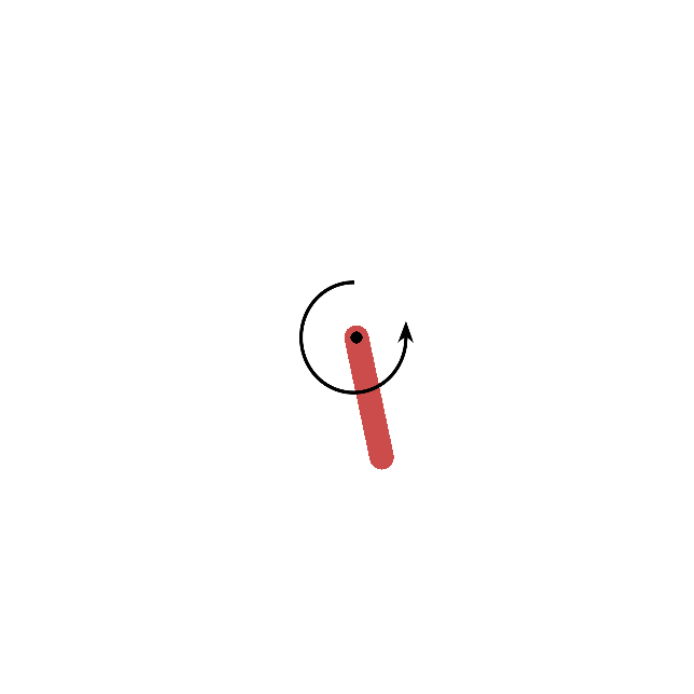
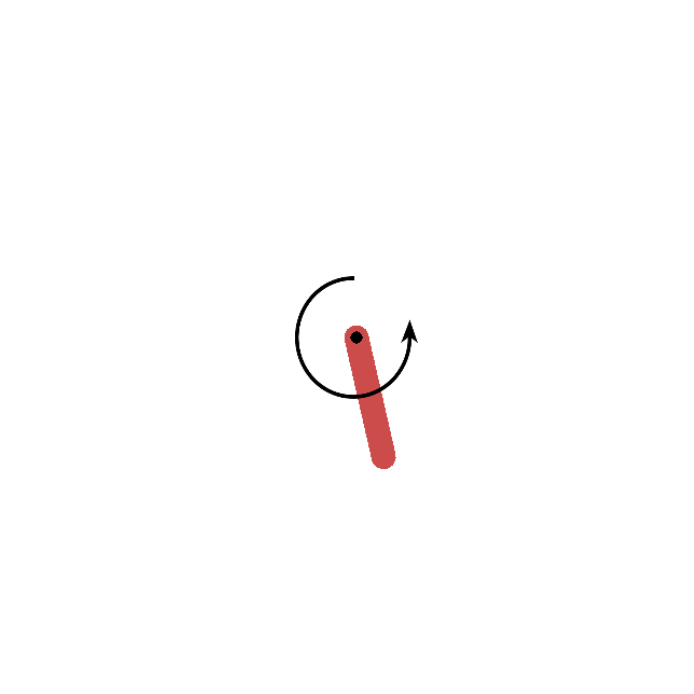
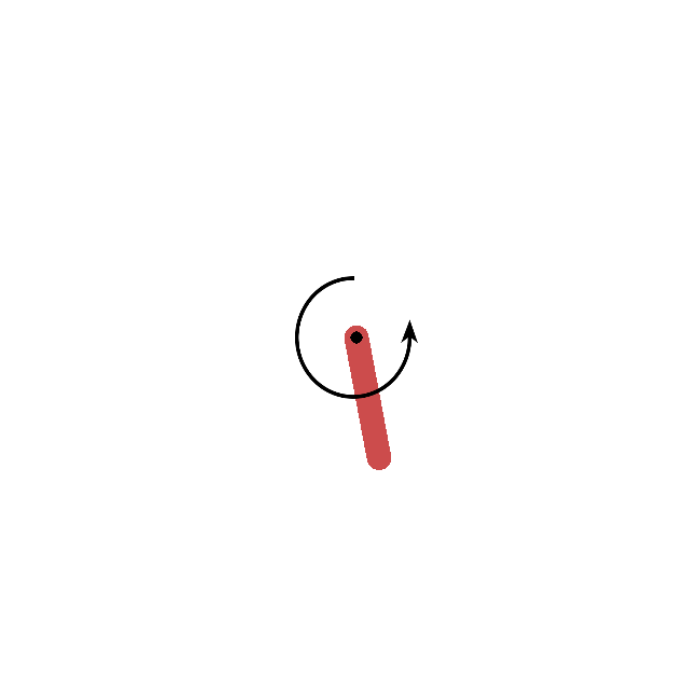
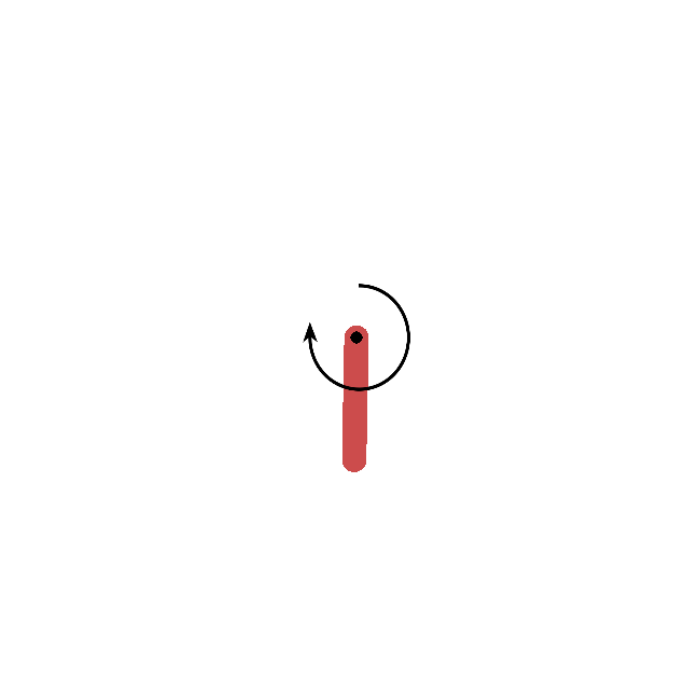
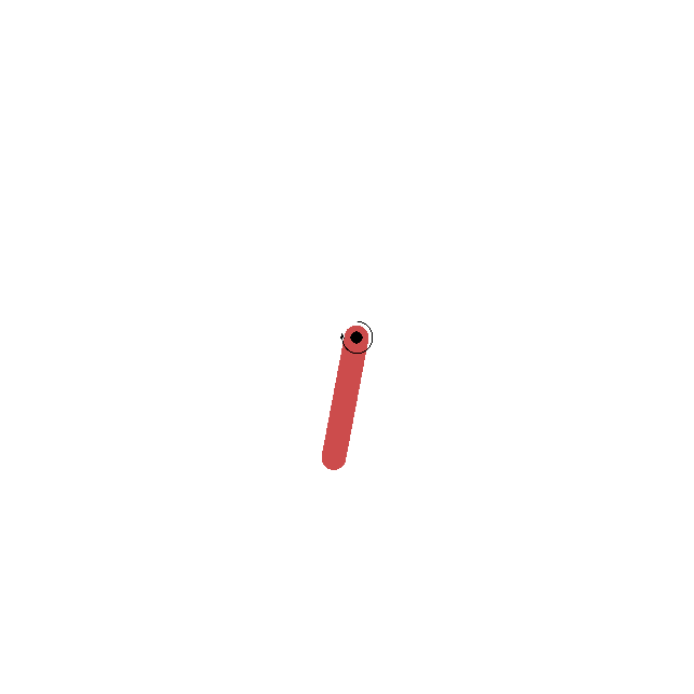
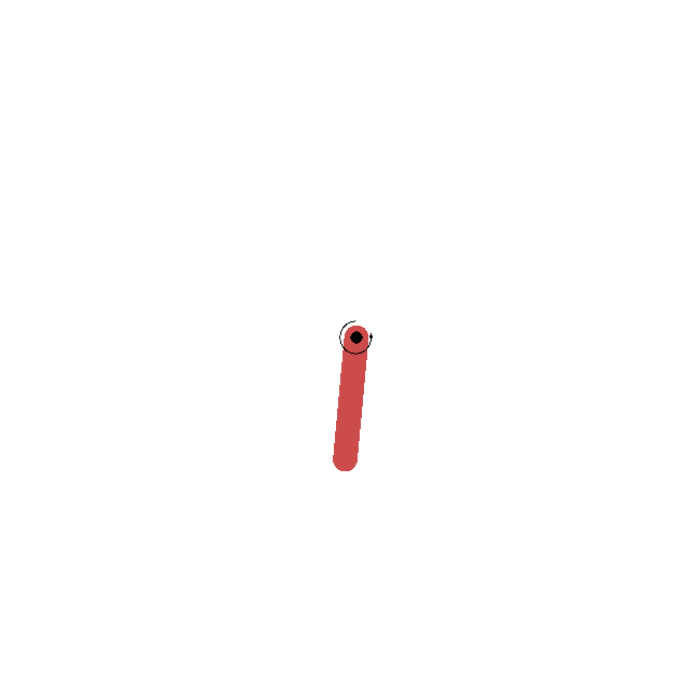
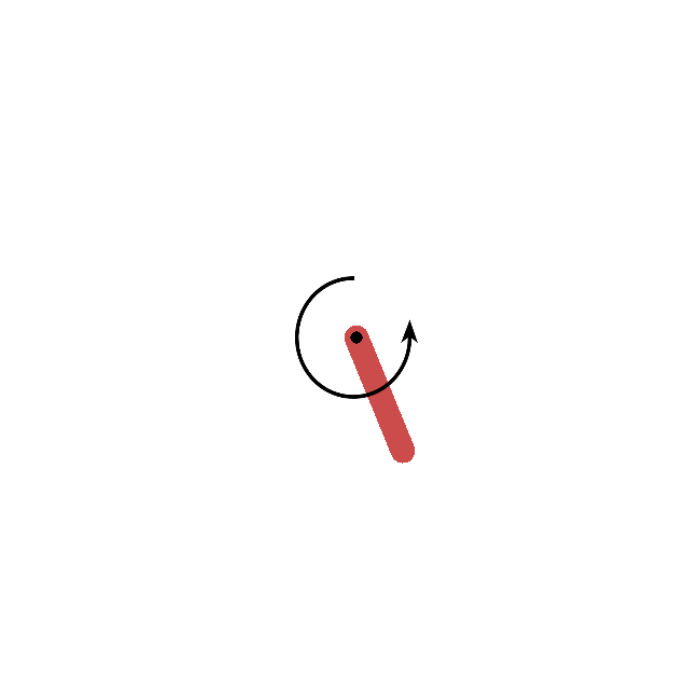
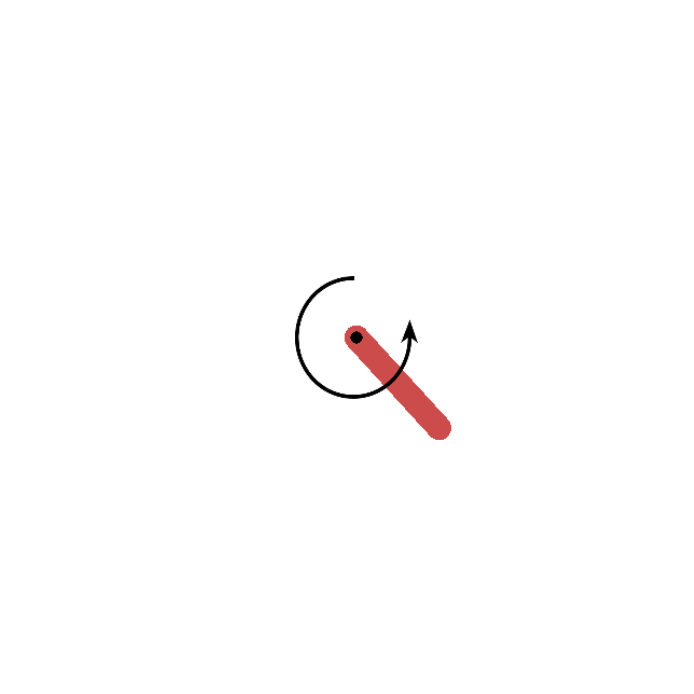
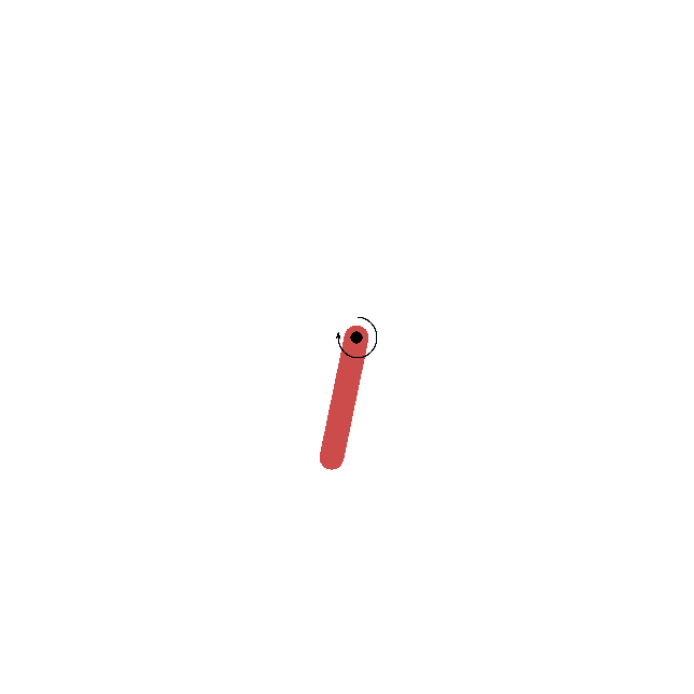
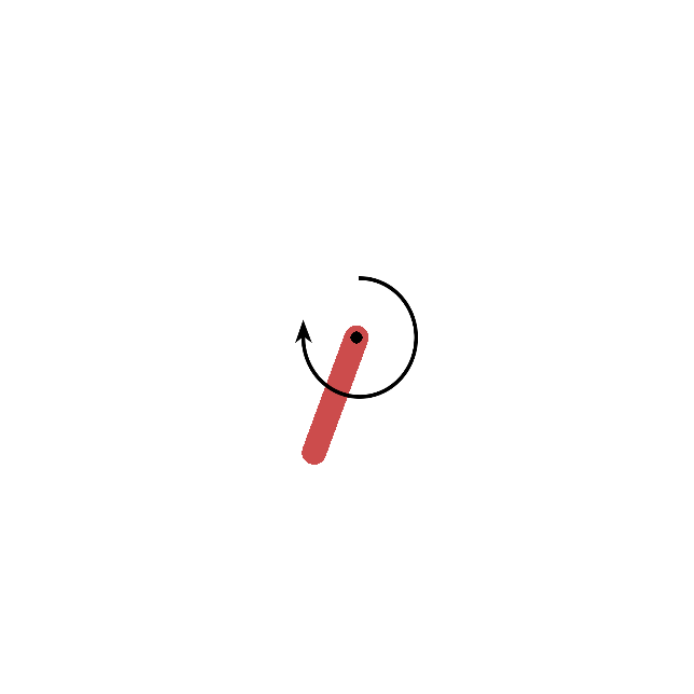
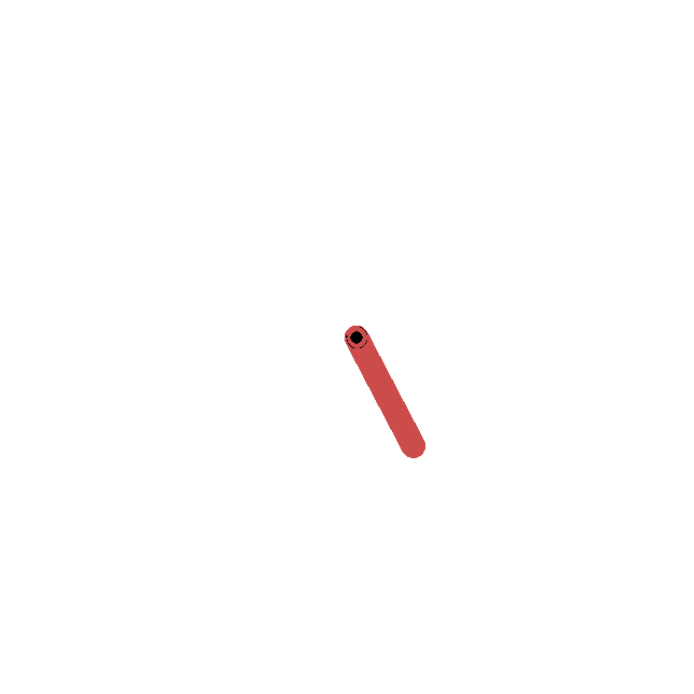
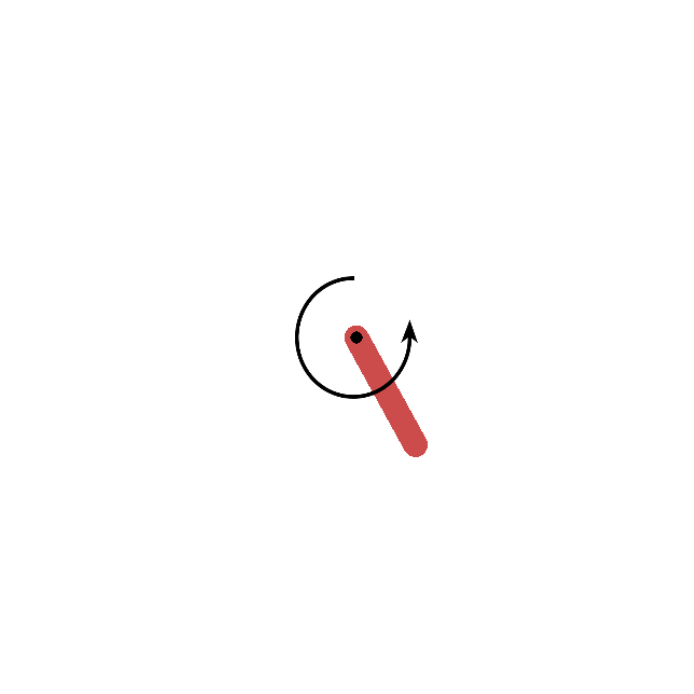
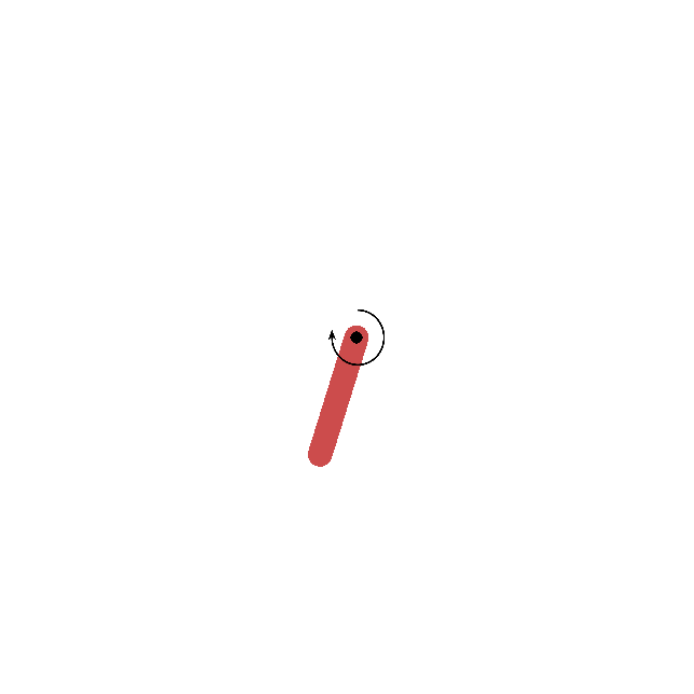
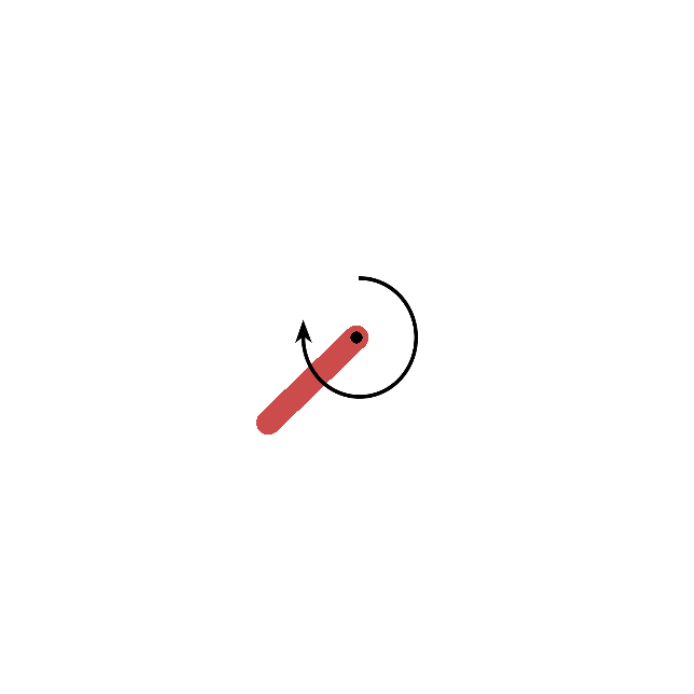
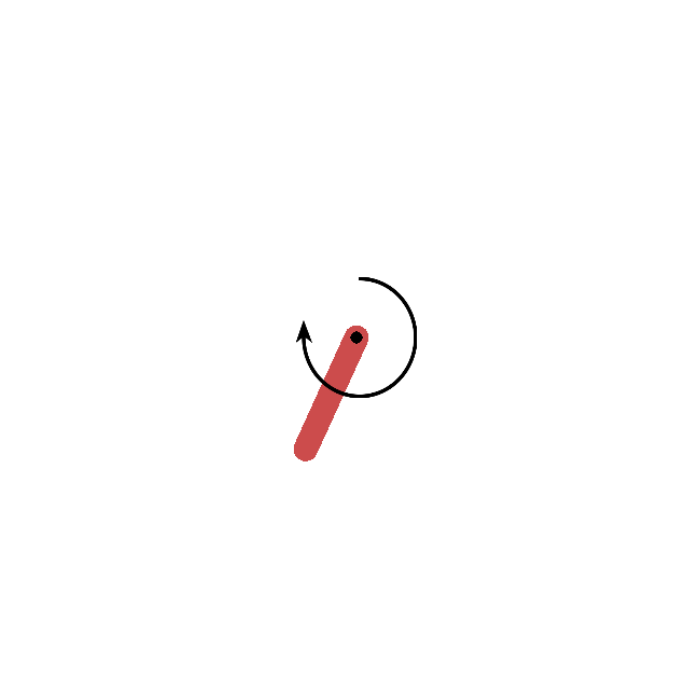
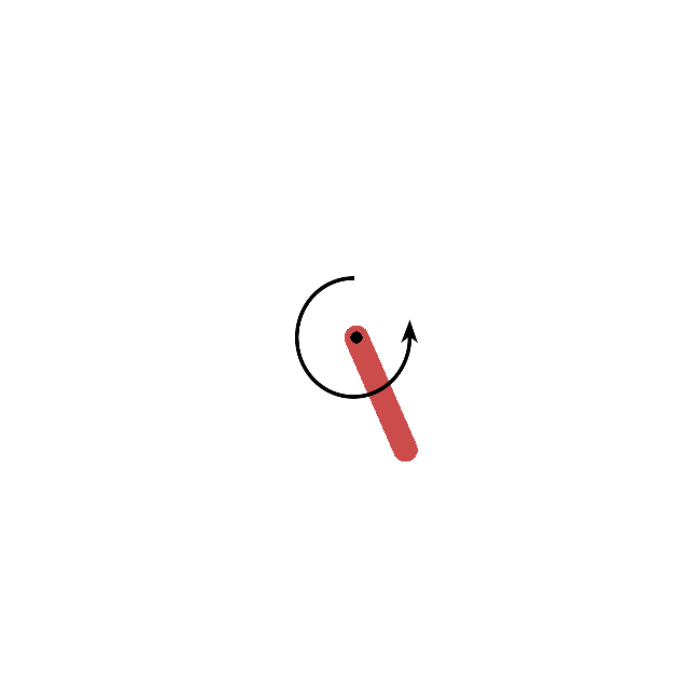
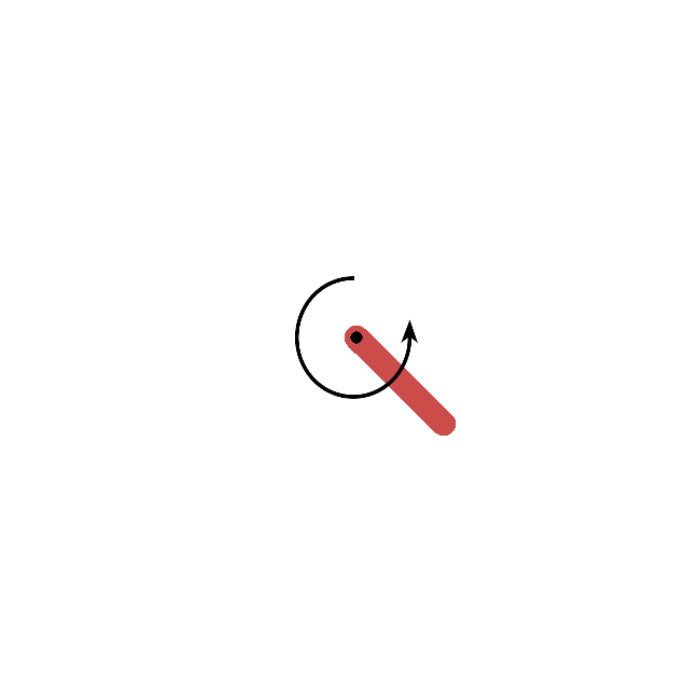
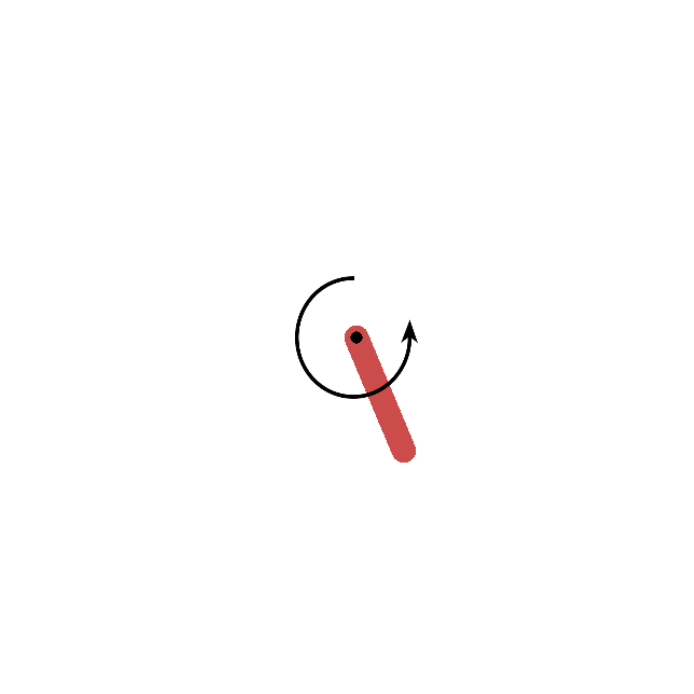
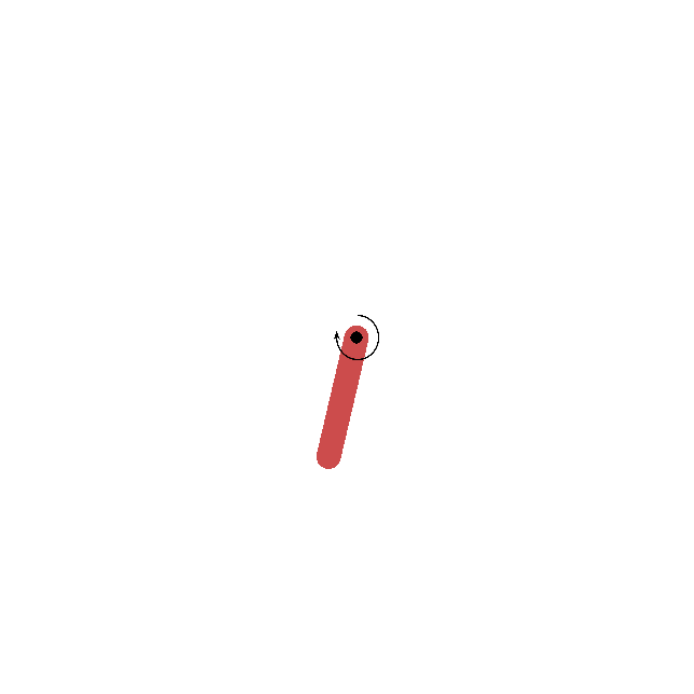
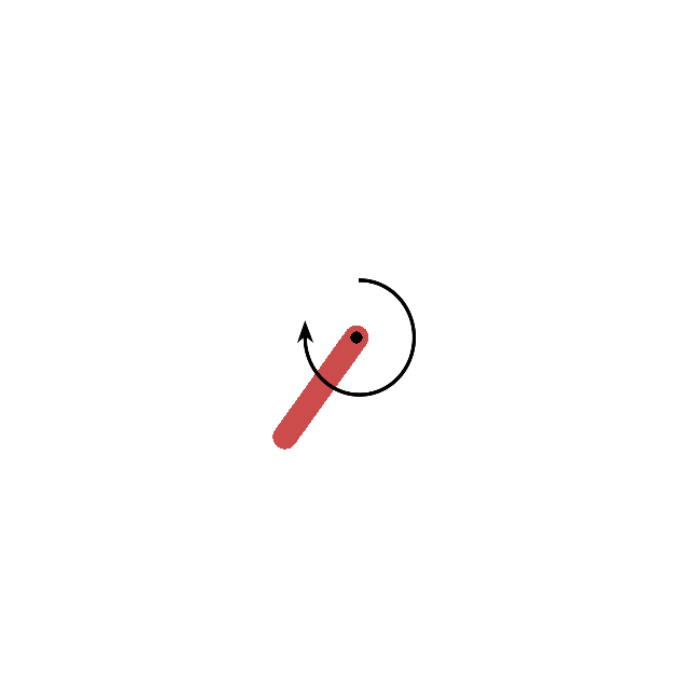
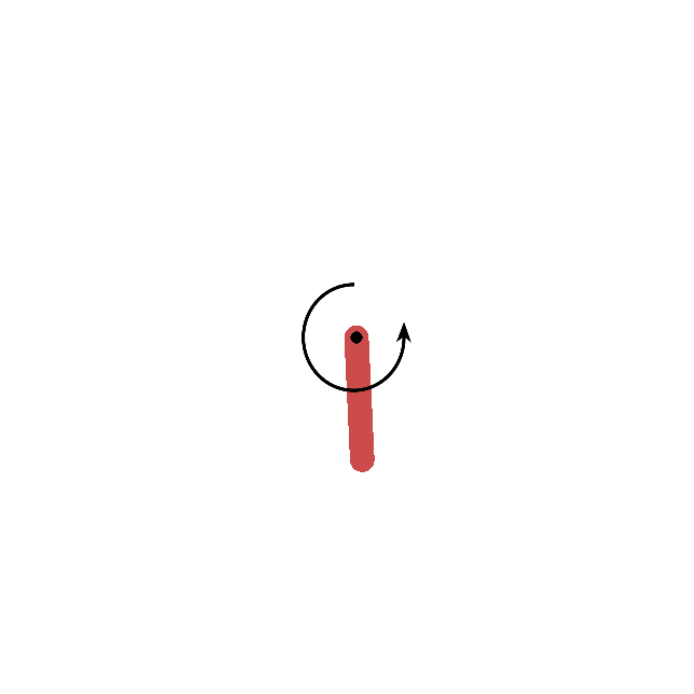
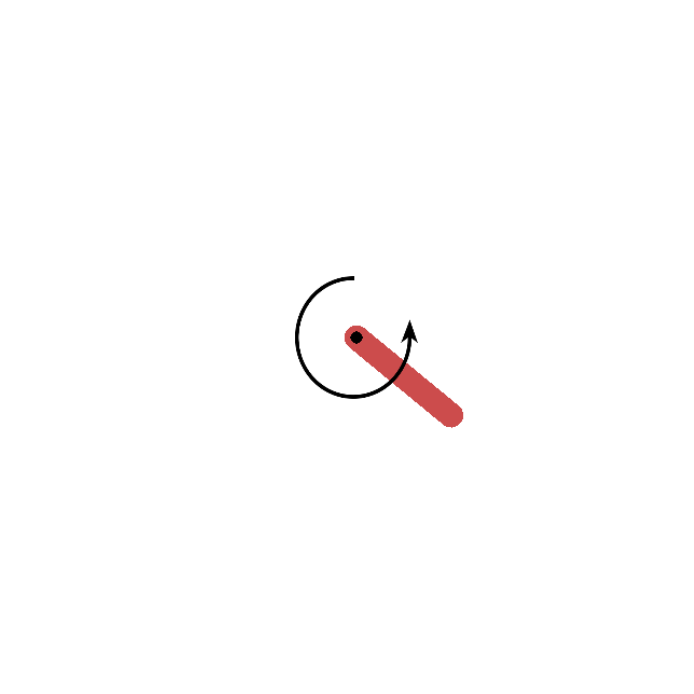
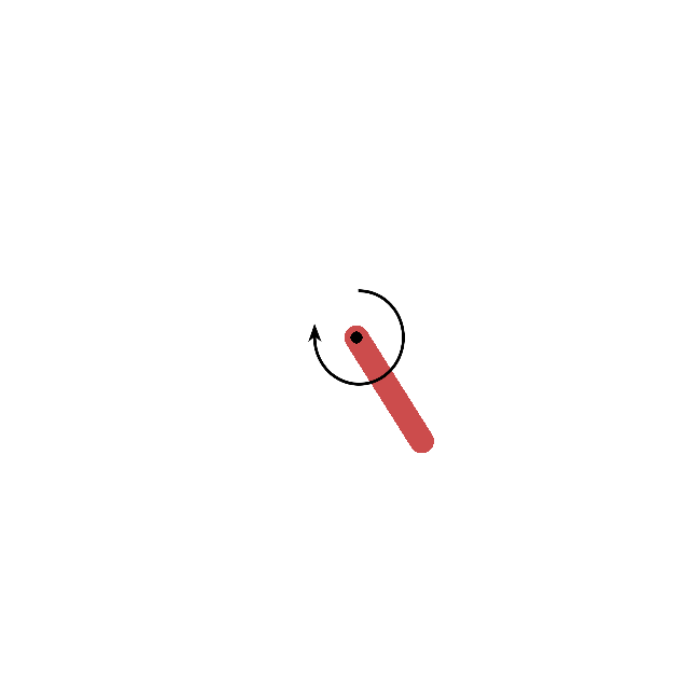
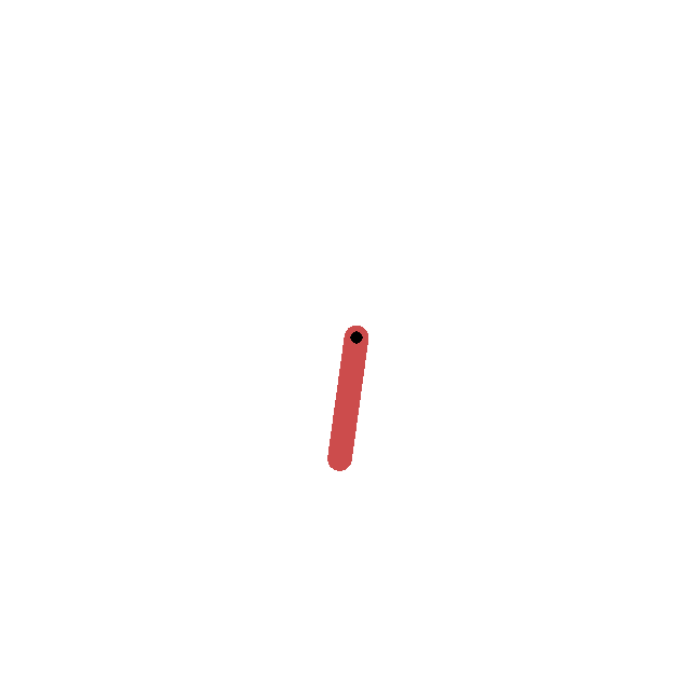
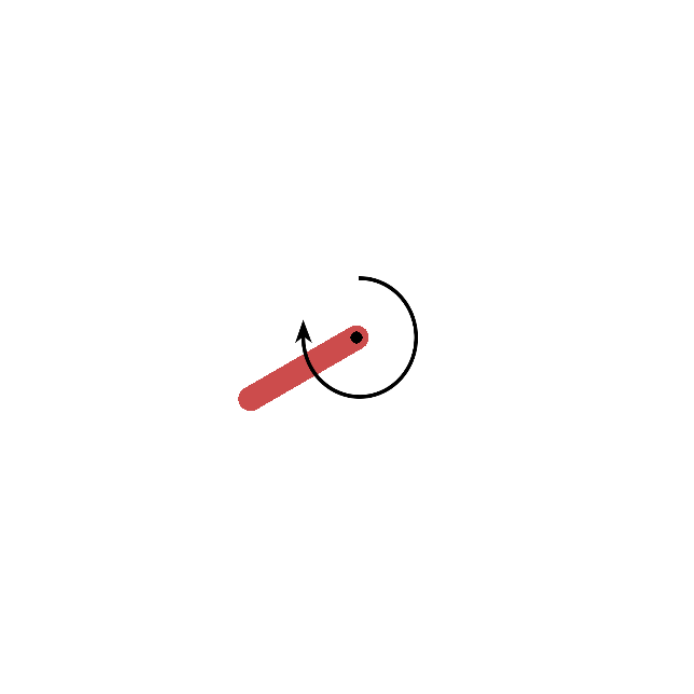
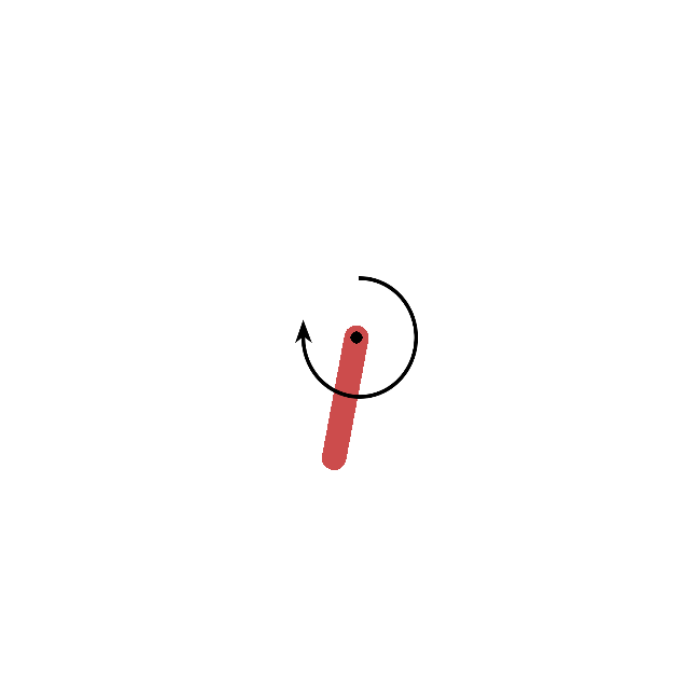
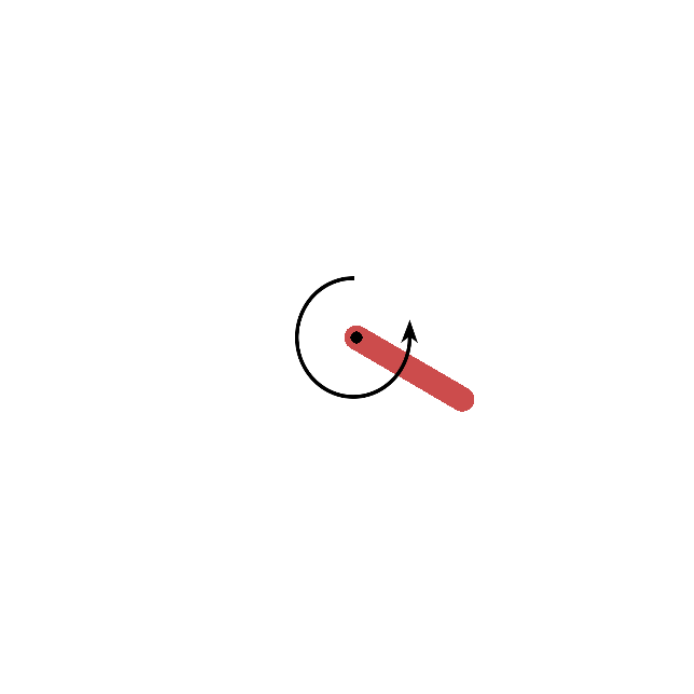
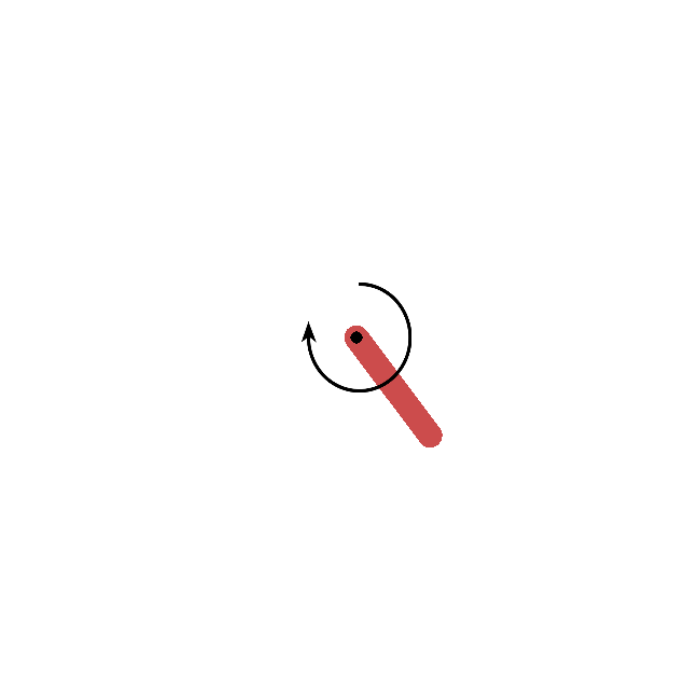
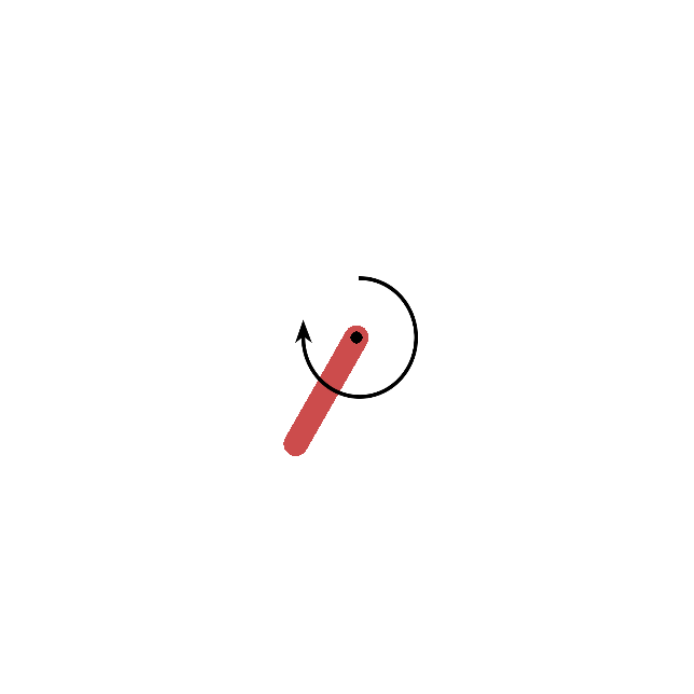
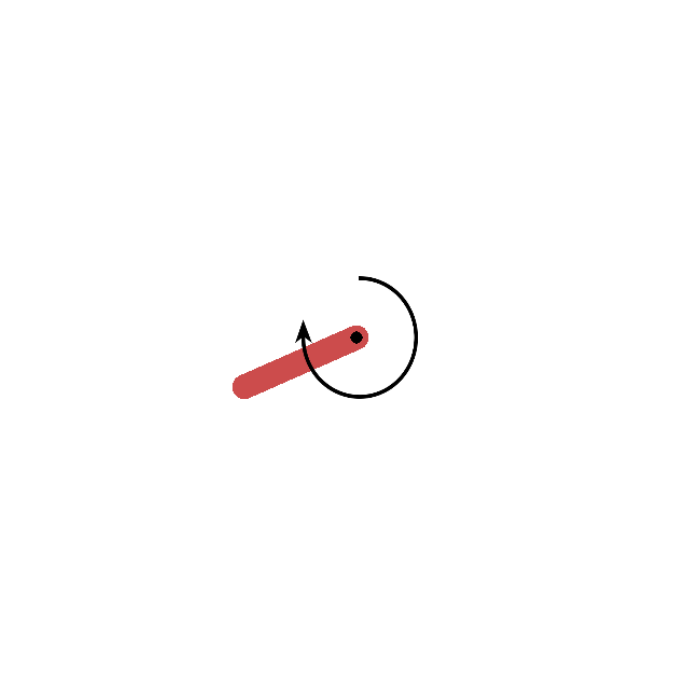
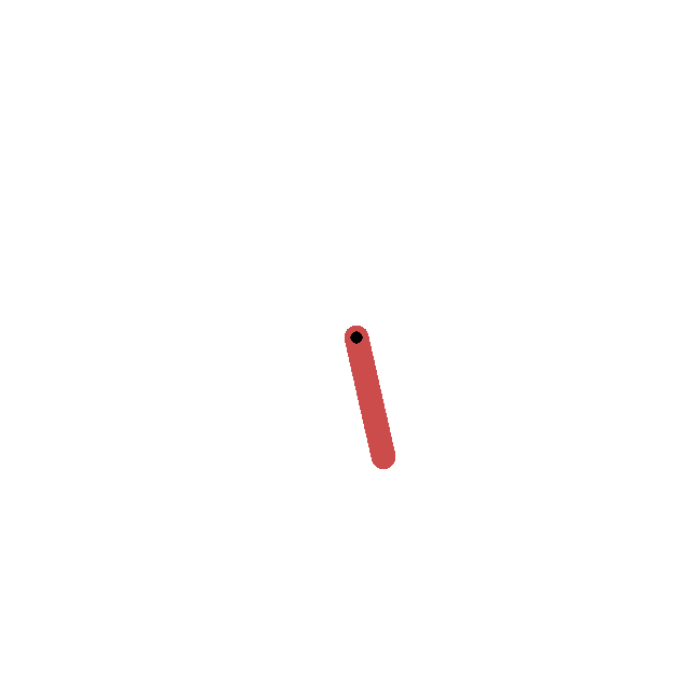
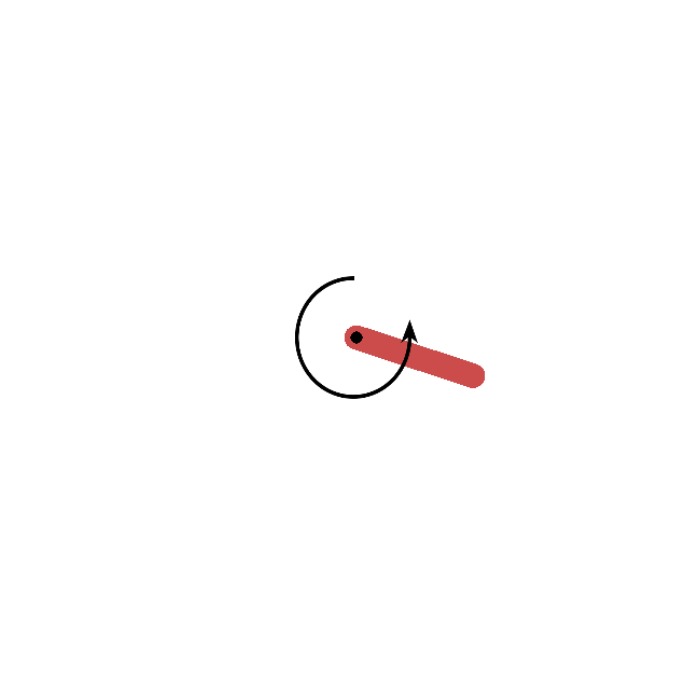
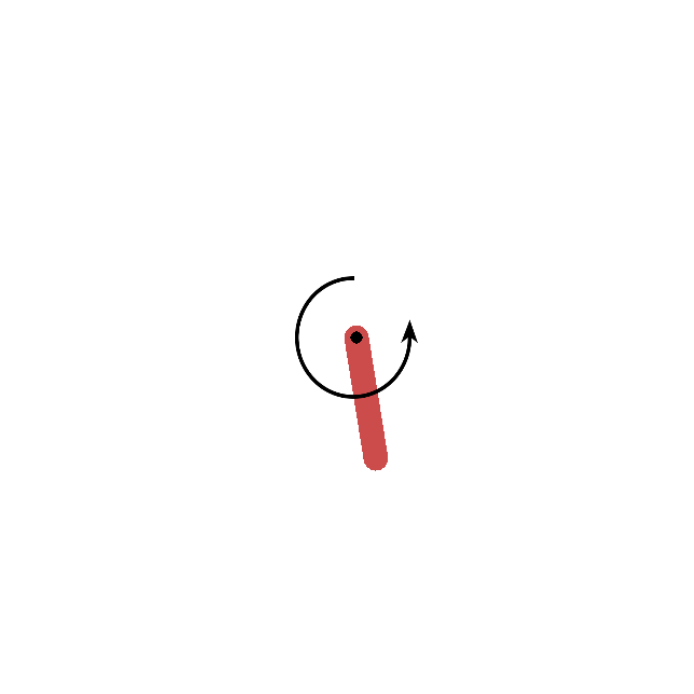
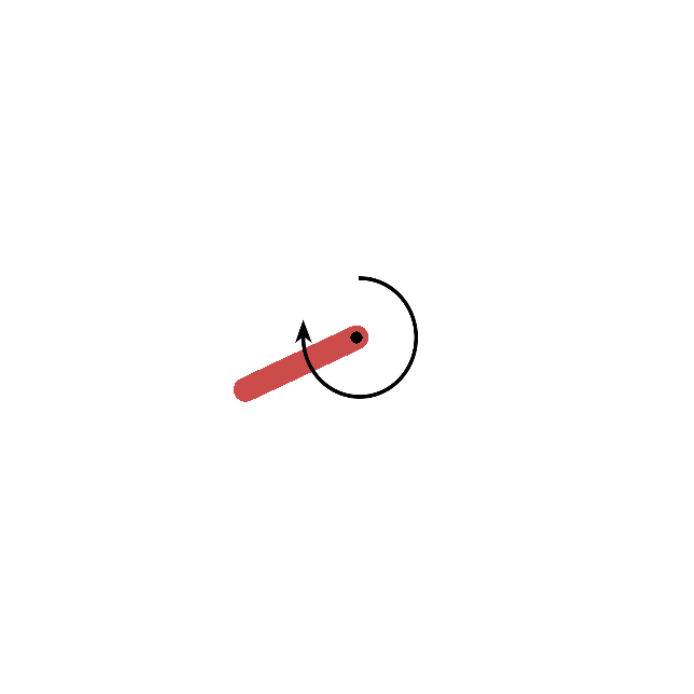
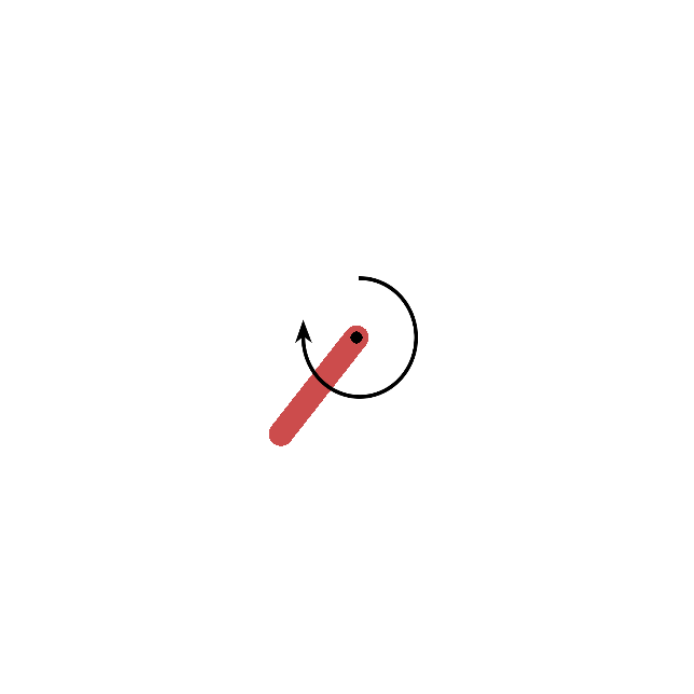
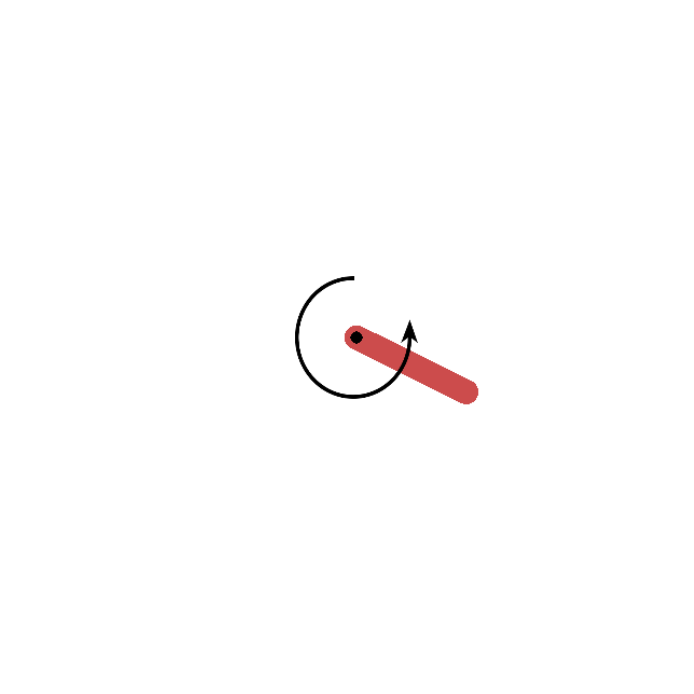
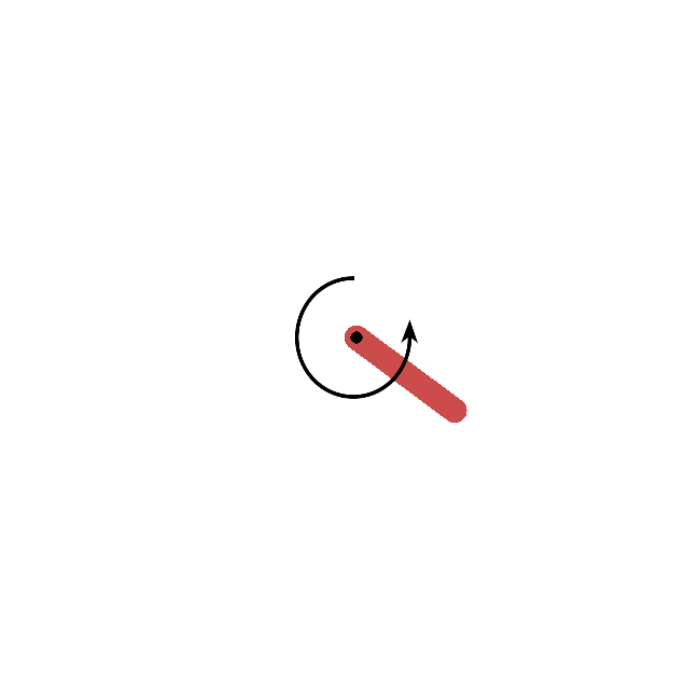
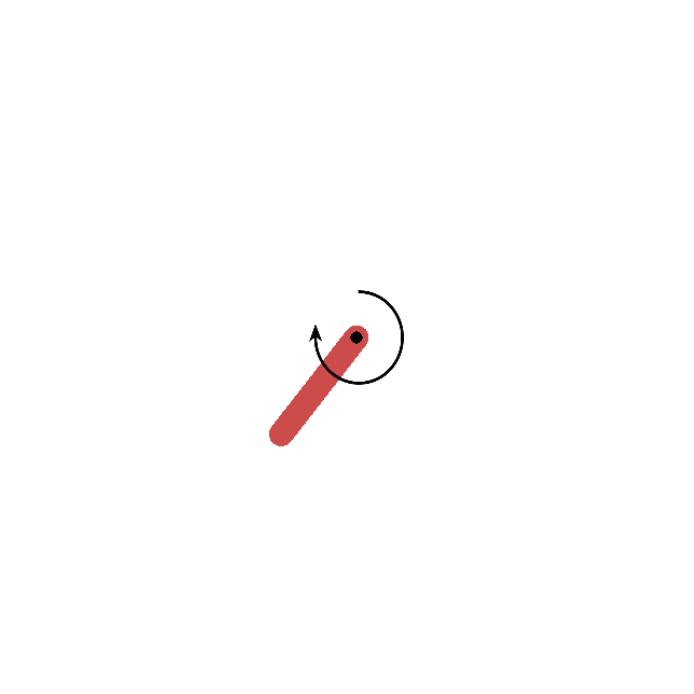
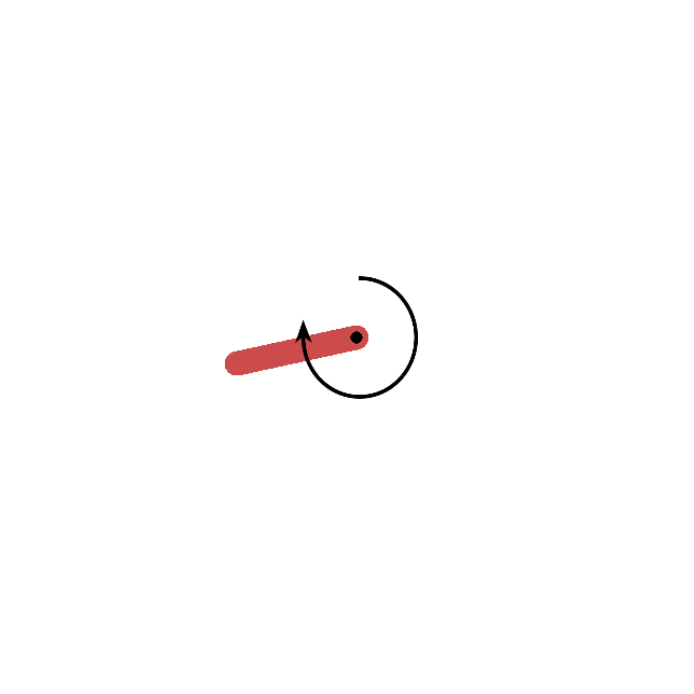
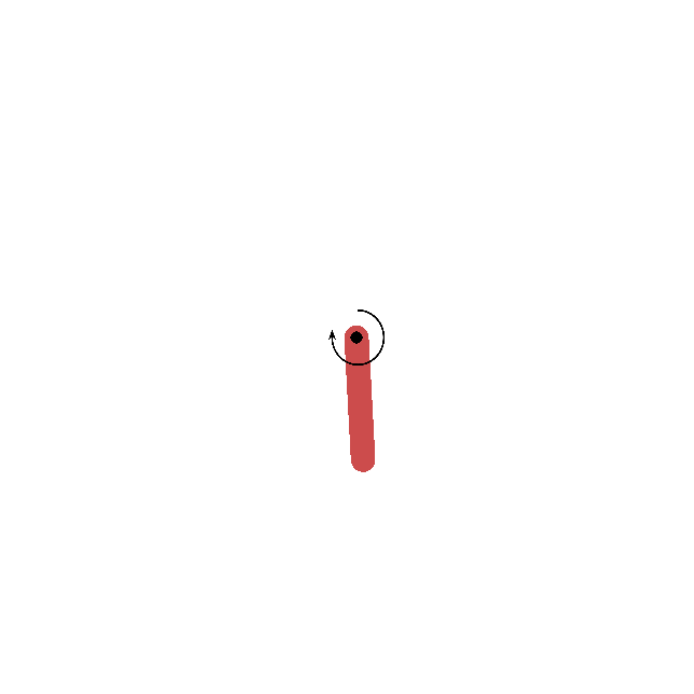
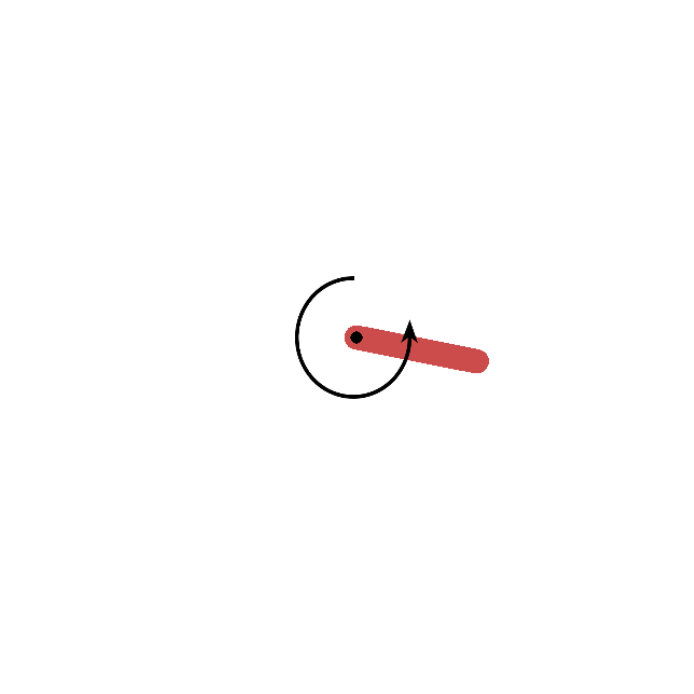
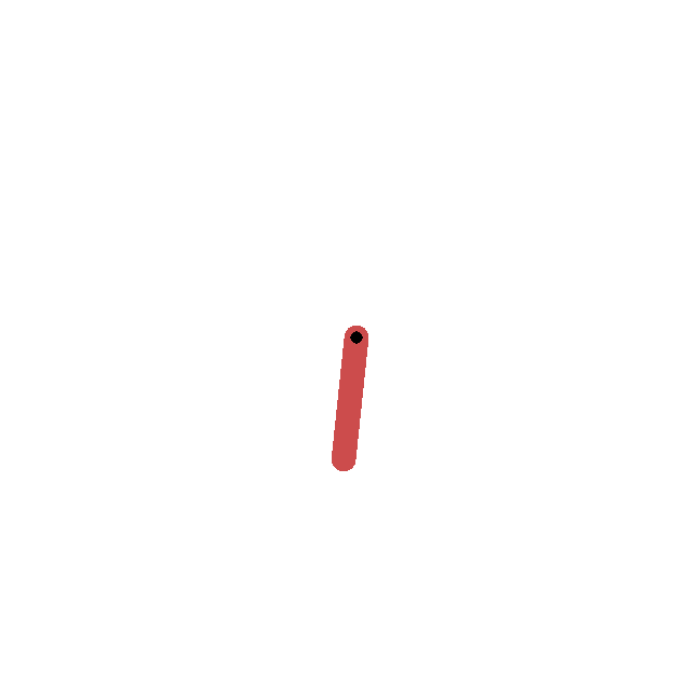
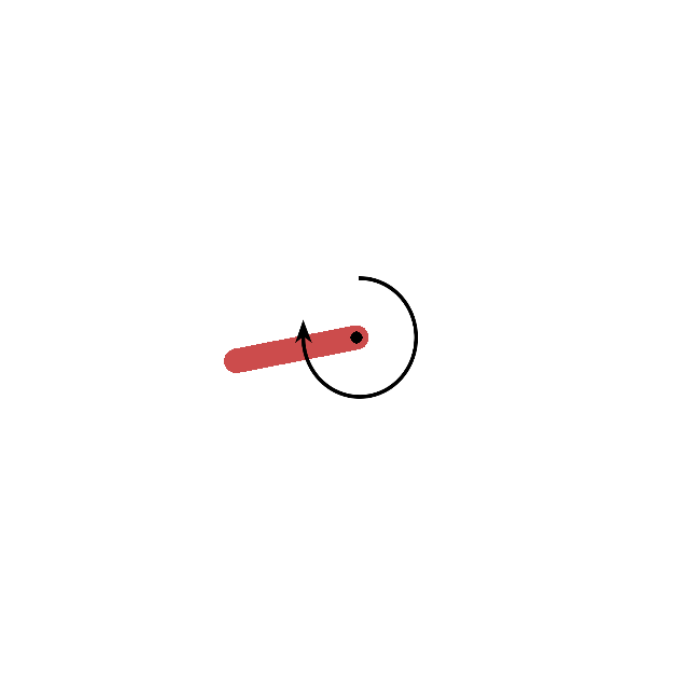
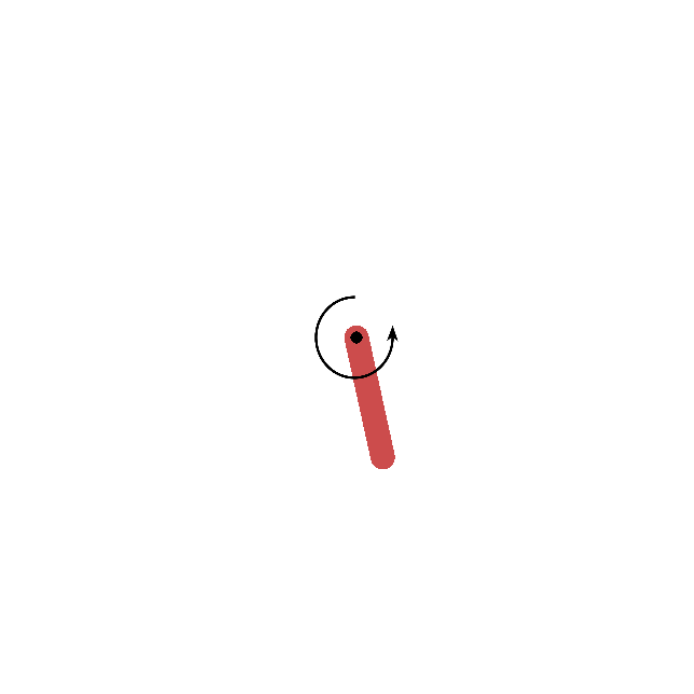
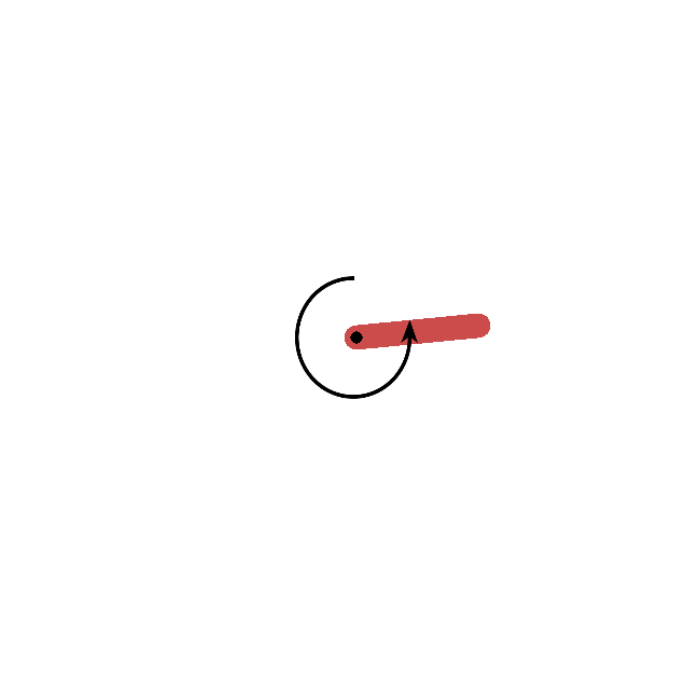
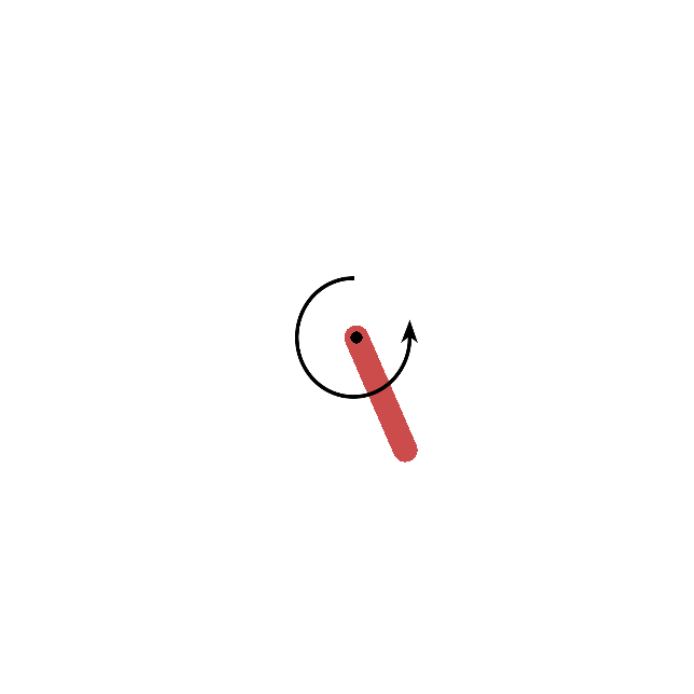
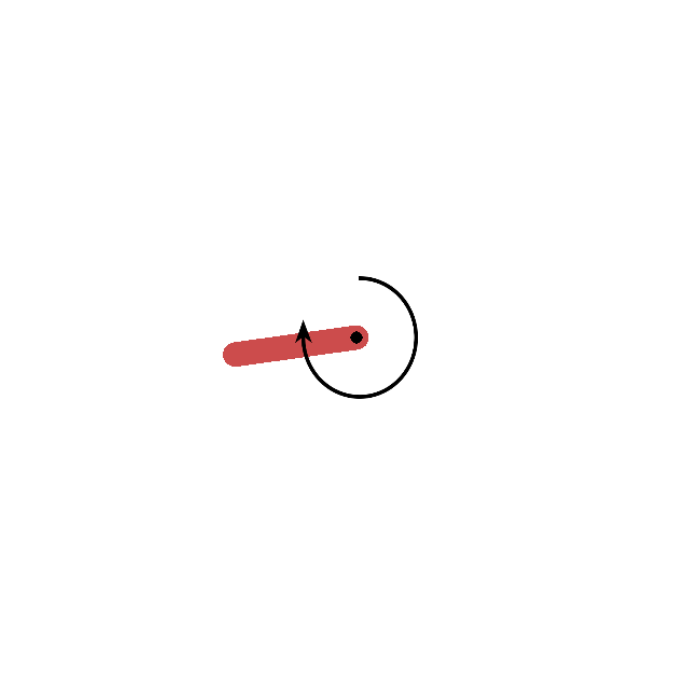
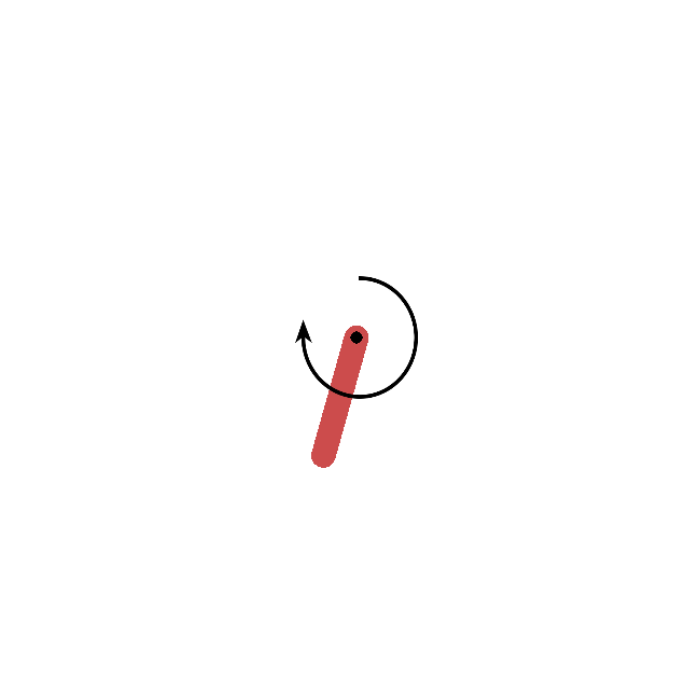
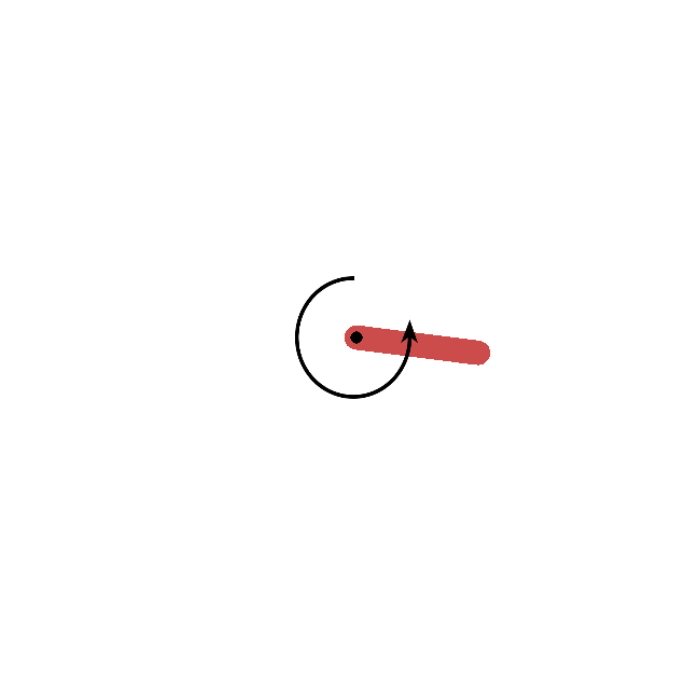
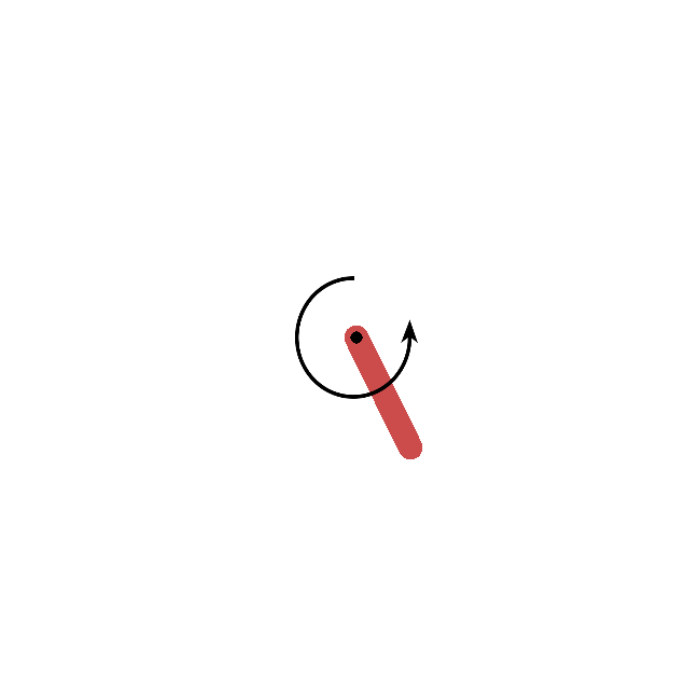
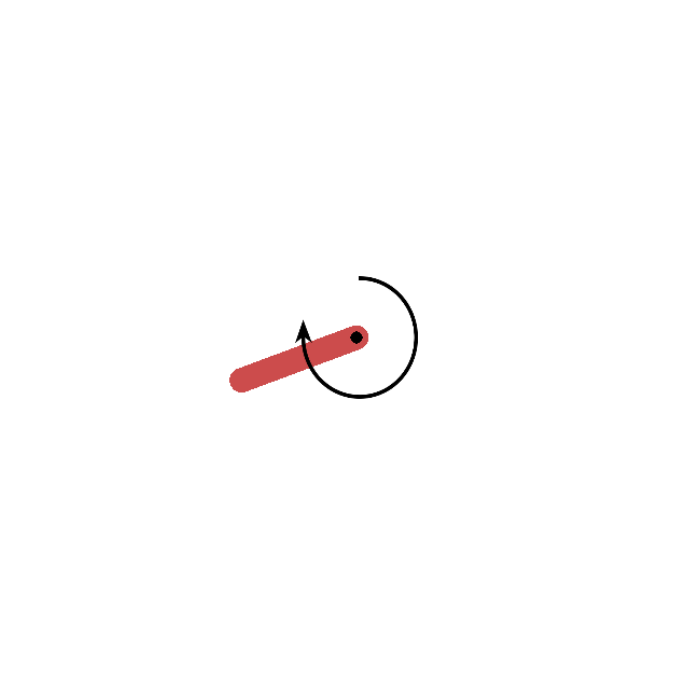
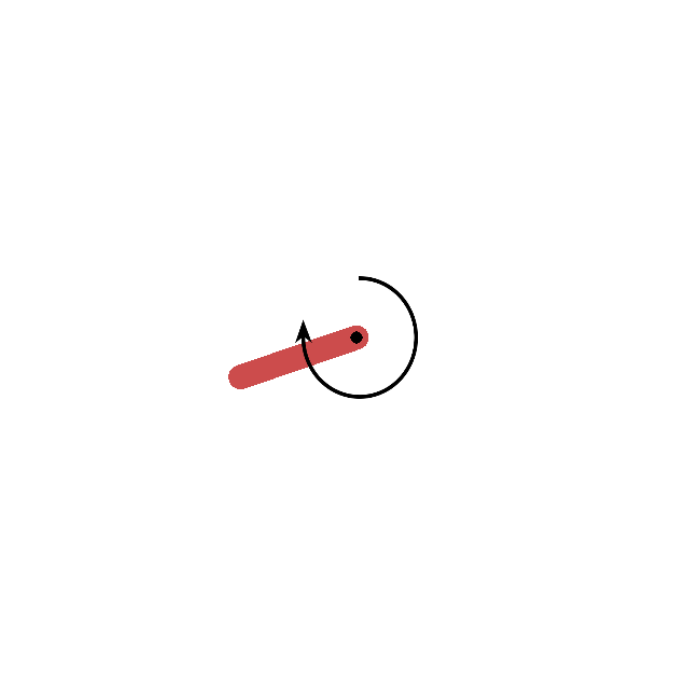
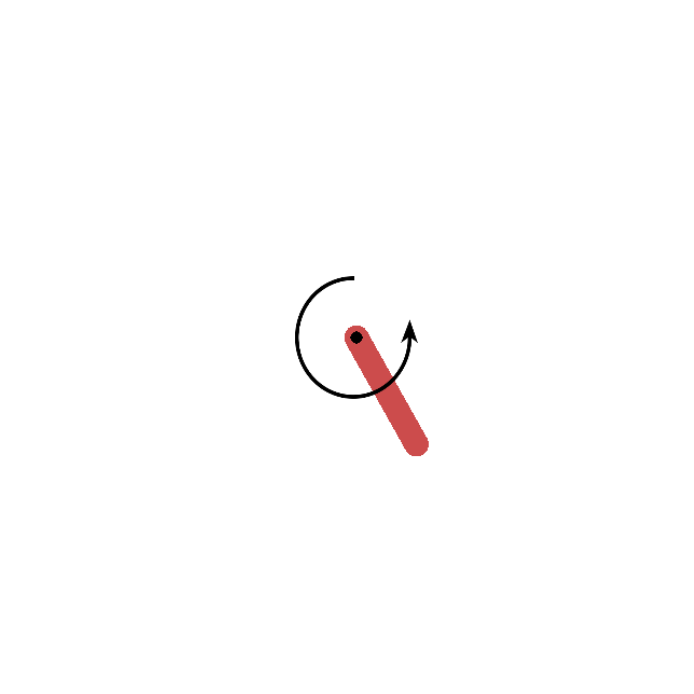
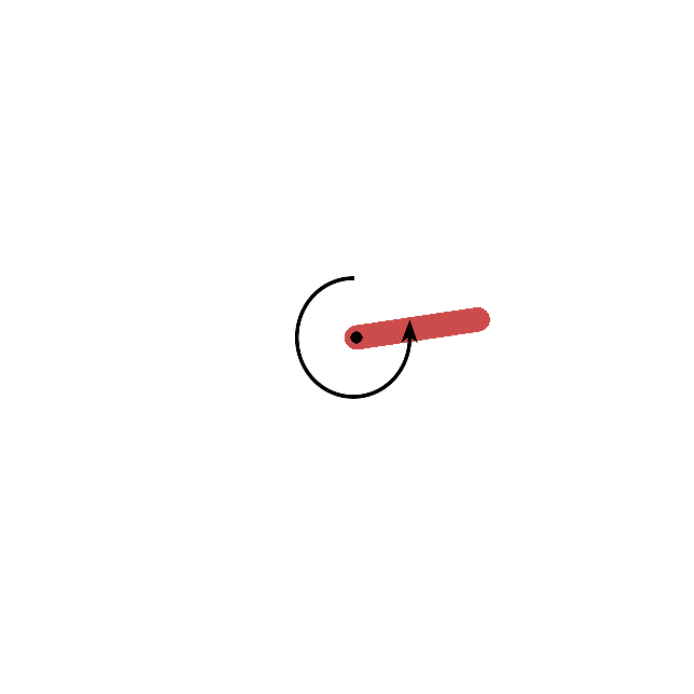
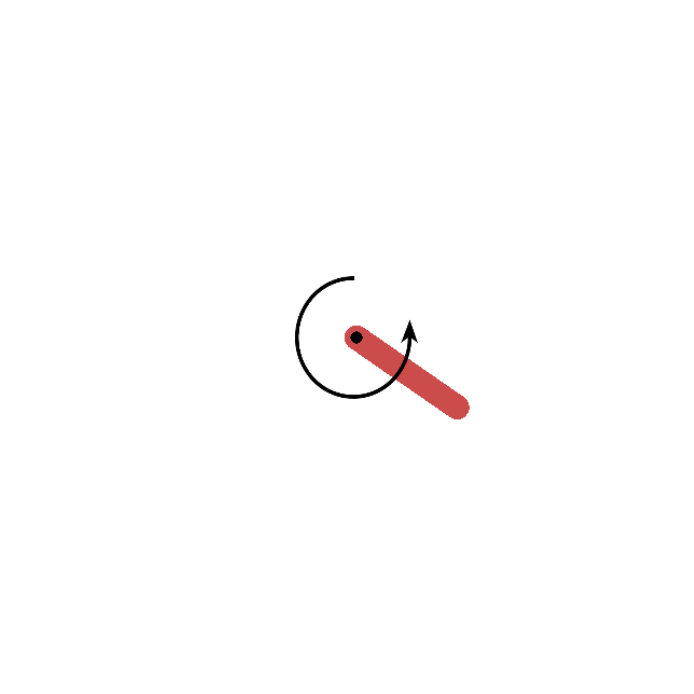
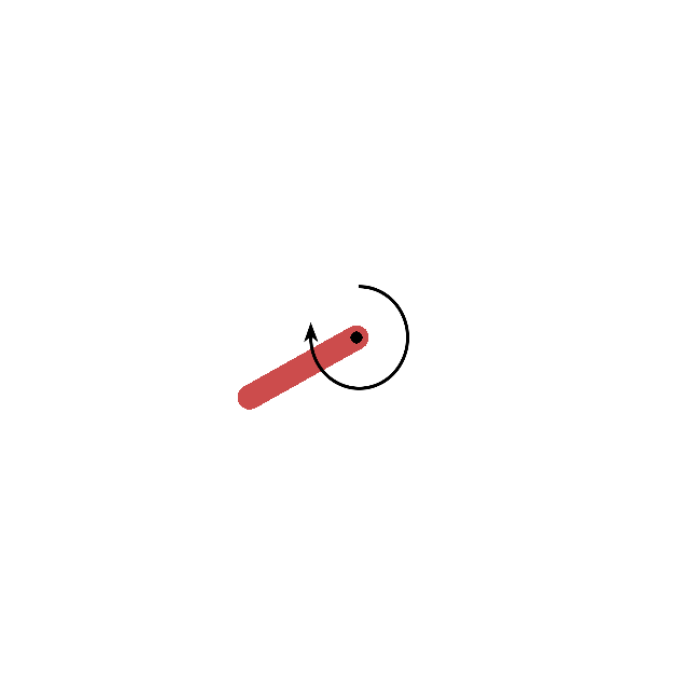
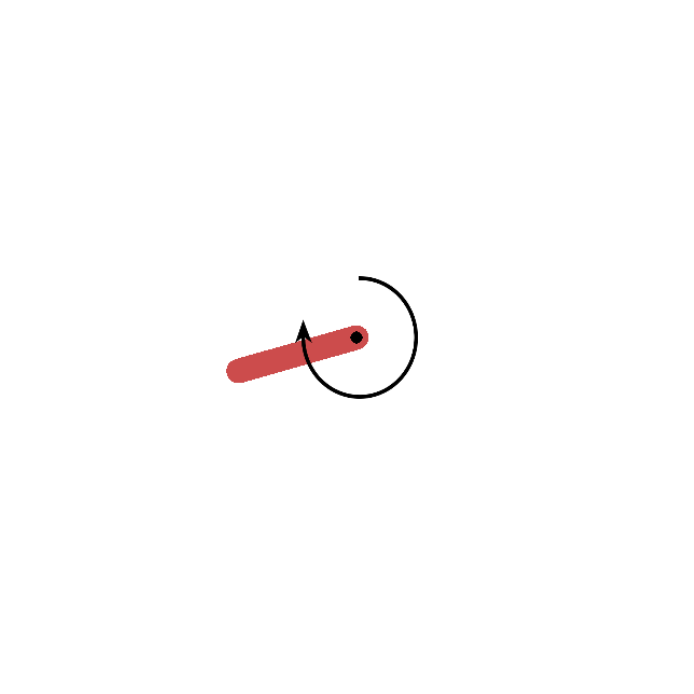
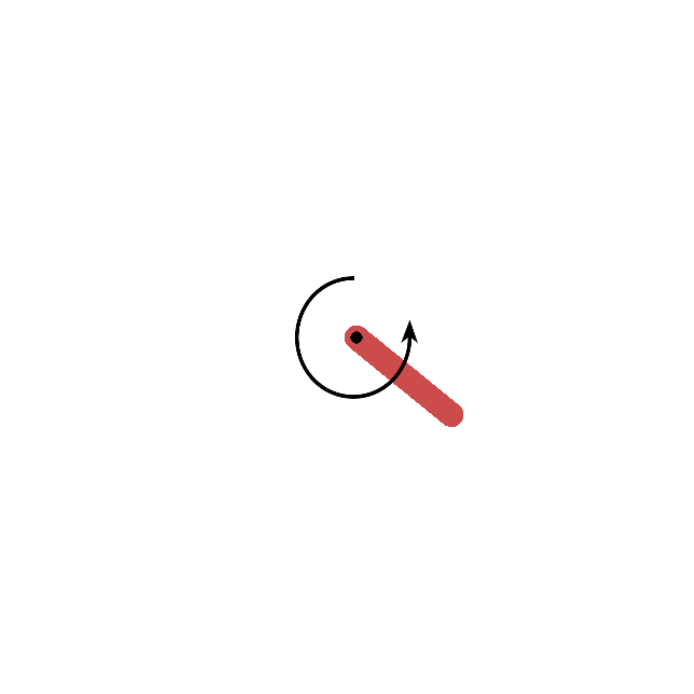
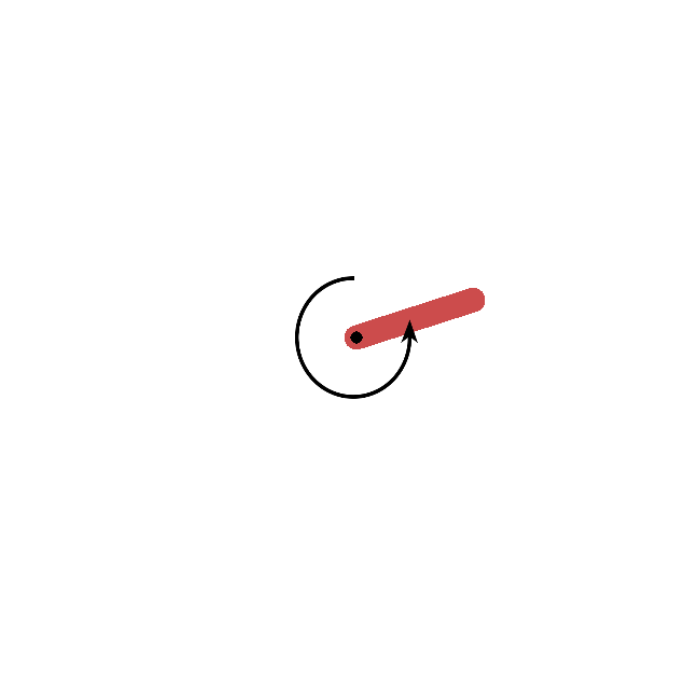
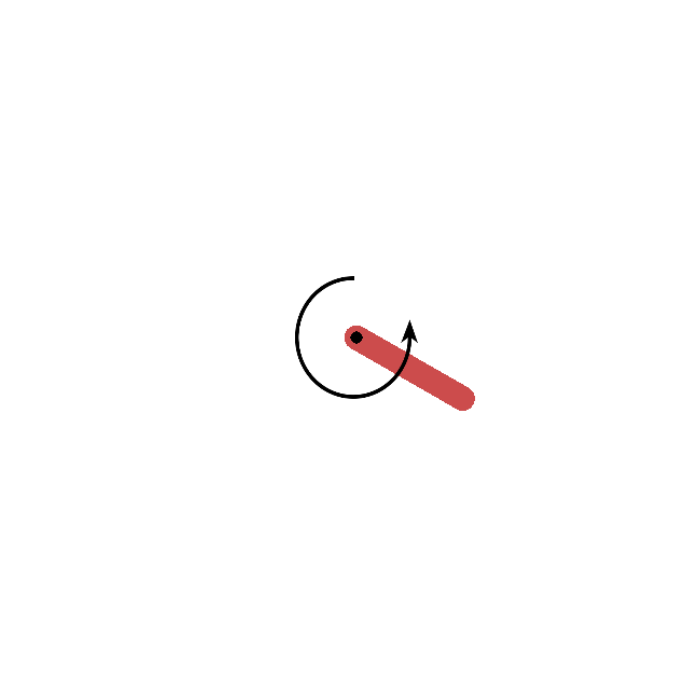
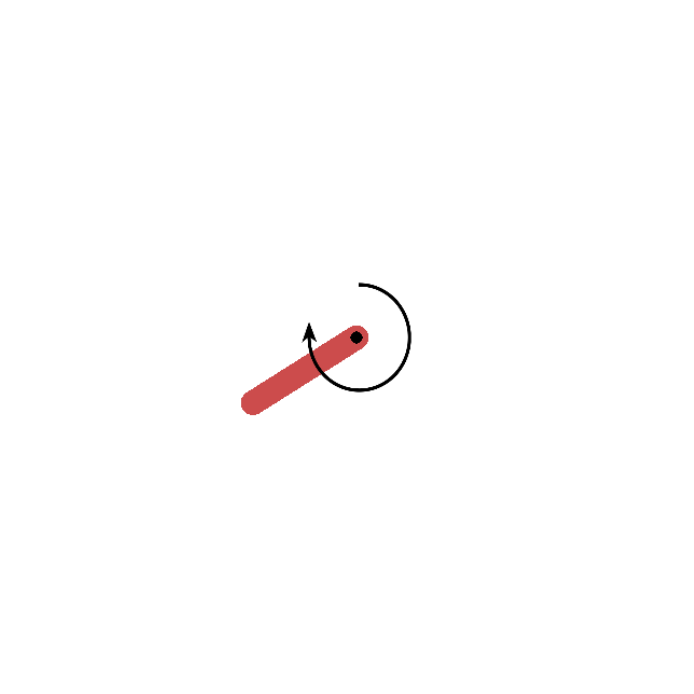
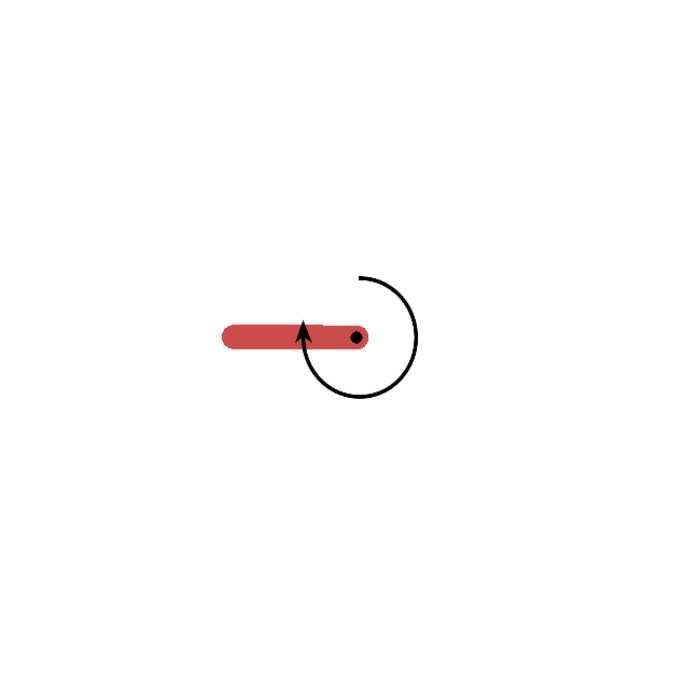
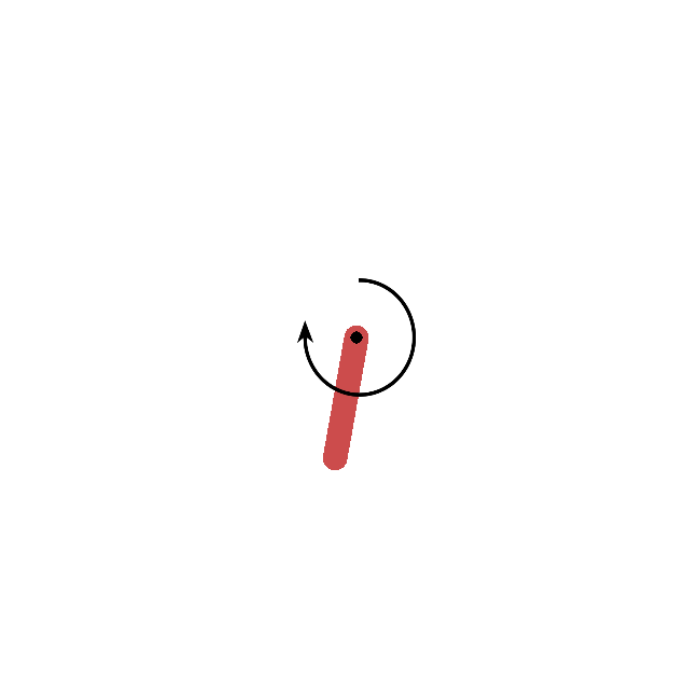
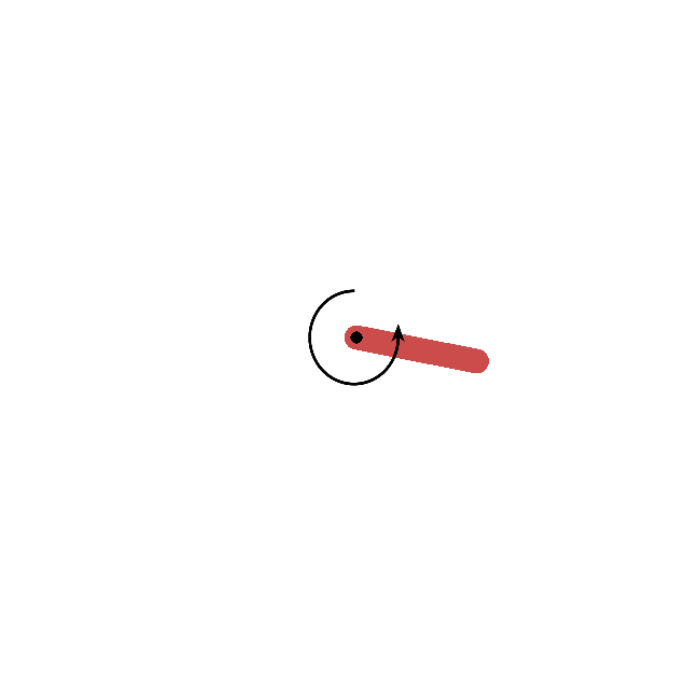
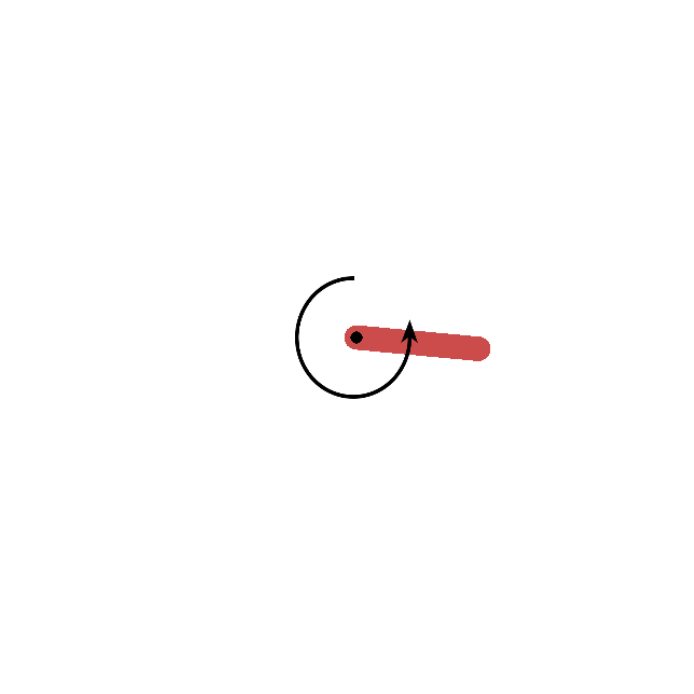
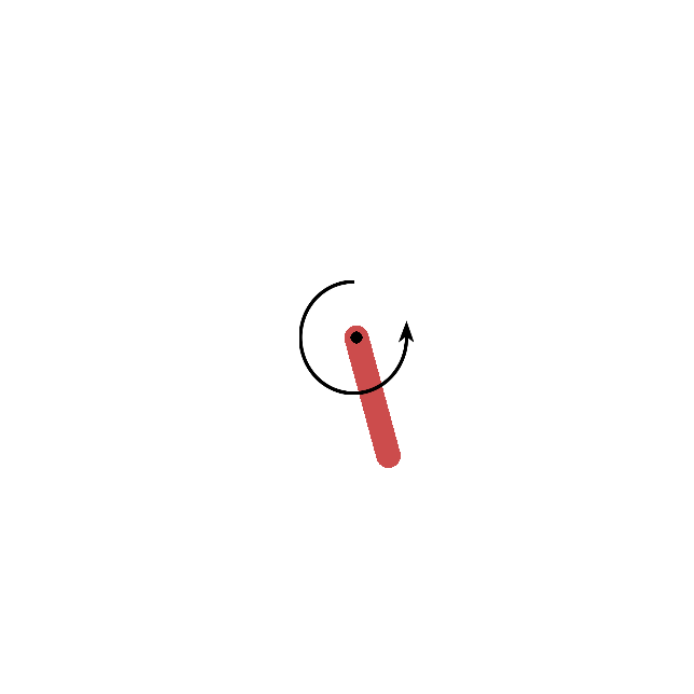
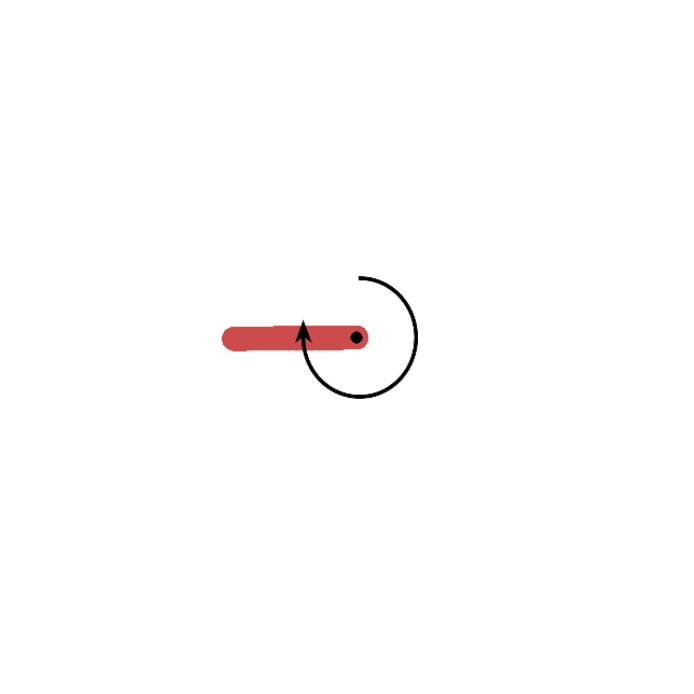
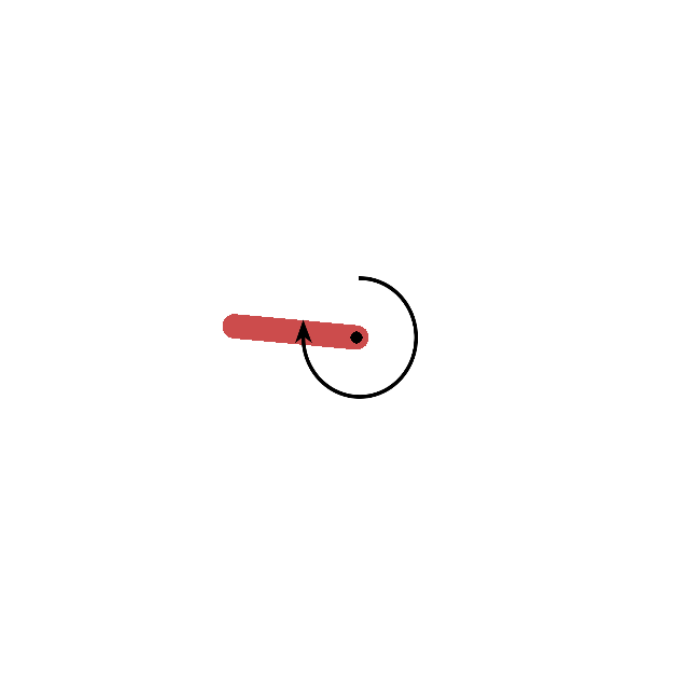
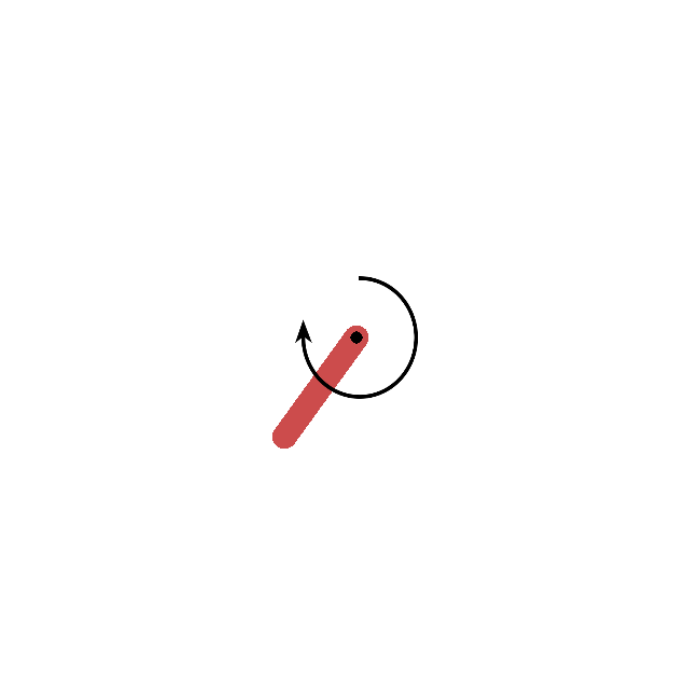
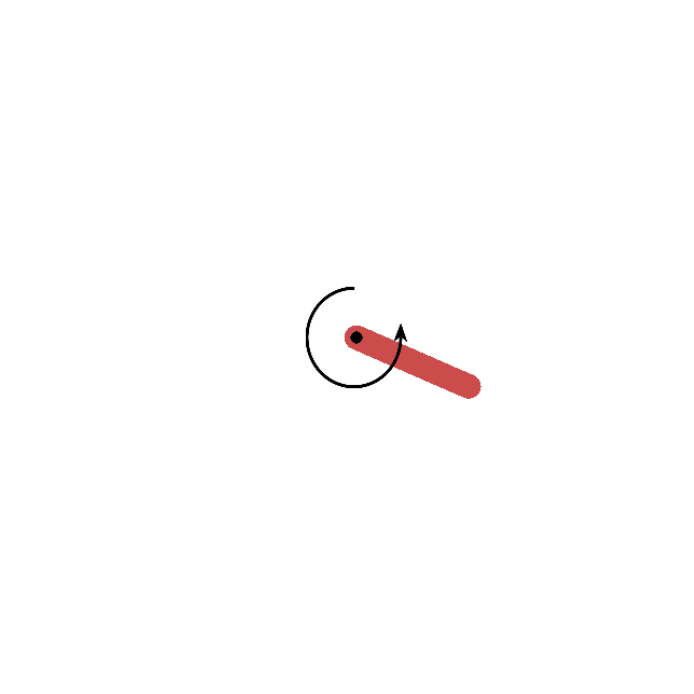
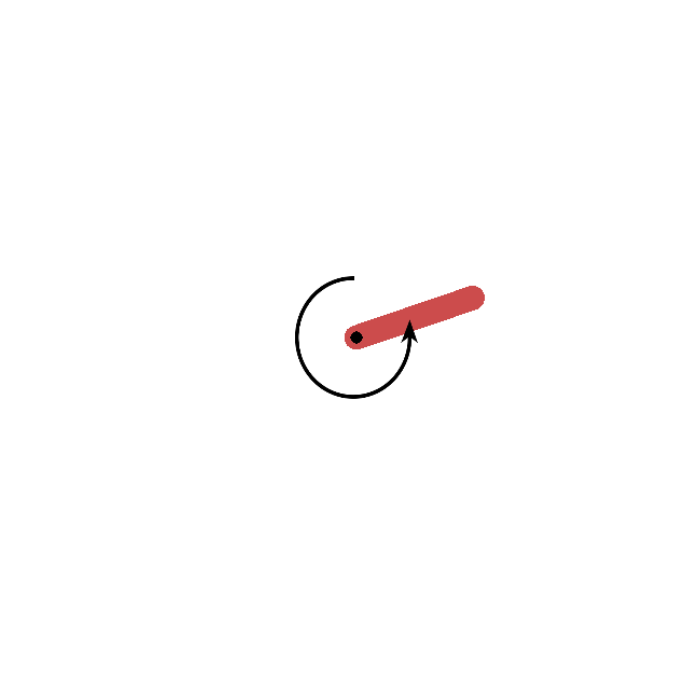
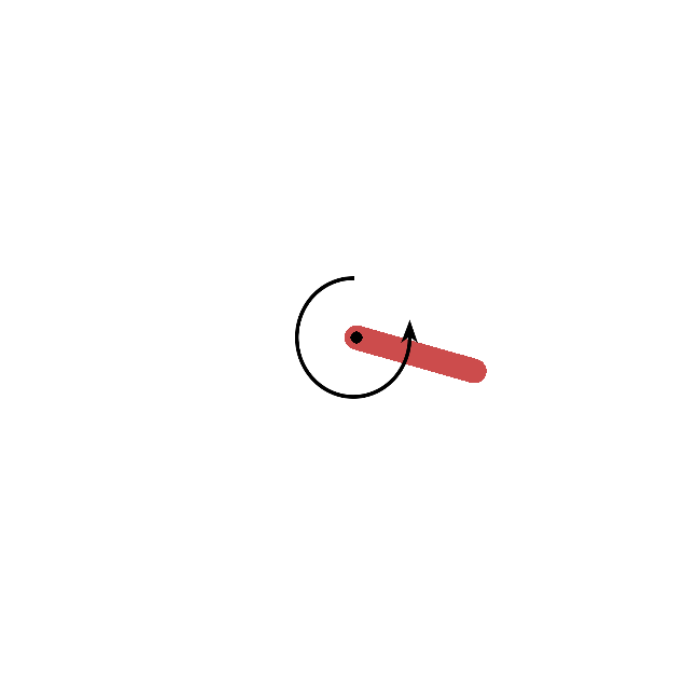
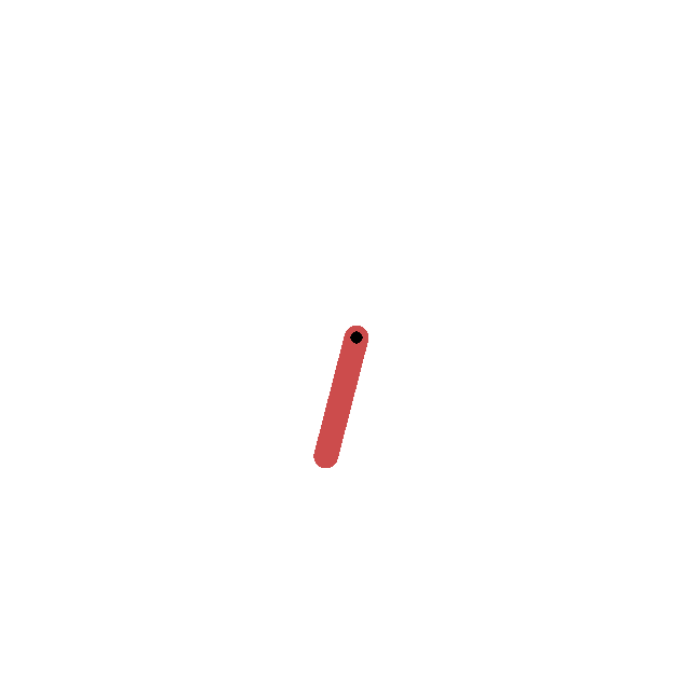
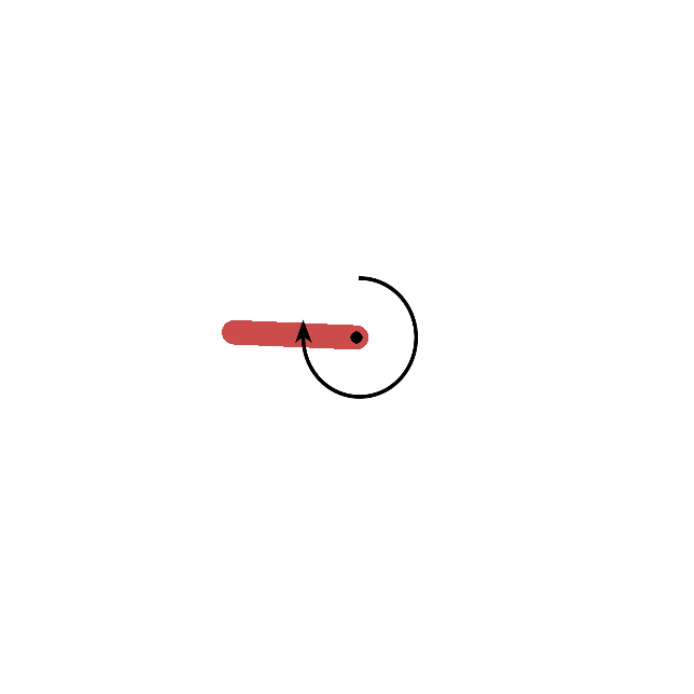
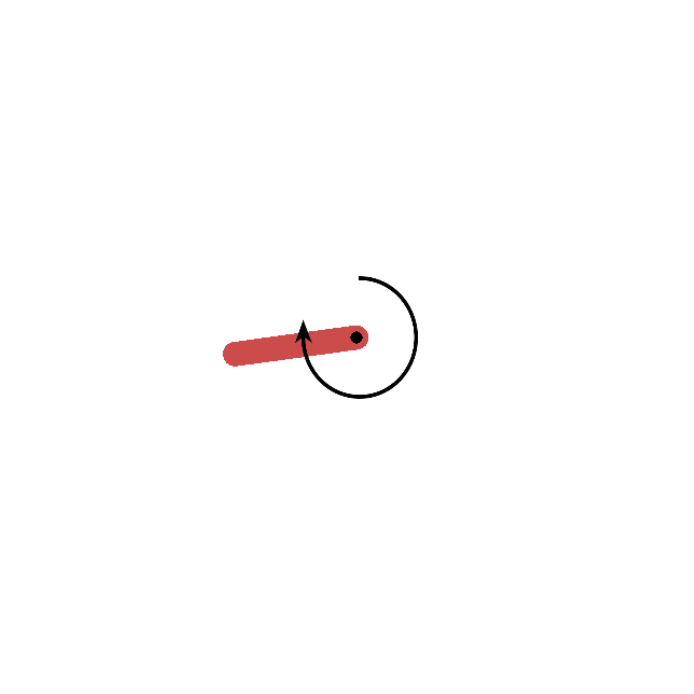
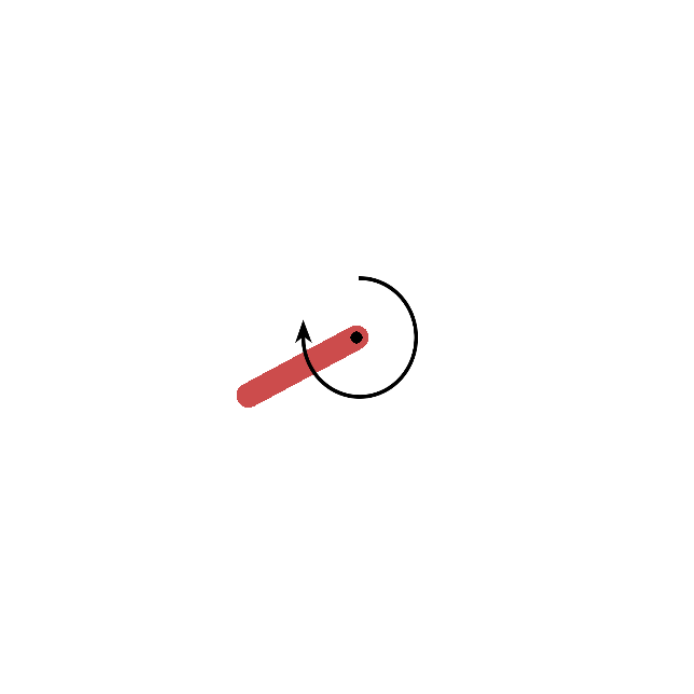
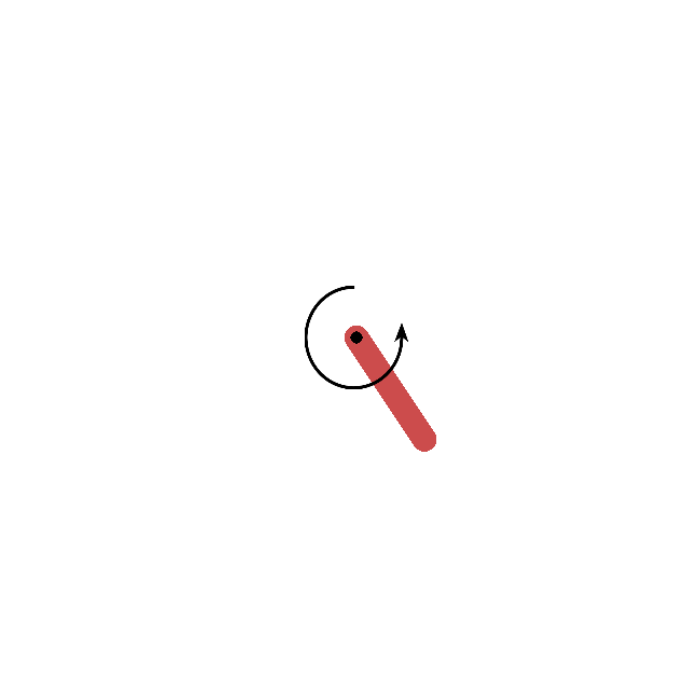
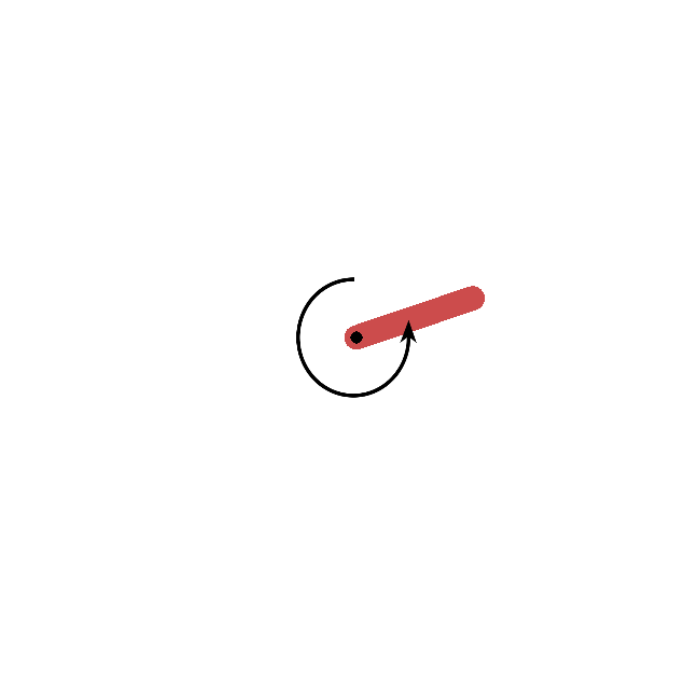
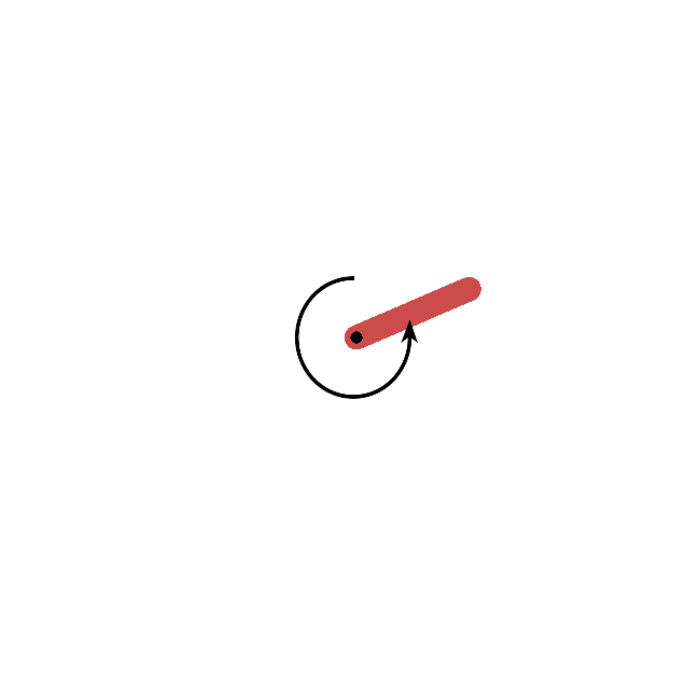
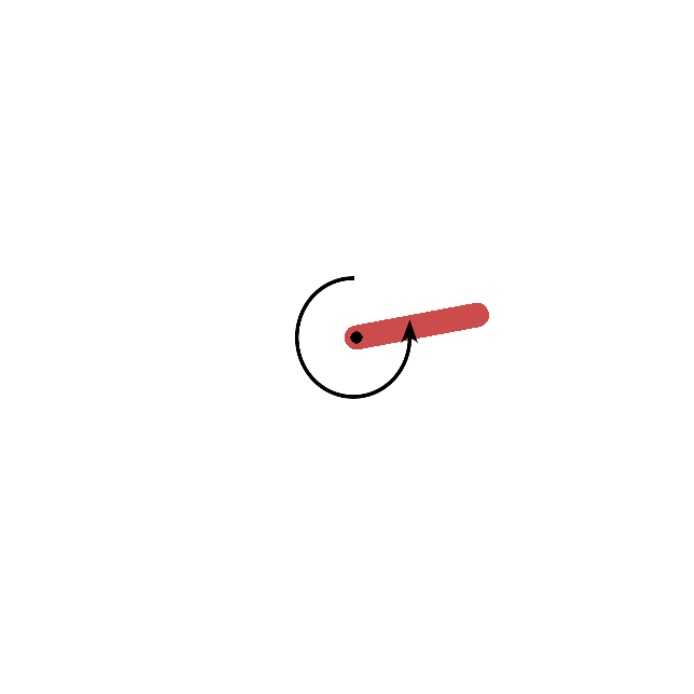
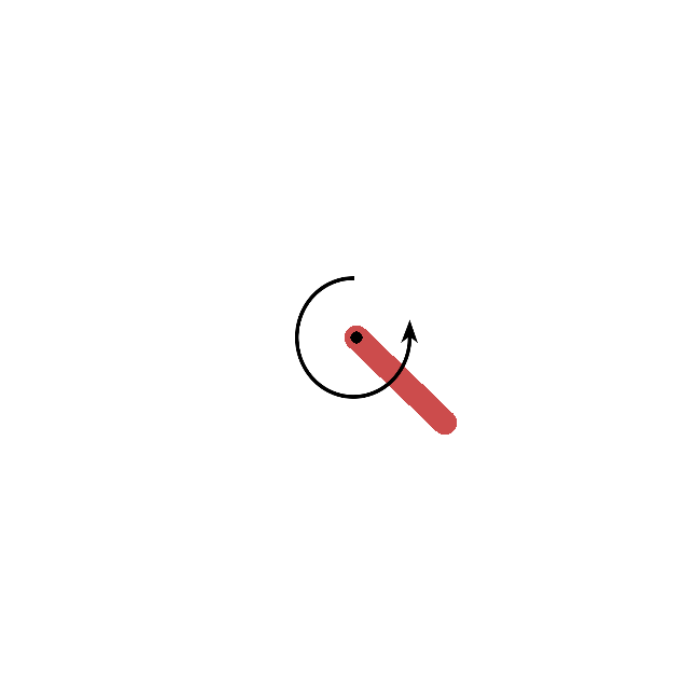
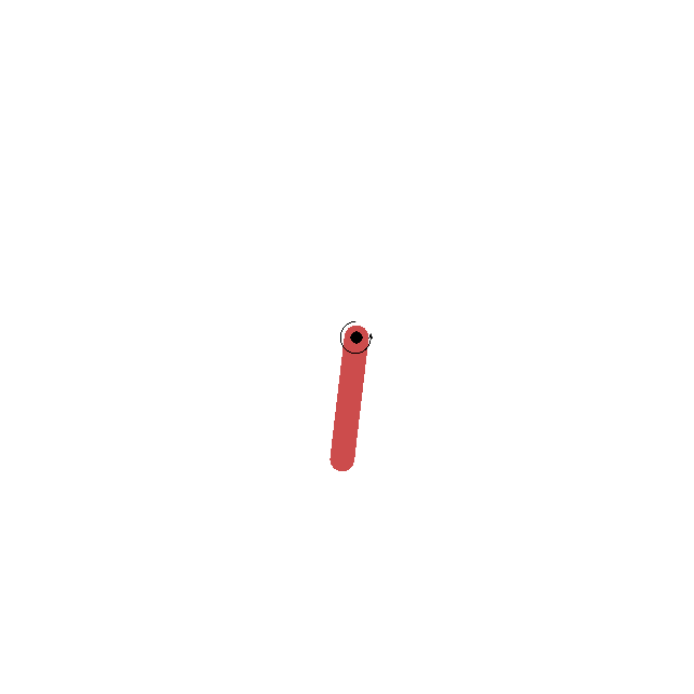
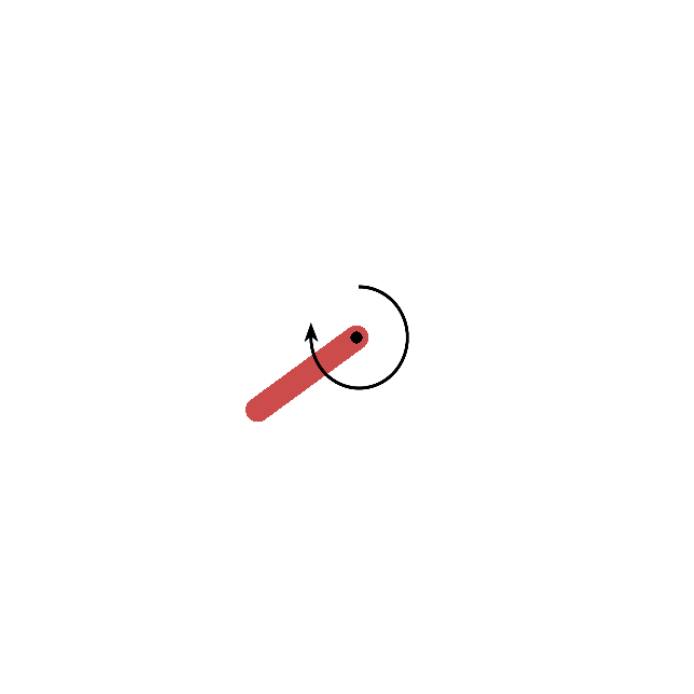
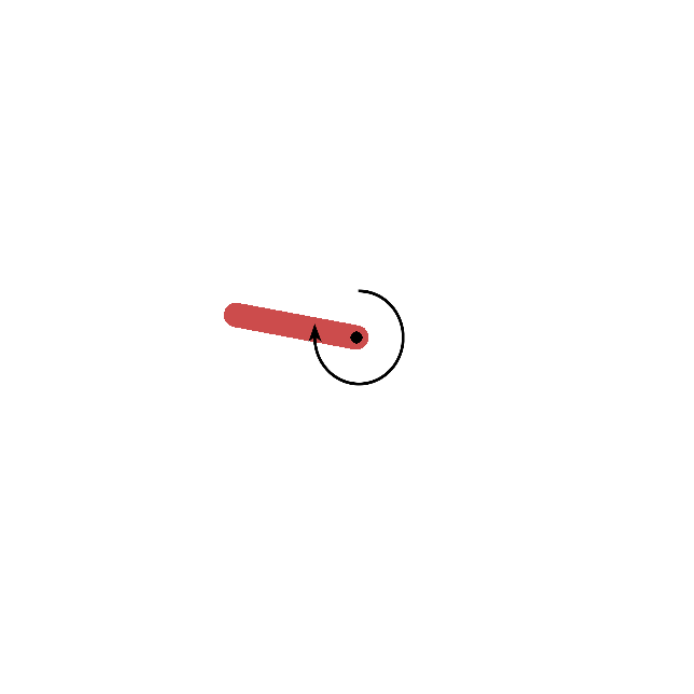
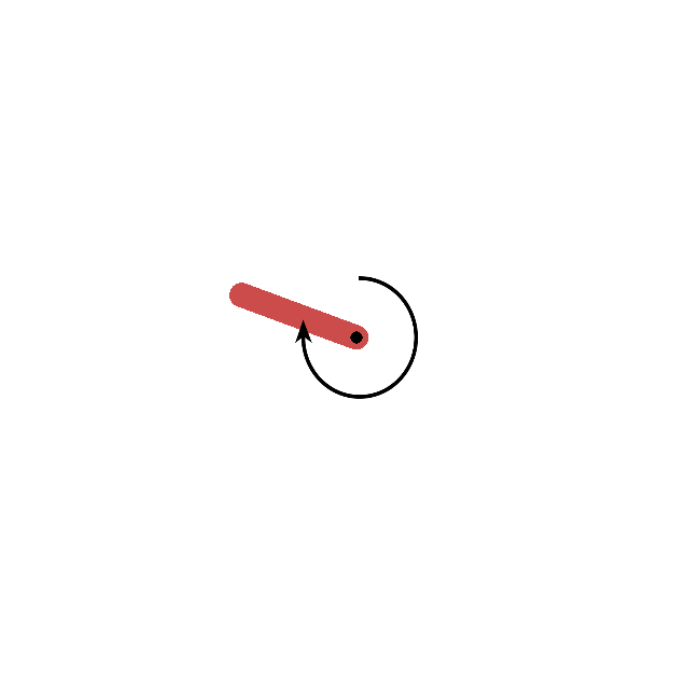
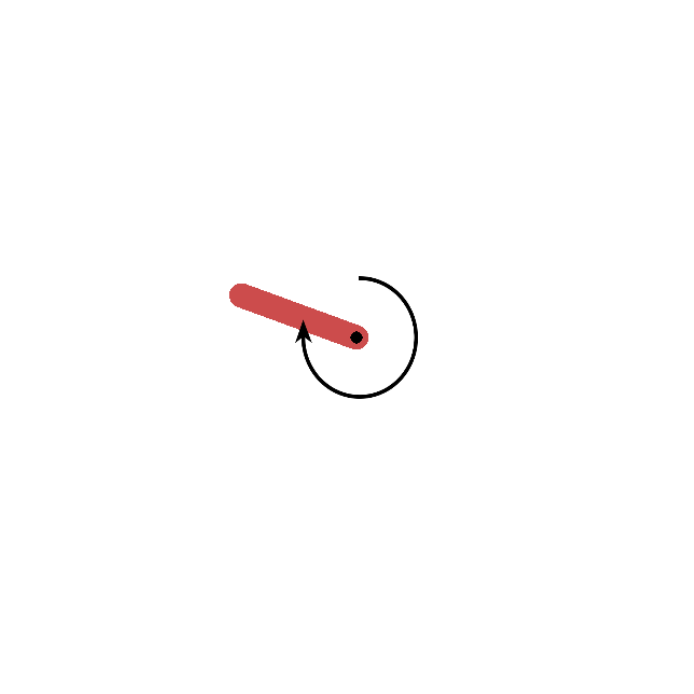
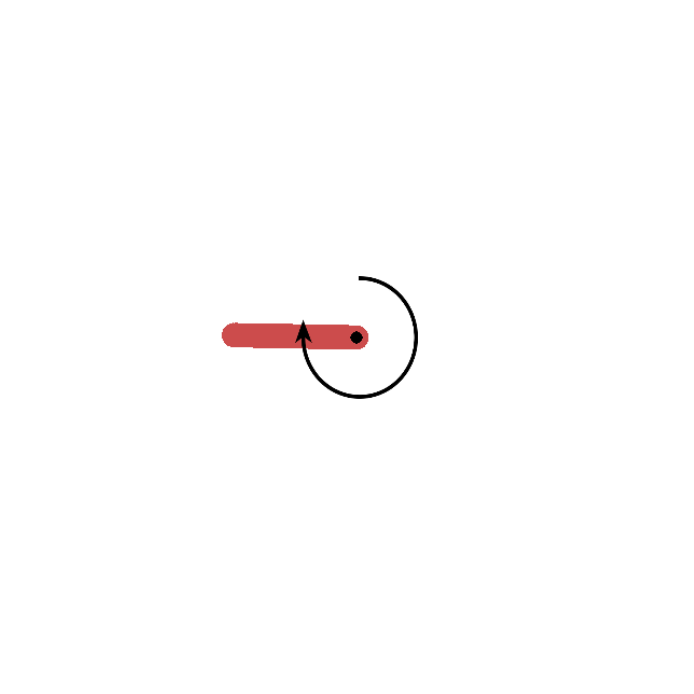
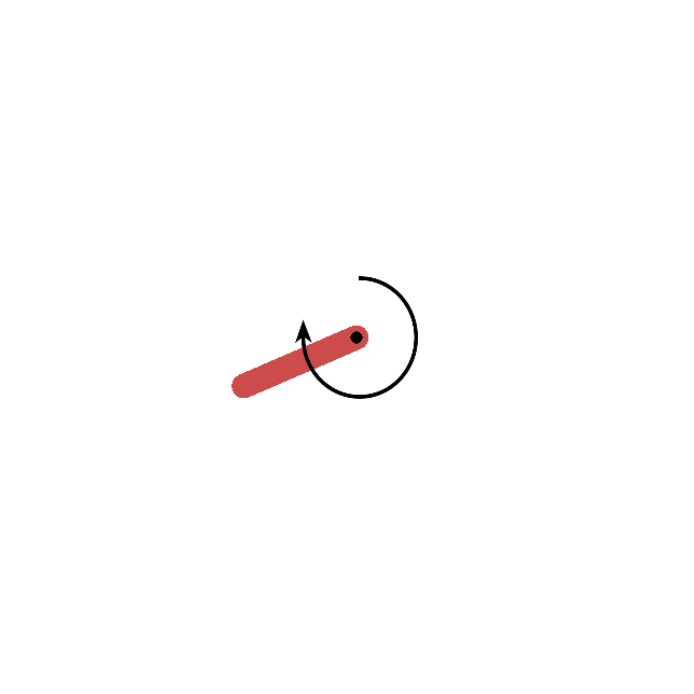
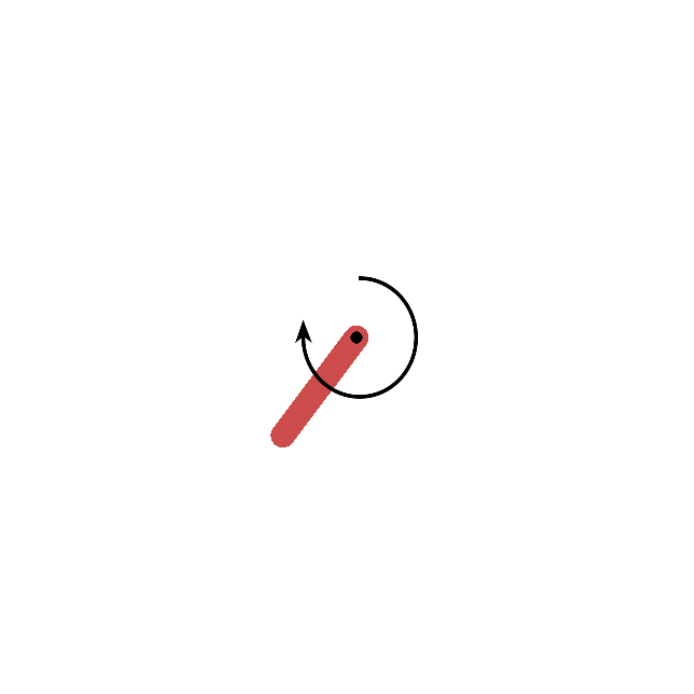
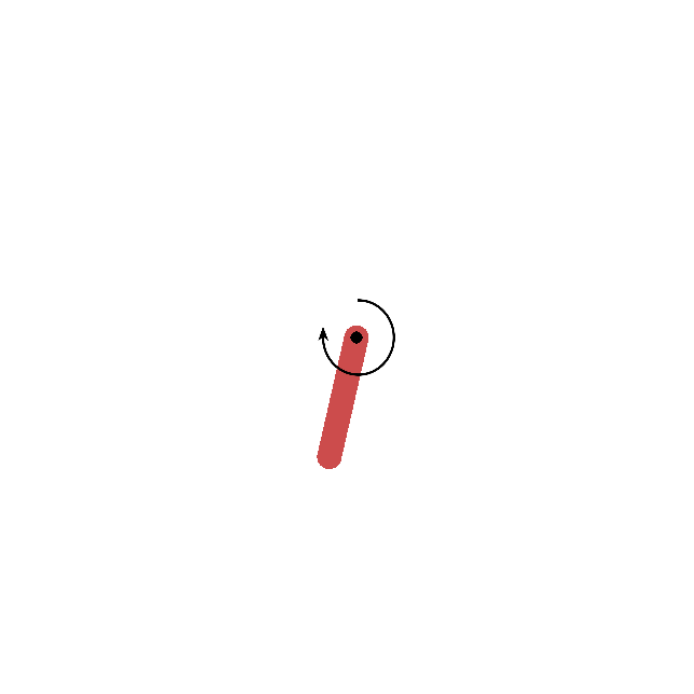
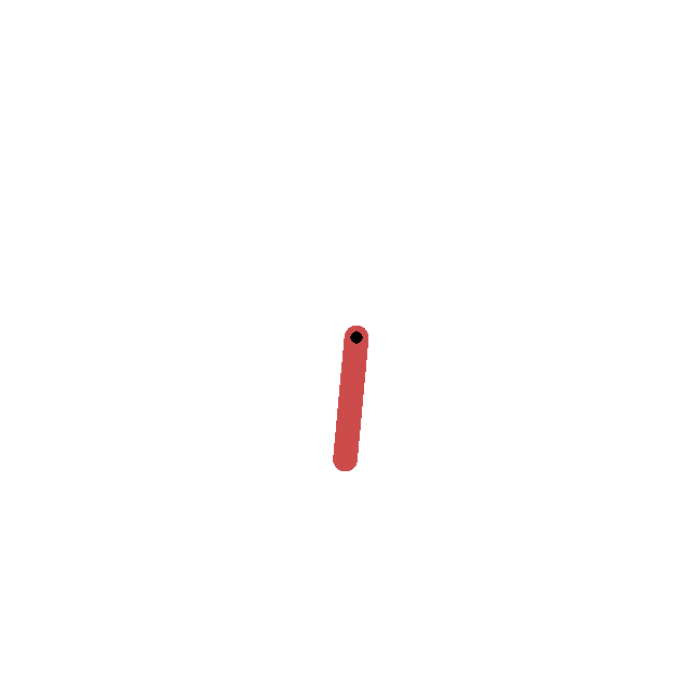
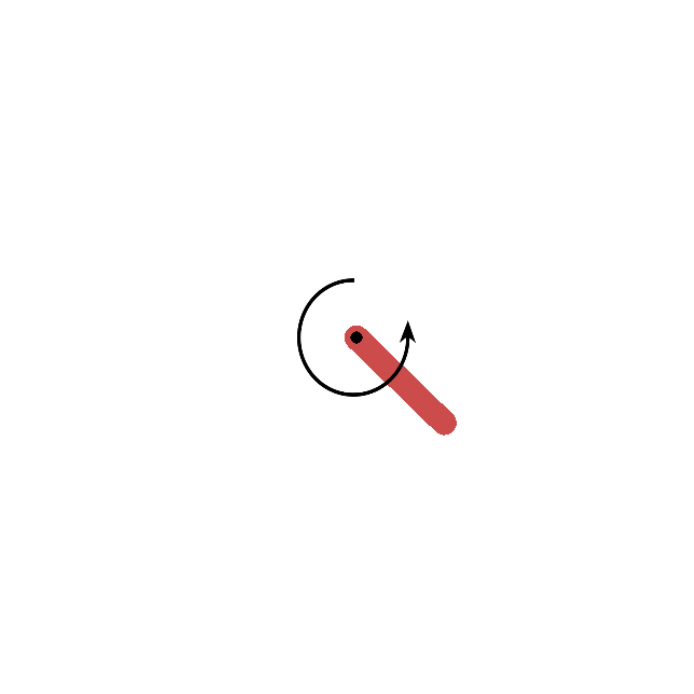
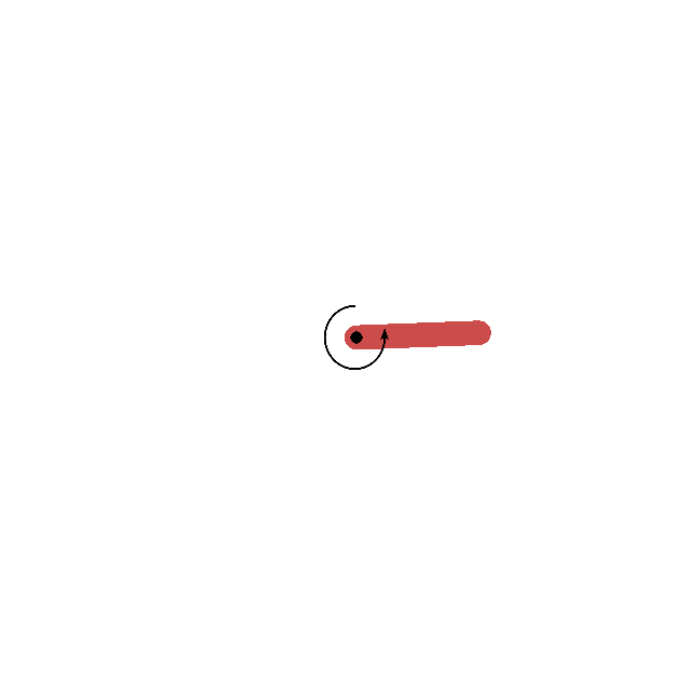
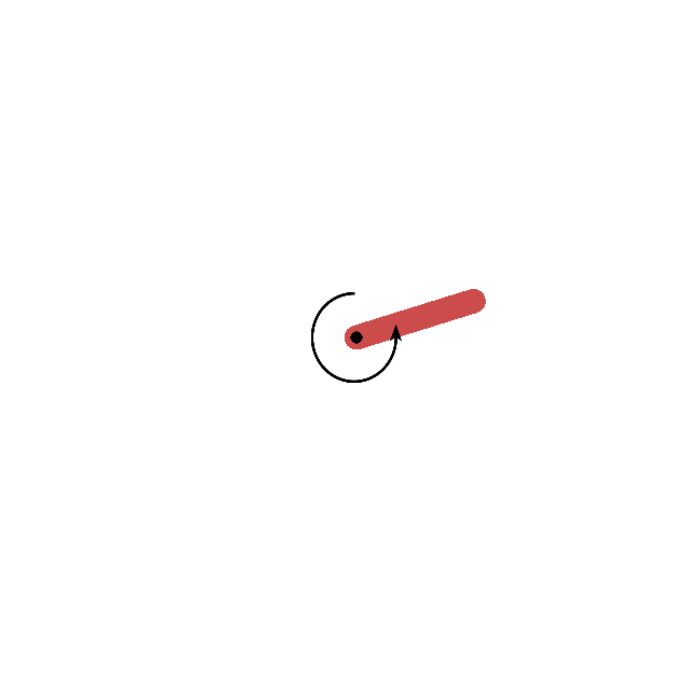
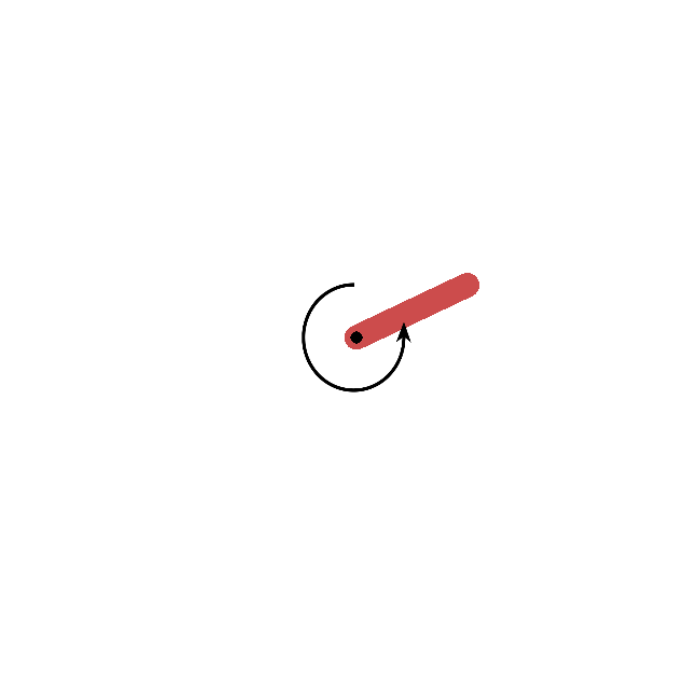
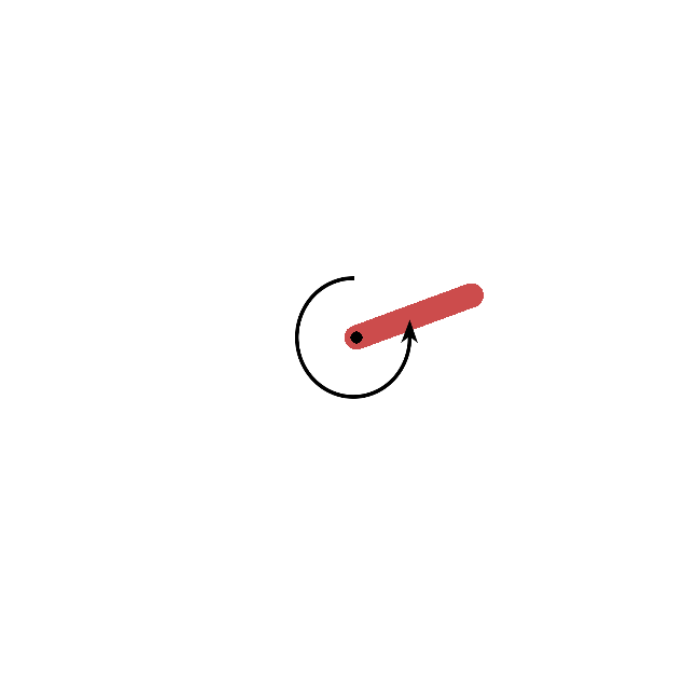
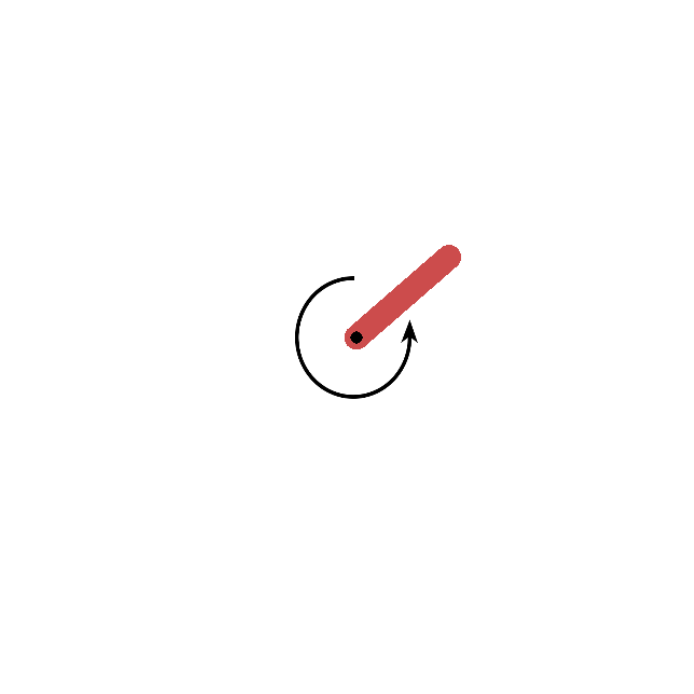
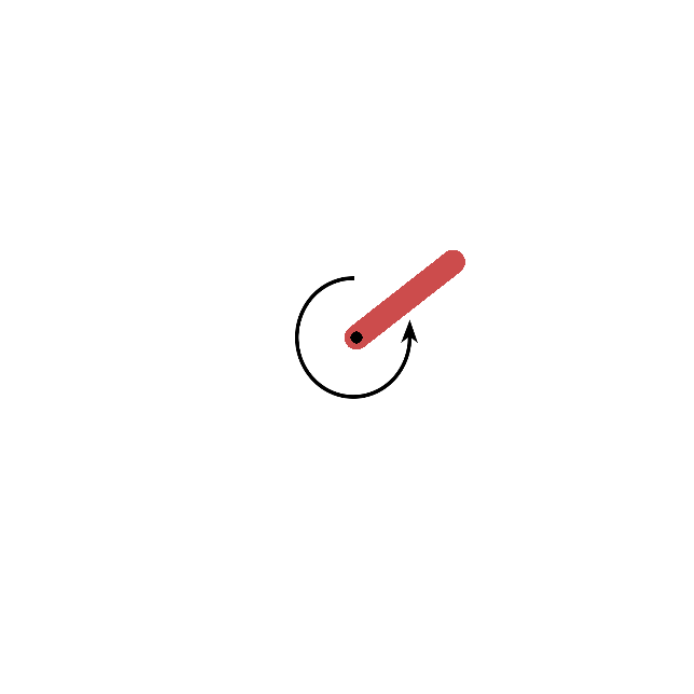
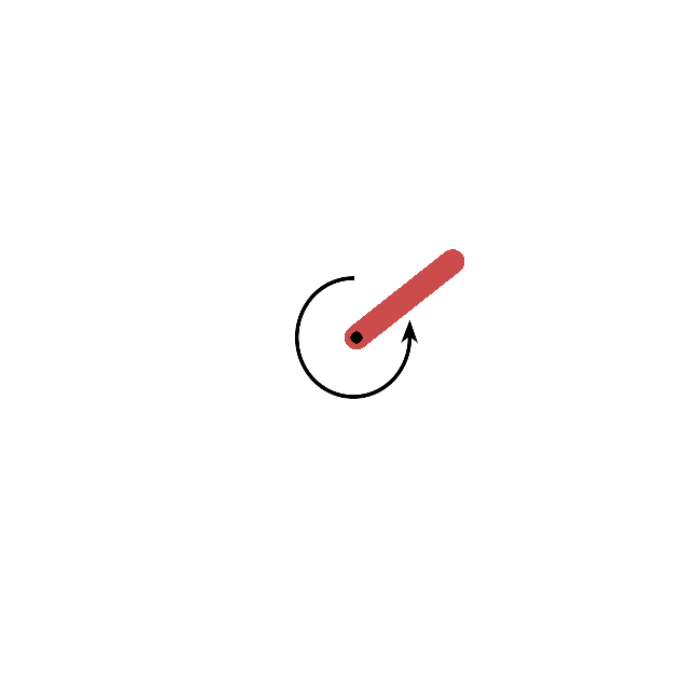
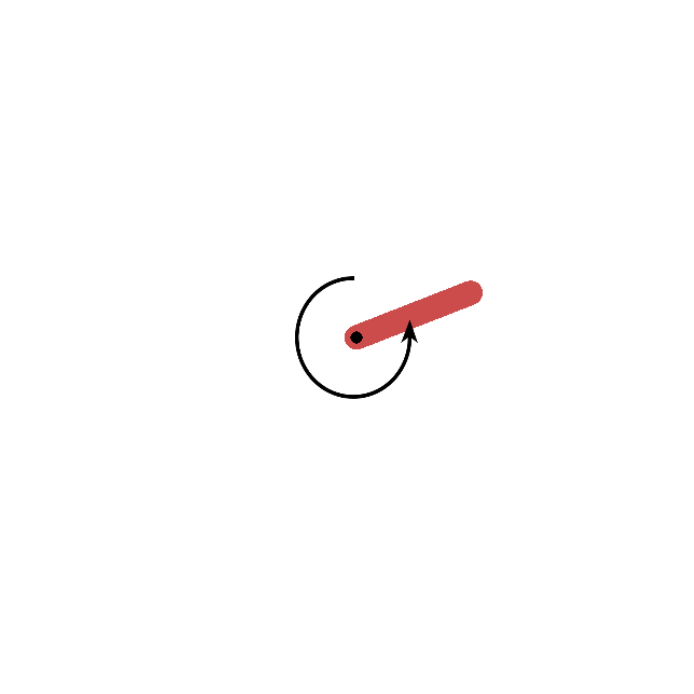
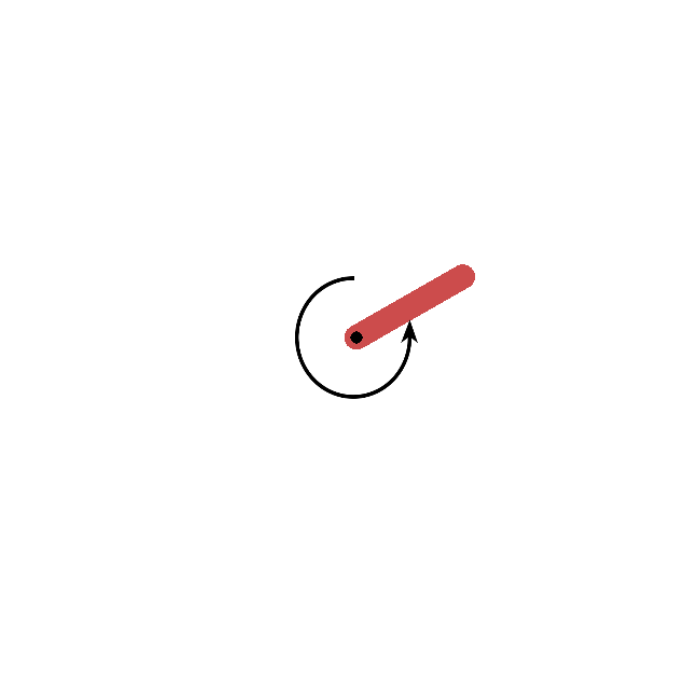
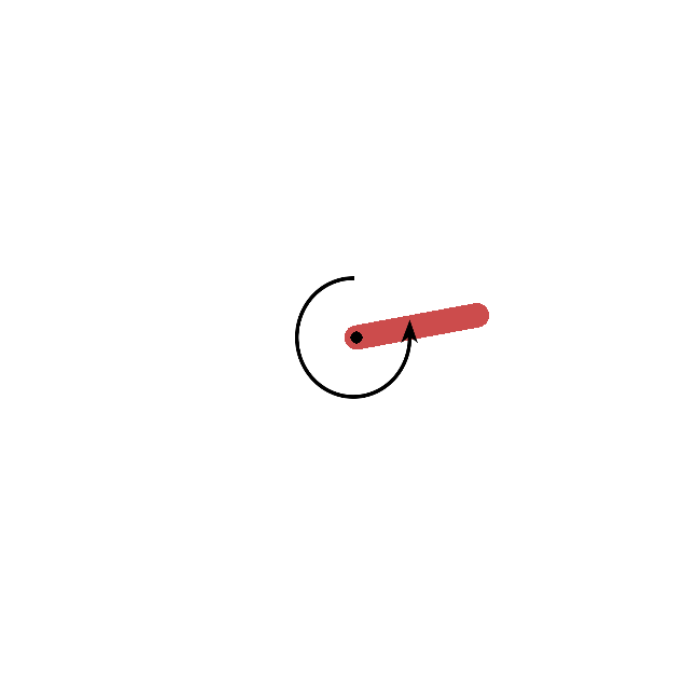
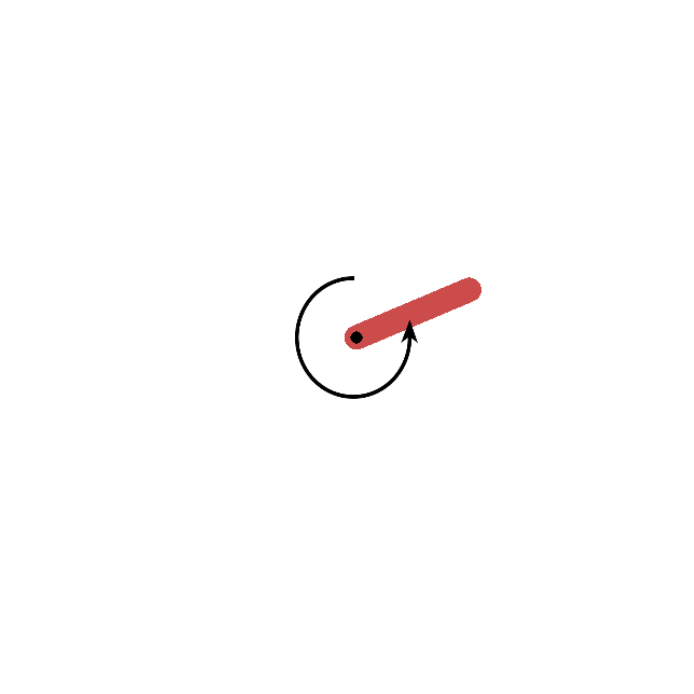
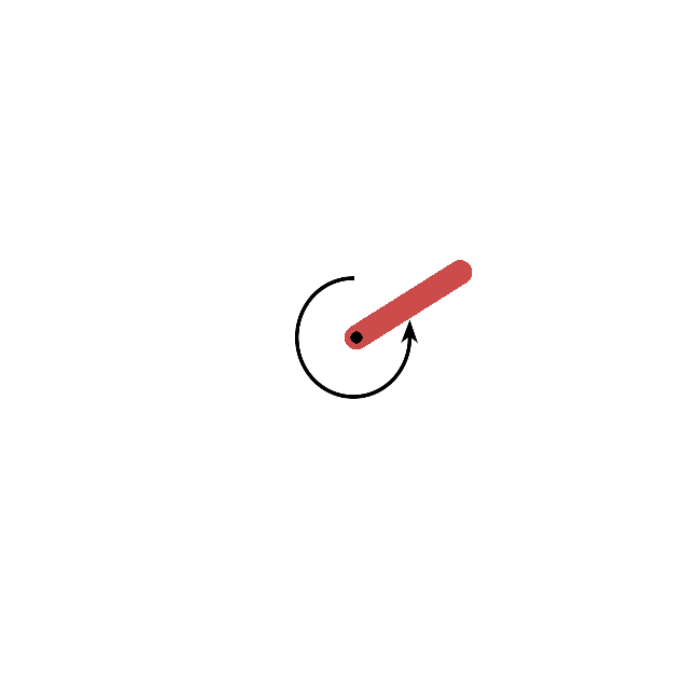
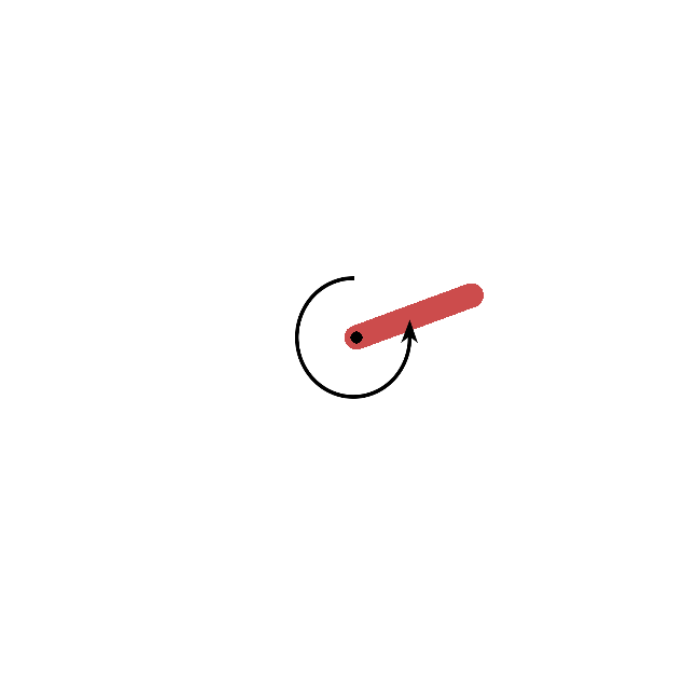
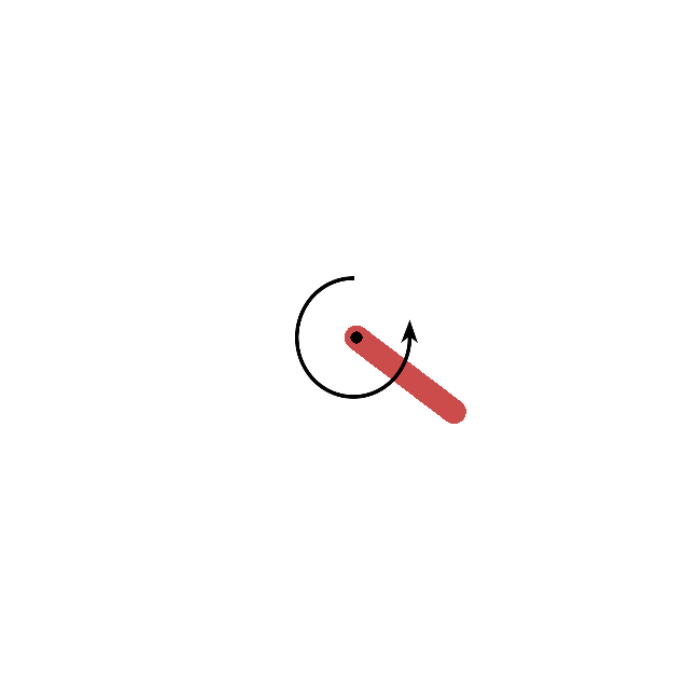
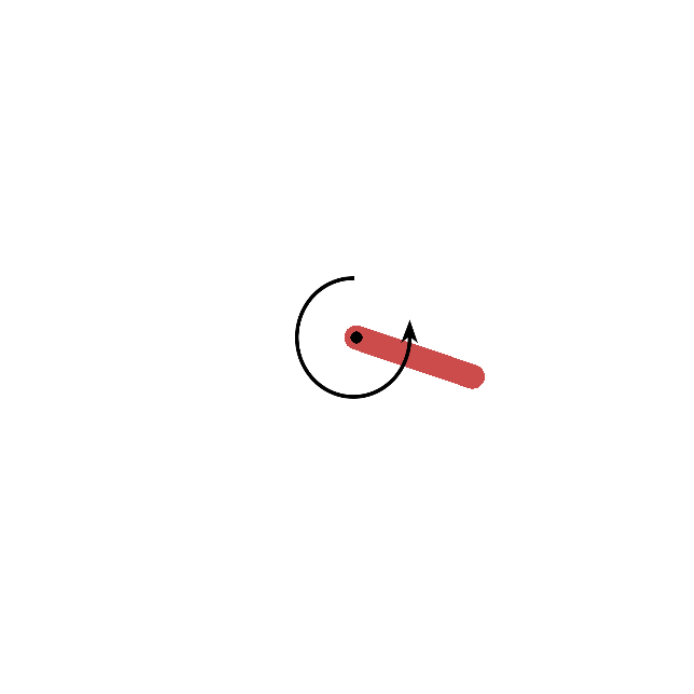
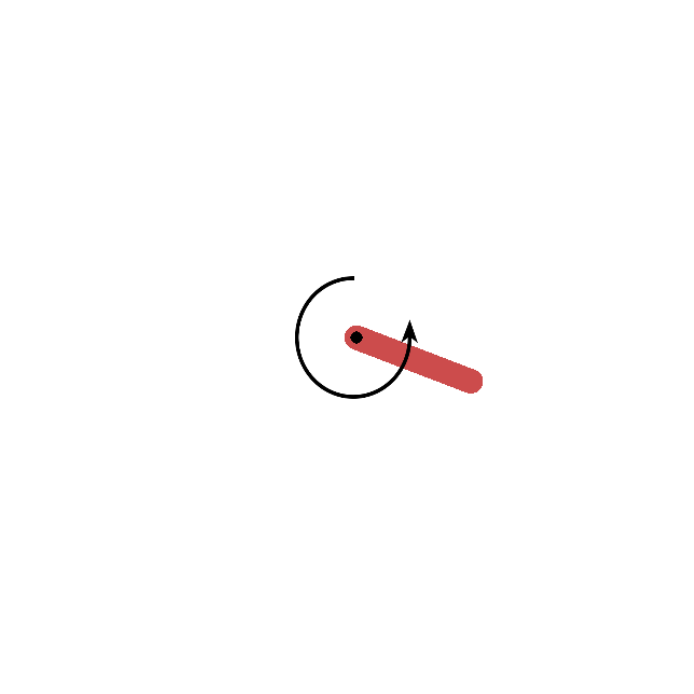
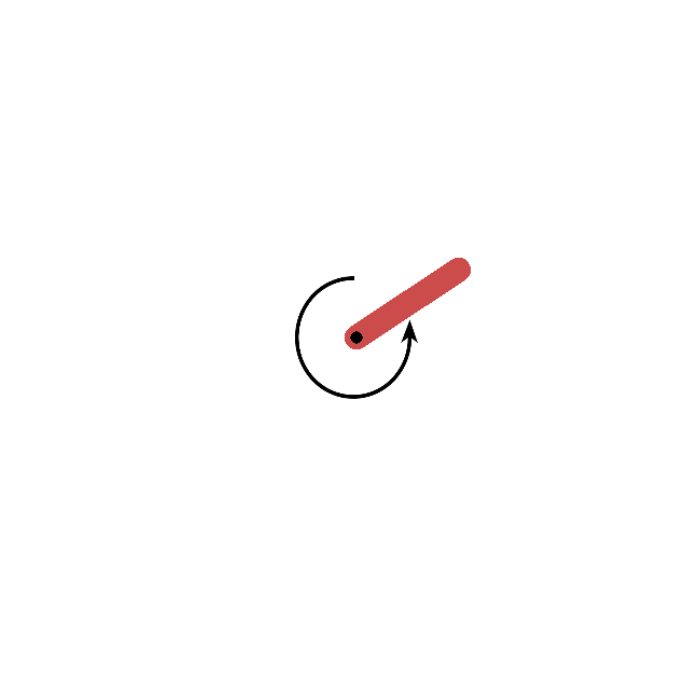
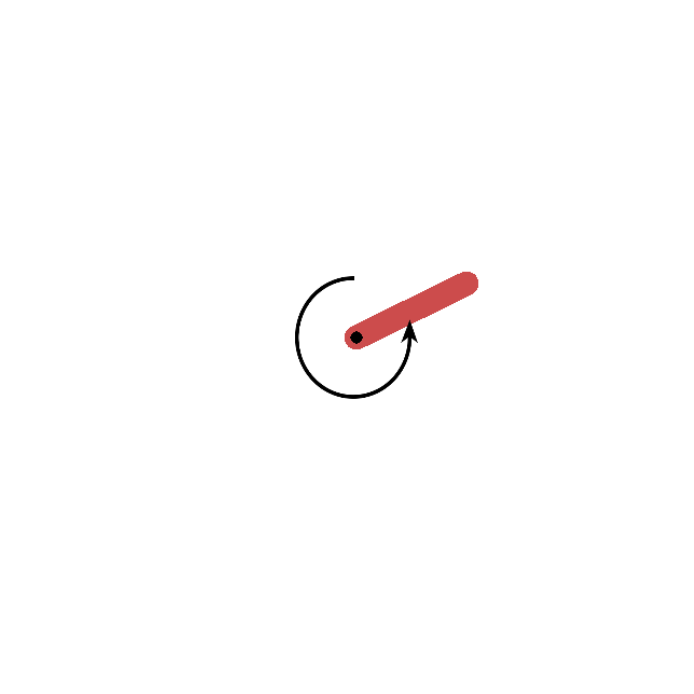
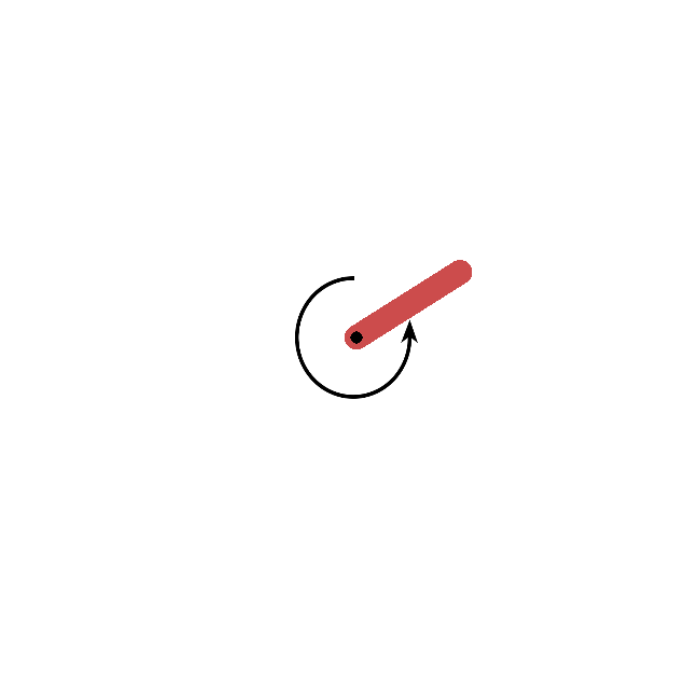
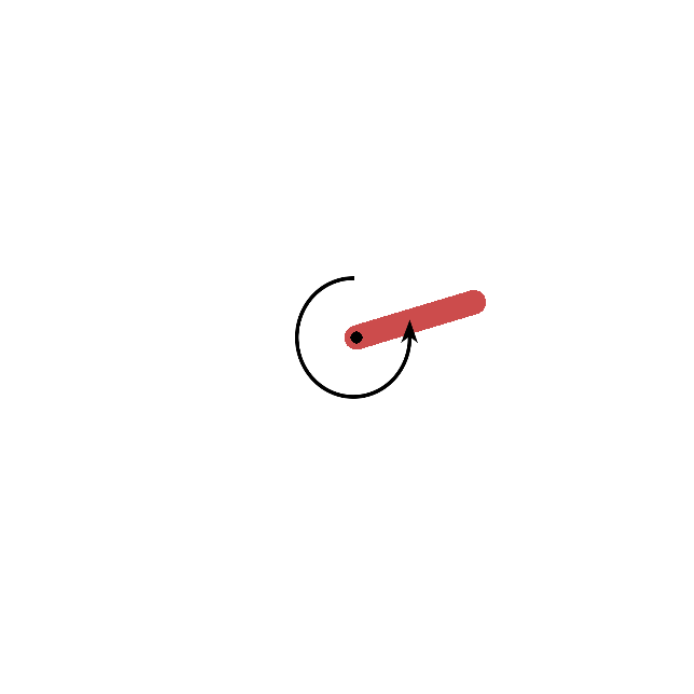
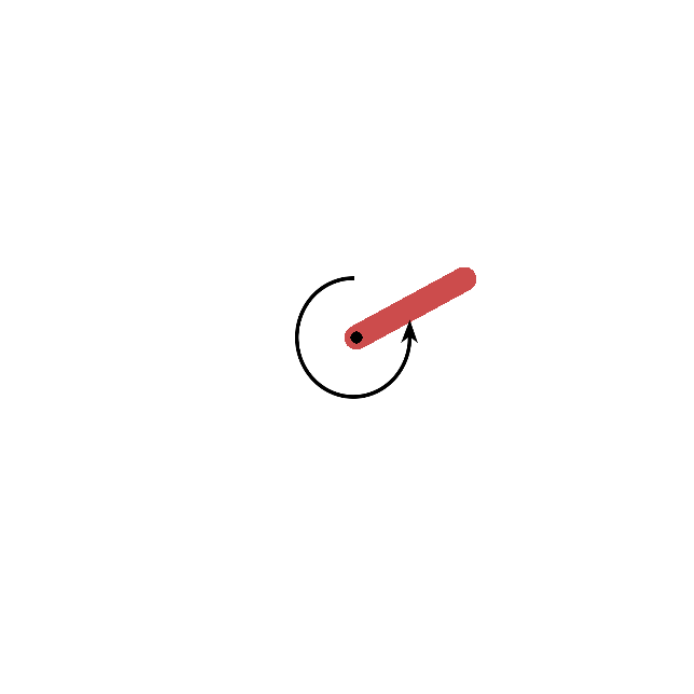
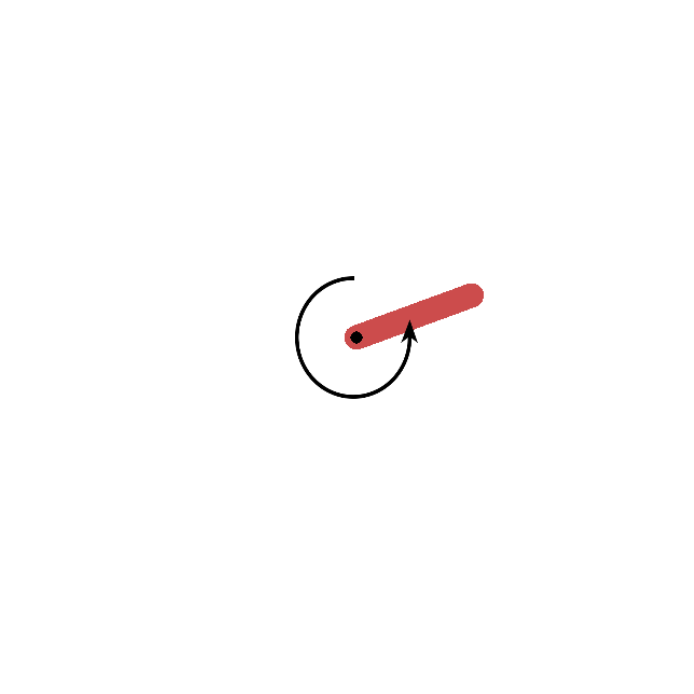
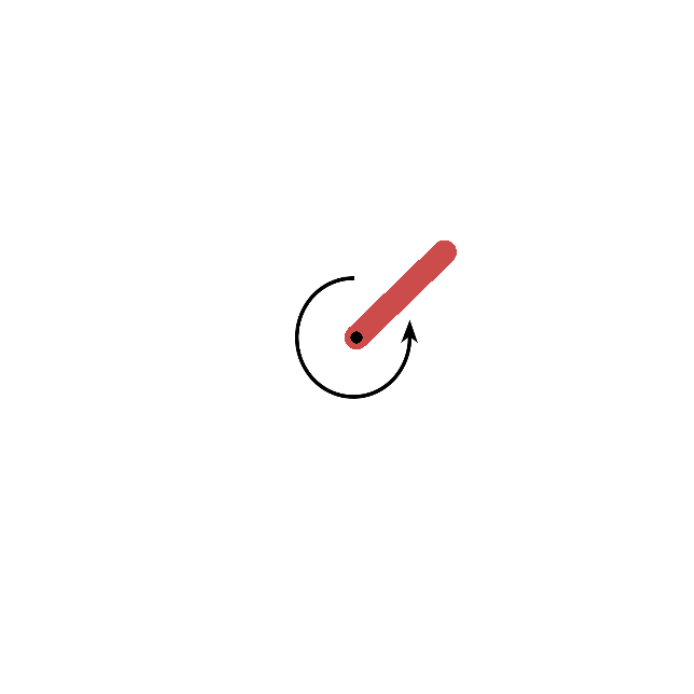
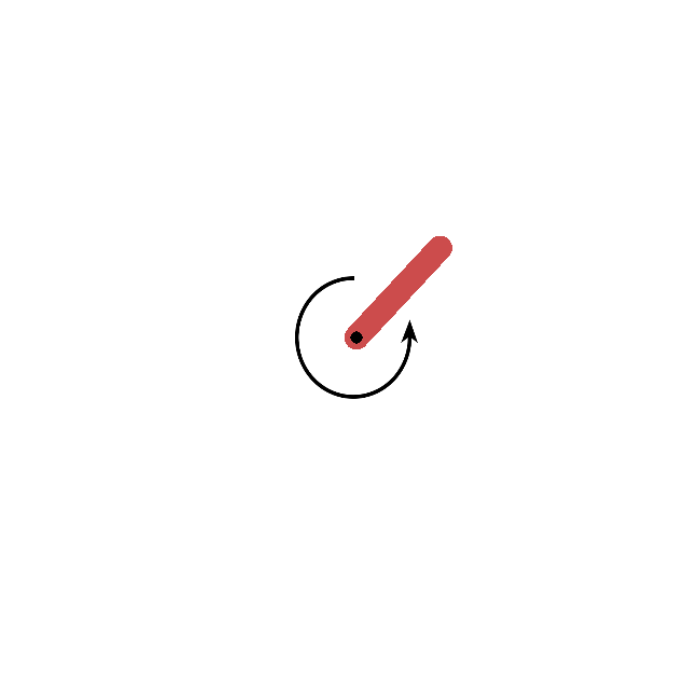
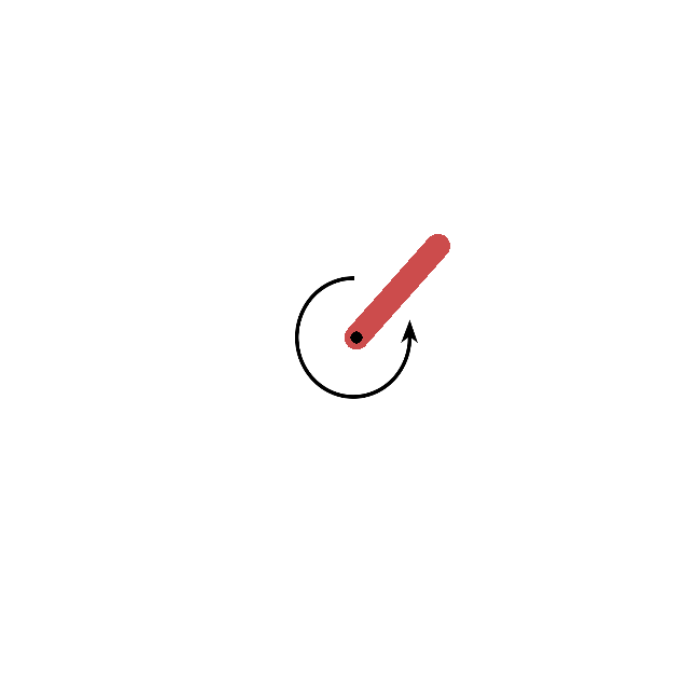
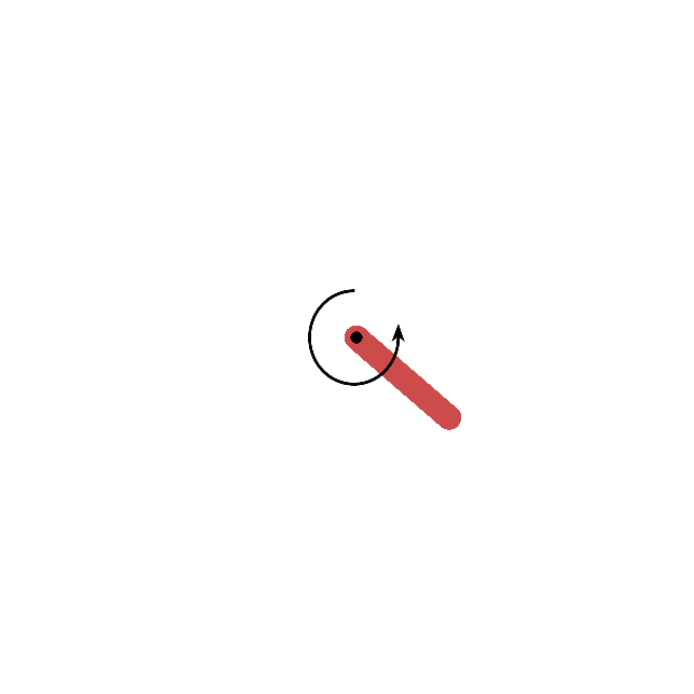
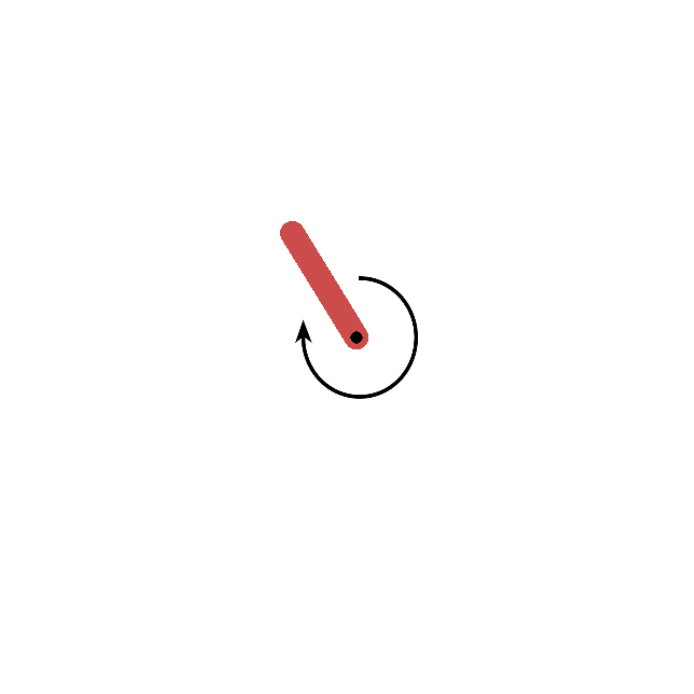
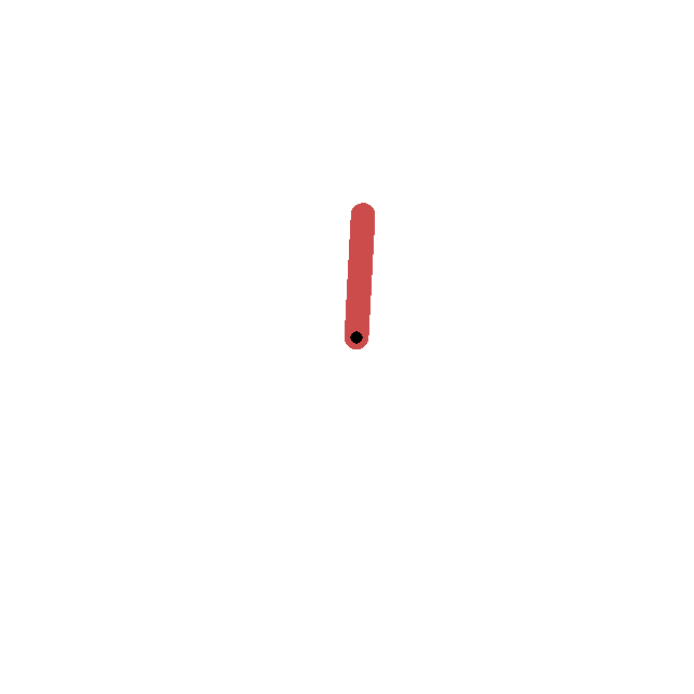
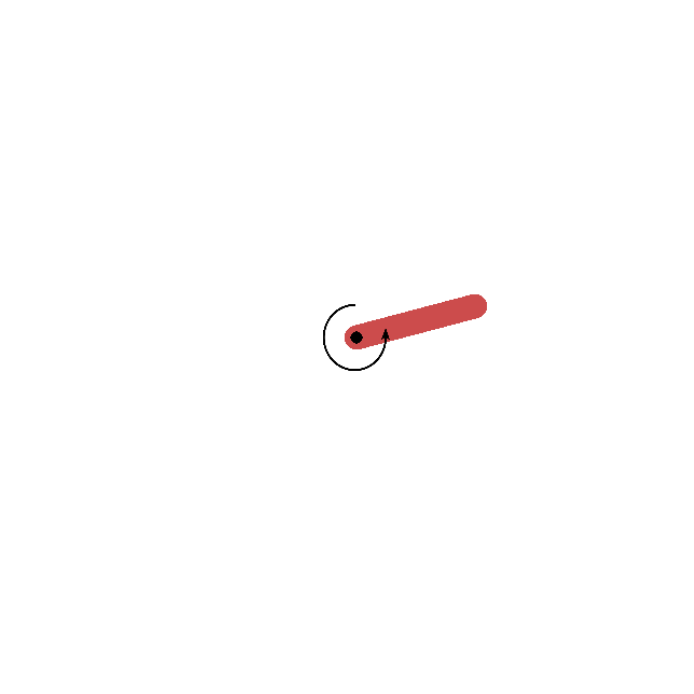
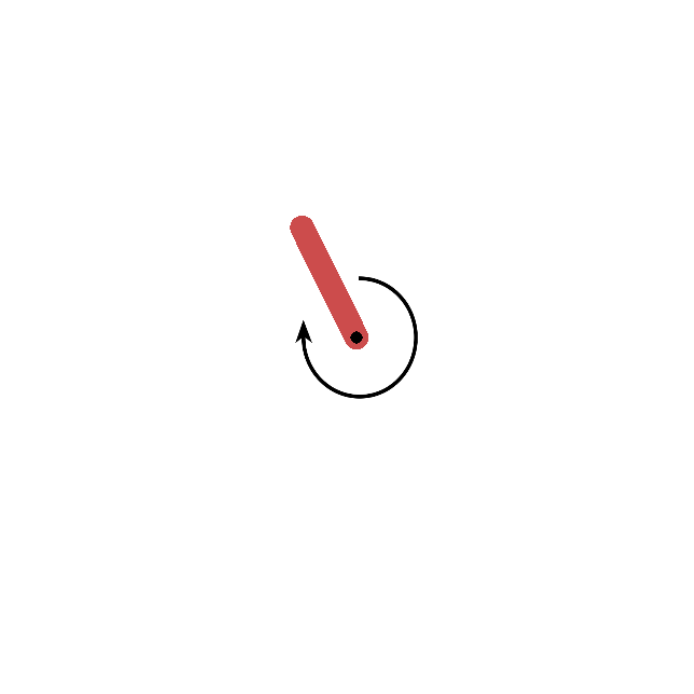
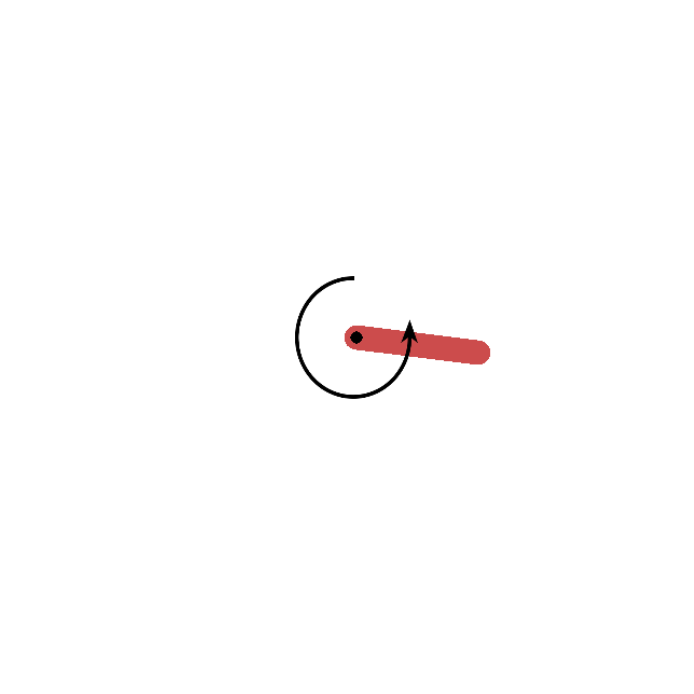
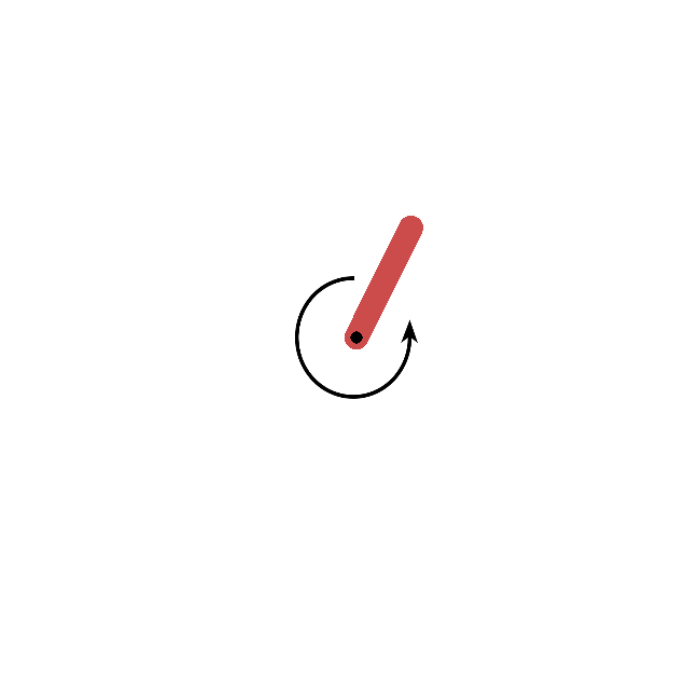
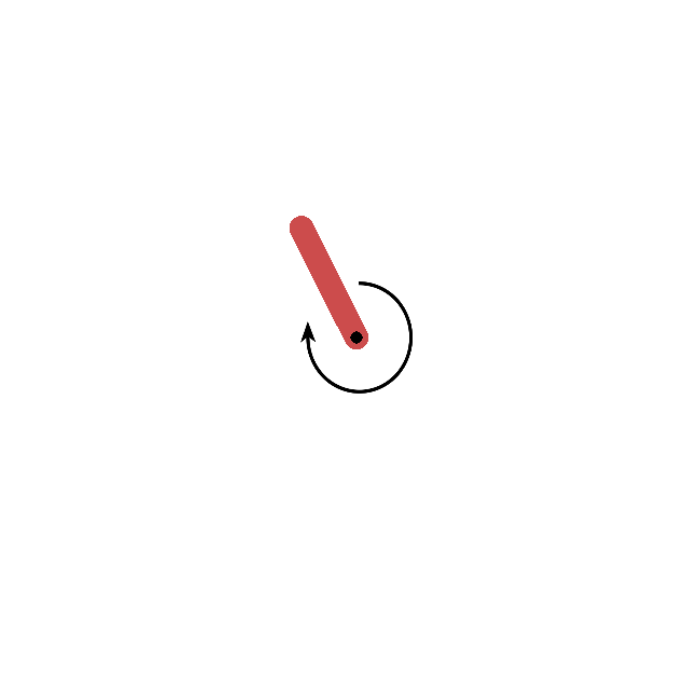
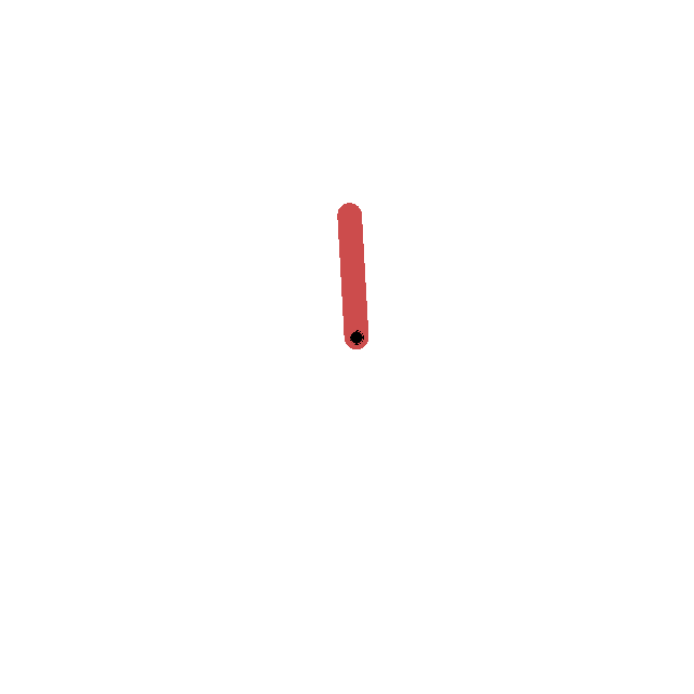
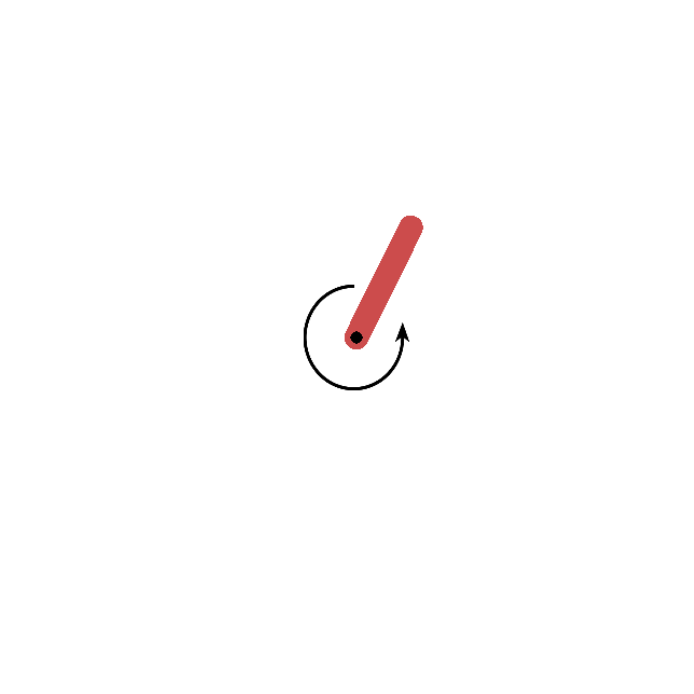
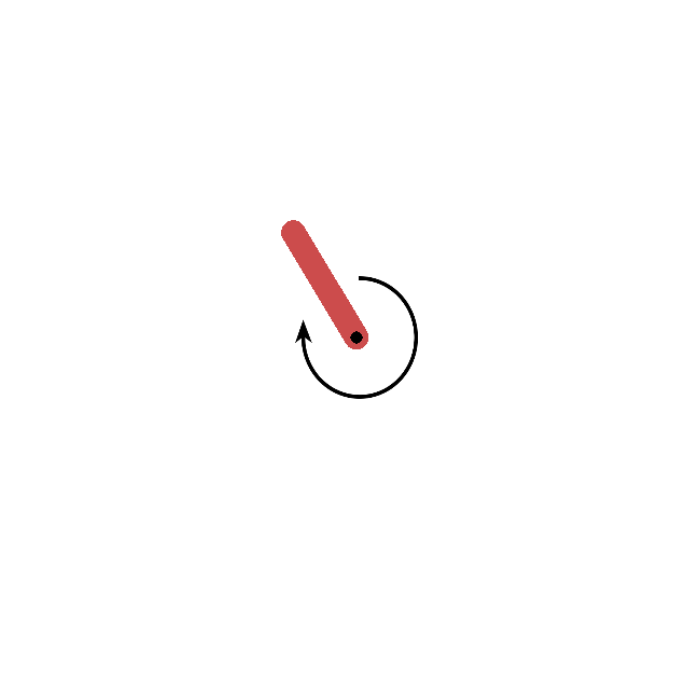
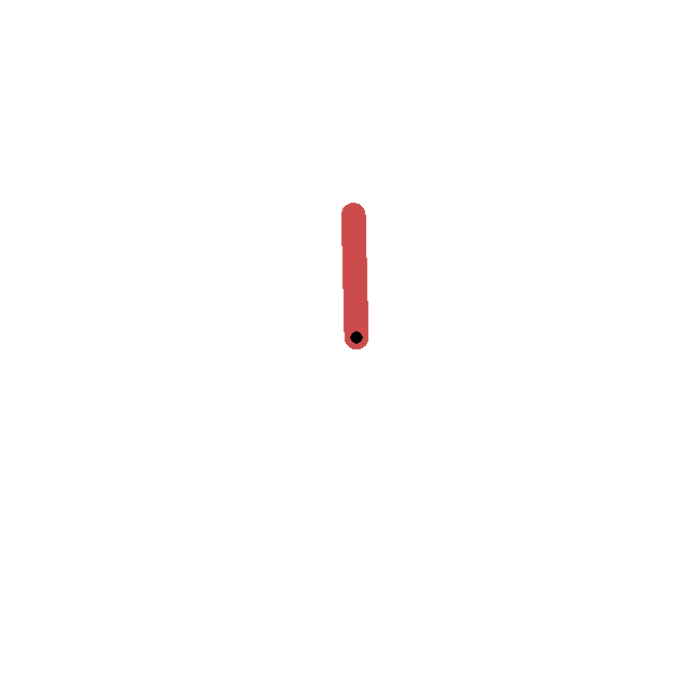
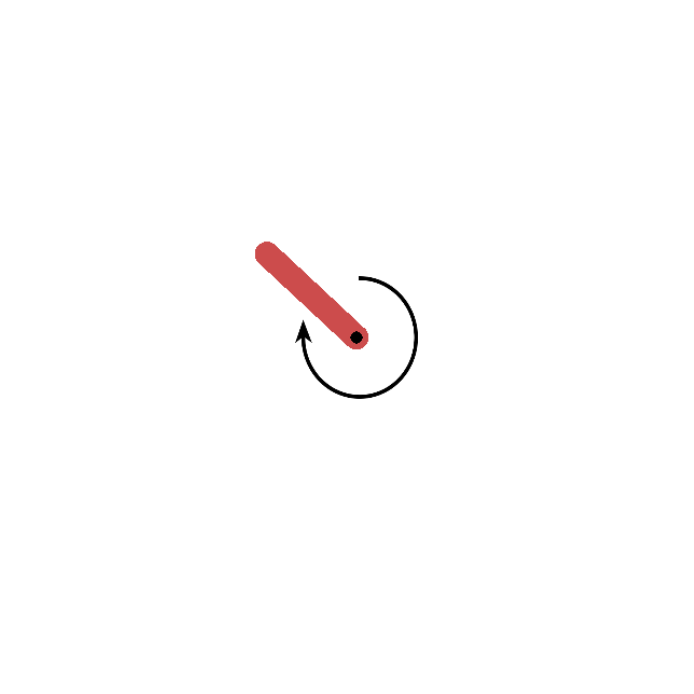
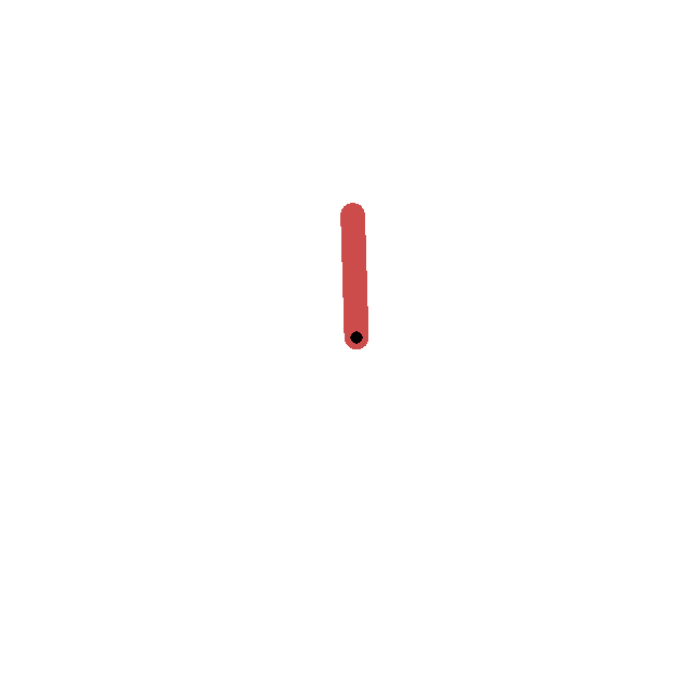
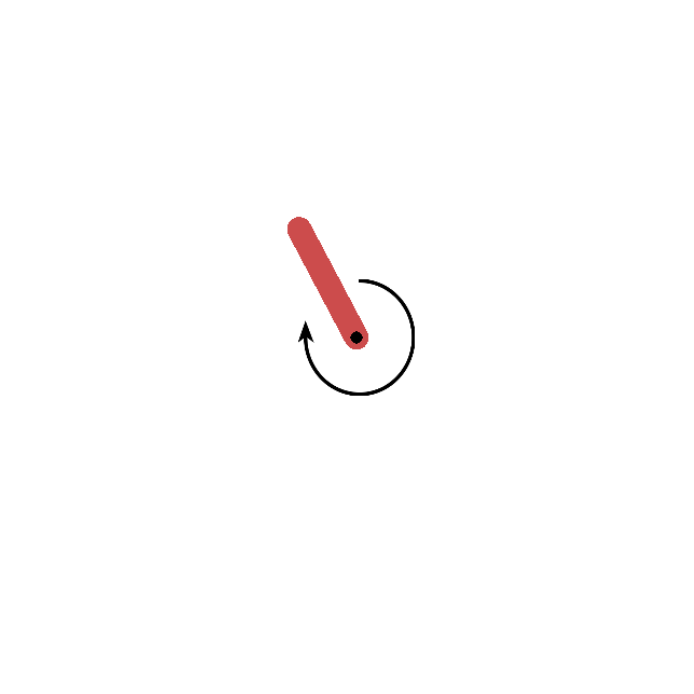
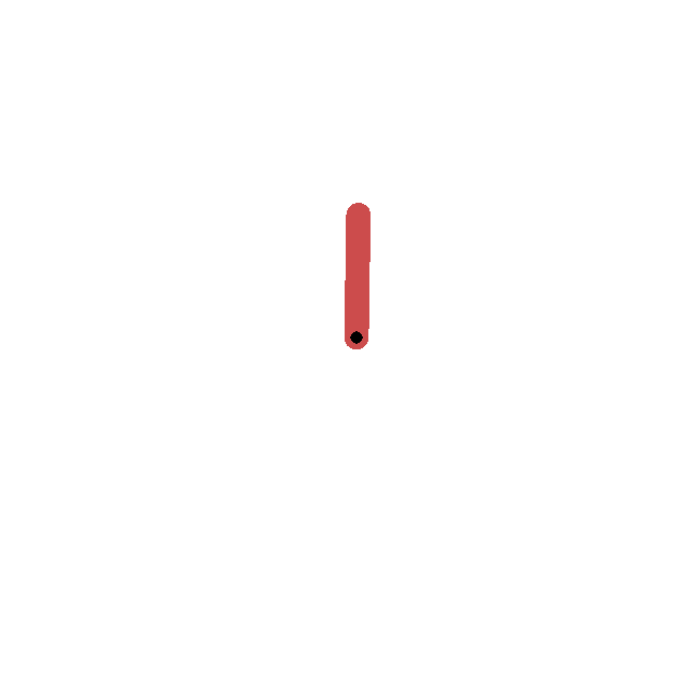
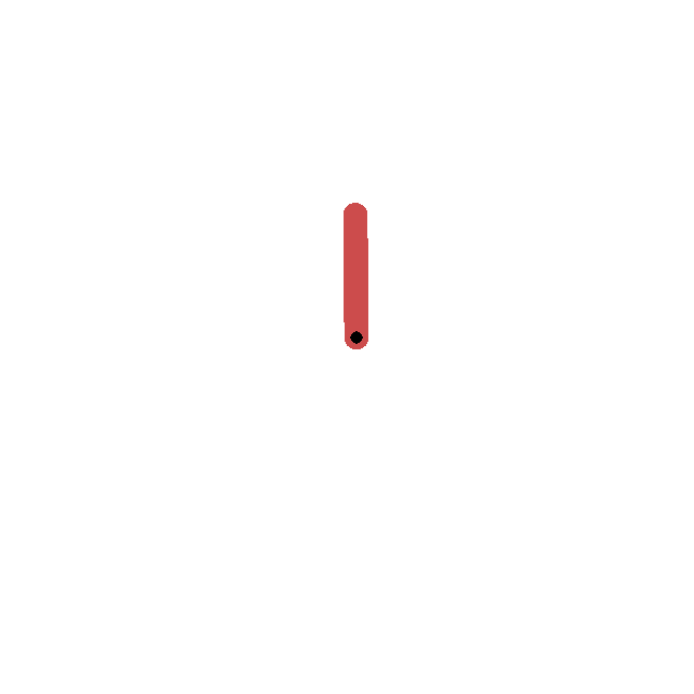
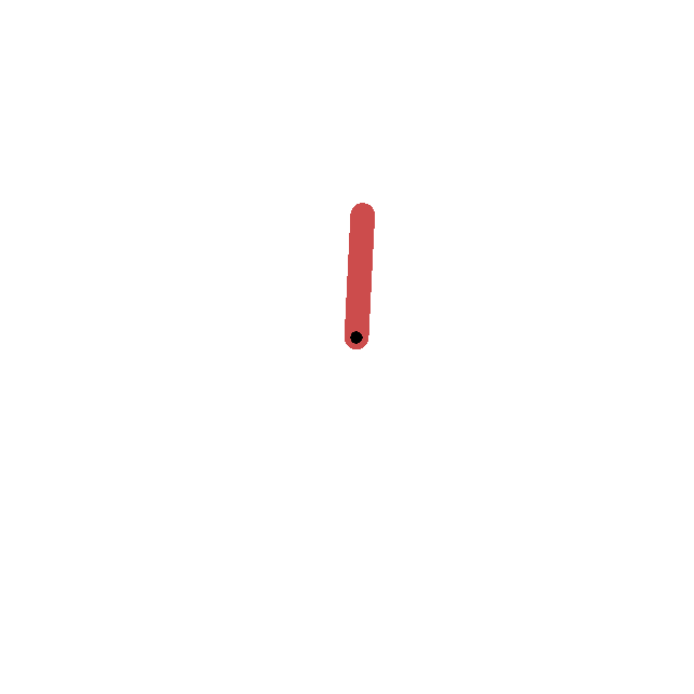
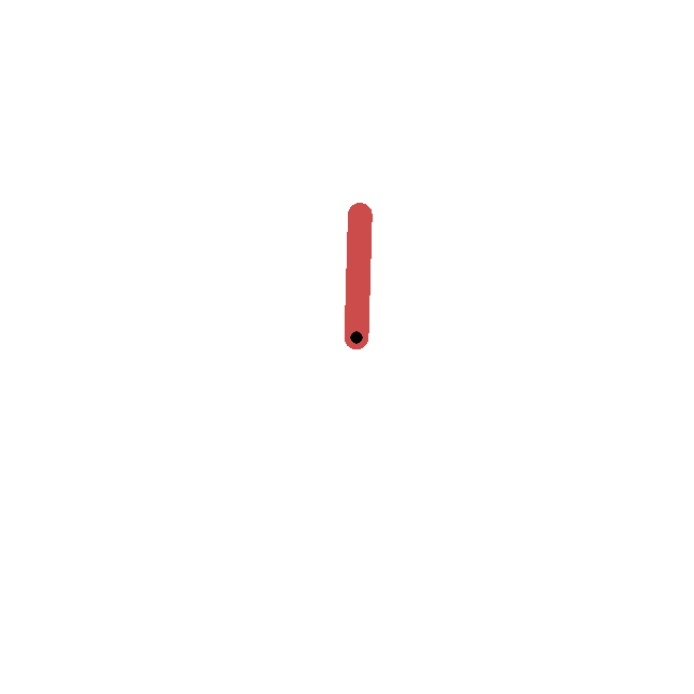
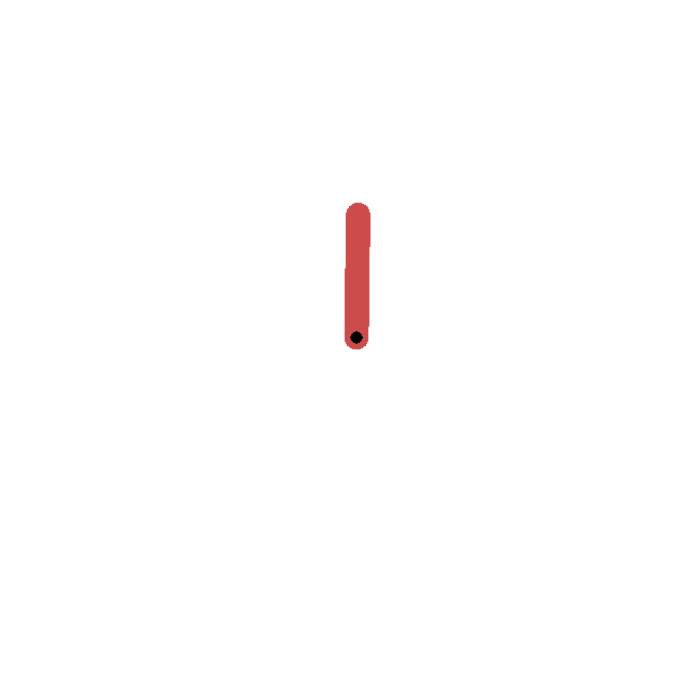
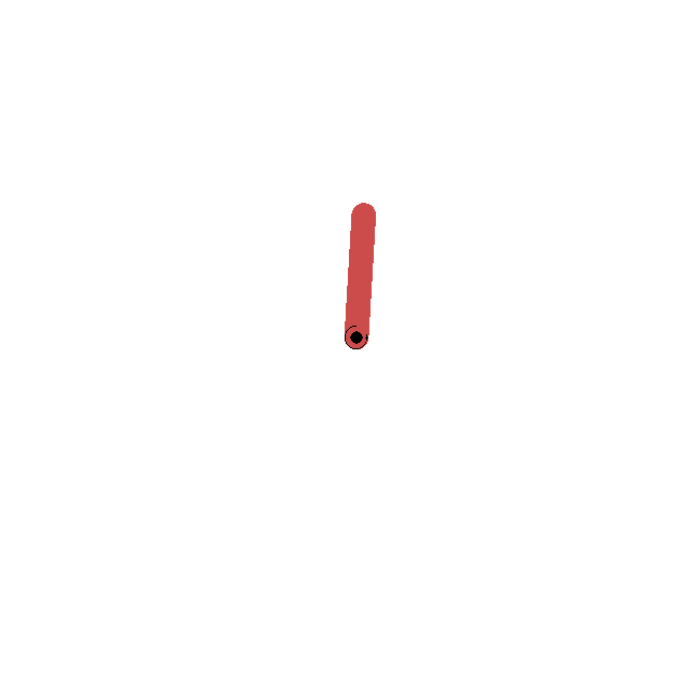
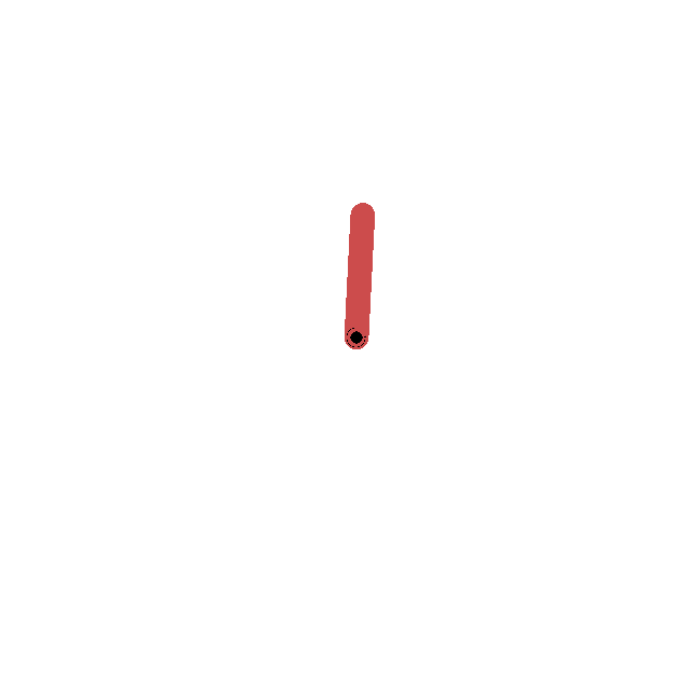
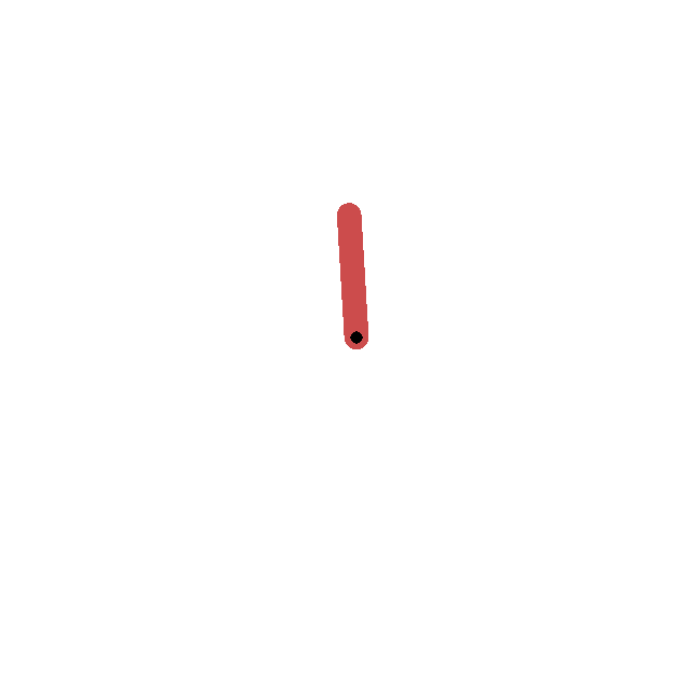
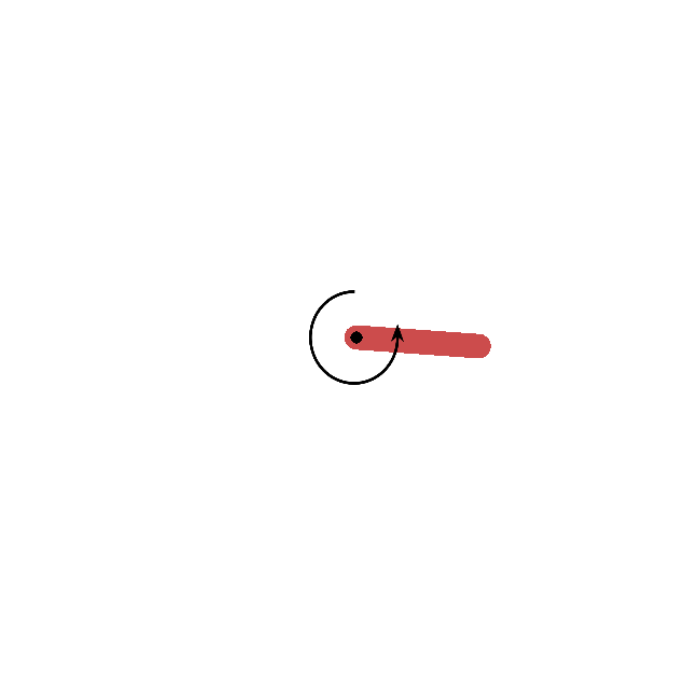
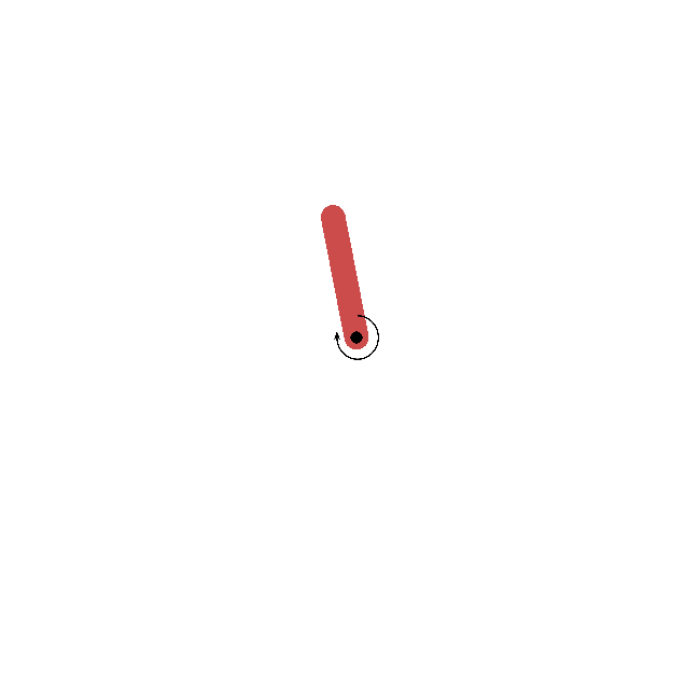
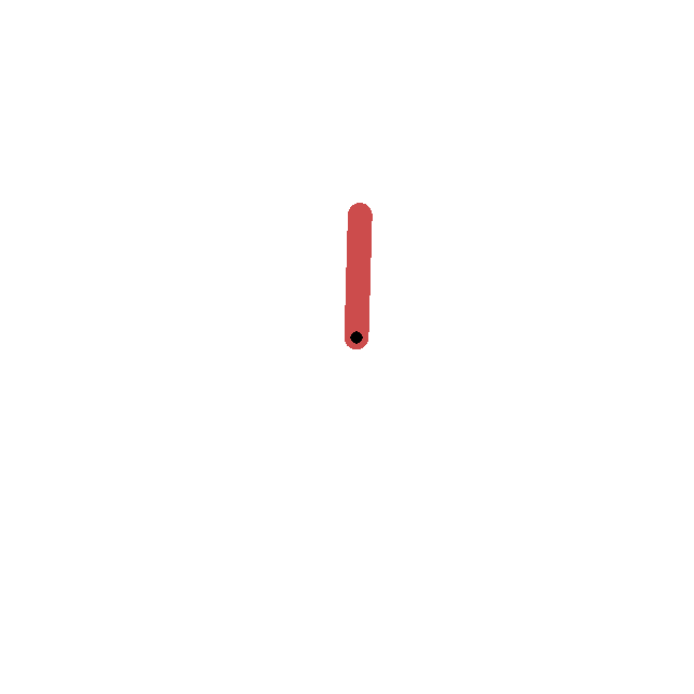
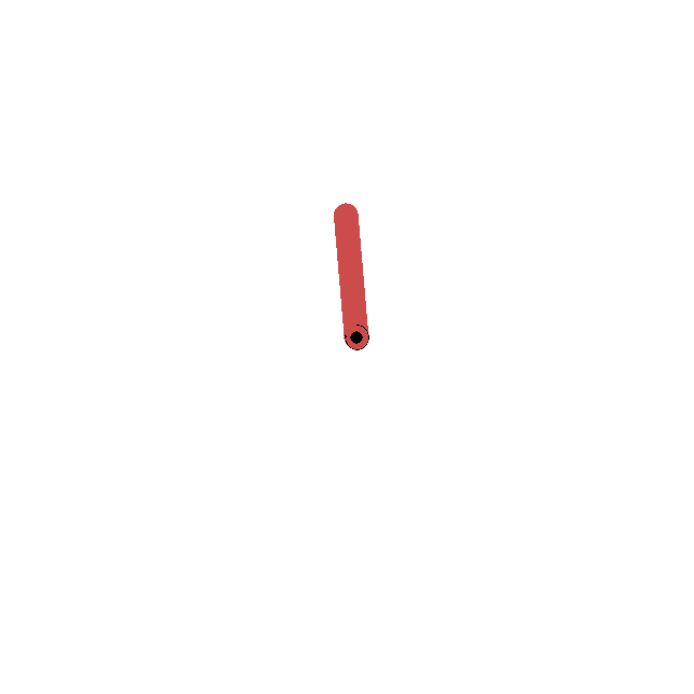
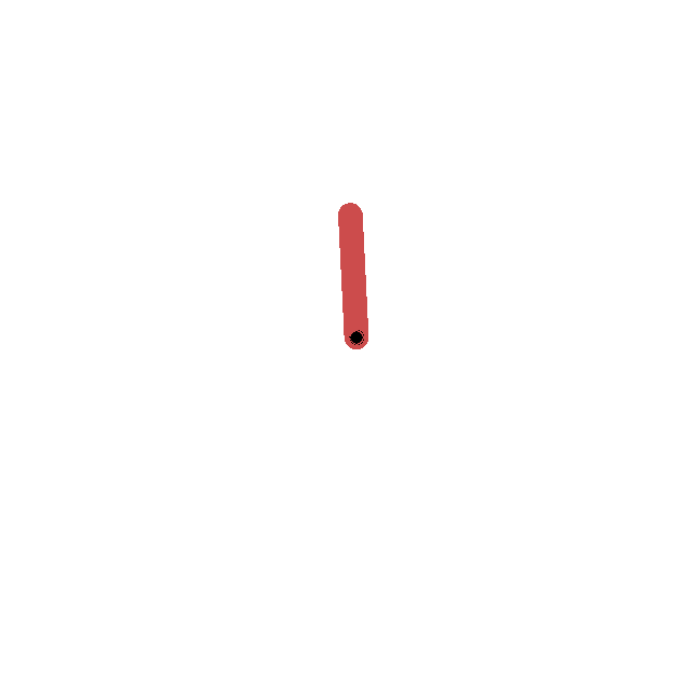
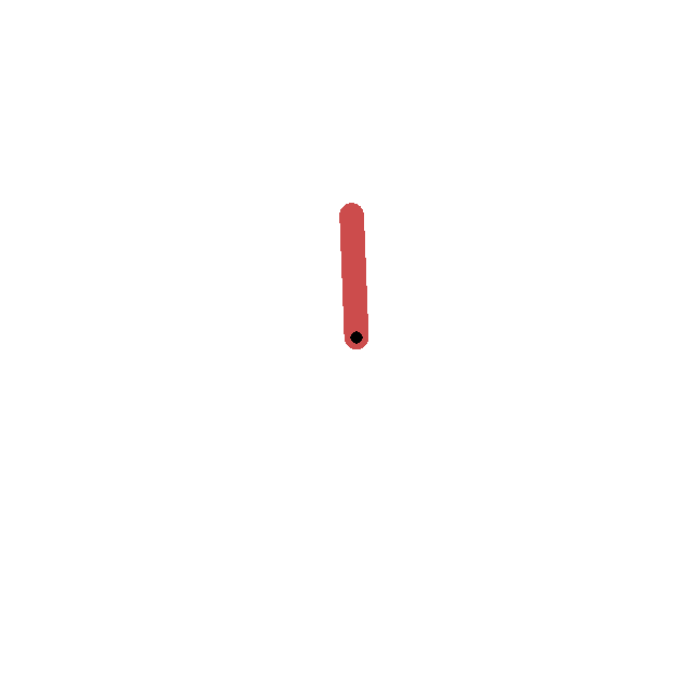
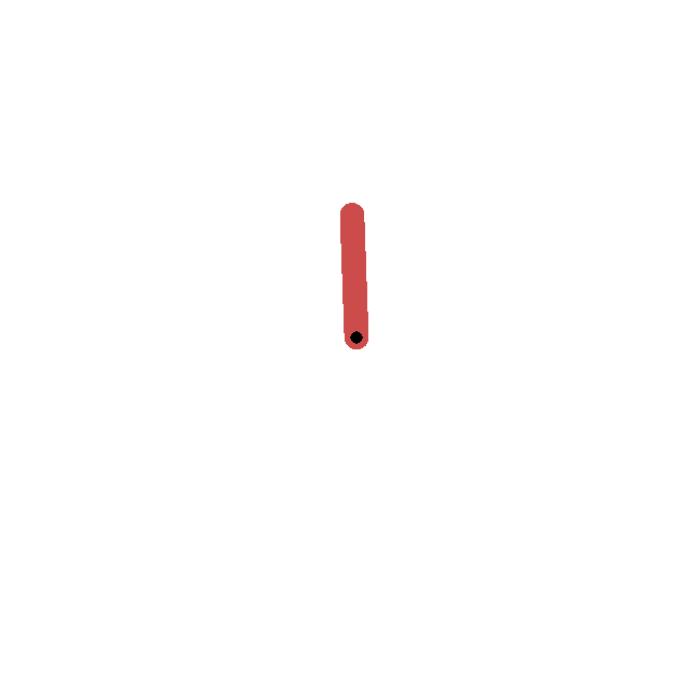
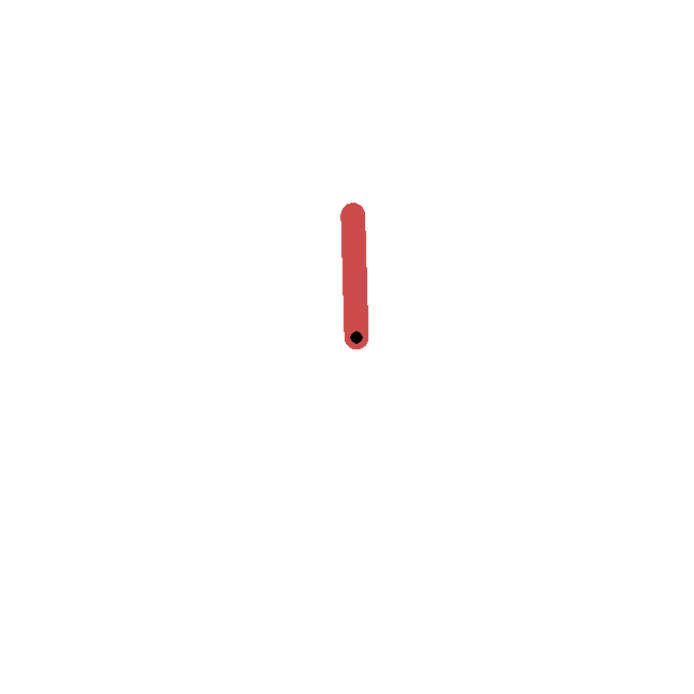
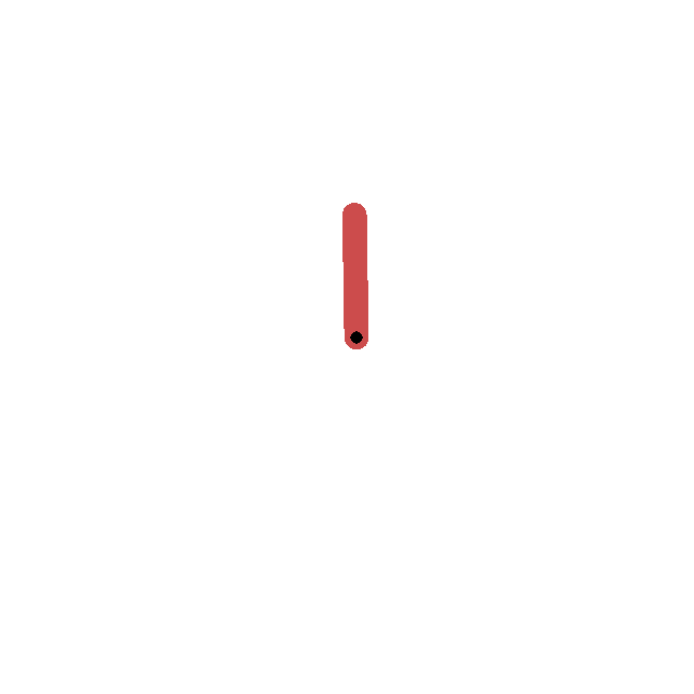
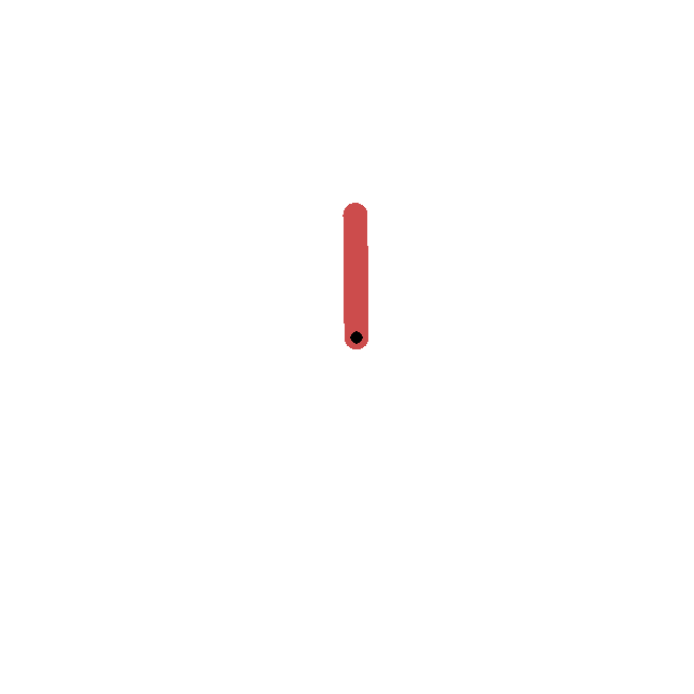
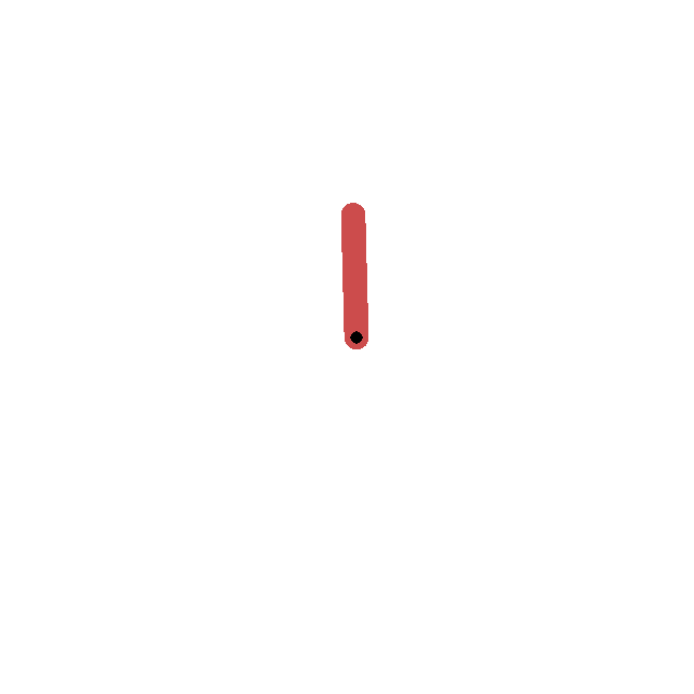
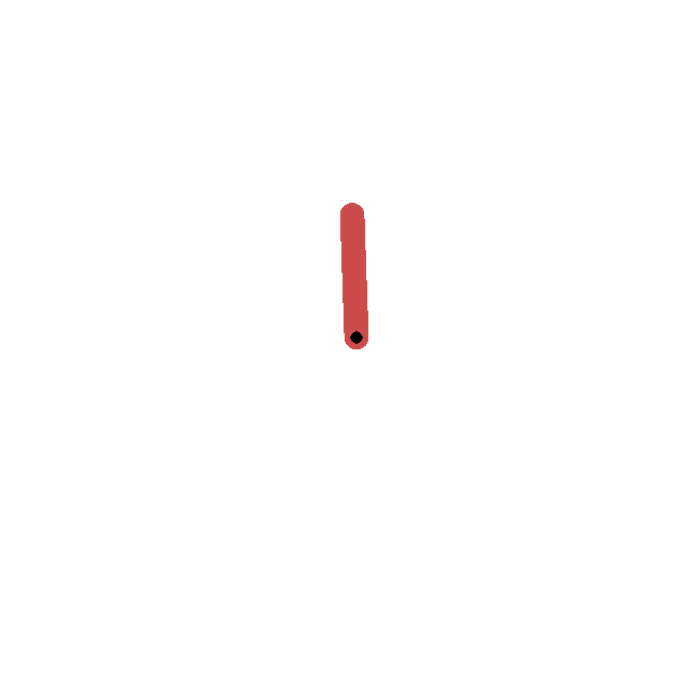
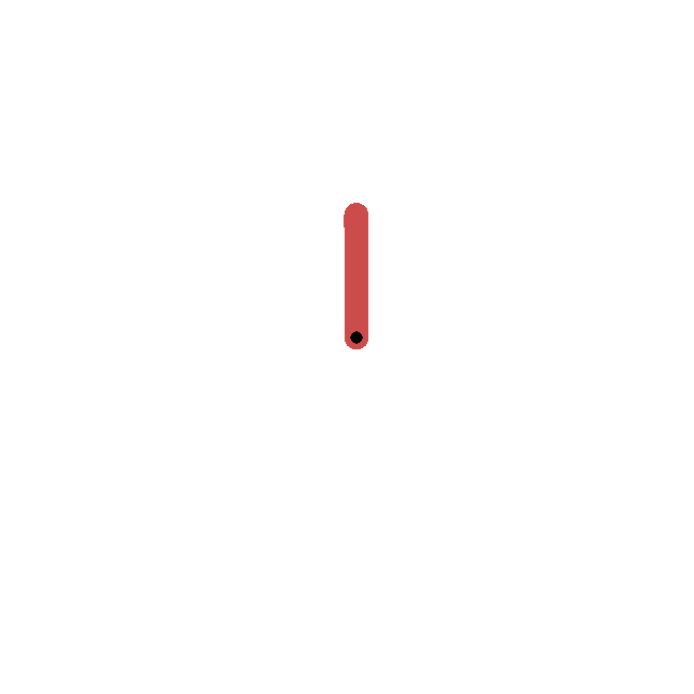
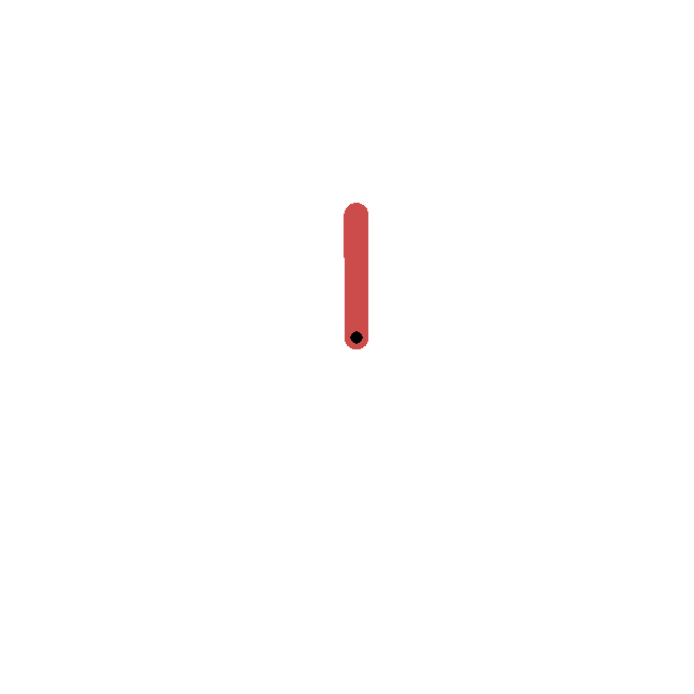
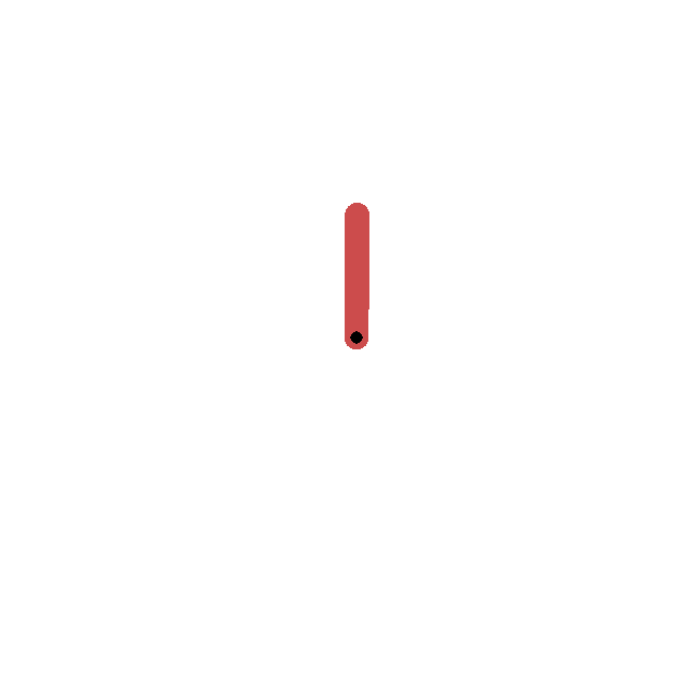
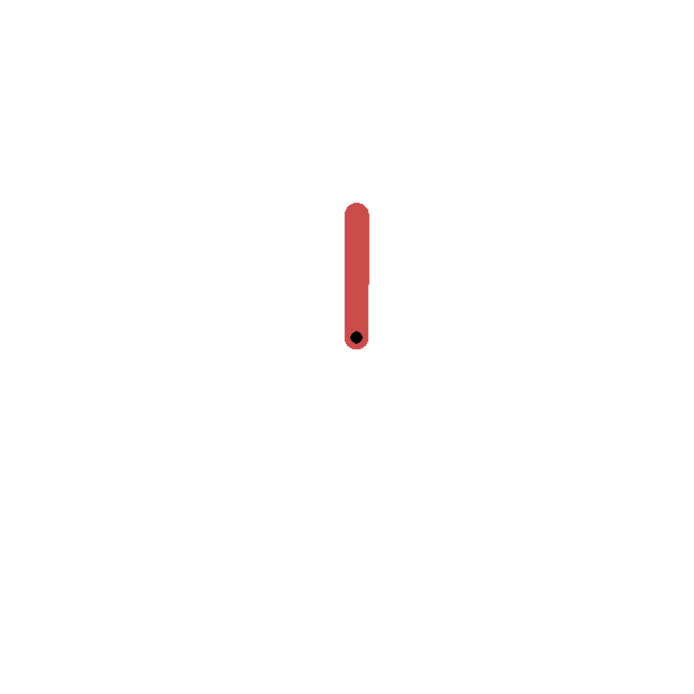
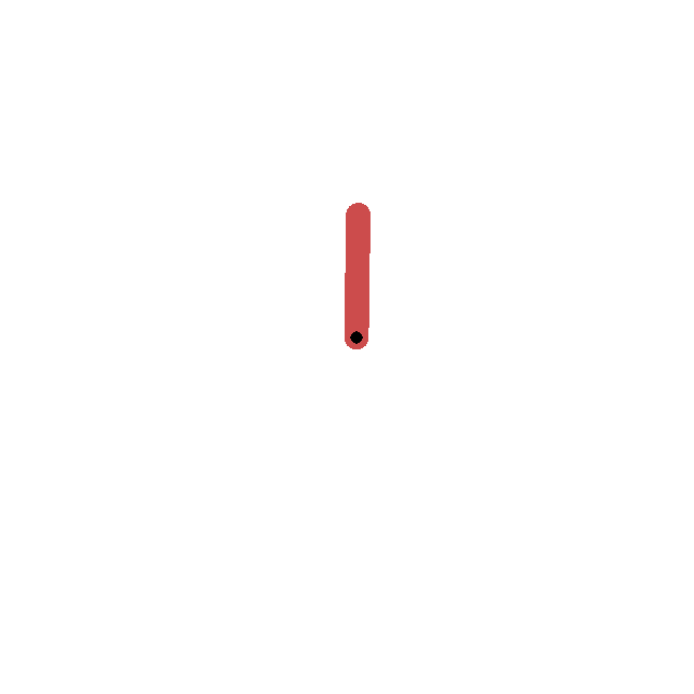
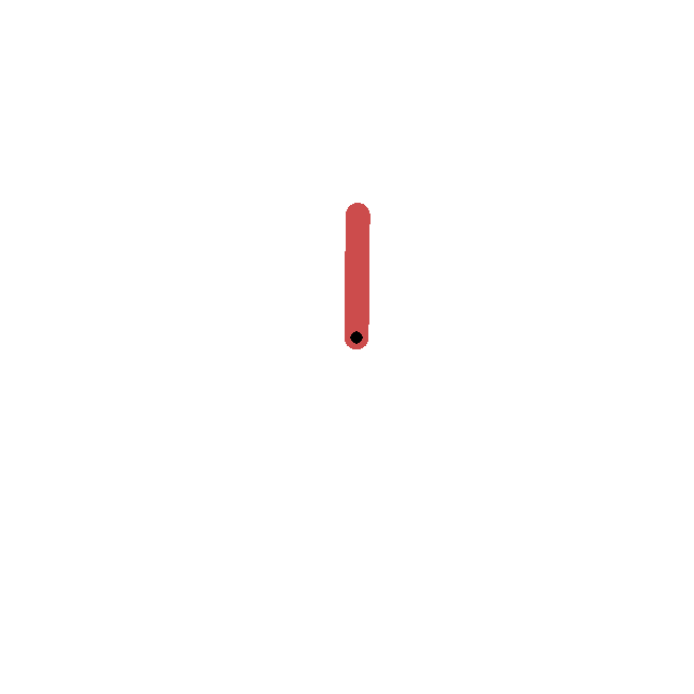
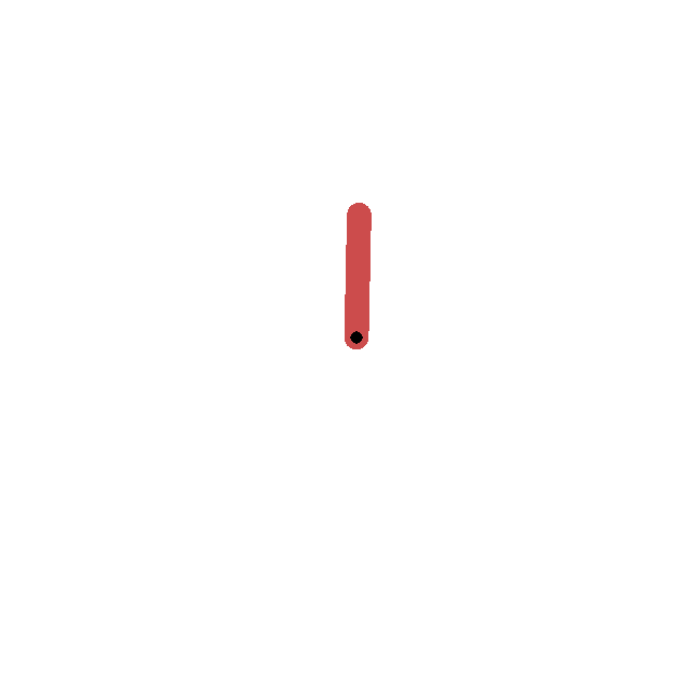
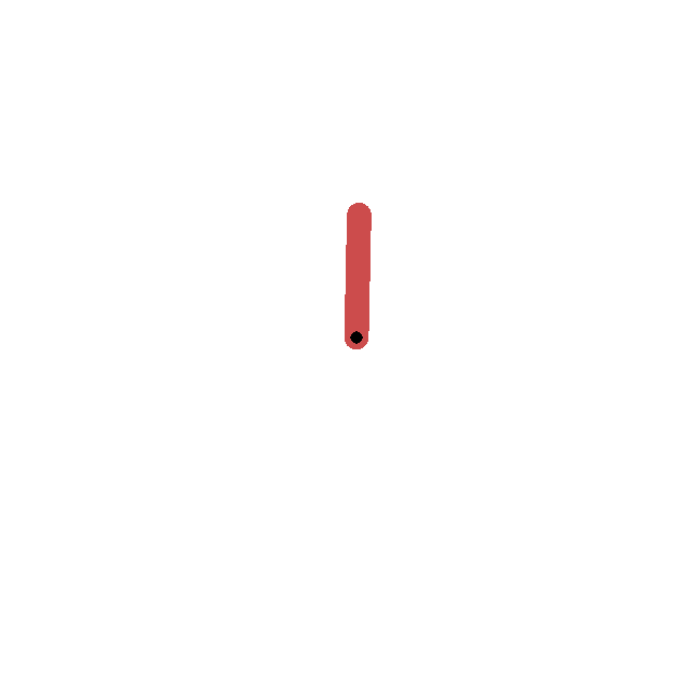
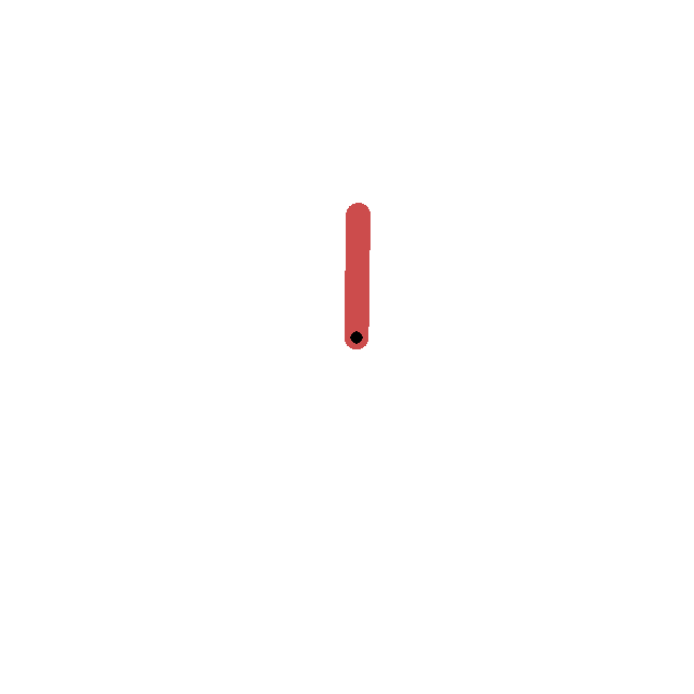
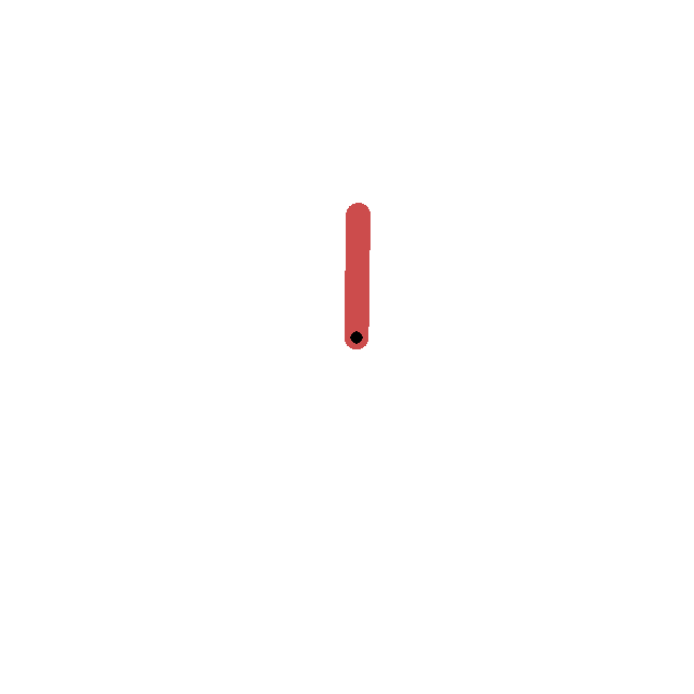
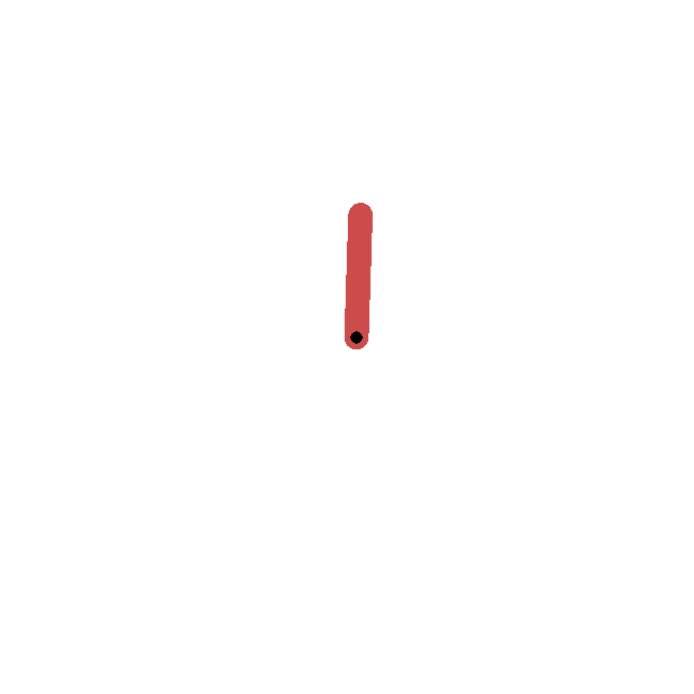
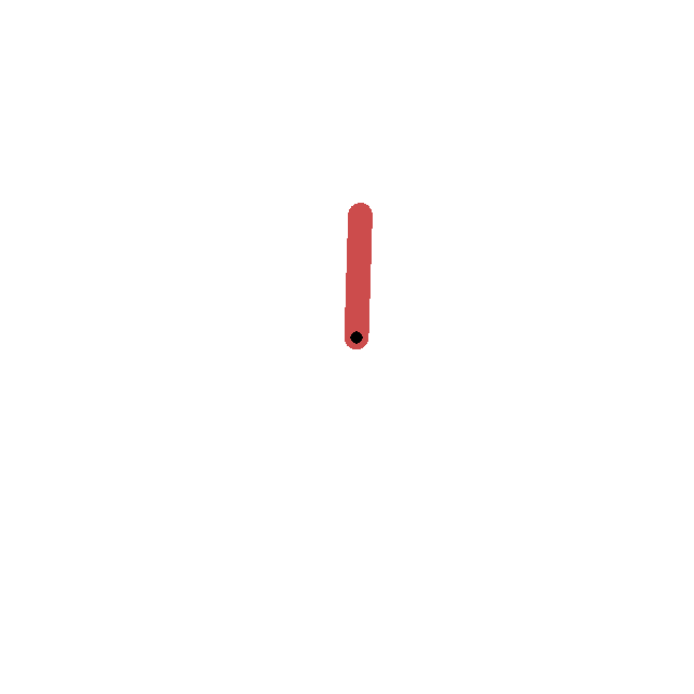
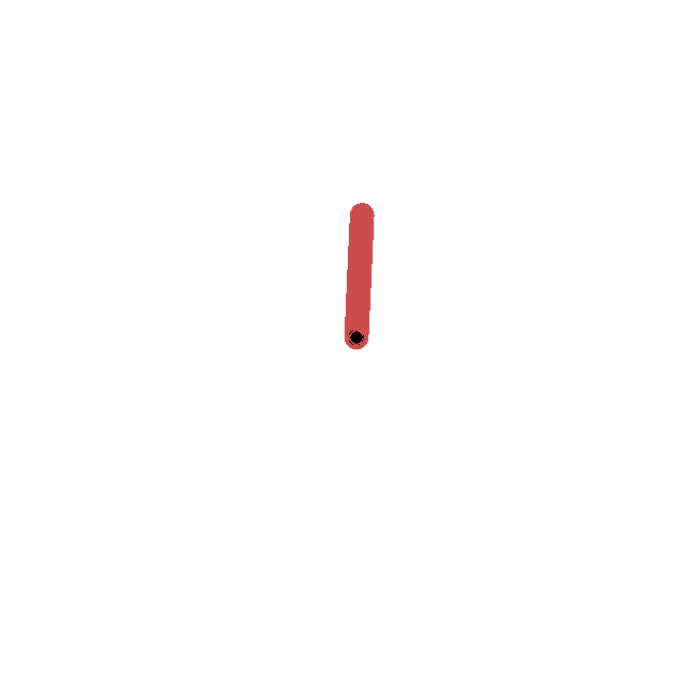
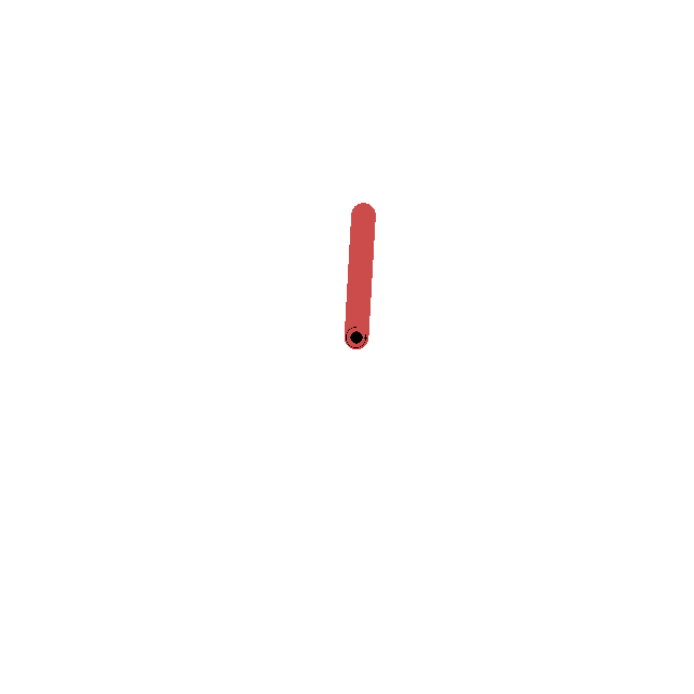
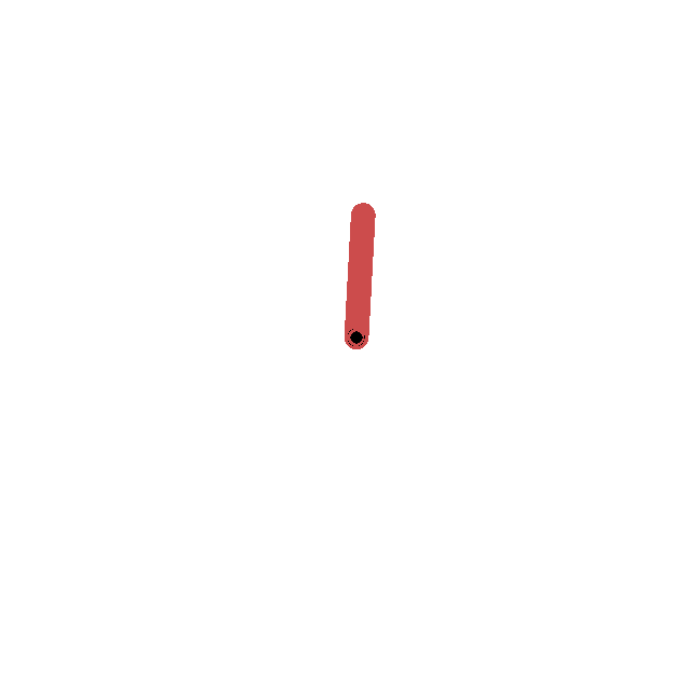
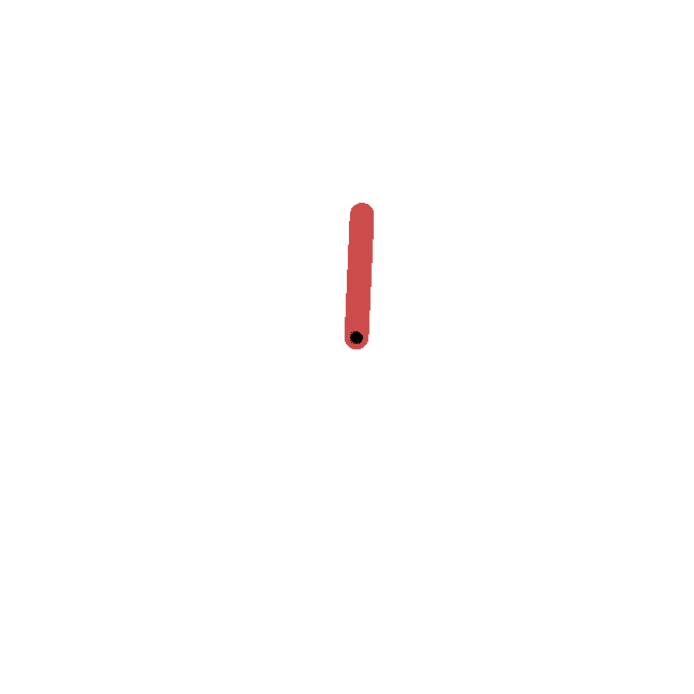
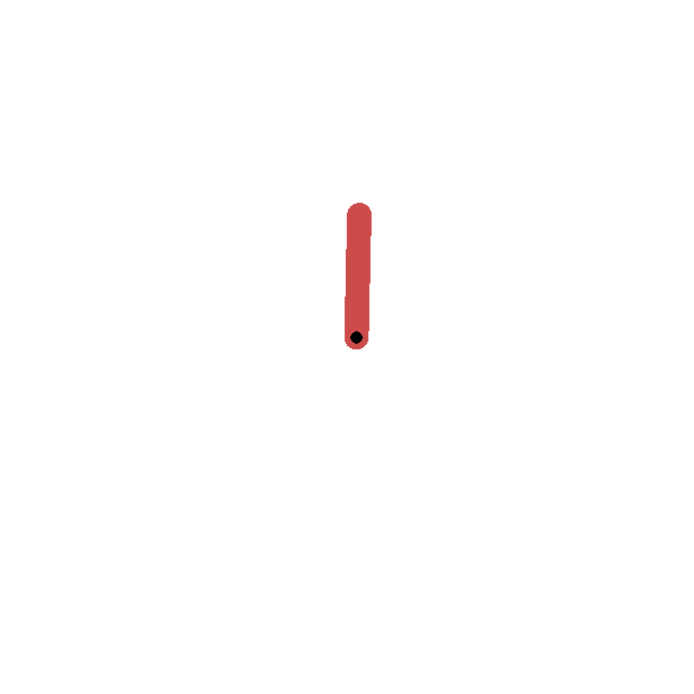
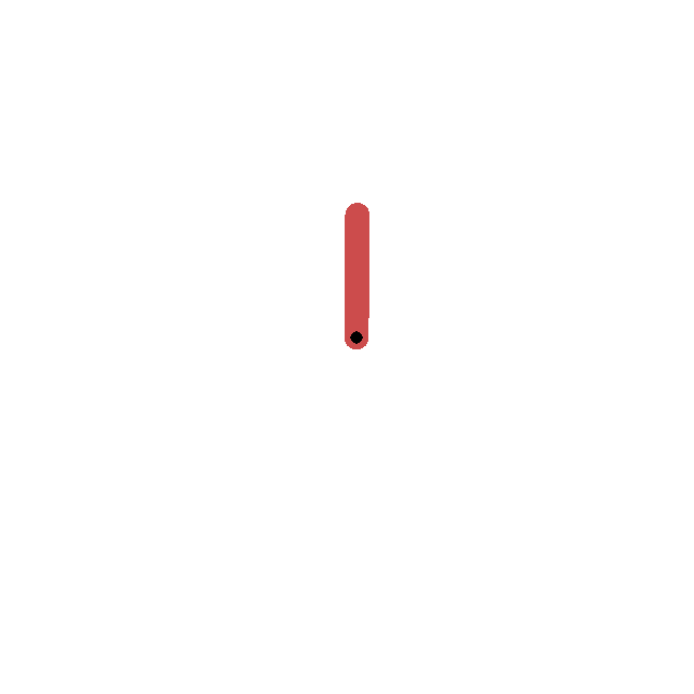
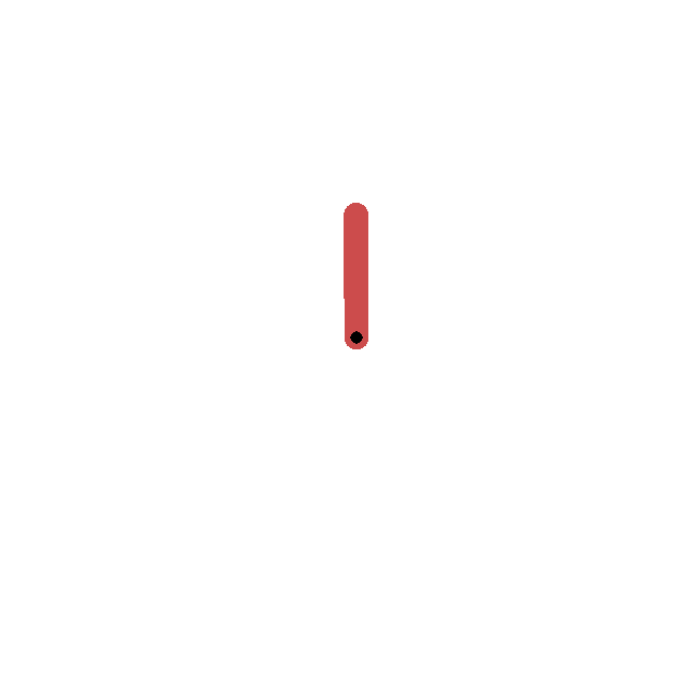
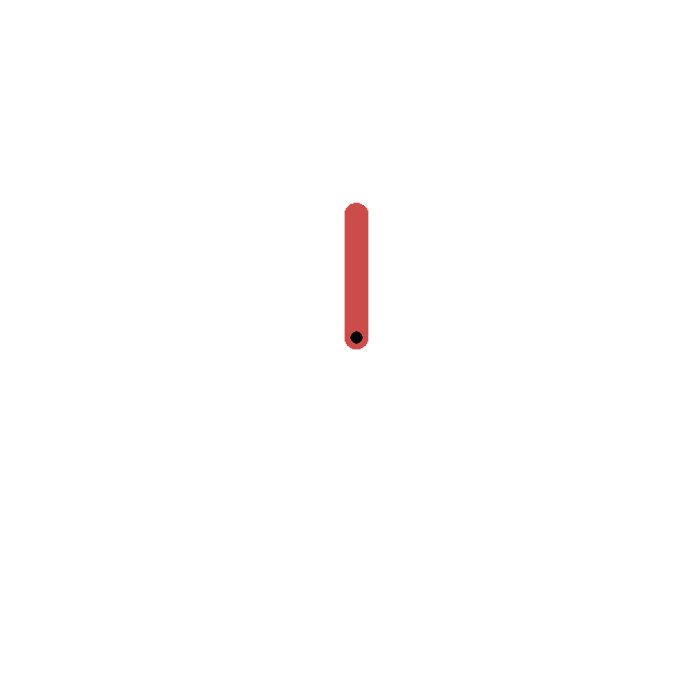
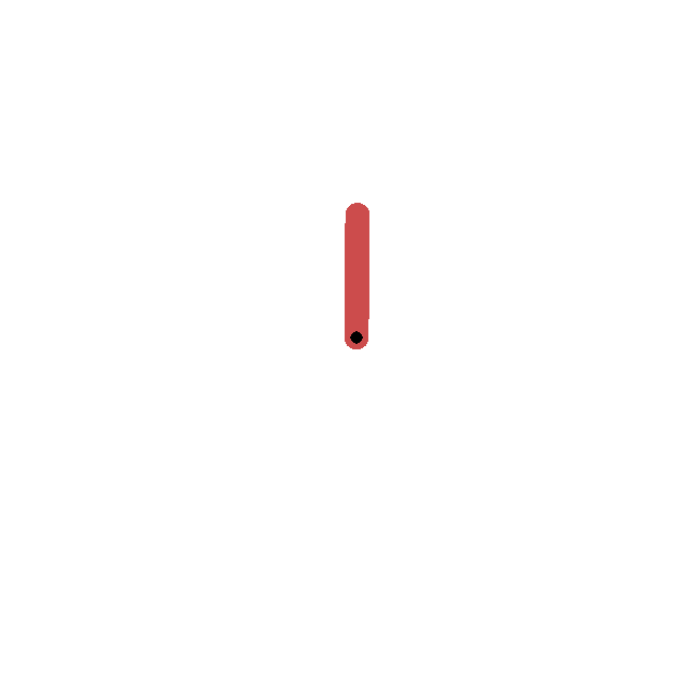
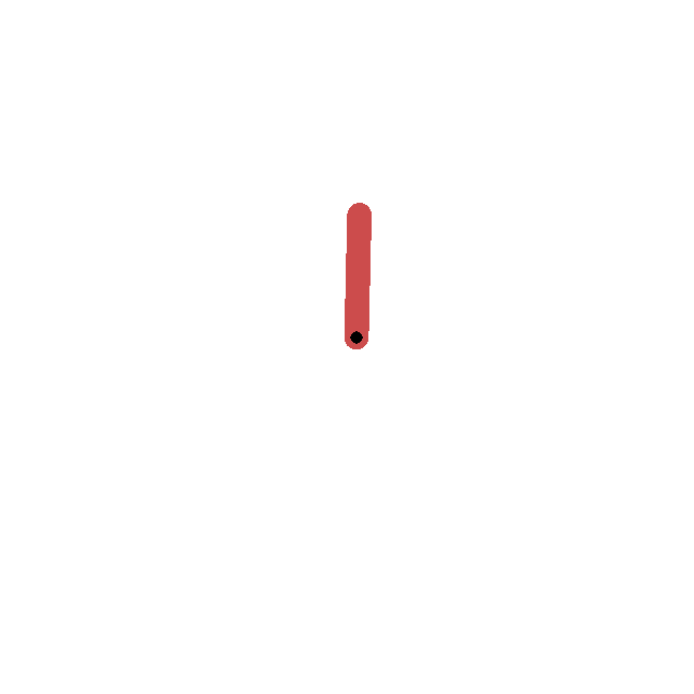
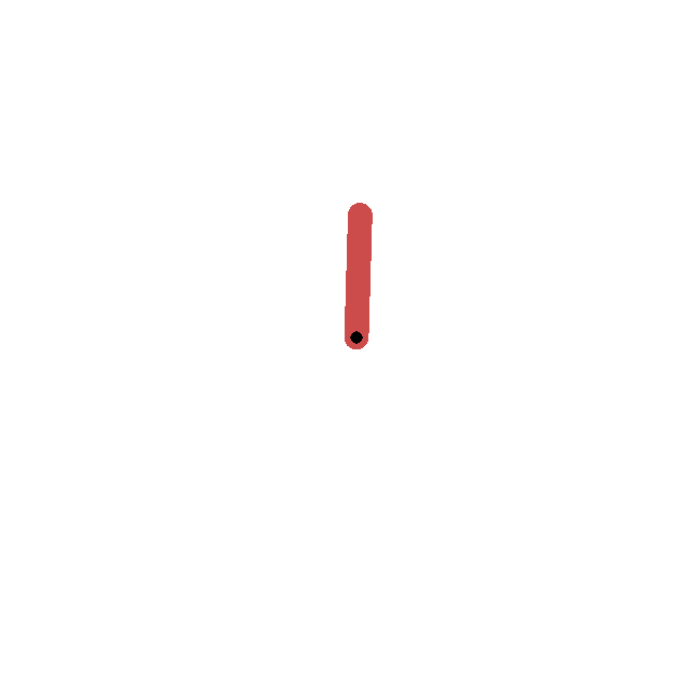
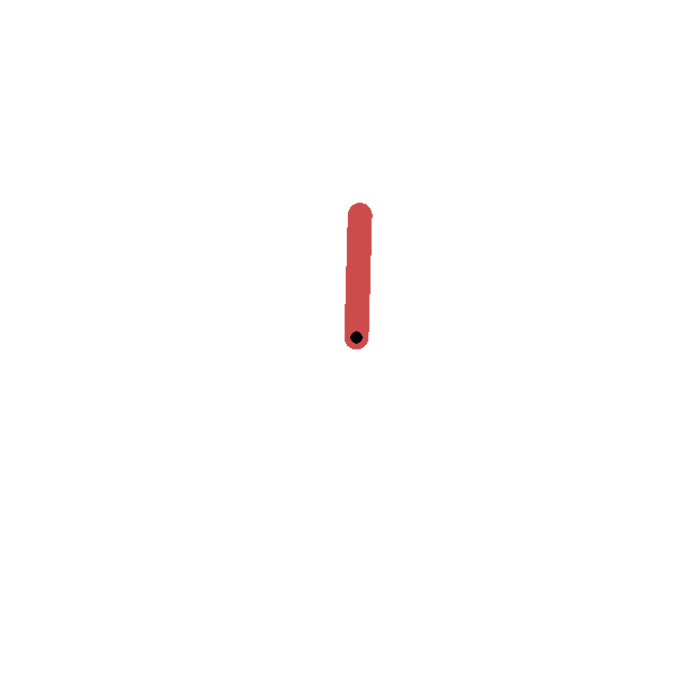
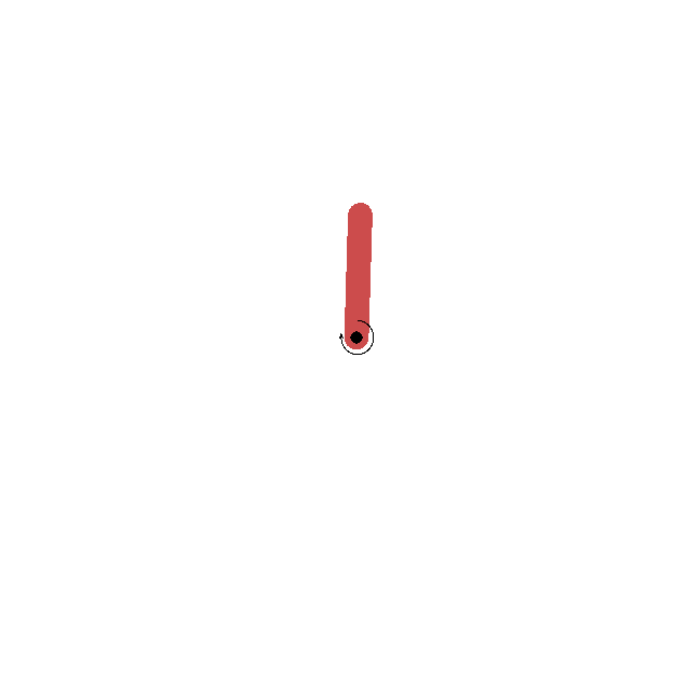
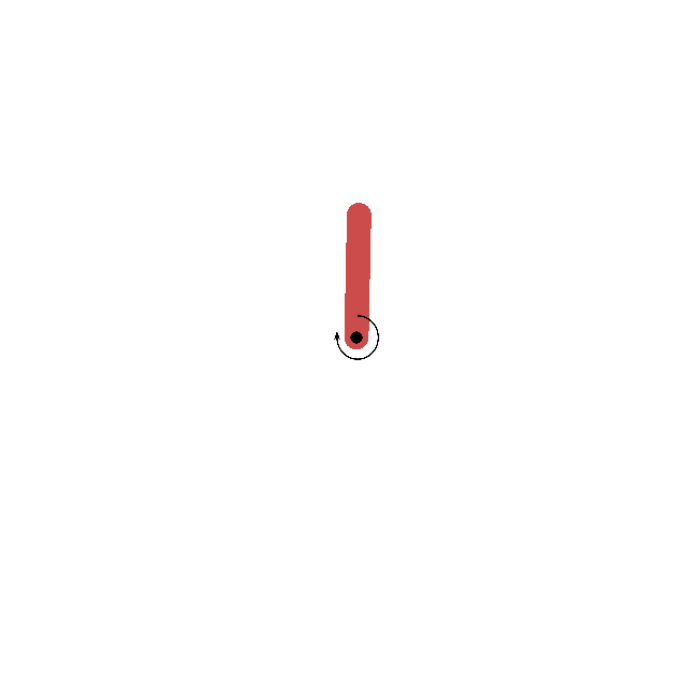
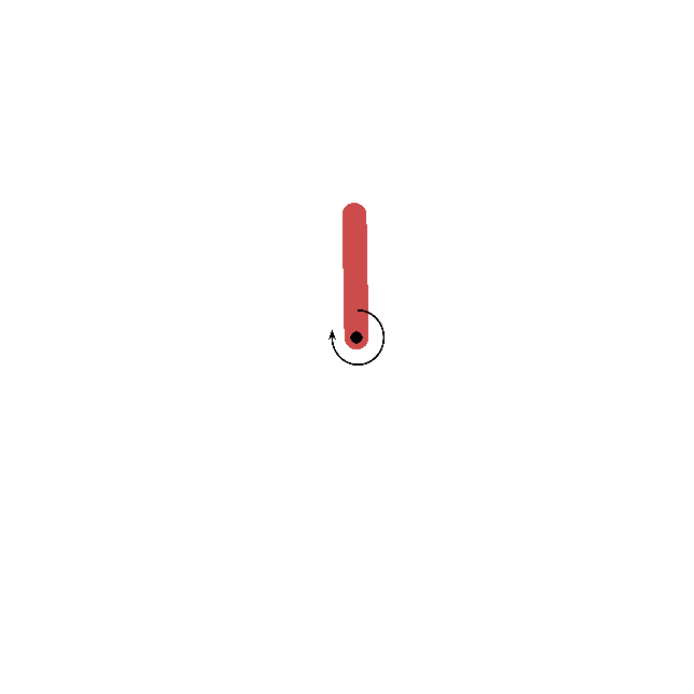
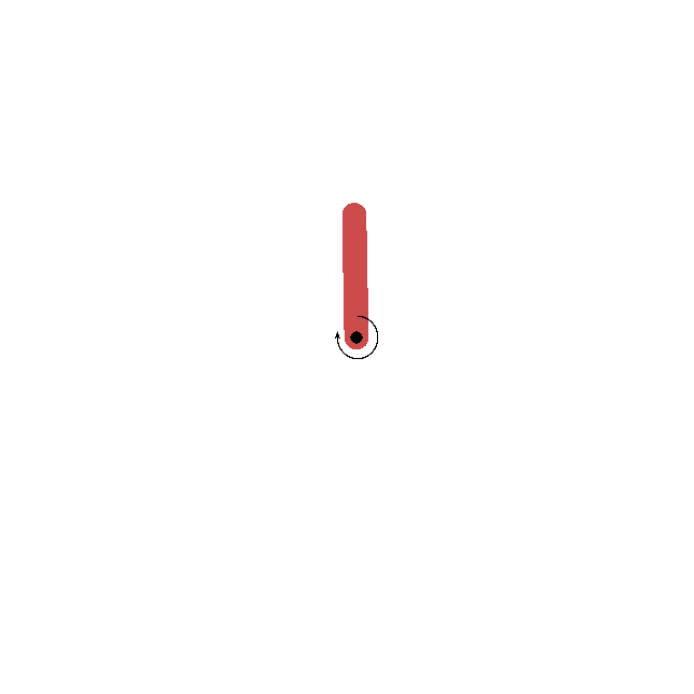
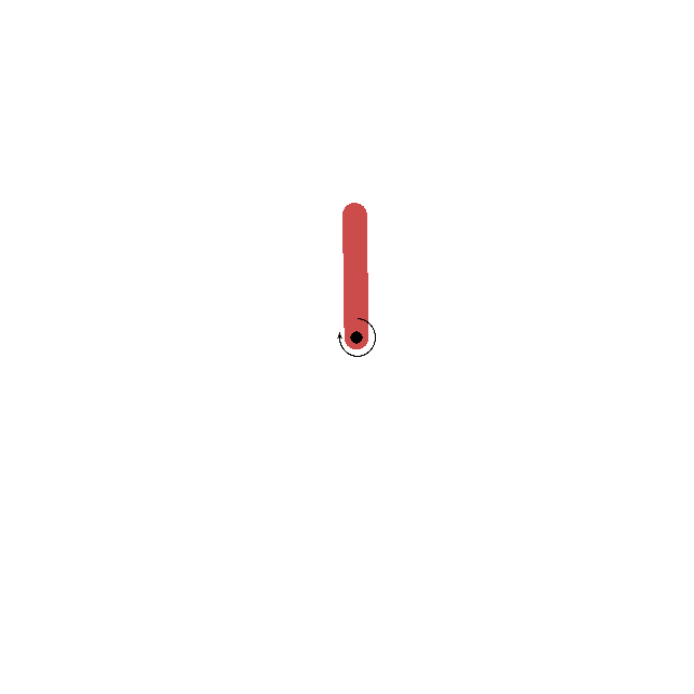
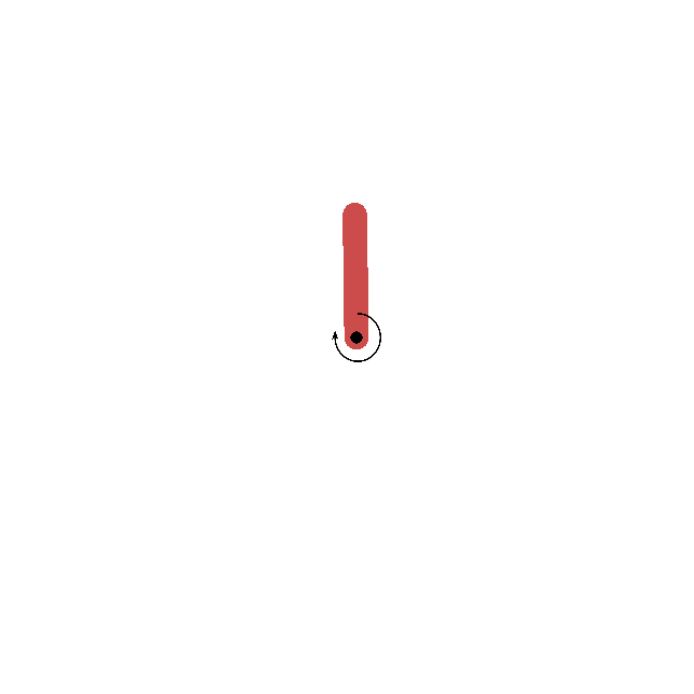
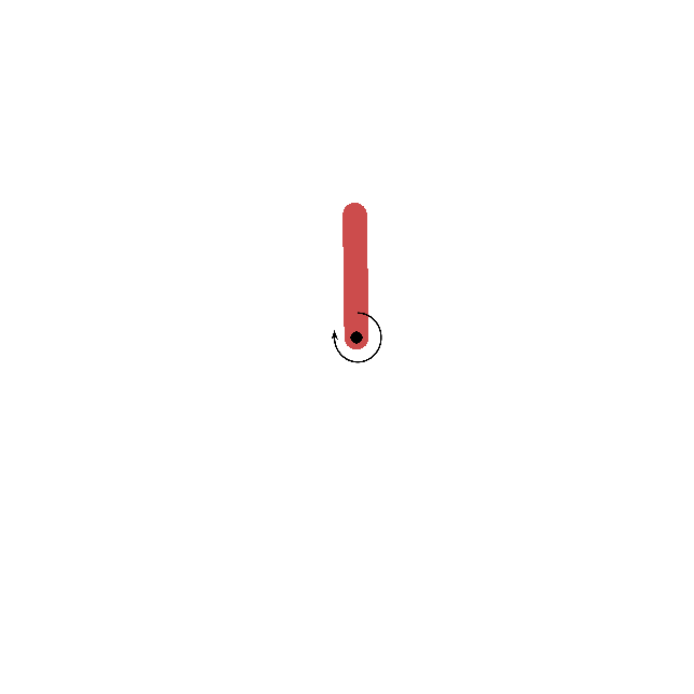
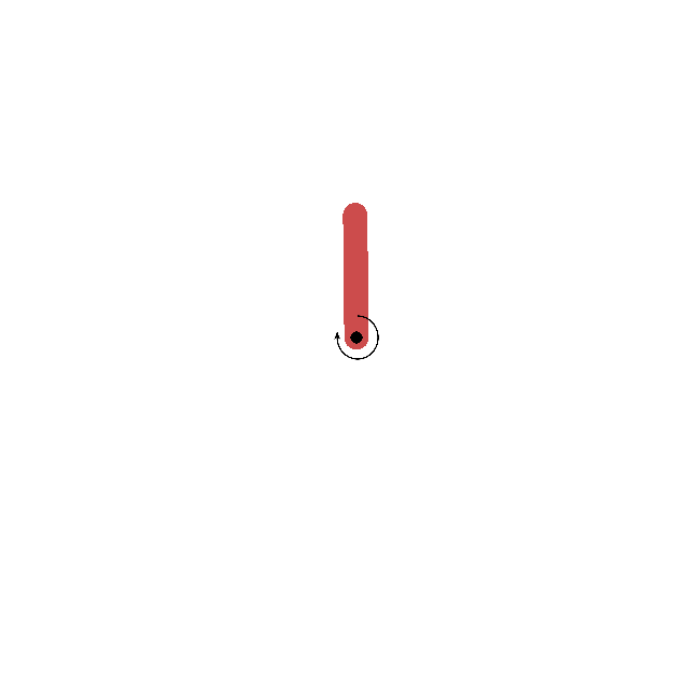
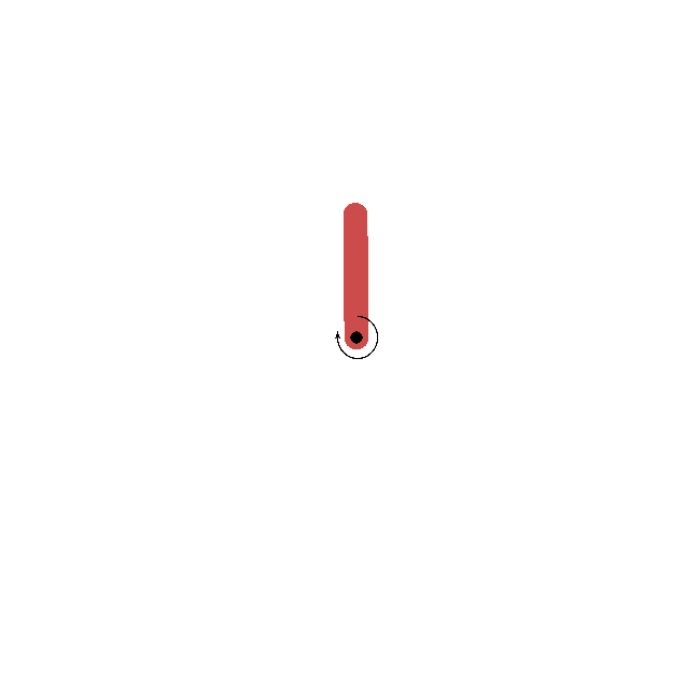
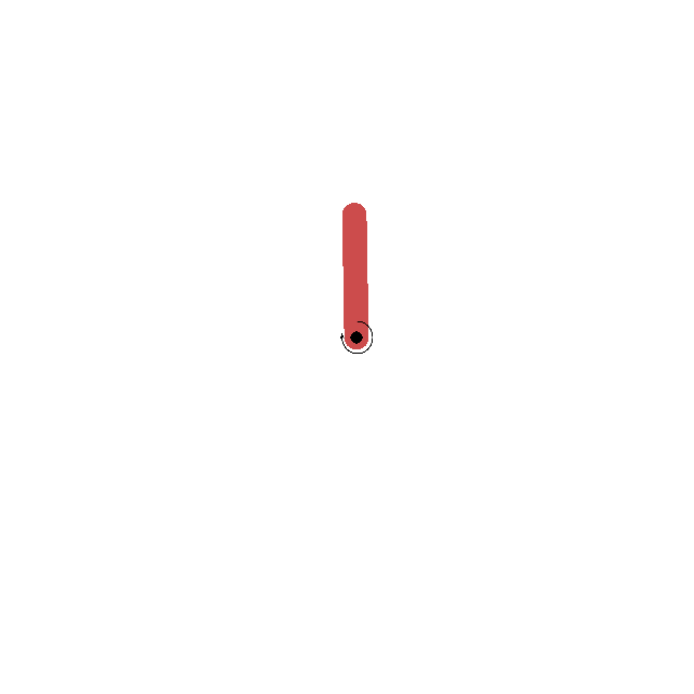
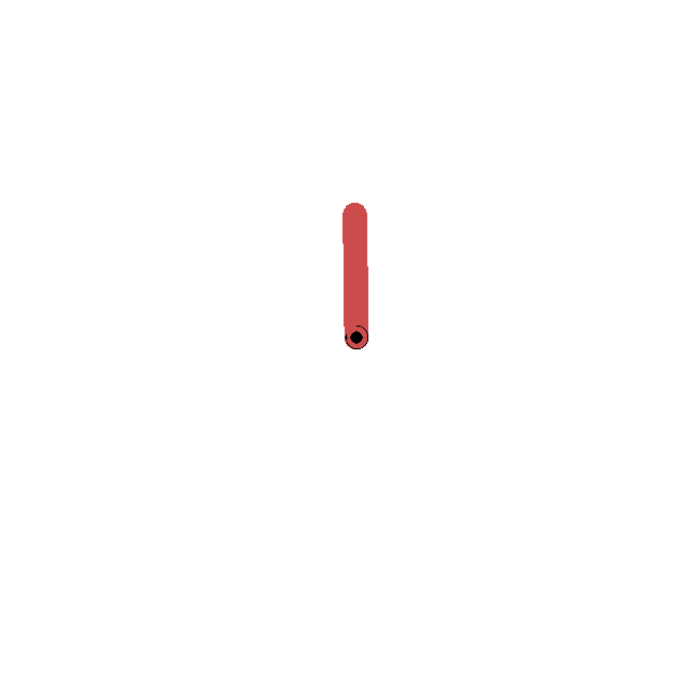
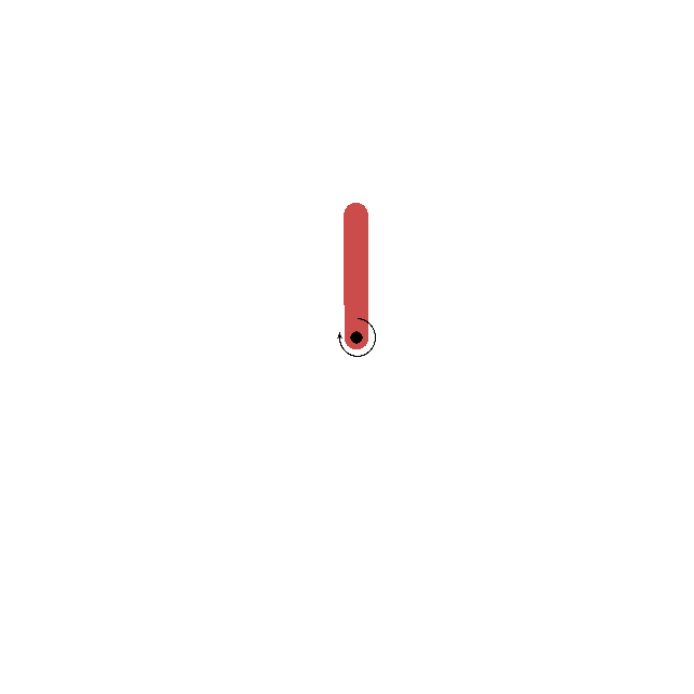
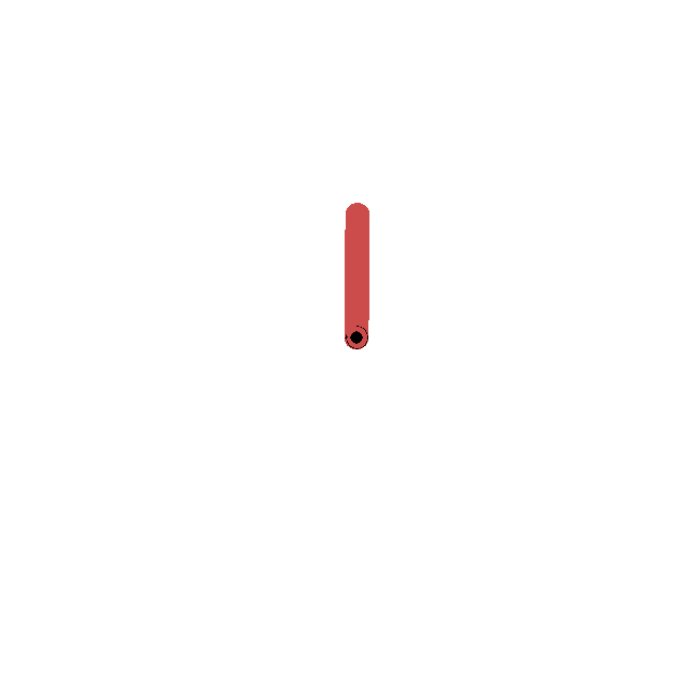
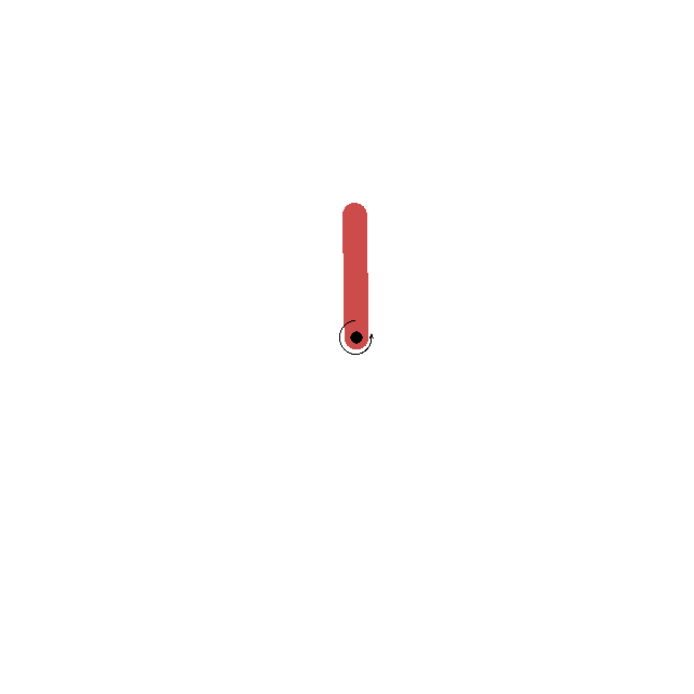
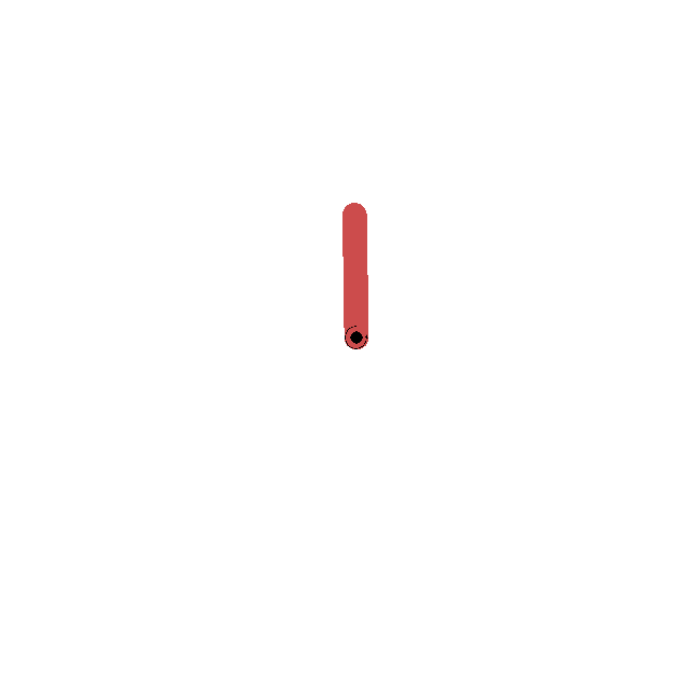
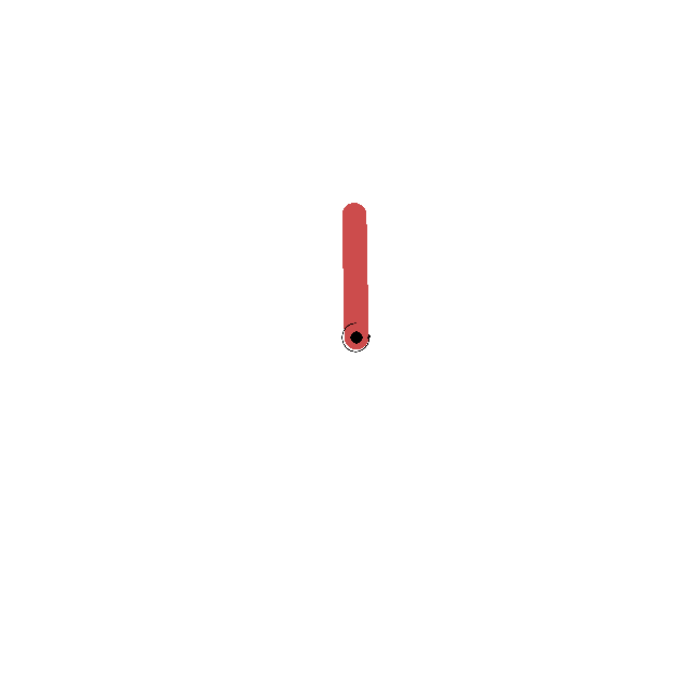
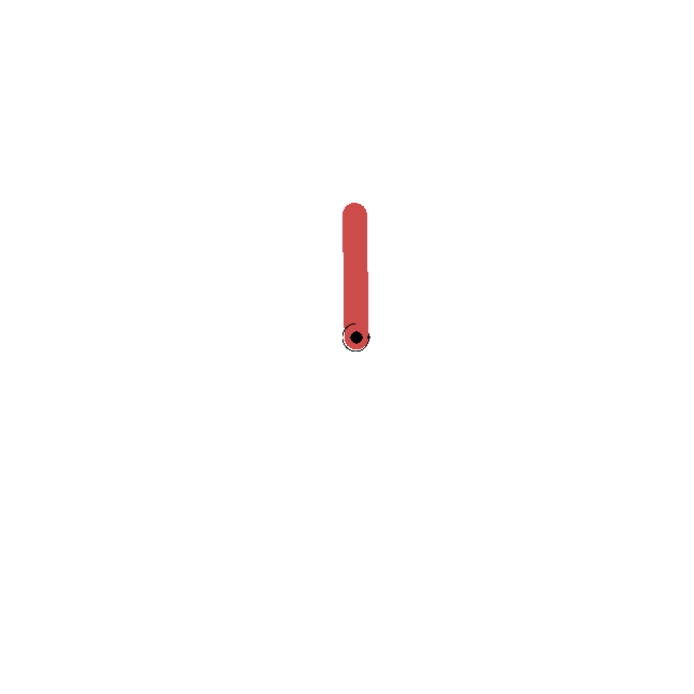
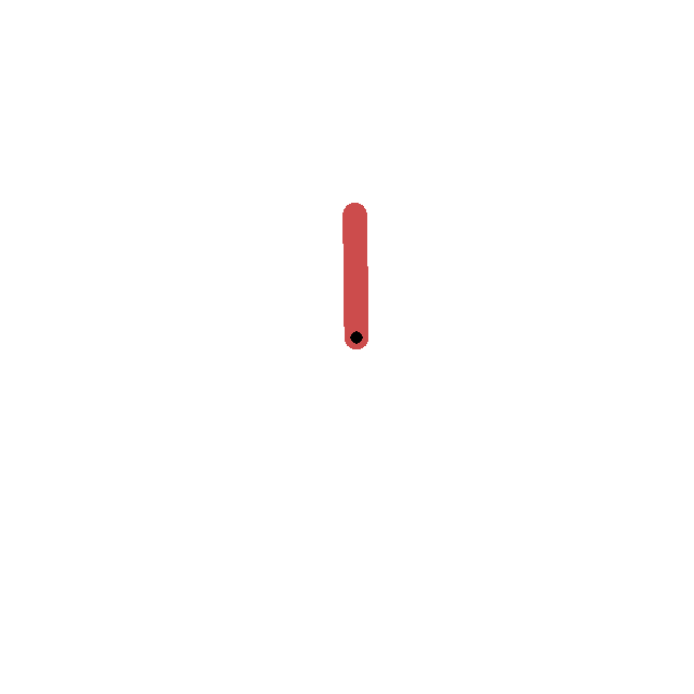
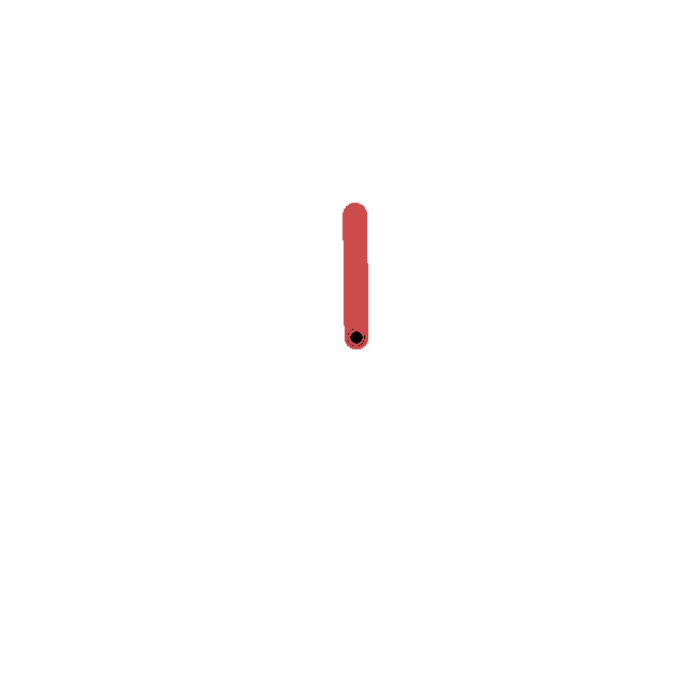
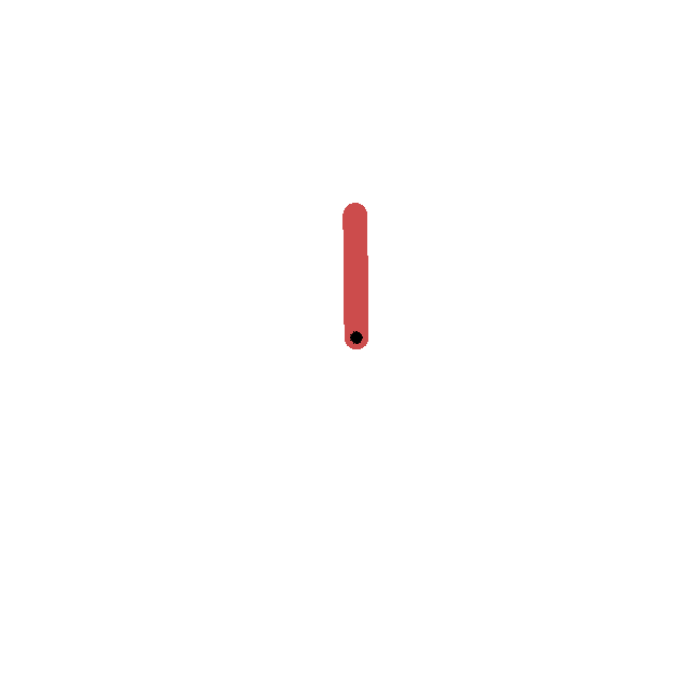
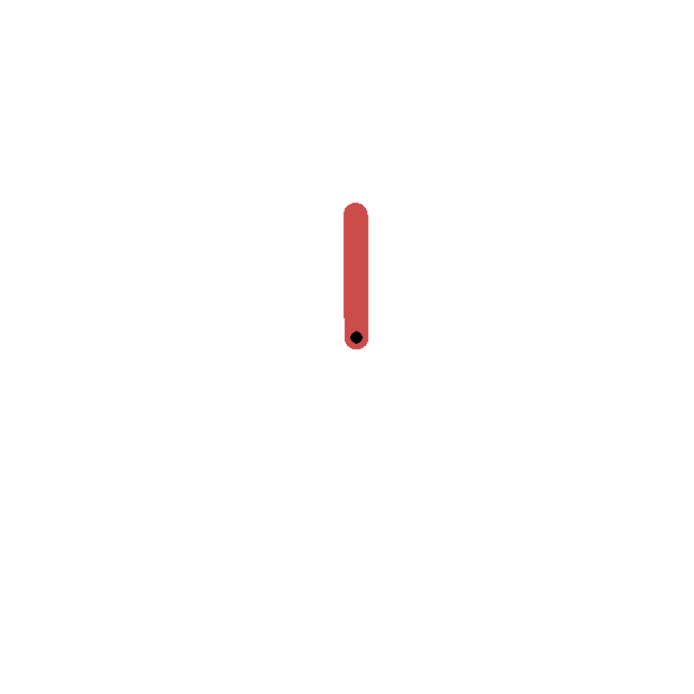
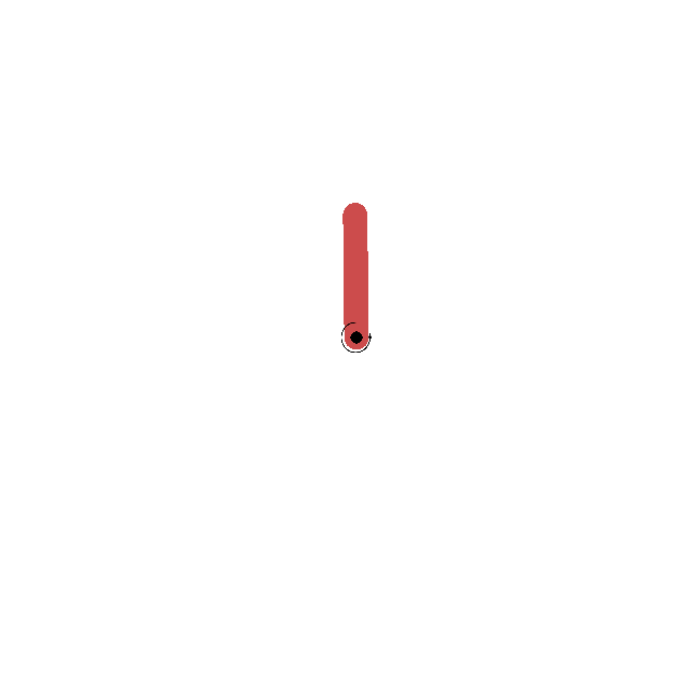
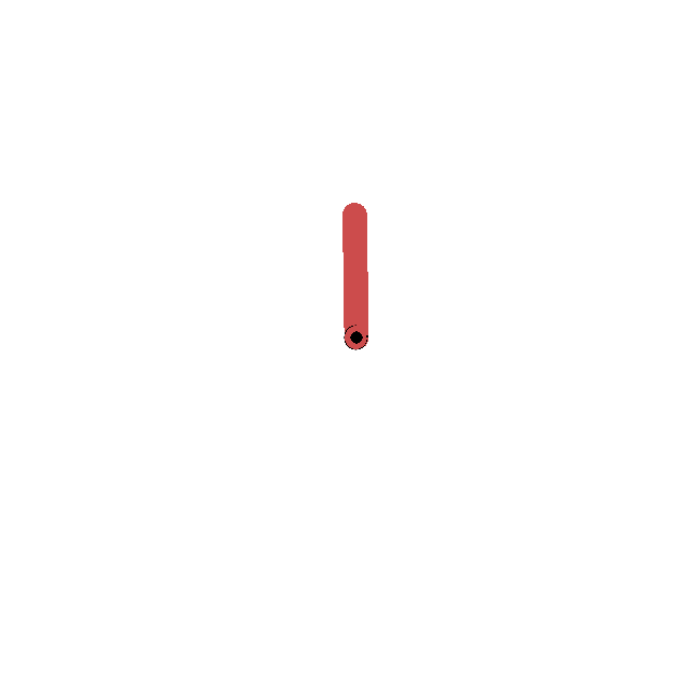
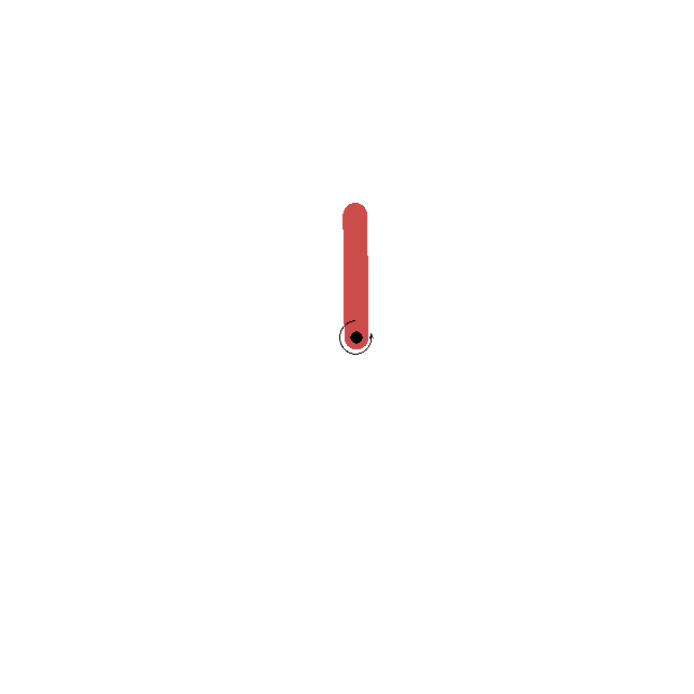
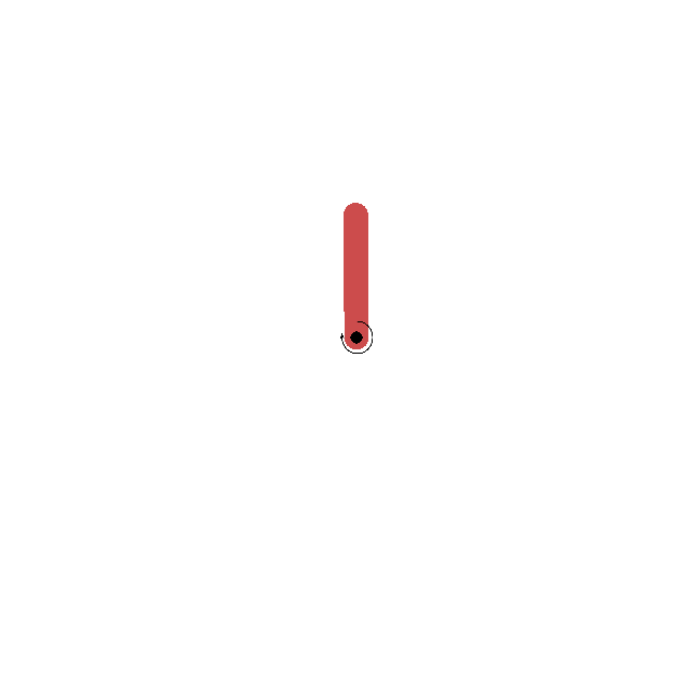
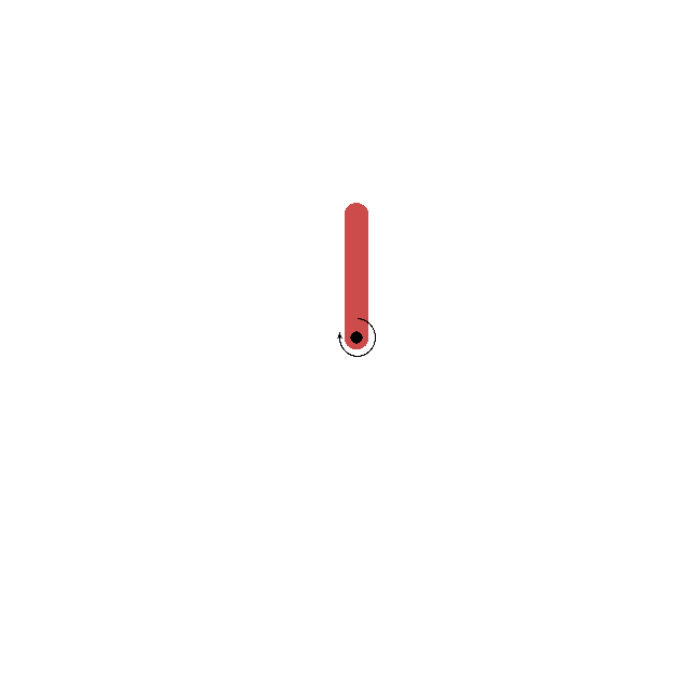
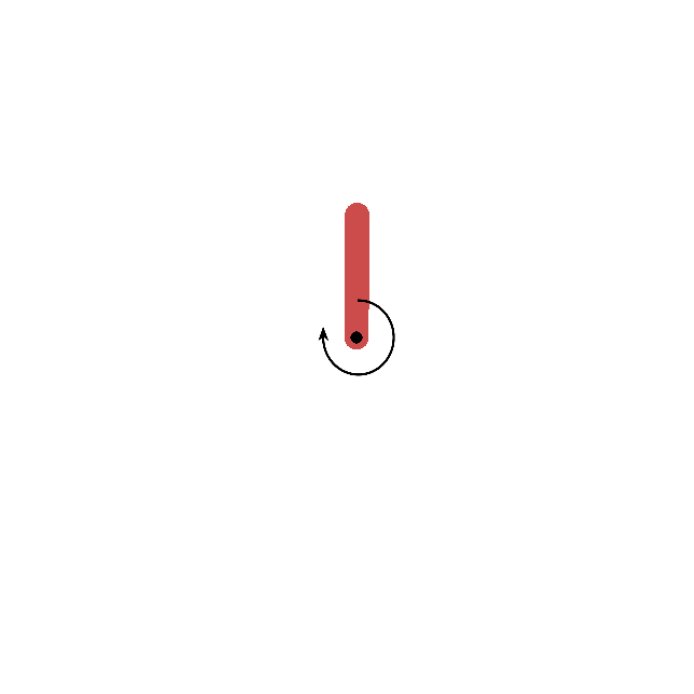
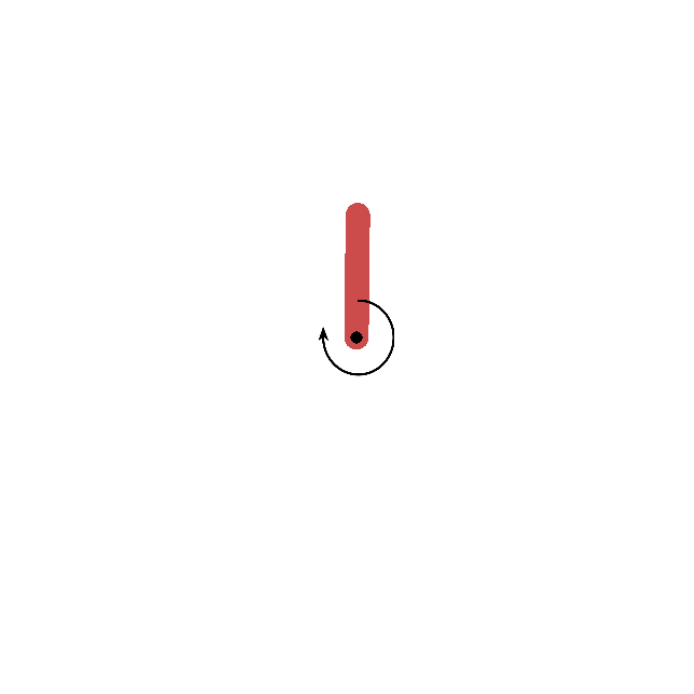
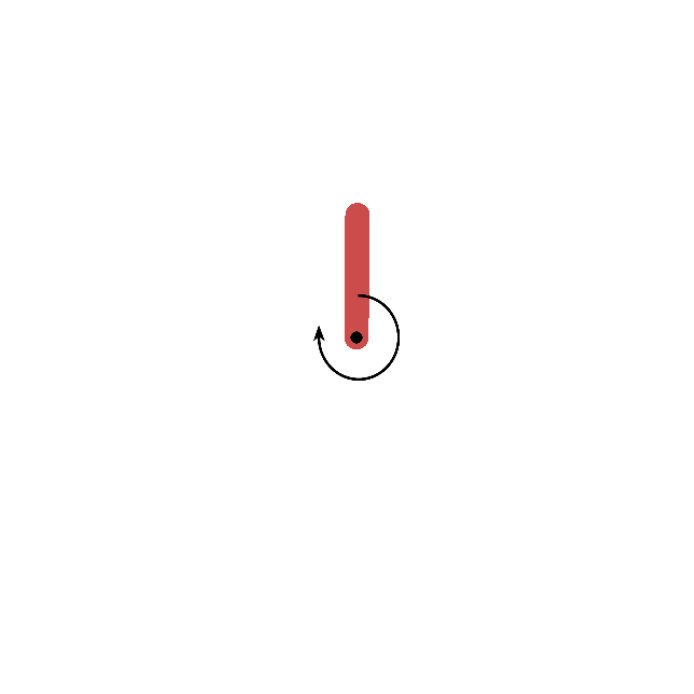
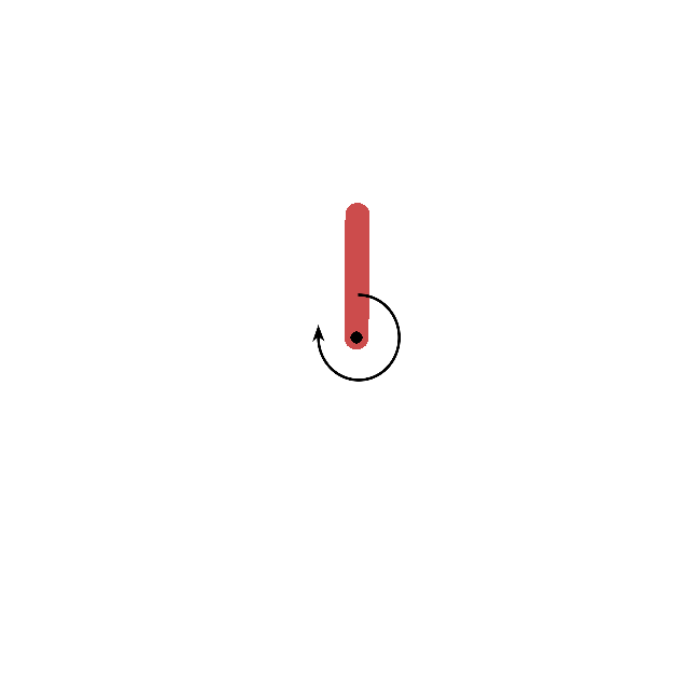
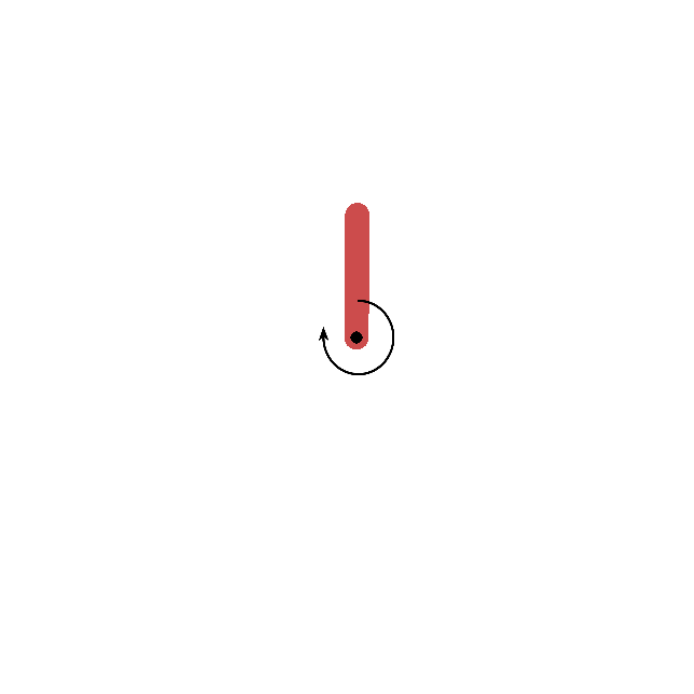
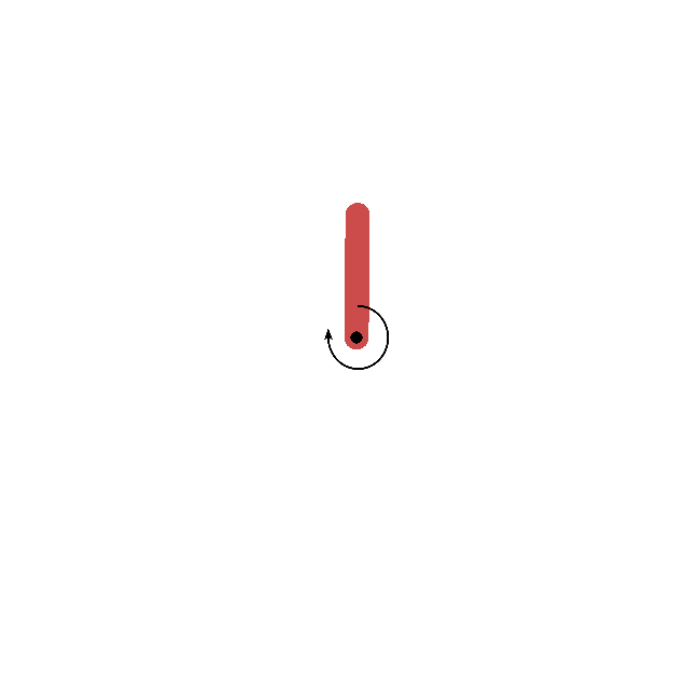
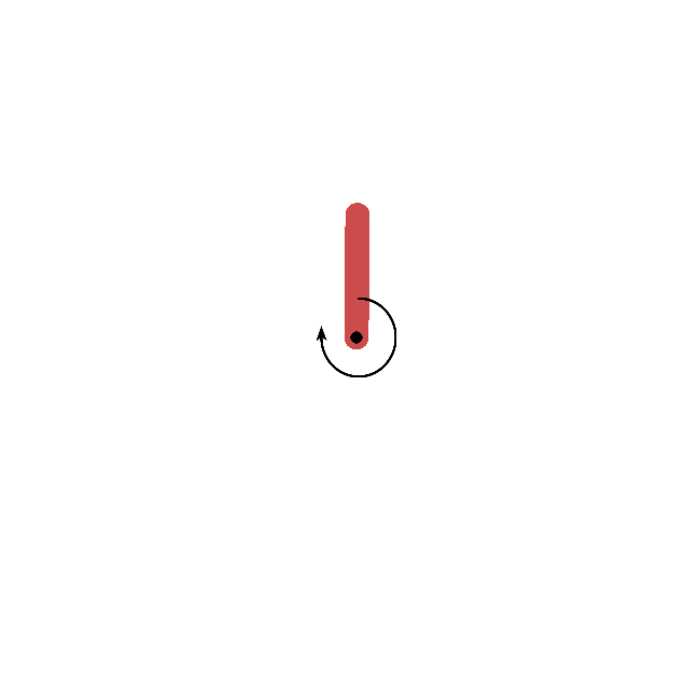
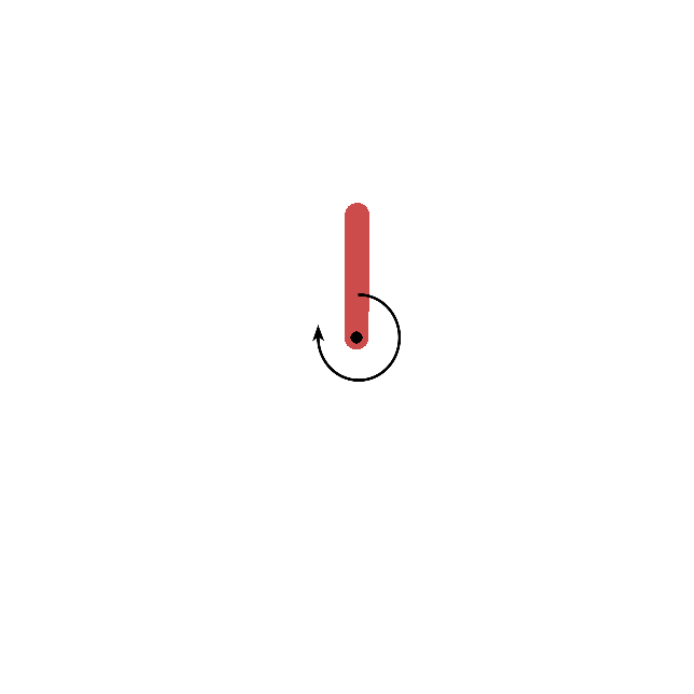
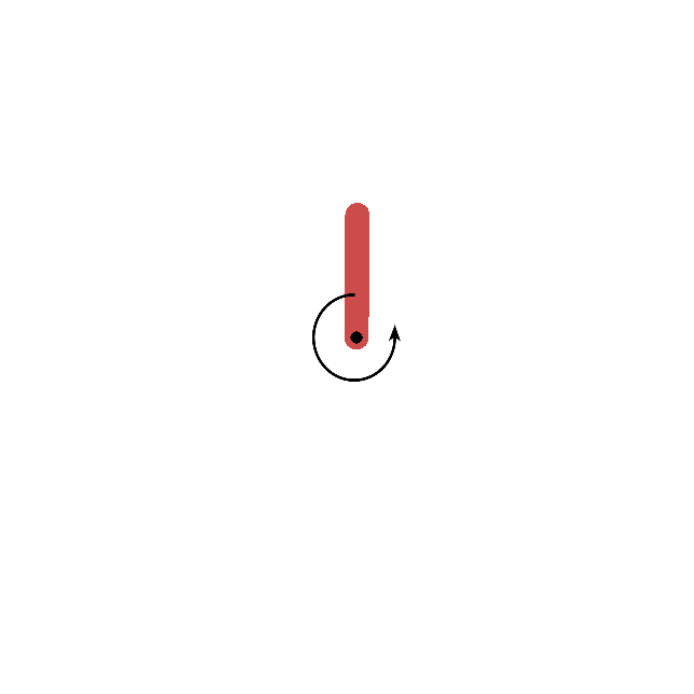
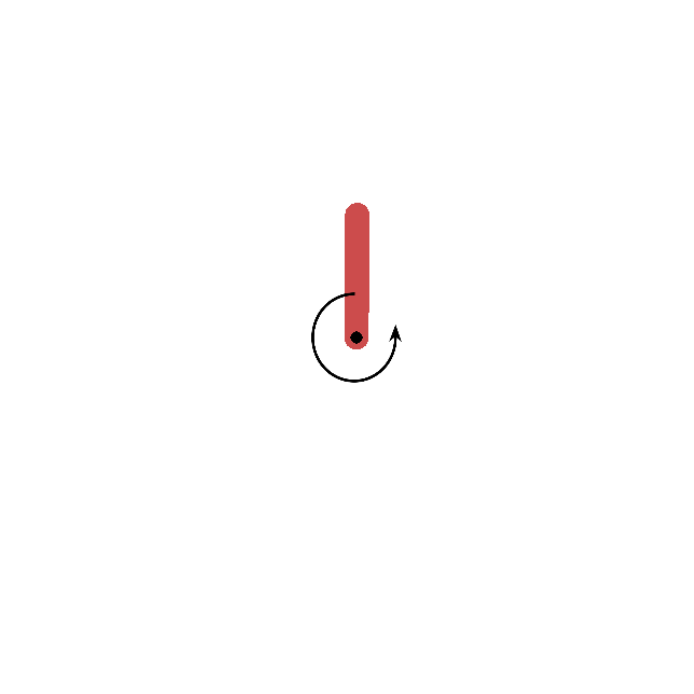
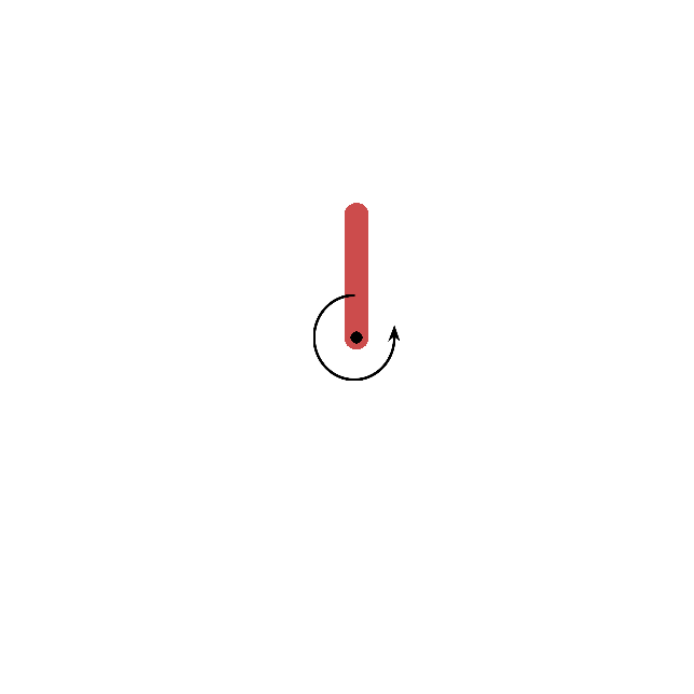
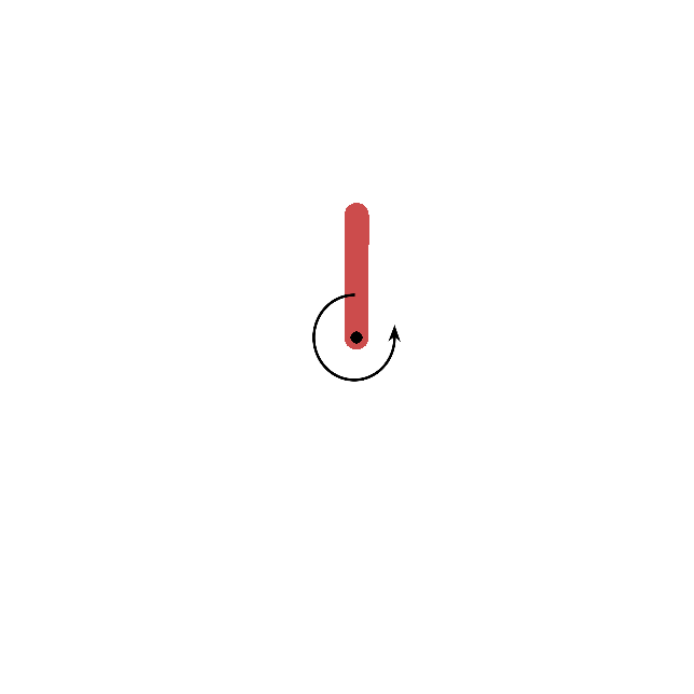
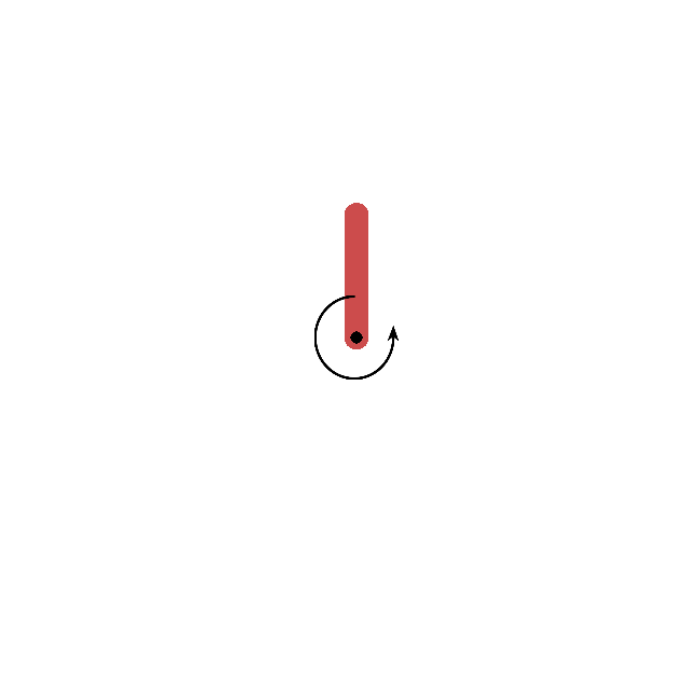
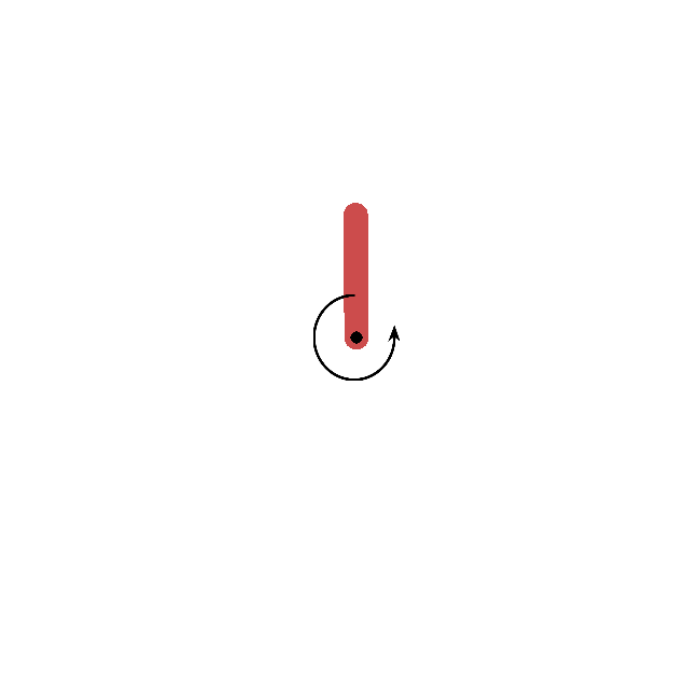
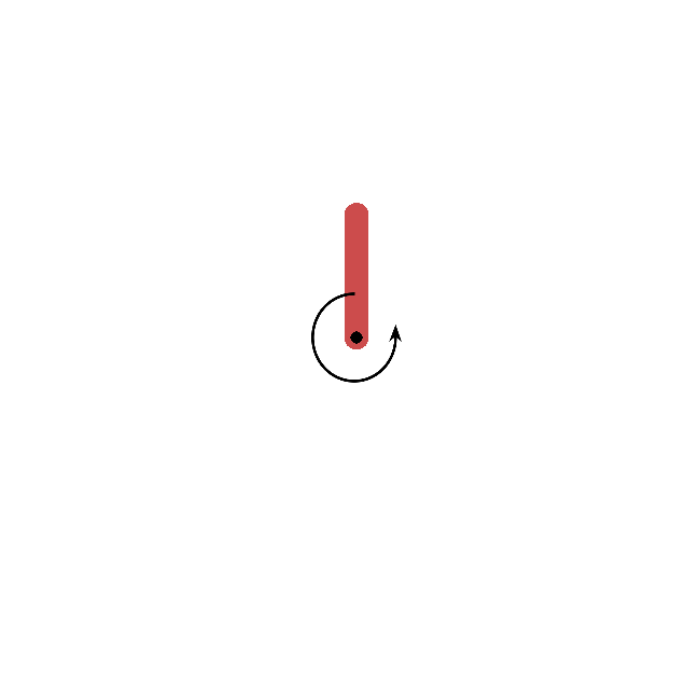
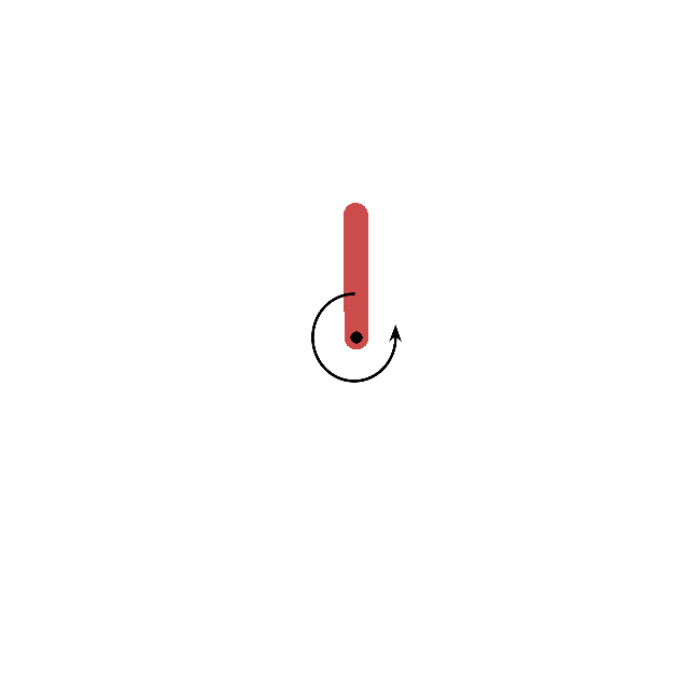
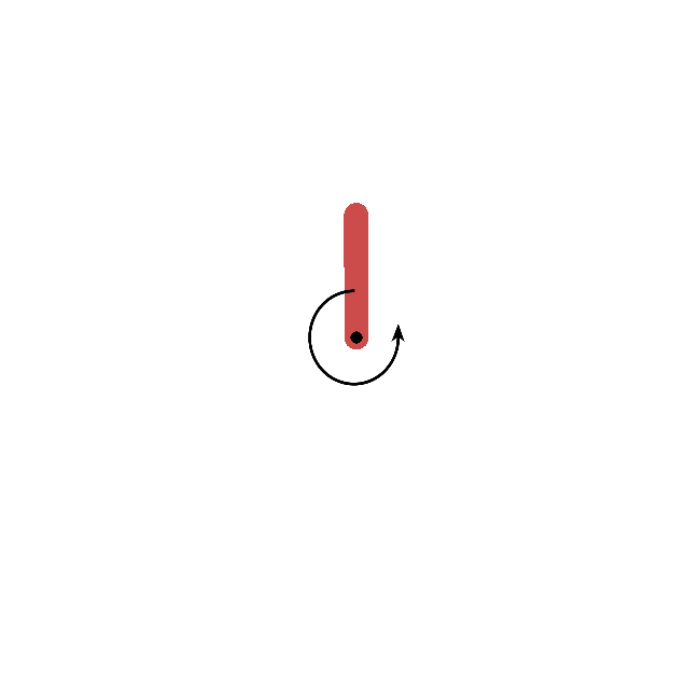
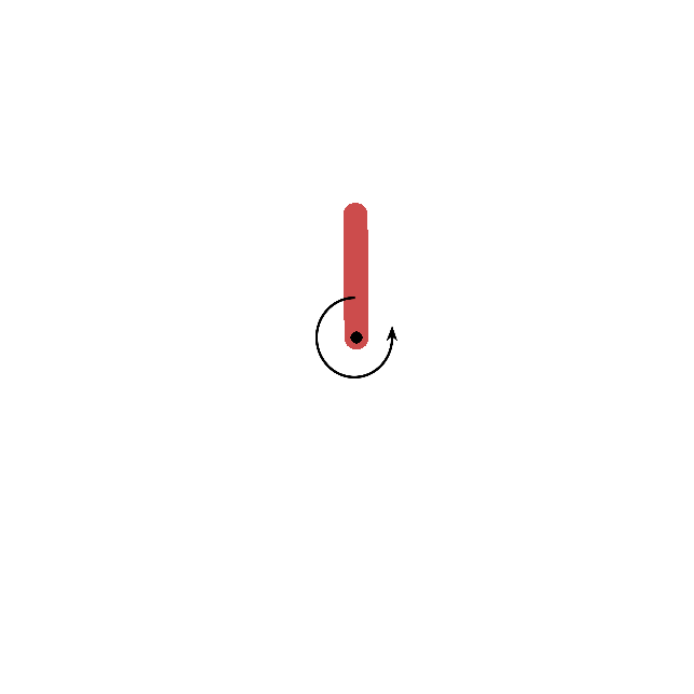
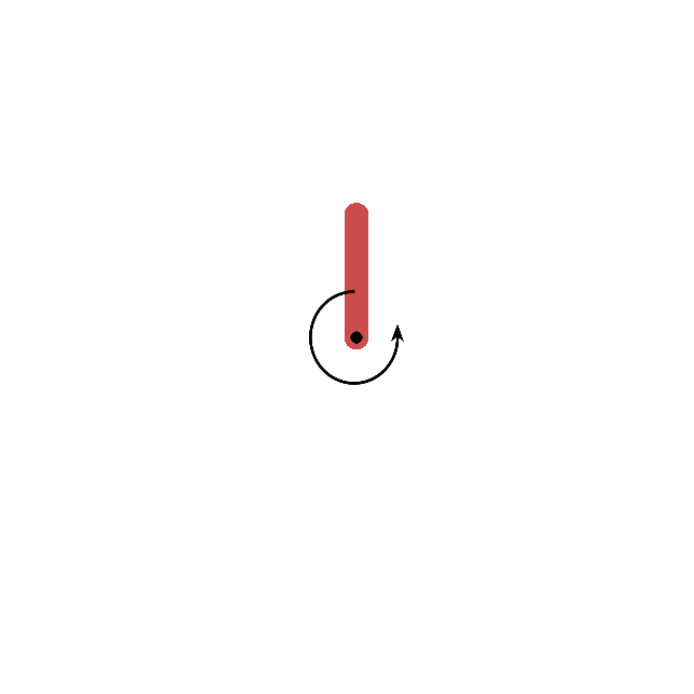
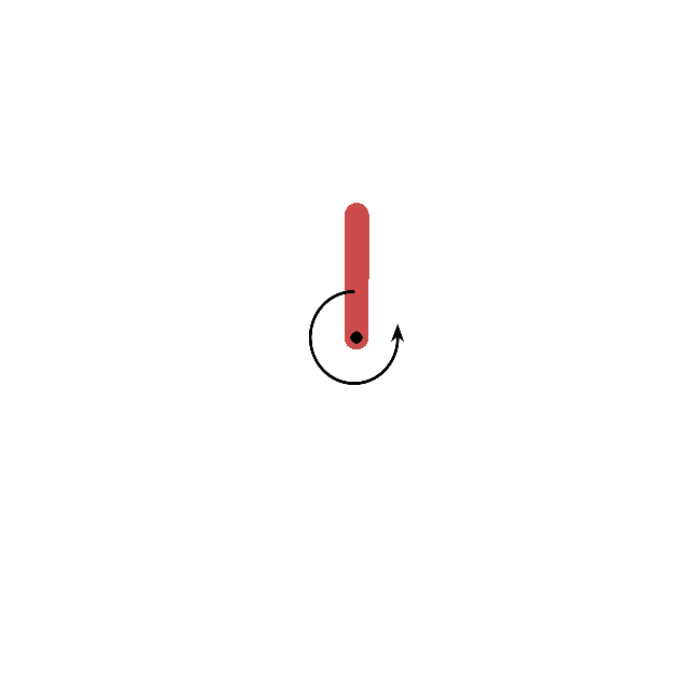
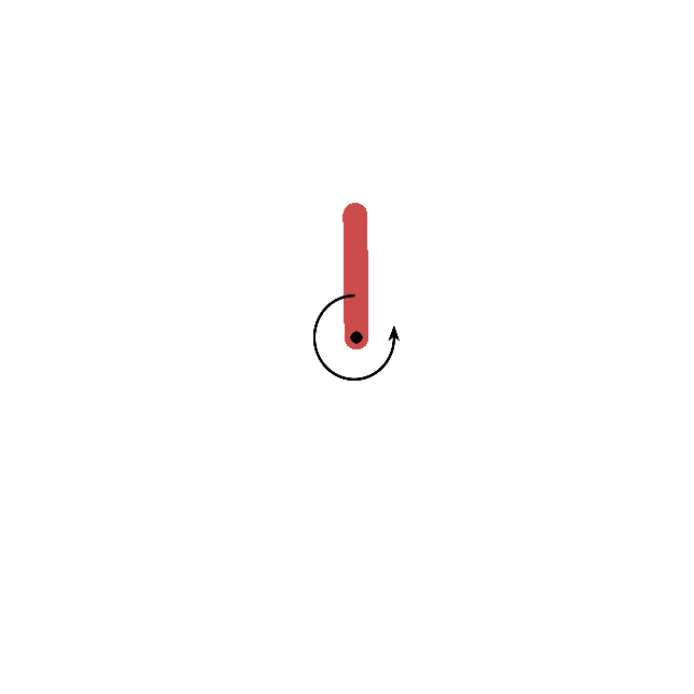
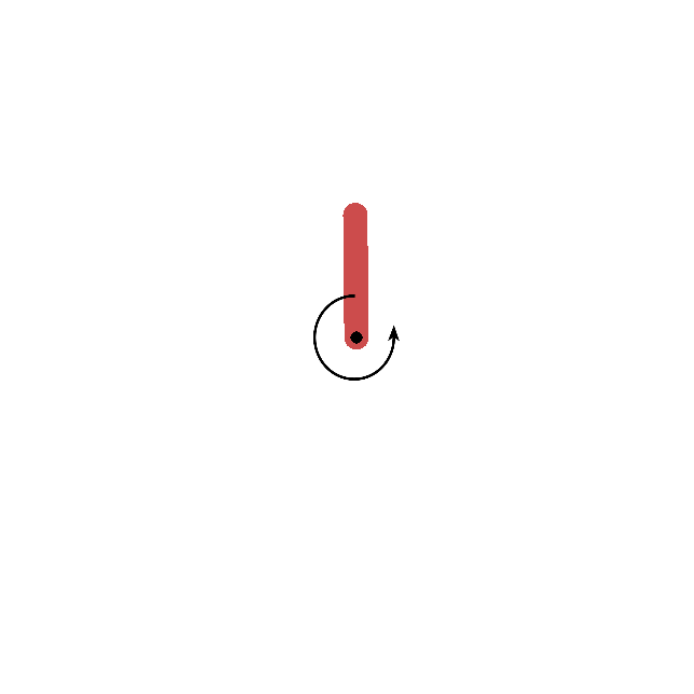
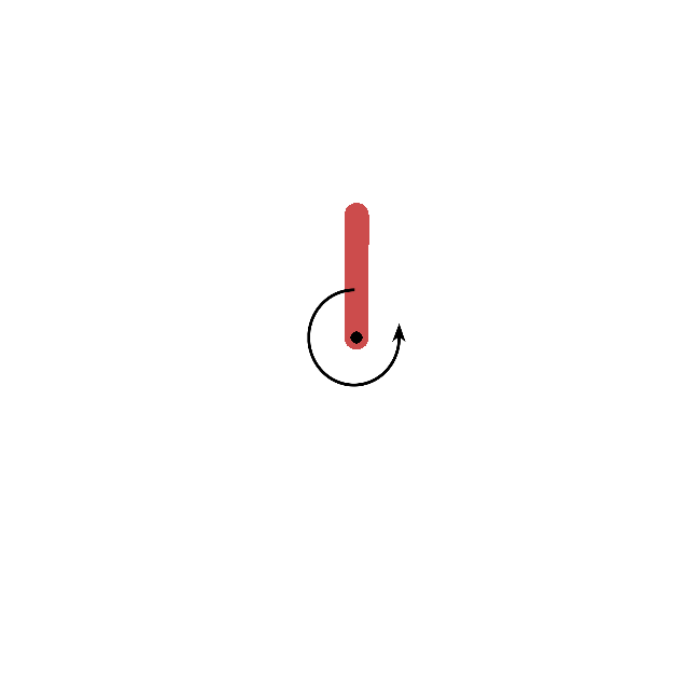
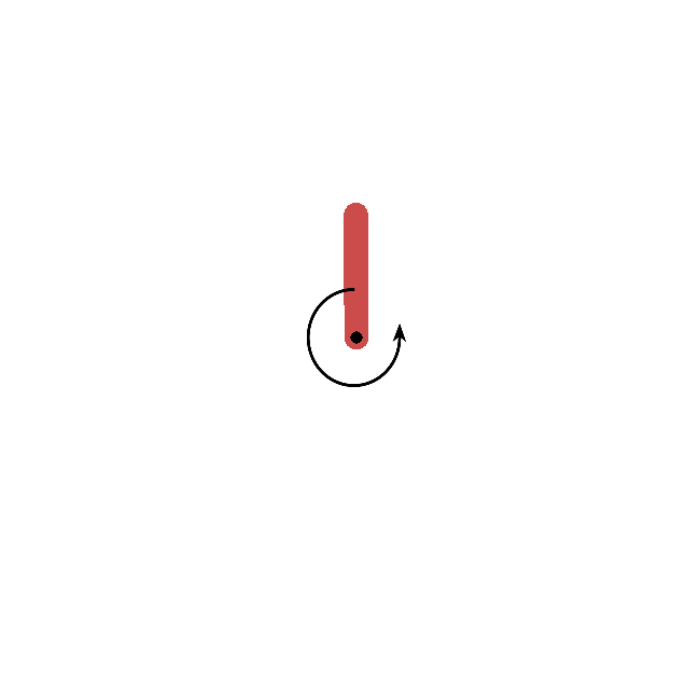
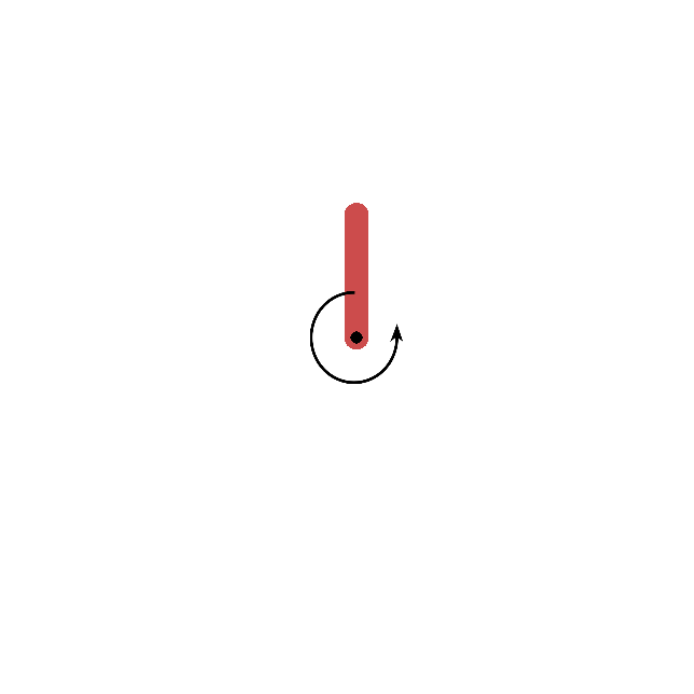
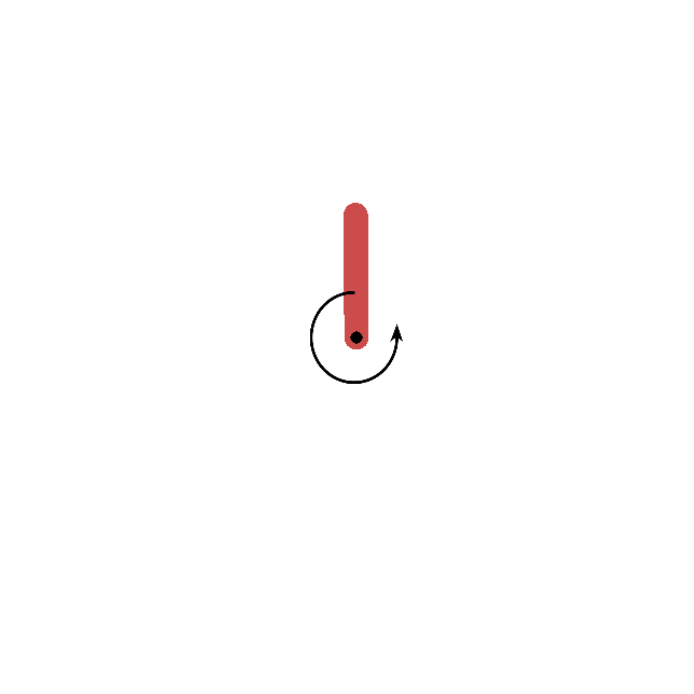
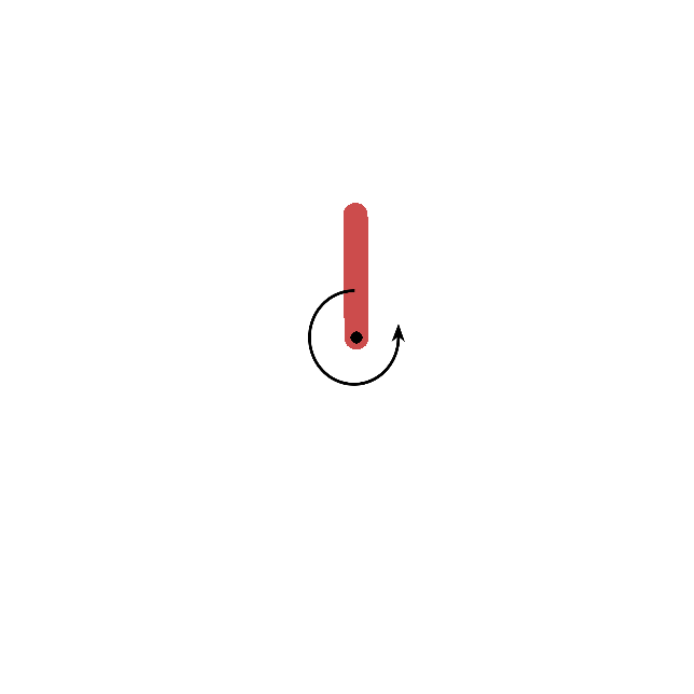
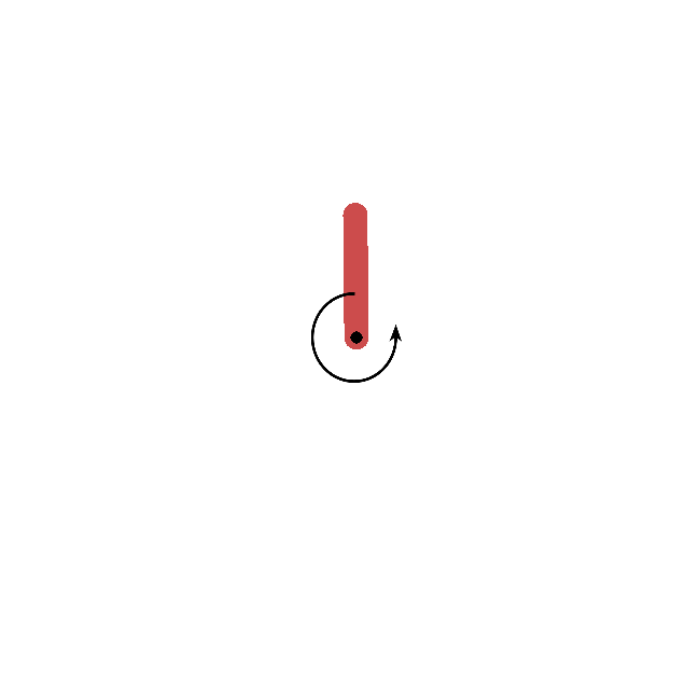
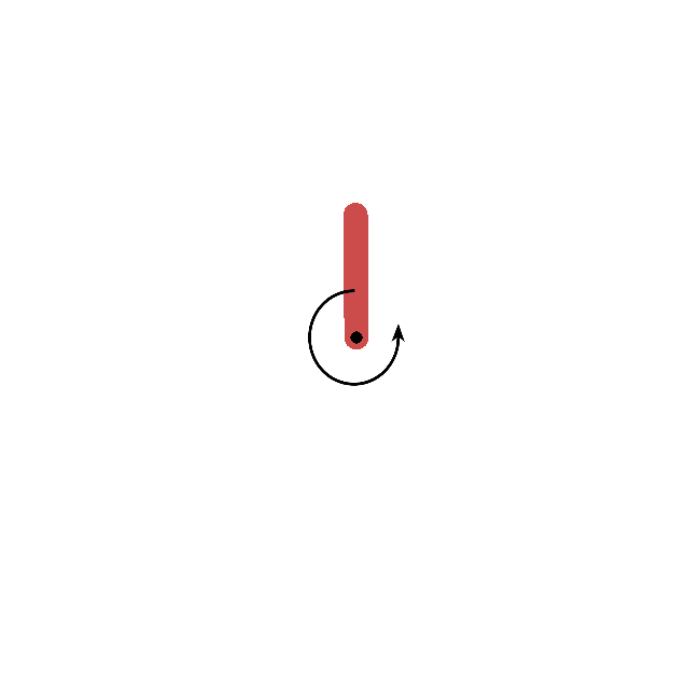
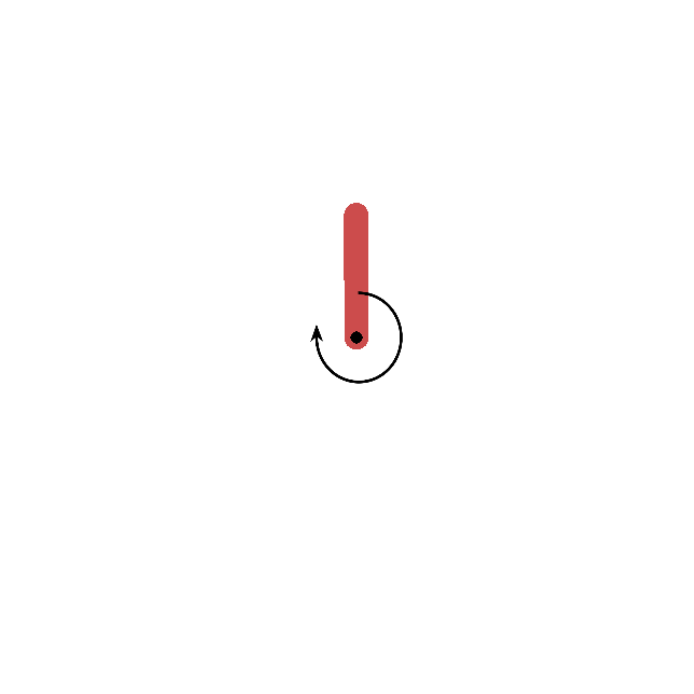
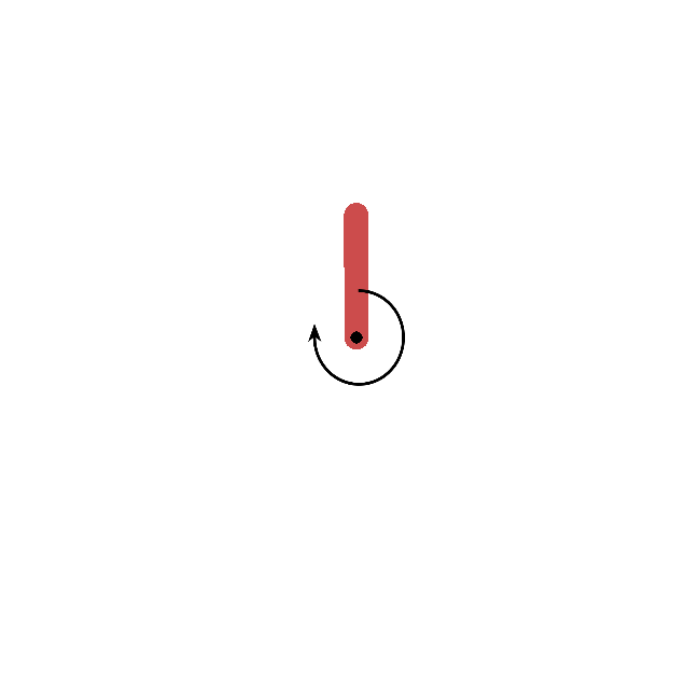
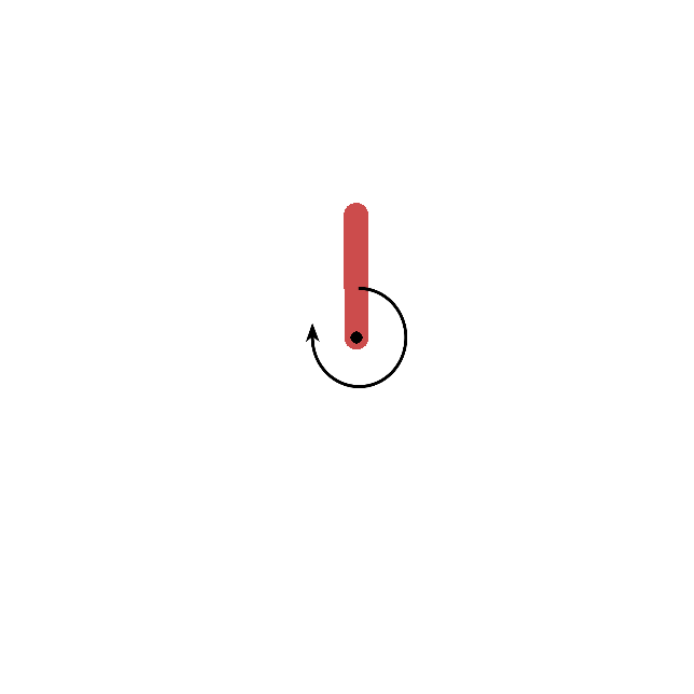
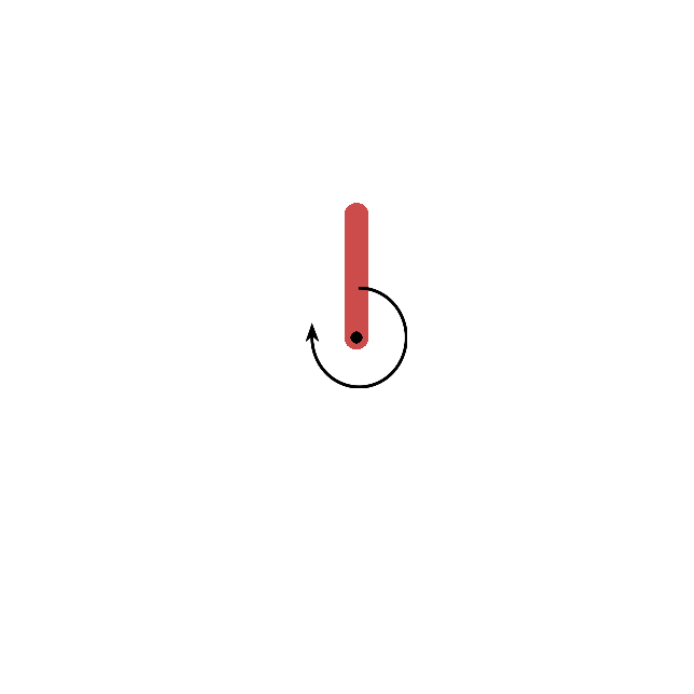
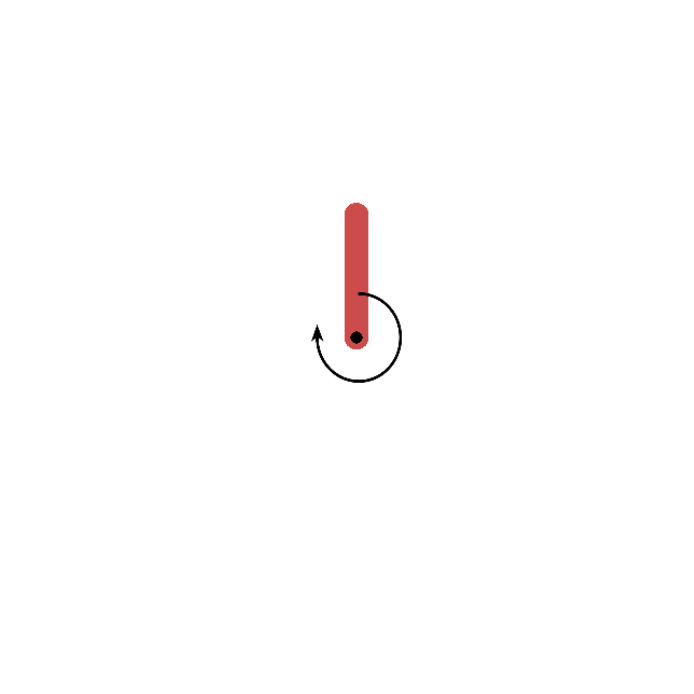
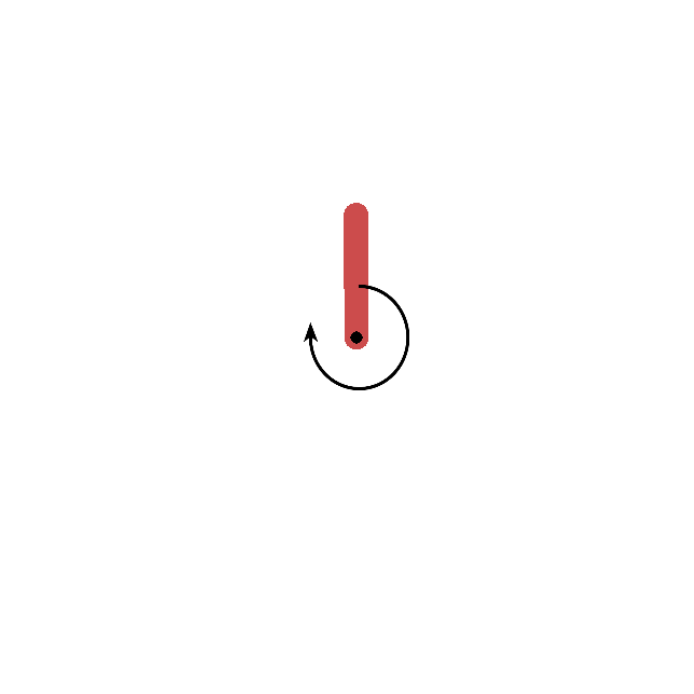
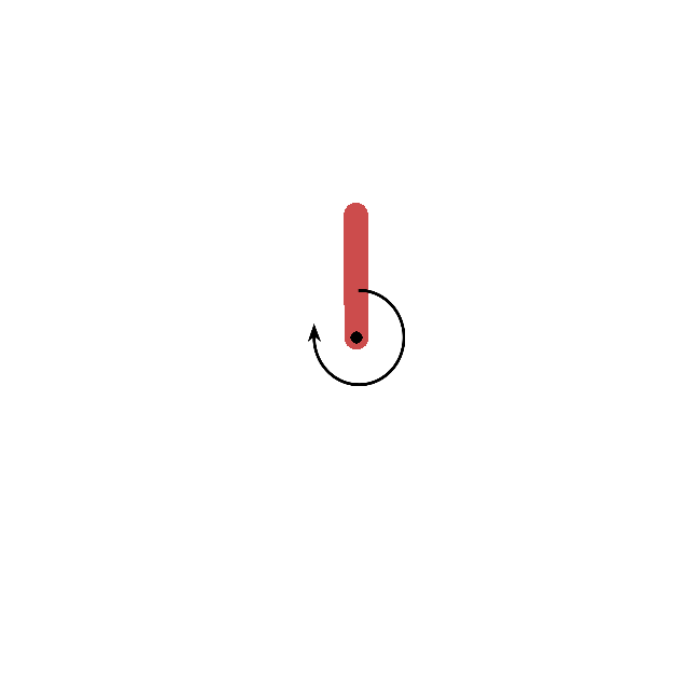
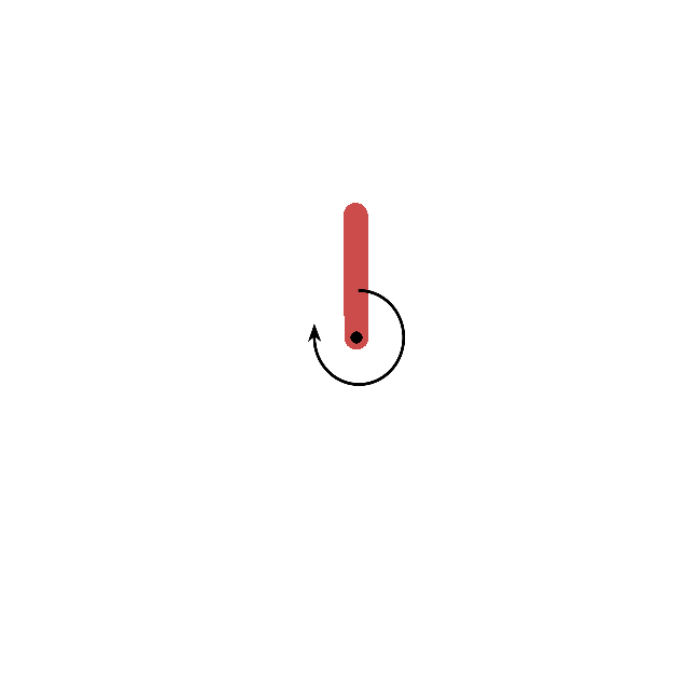
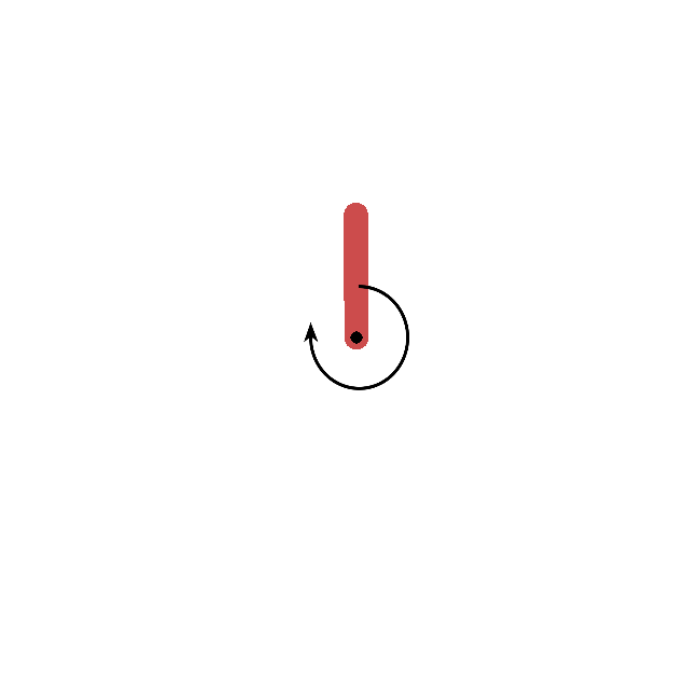
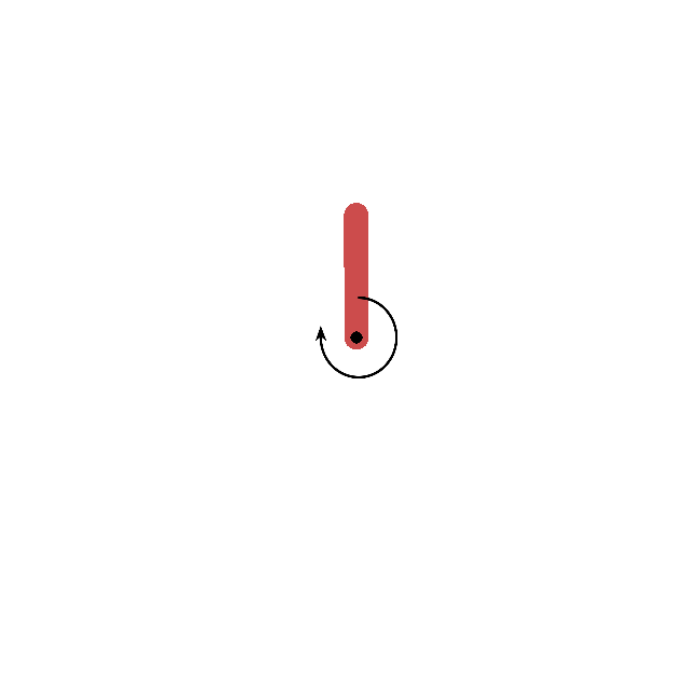
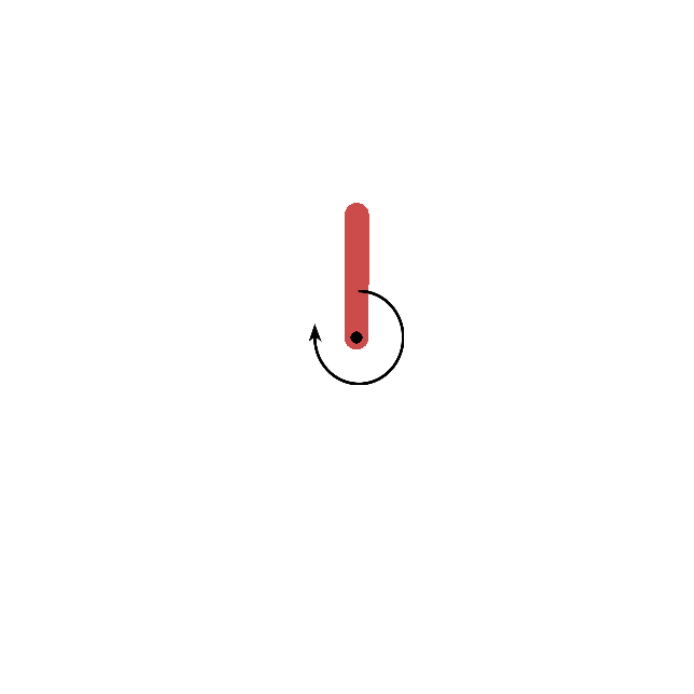
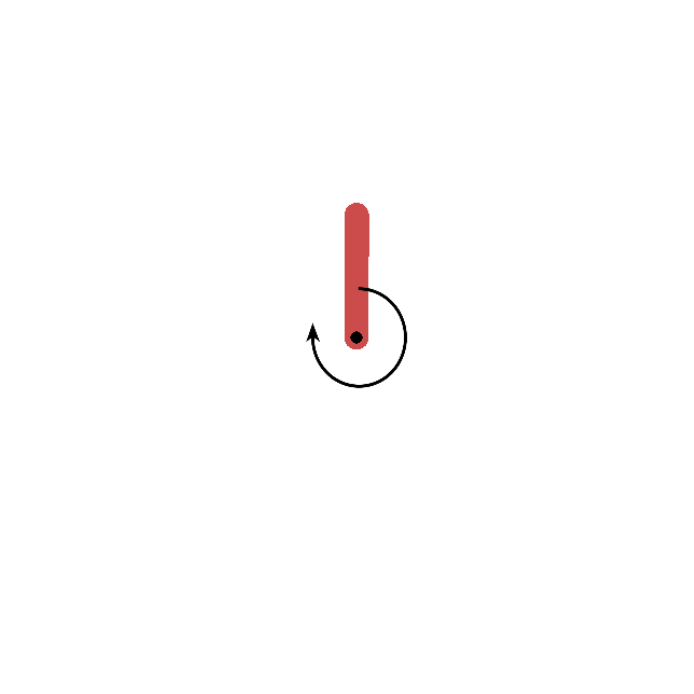
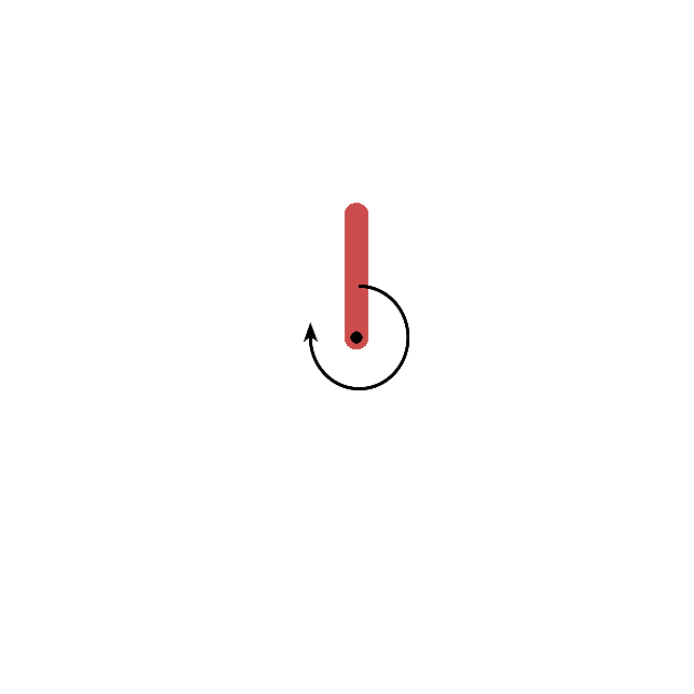
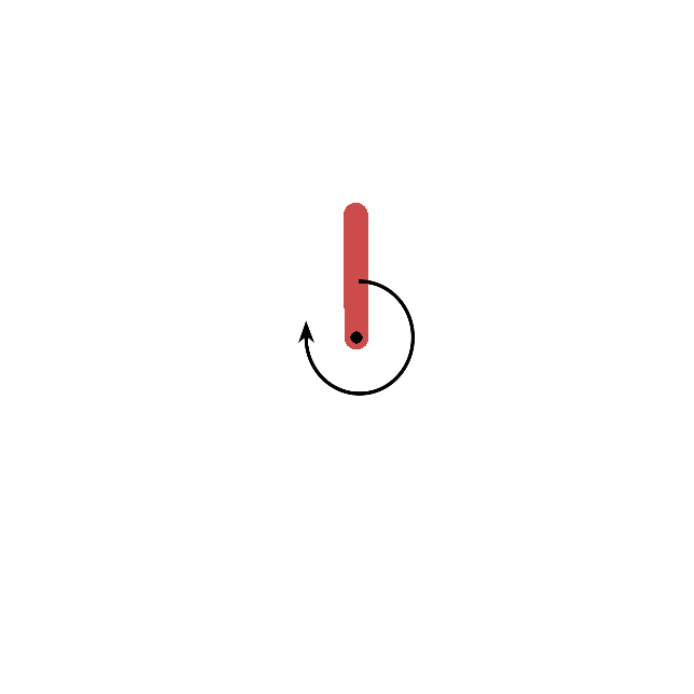
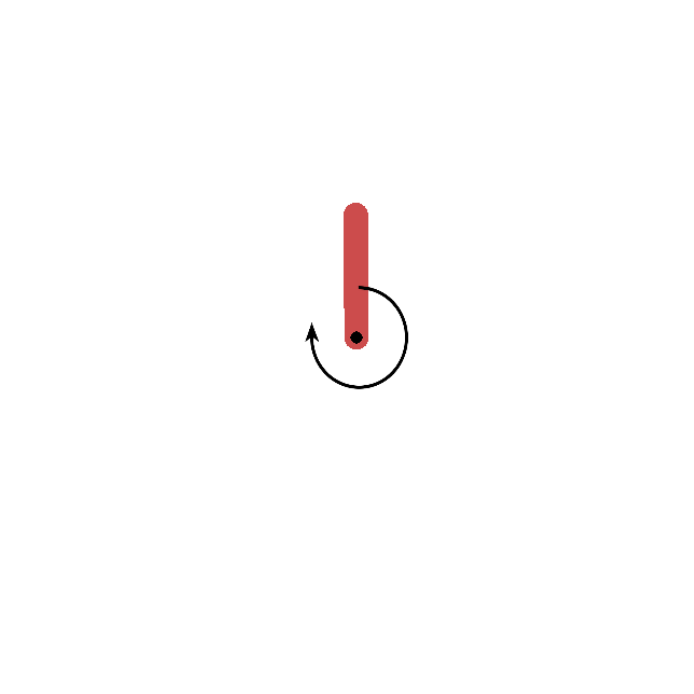
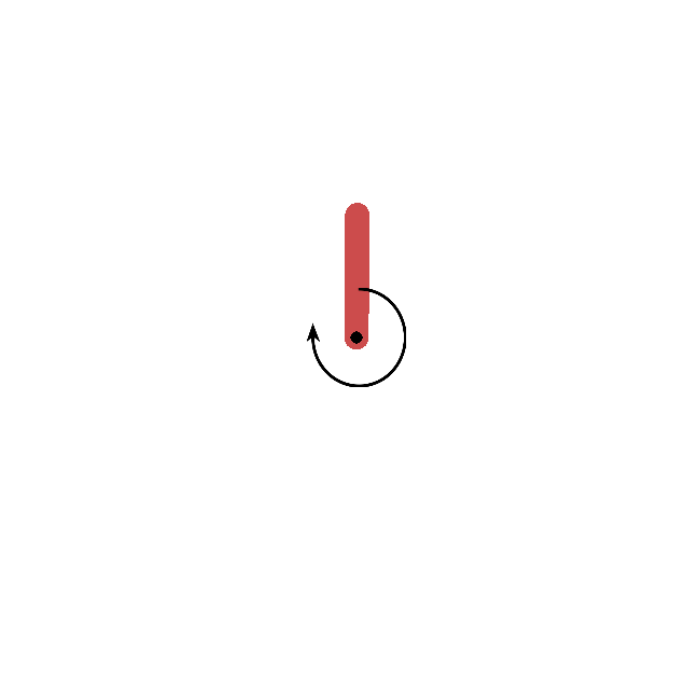
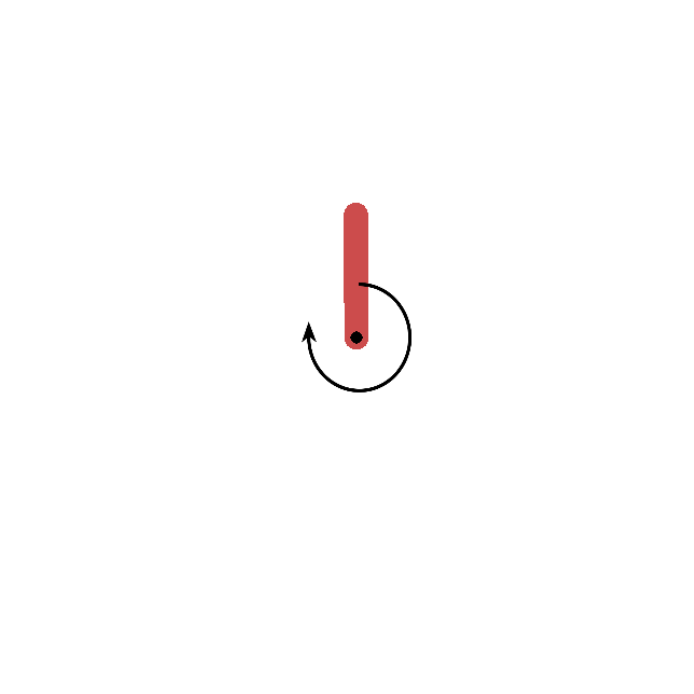
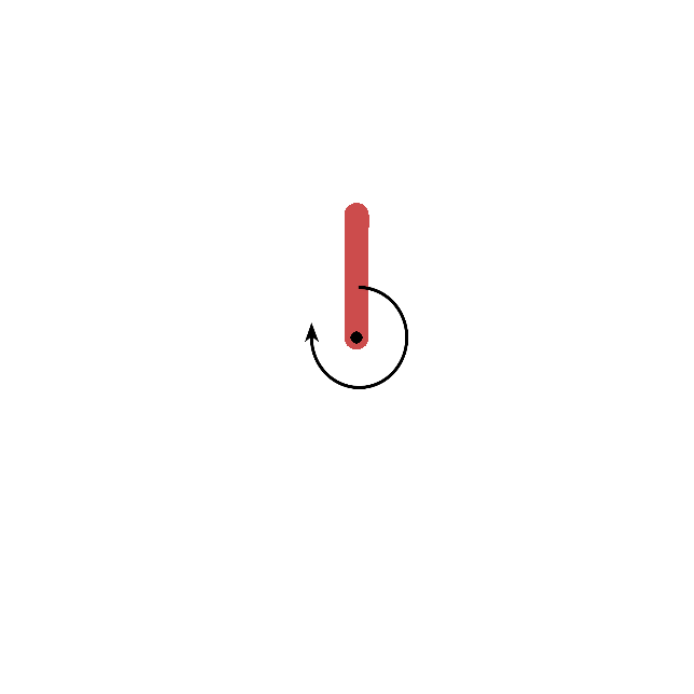
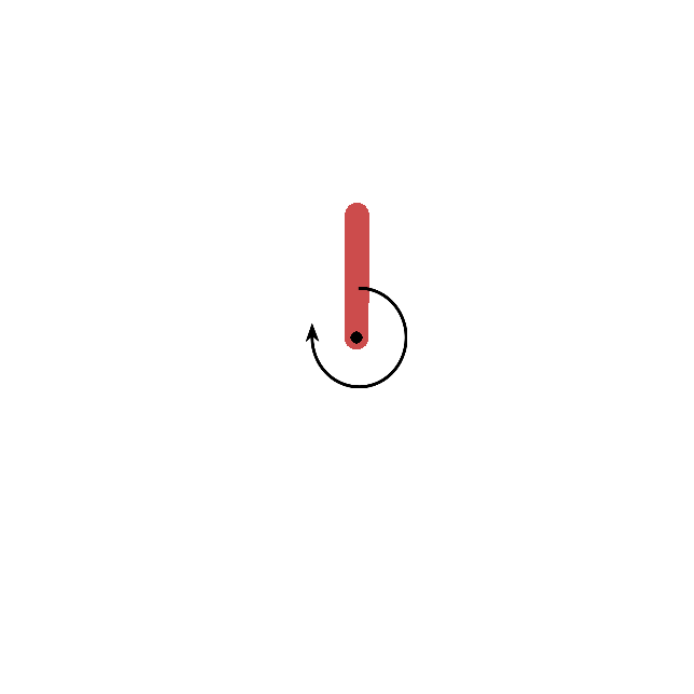
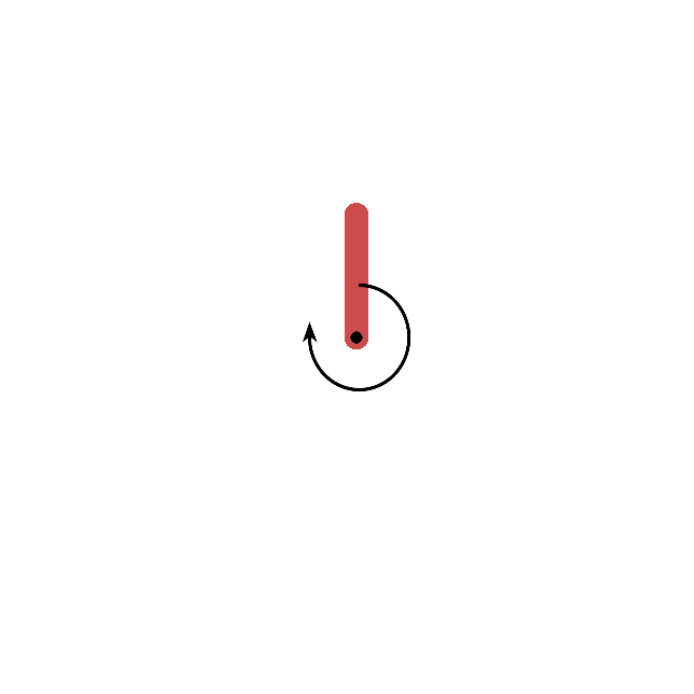
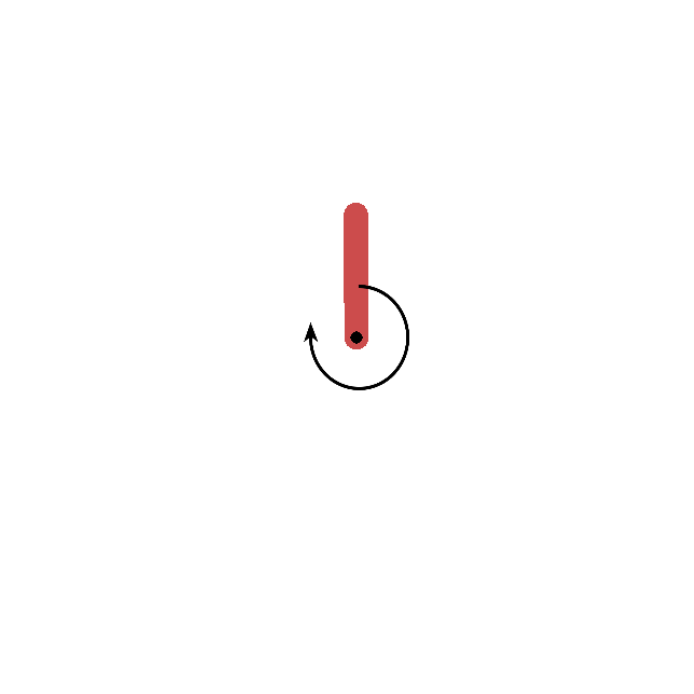
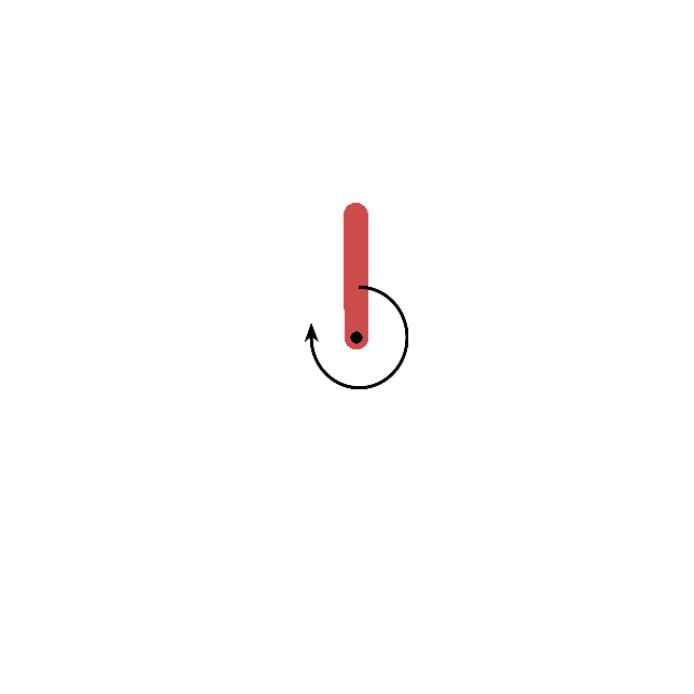
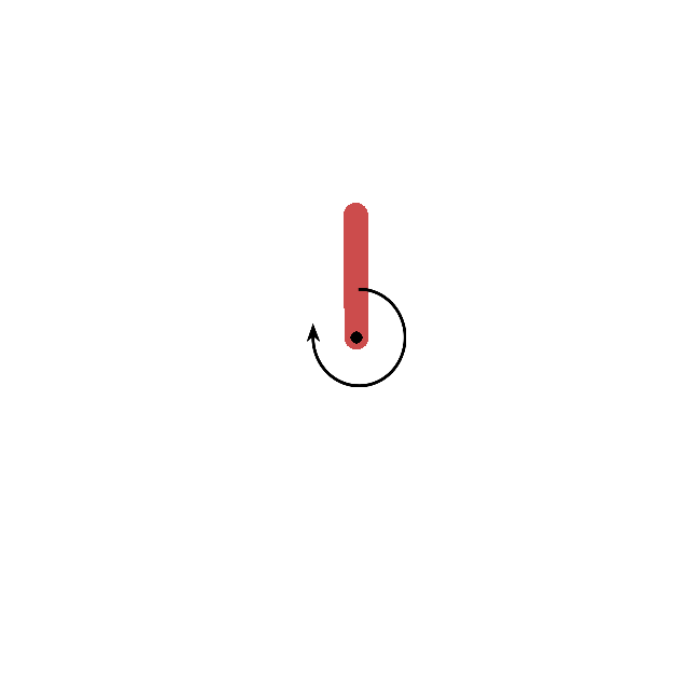
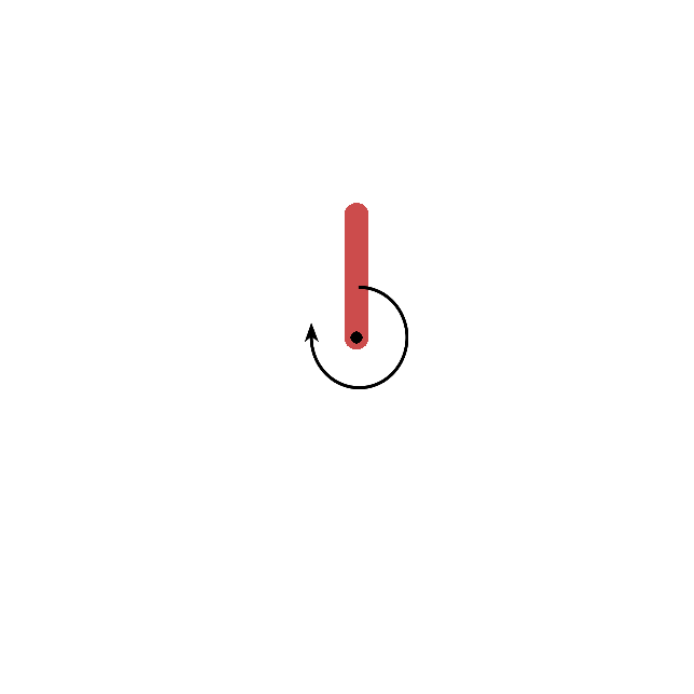
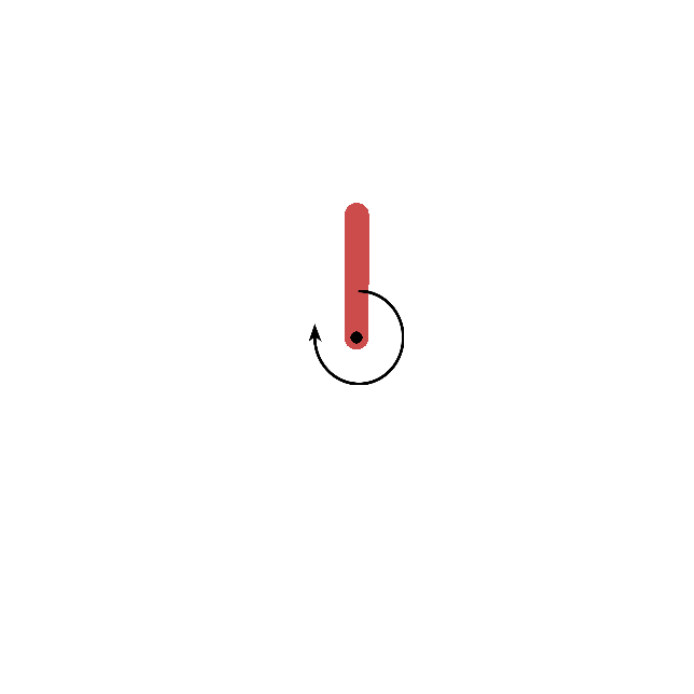
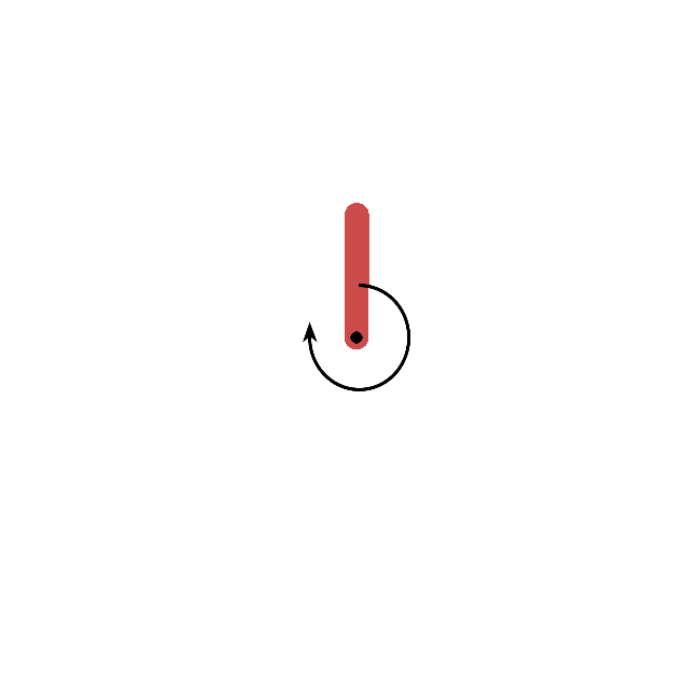
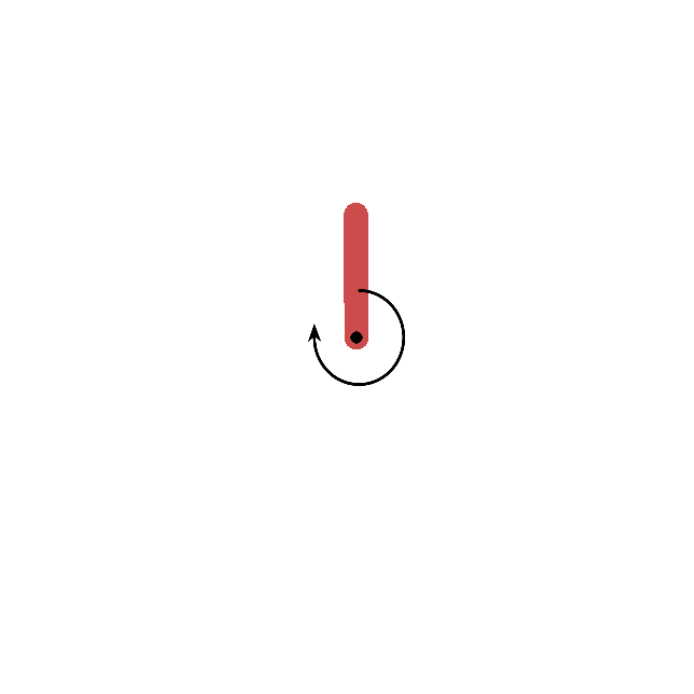
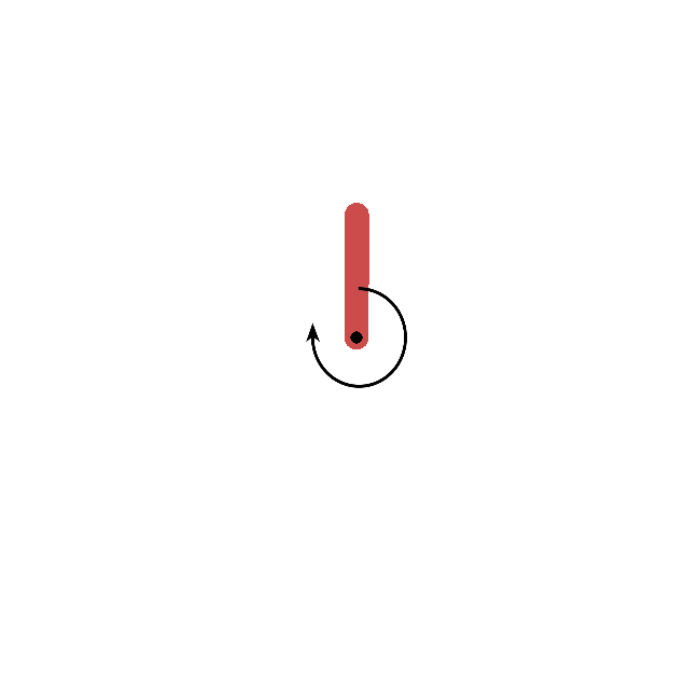
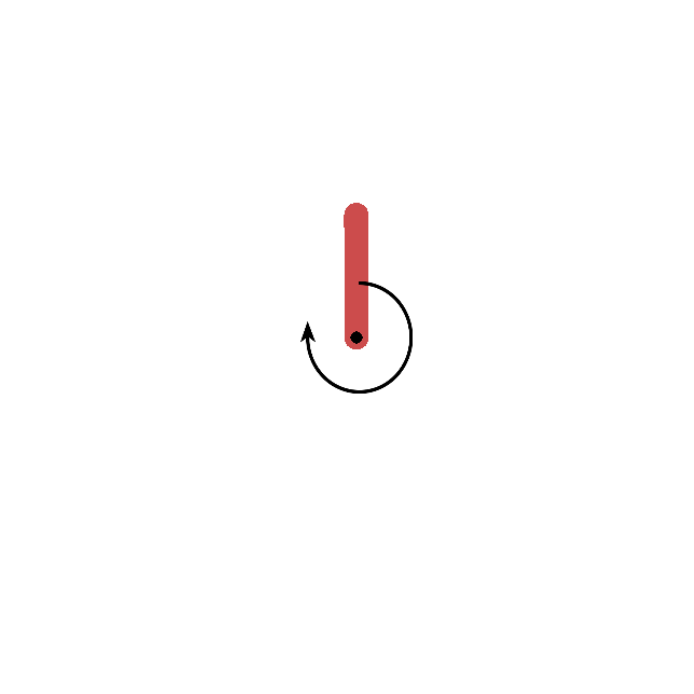
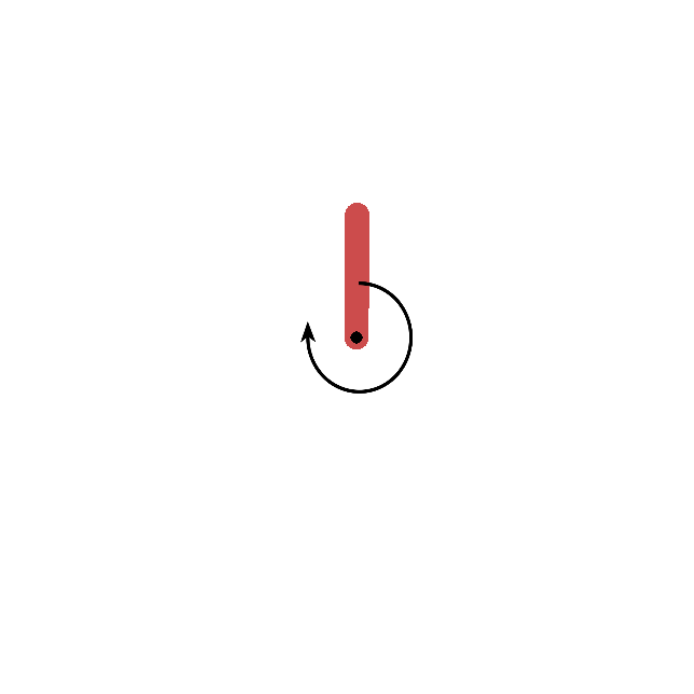
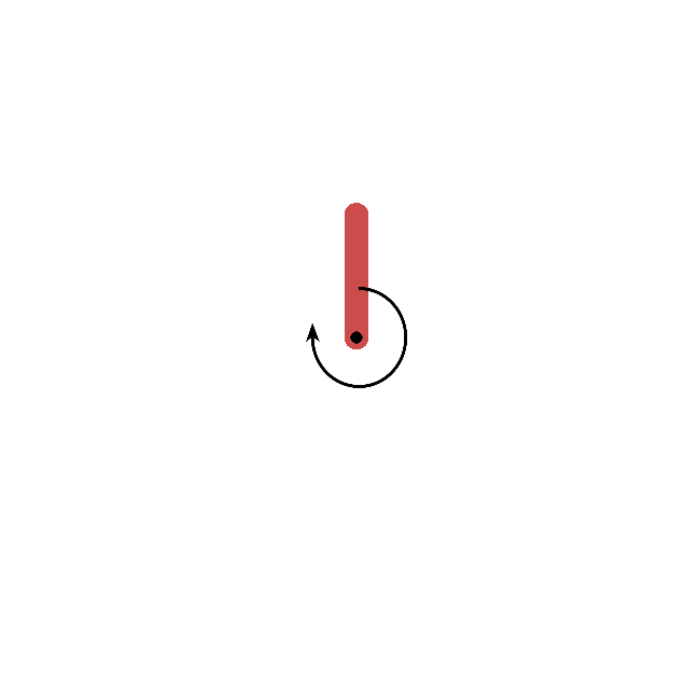
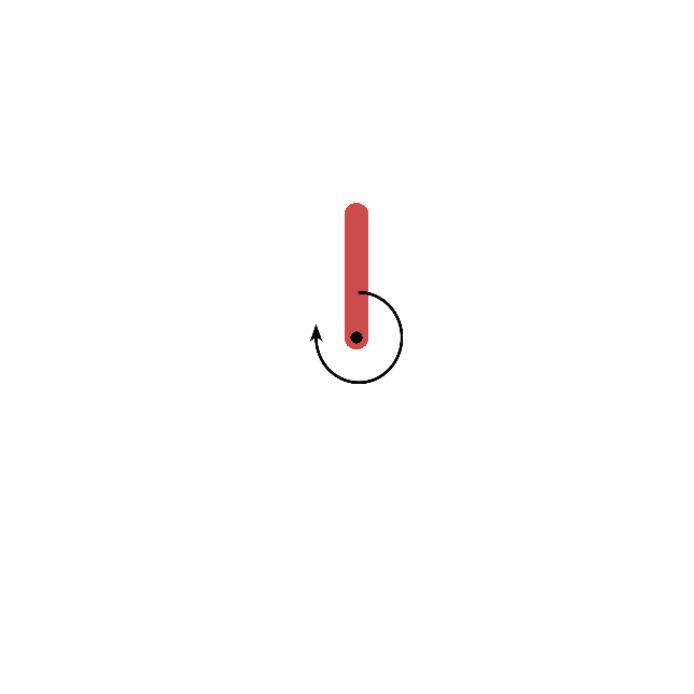

In [10]:
display_frames_as_gif(frames)